In [1]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import cv2 as cv
from scipy import signal

In [2]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)

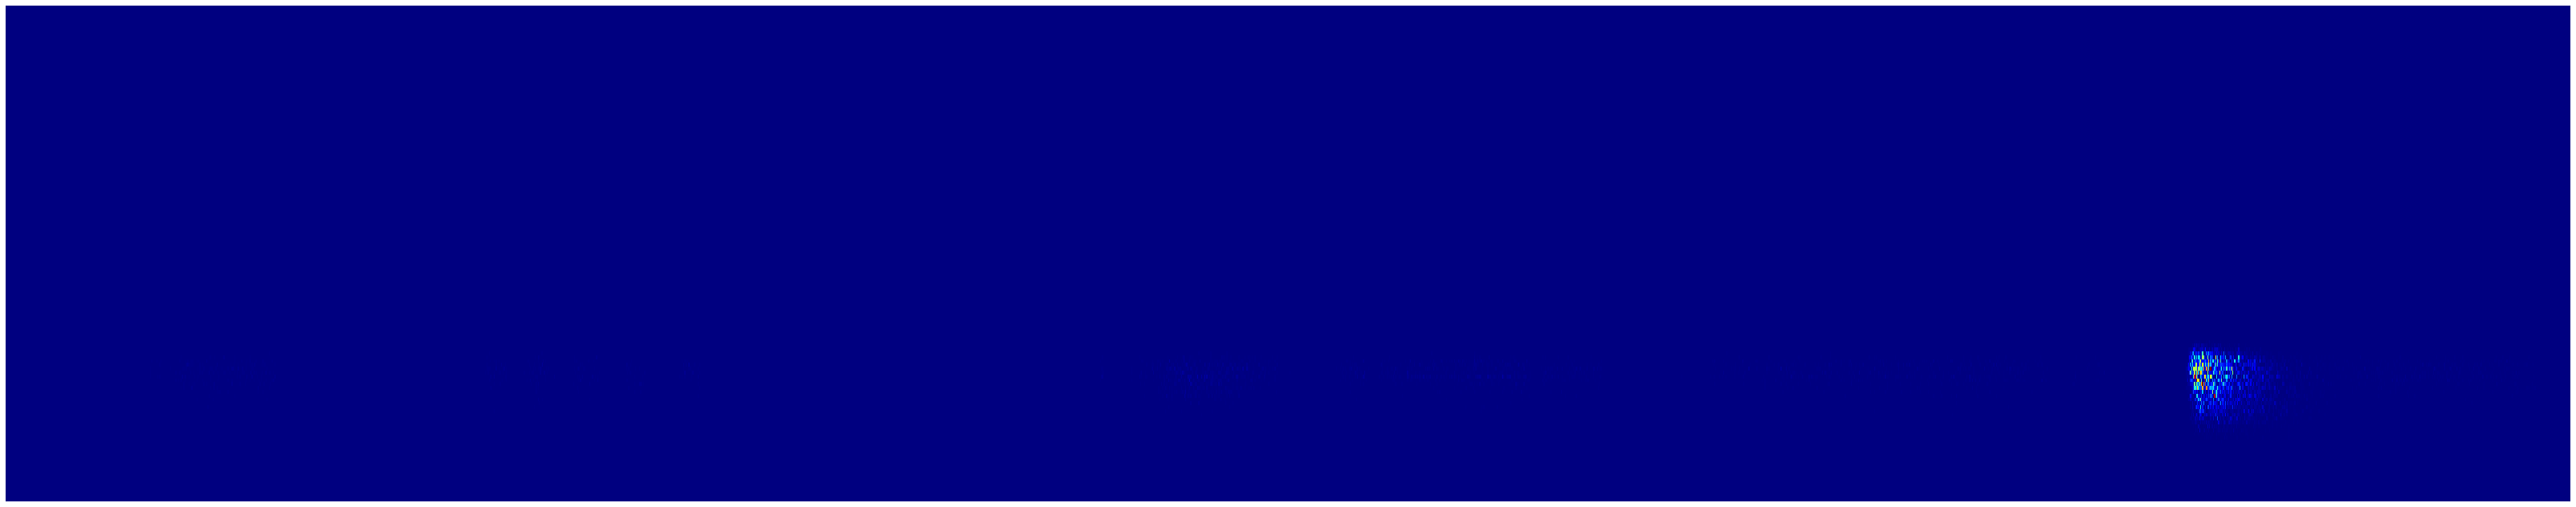

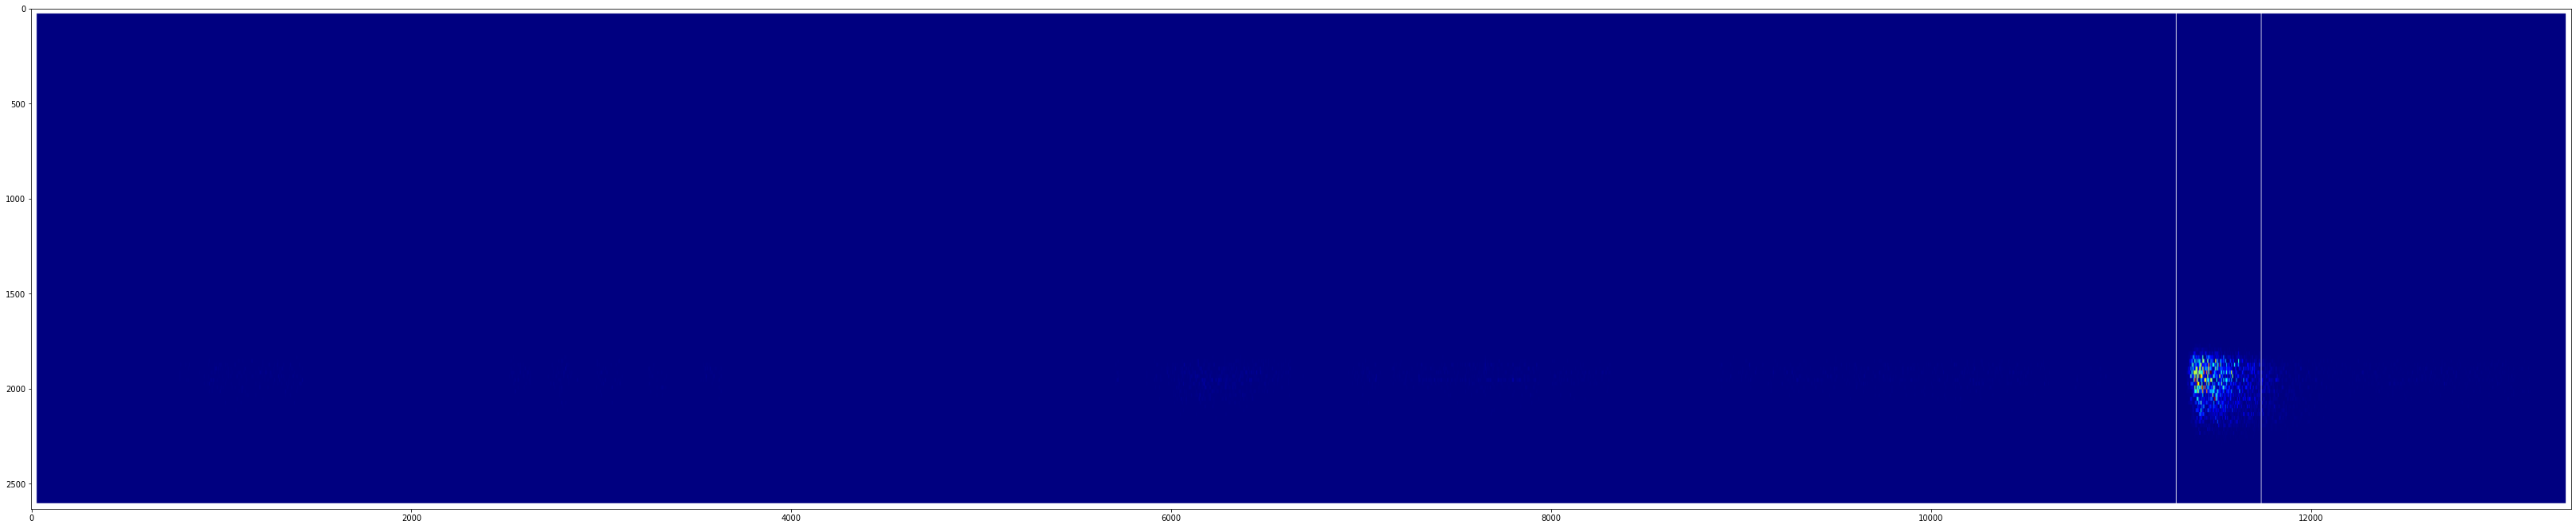

72964.80071813286 73499.335


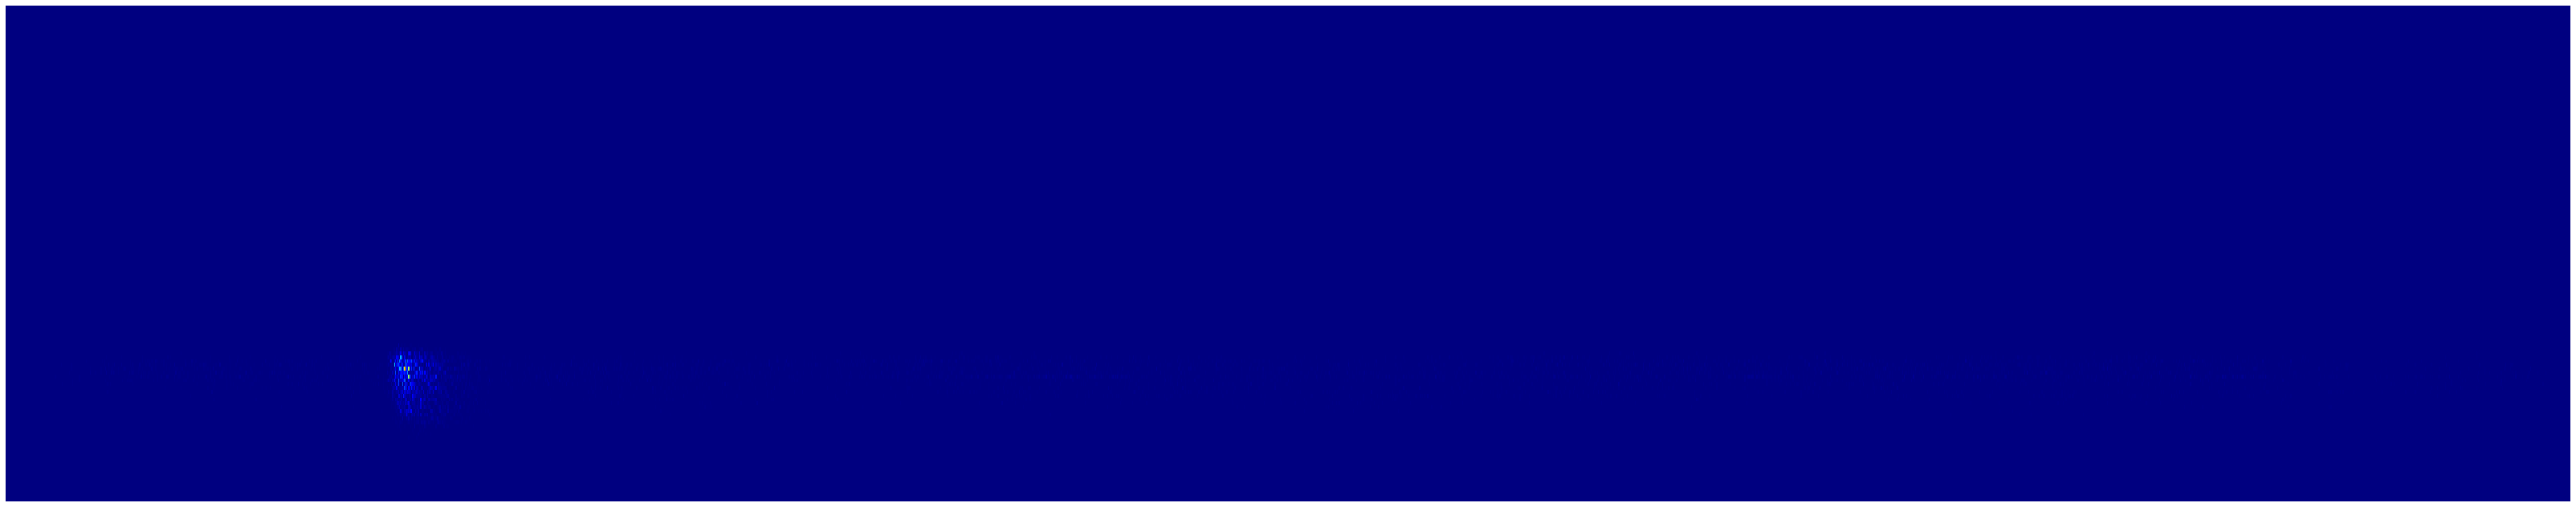

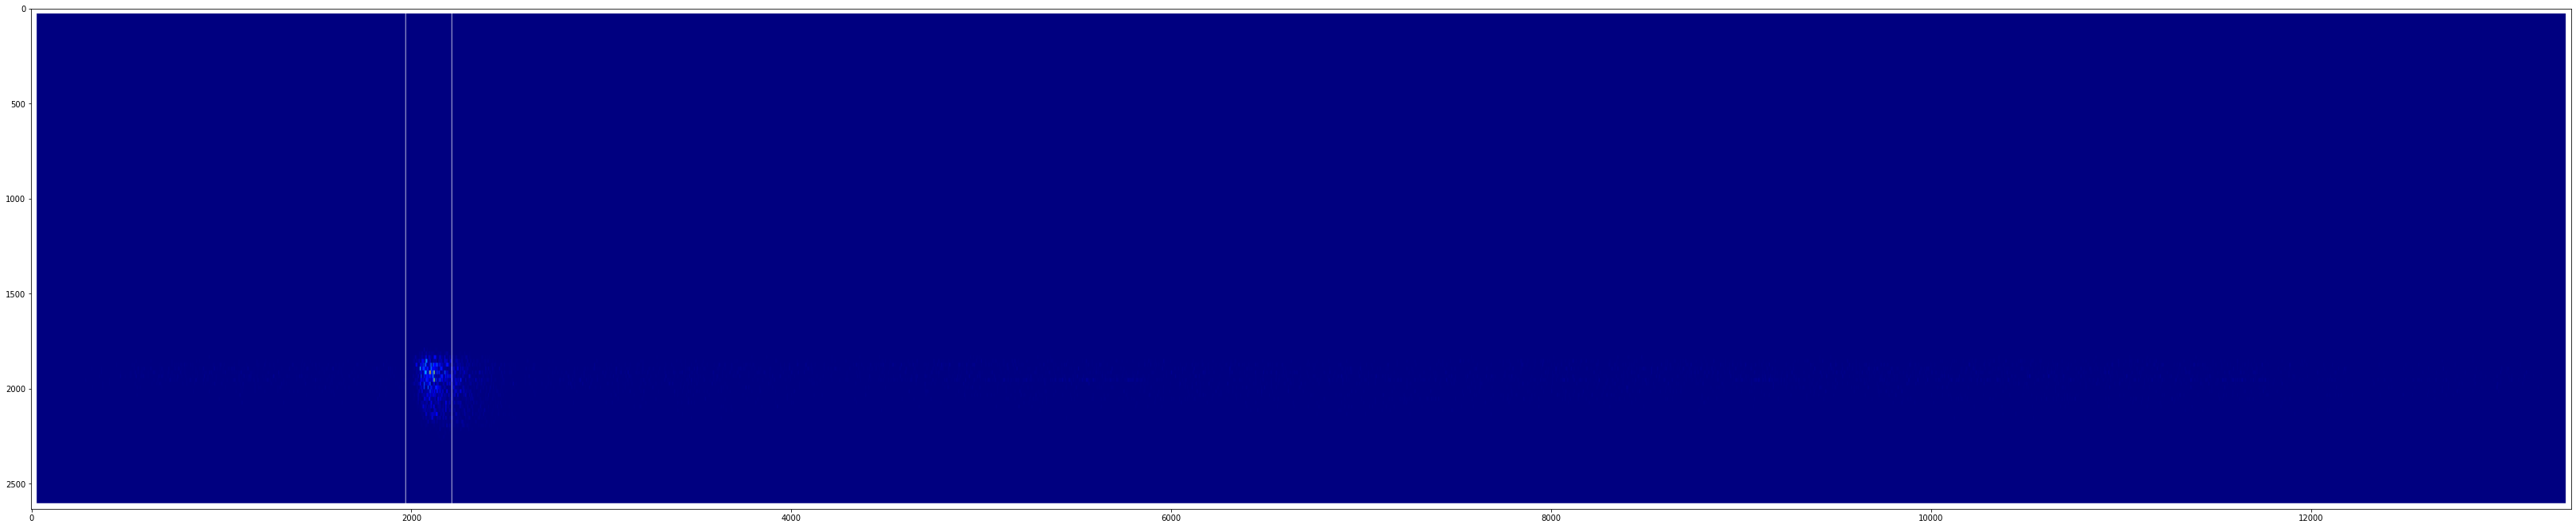

12739.181260797397 12719.56


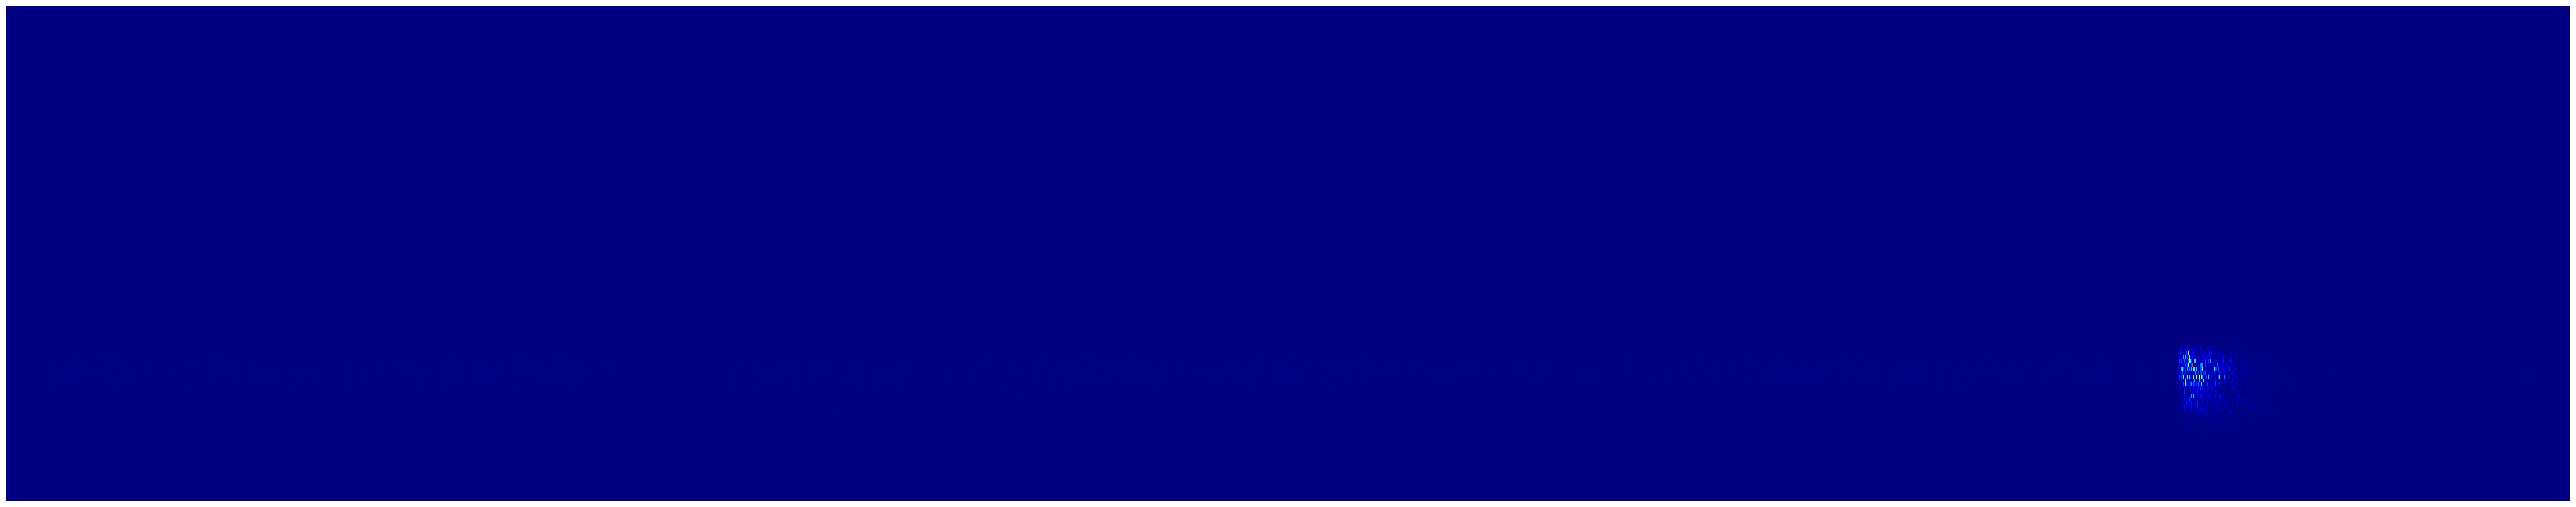

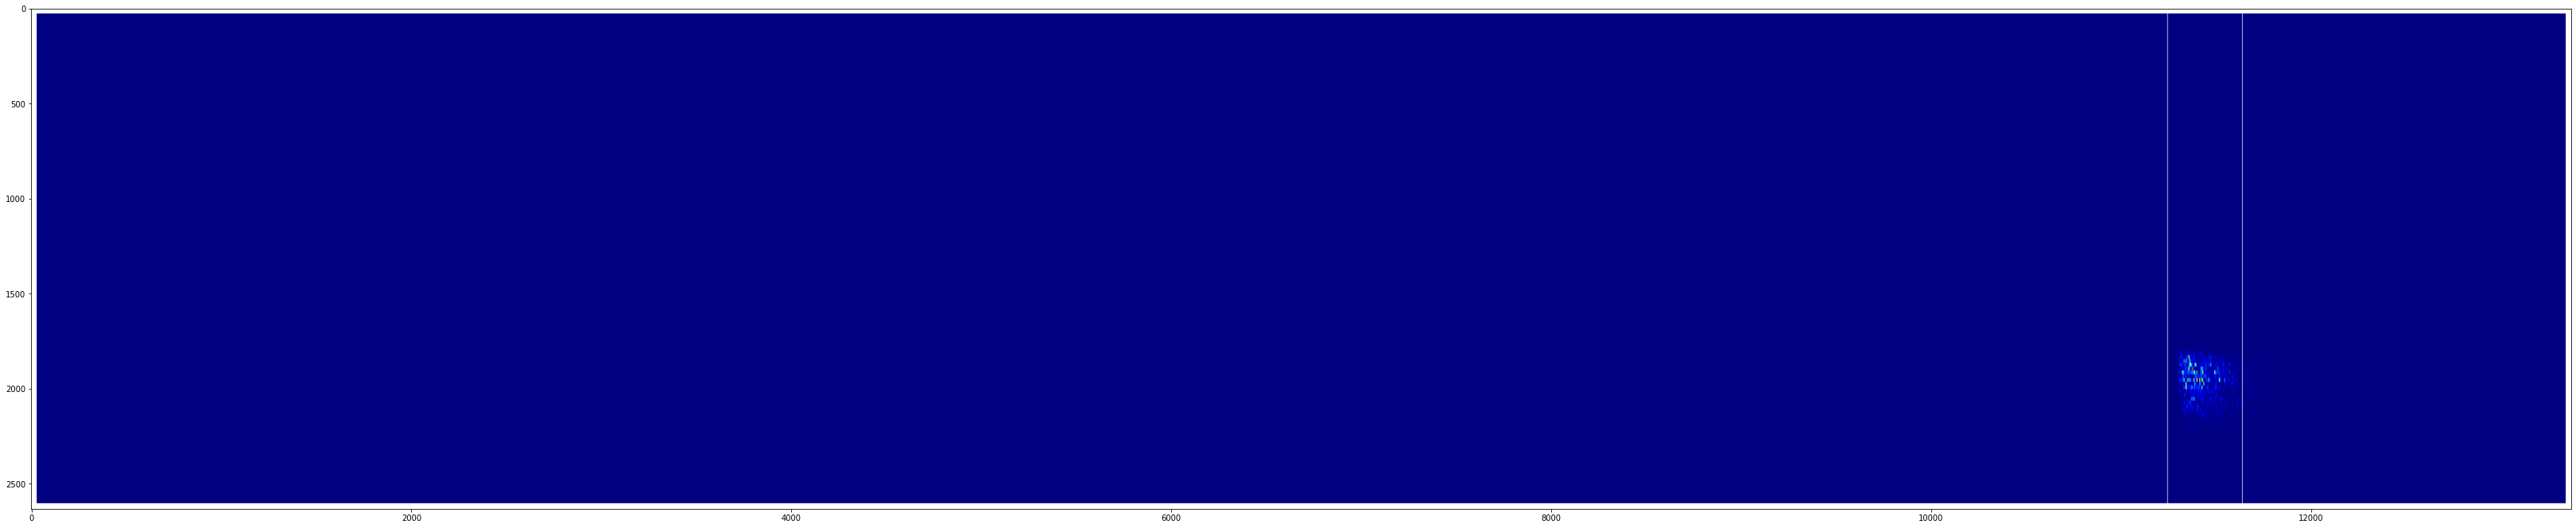

72666.9786479681 73019.435


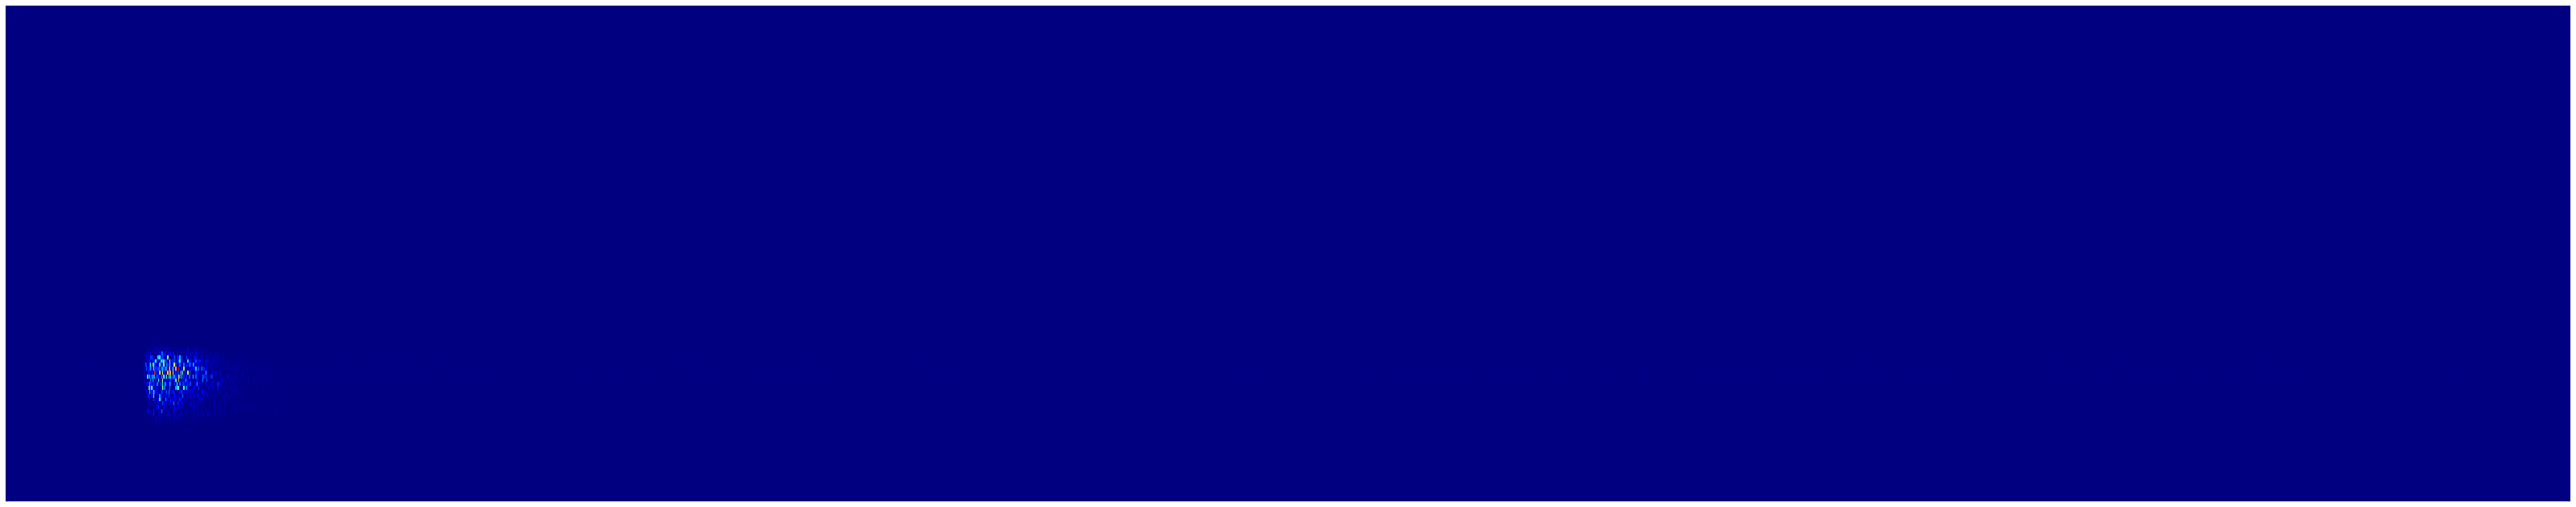

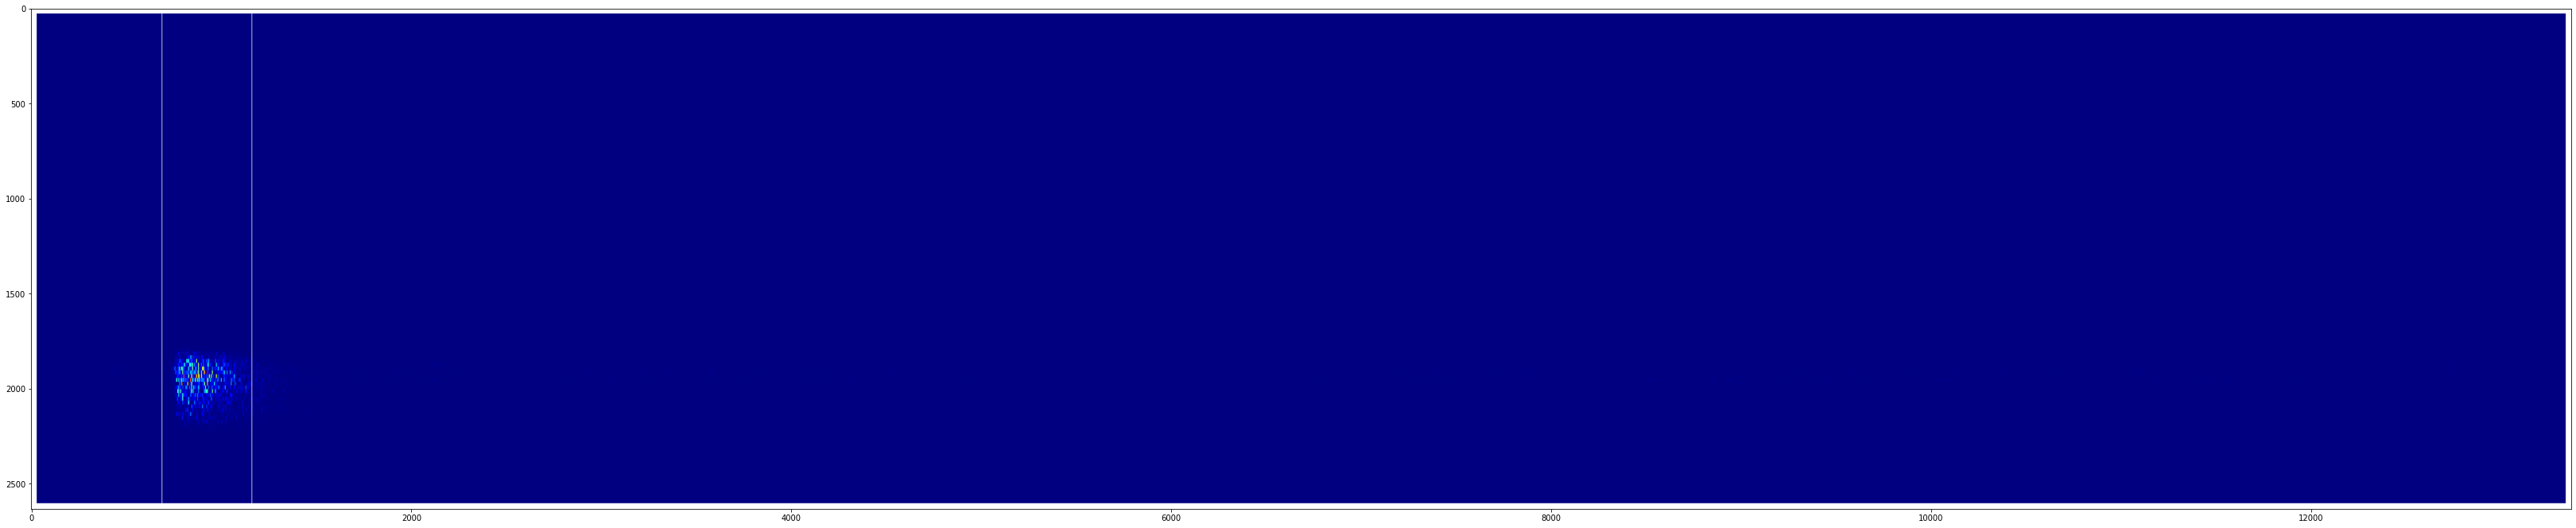

4453.250748055057 4439.804


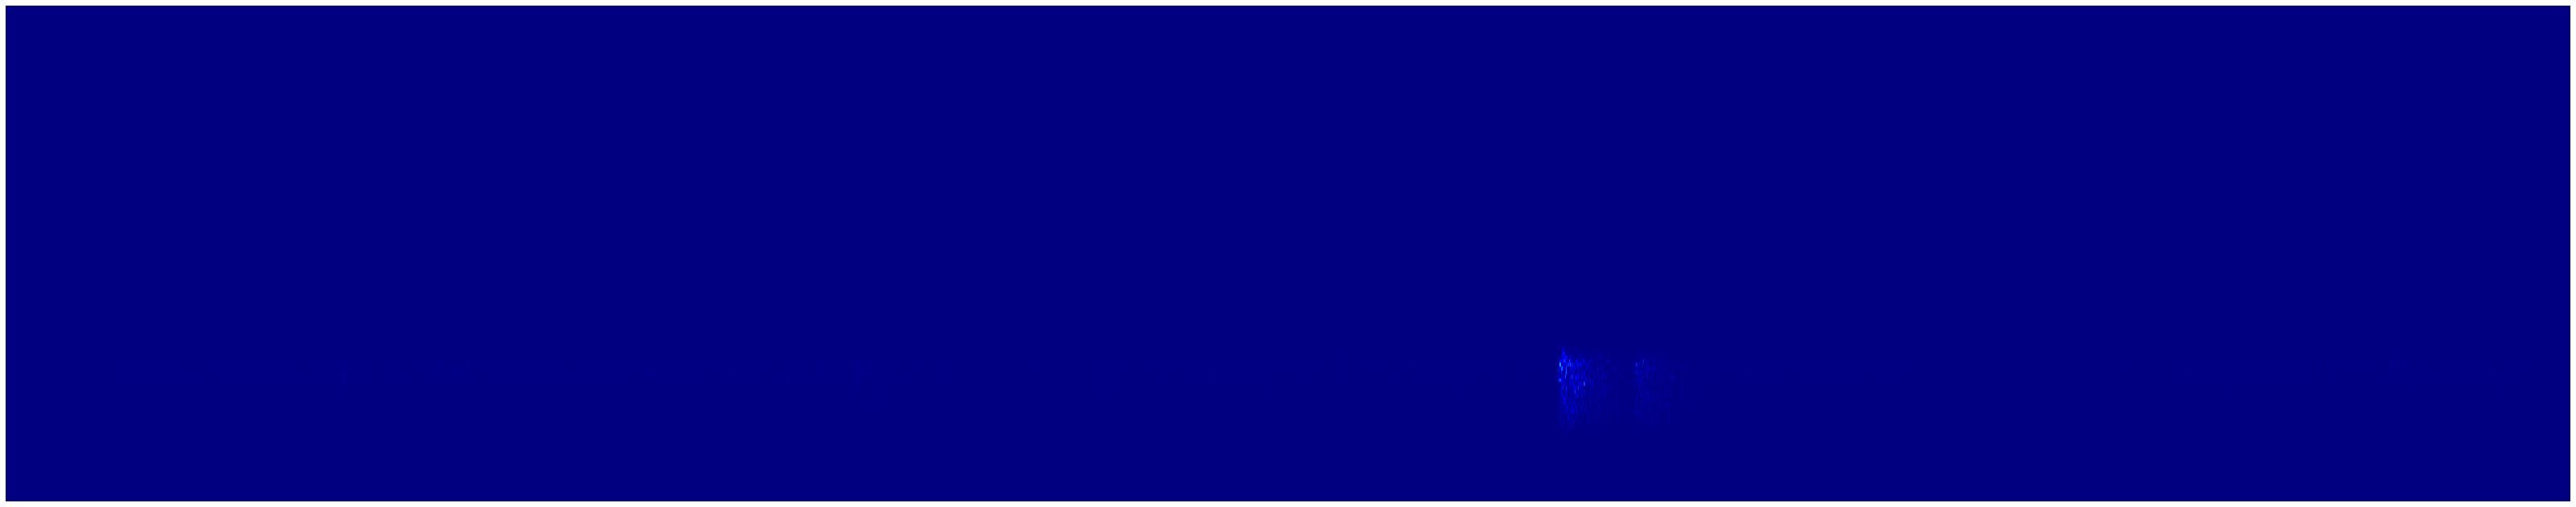

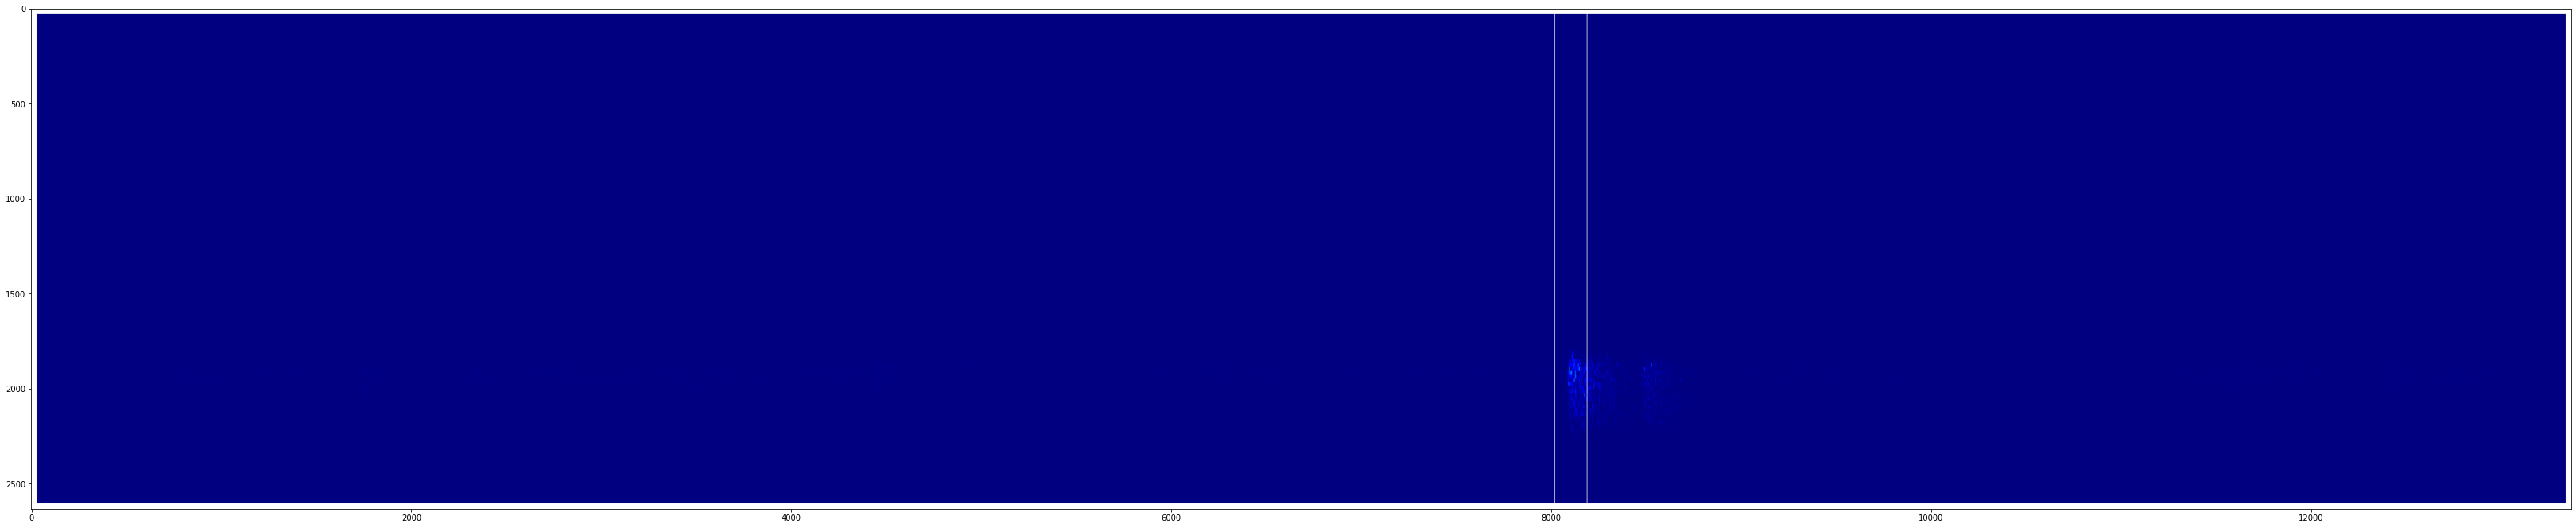

51822.808396282875 52139.34


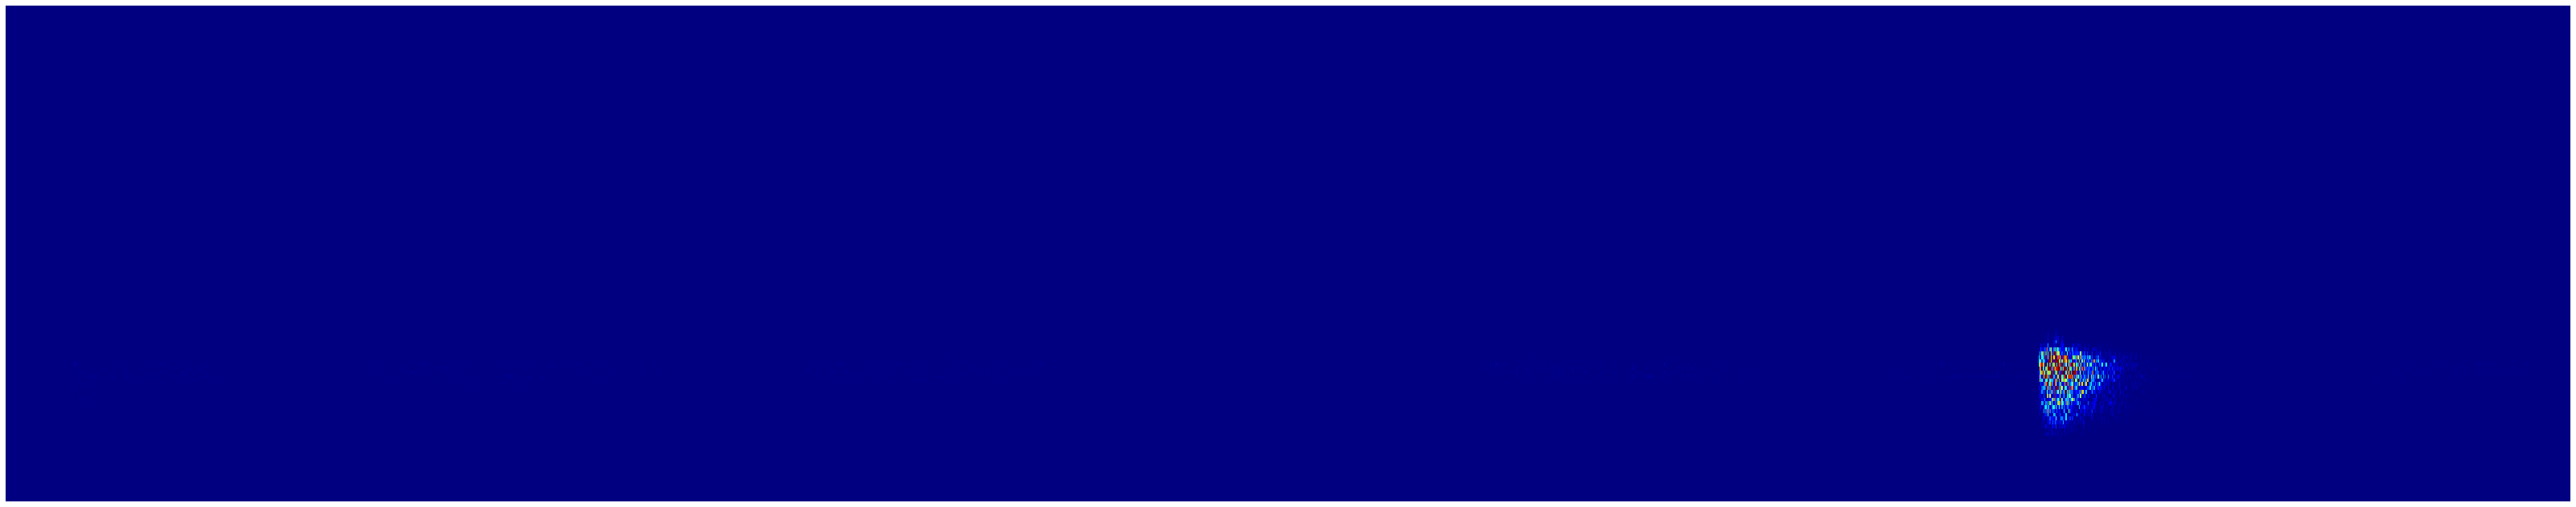

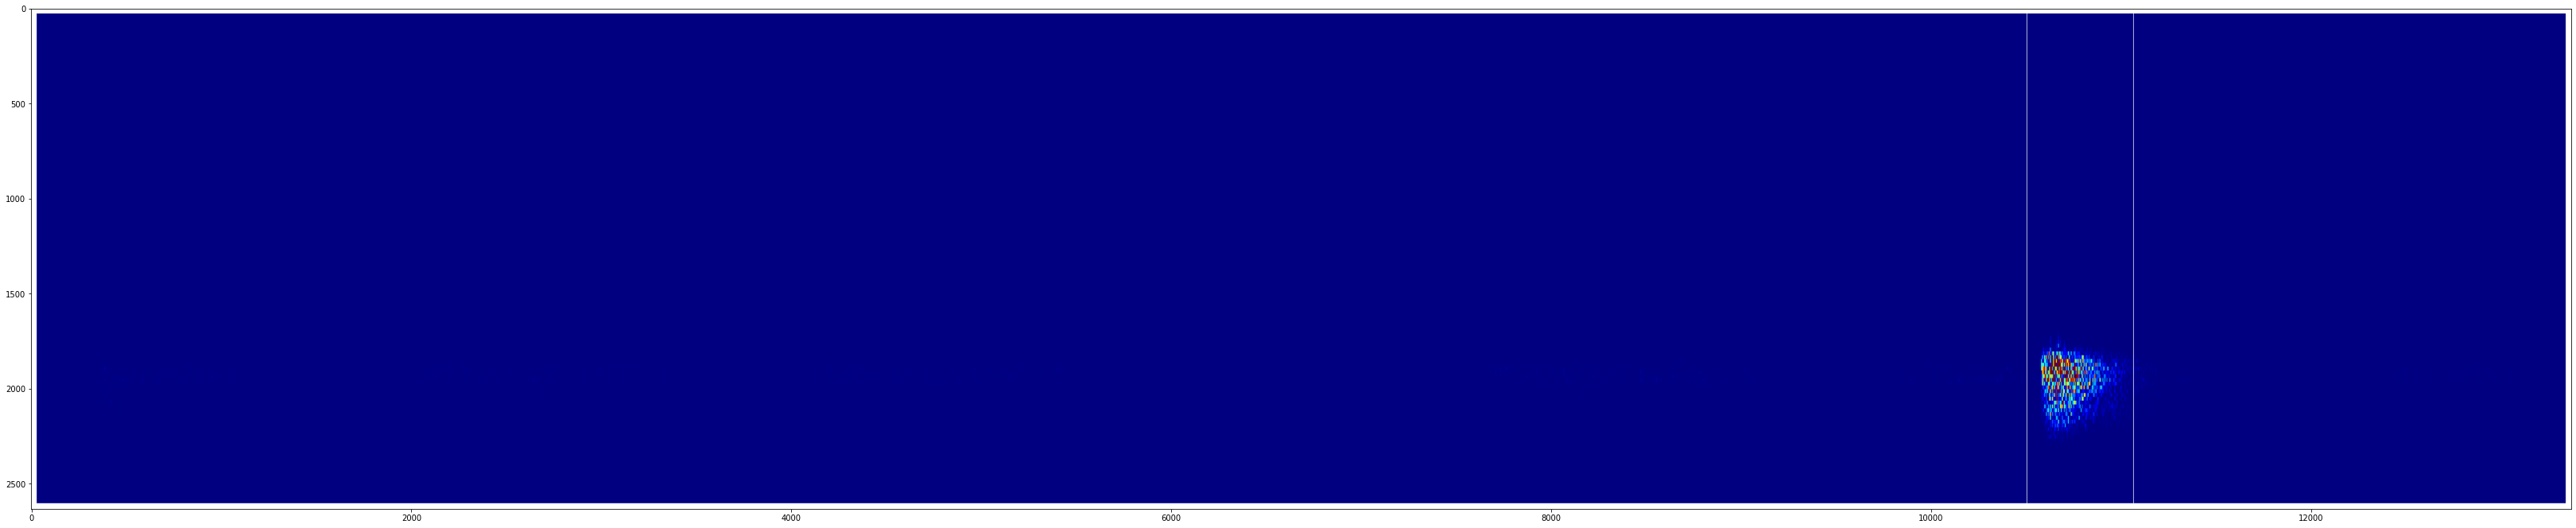

67884.96043494462 68399.49


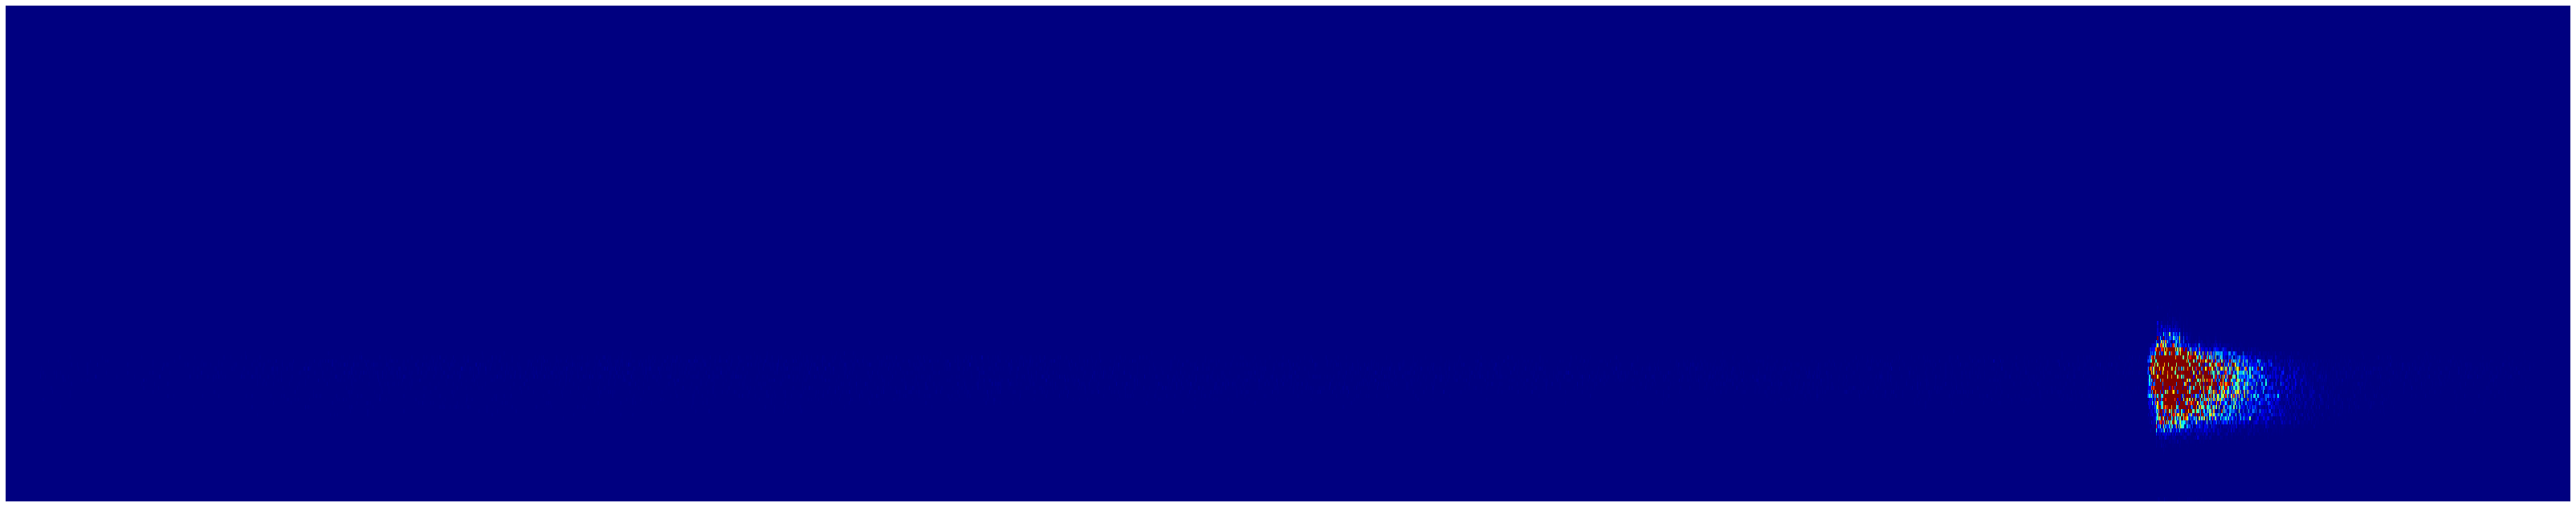

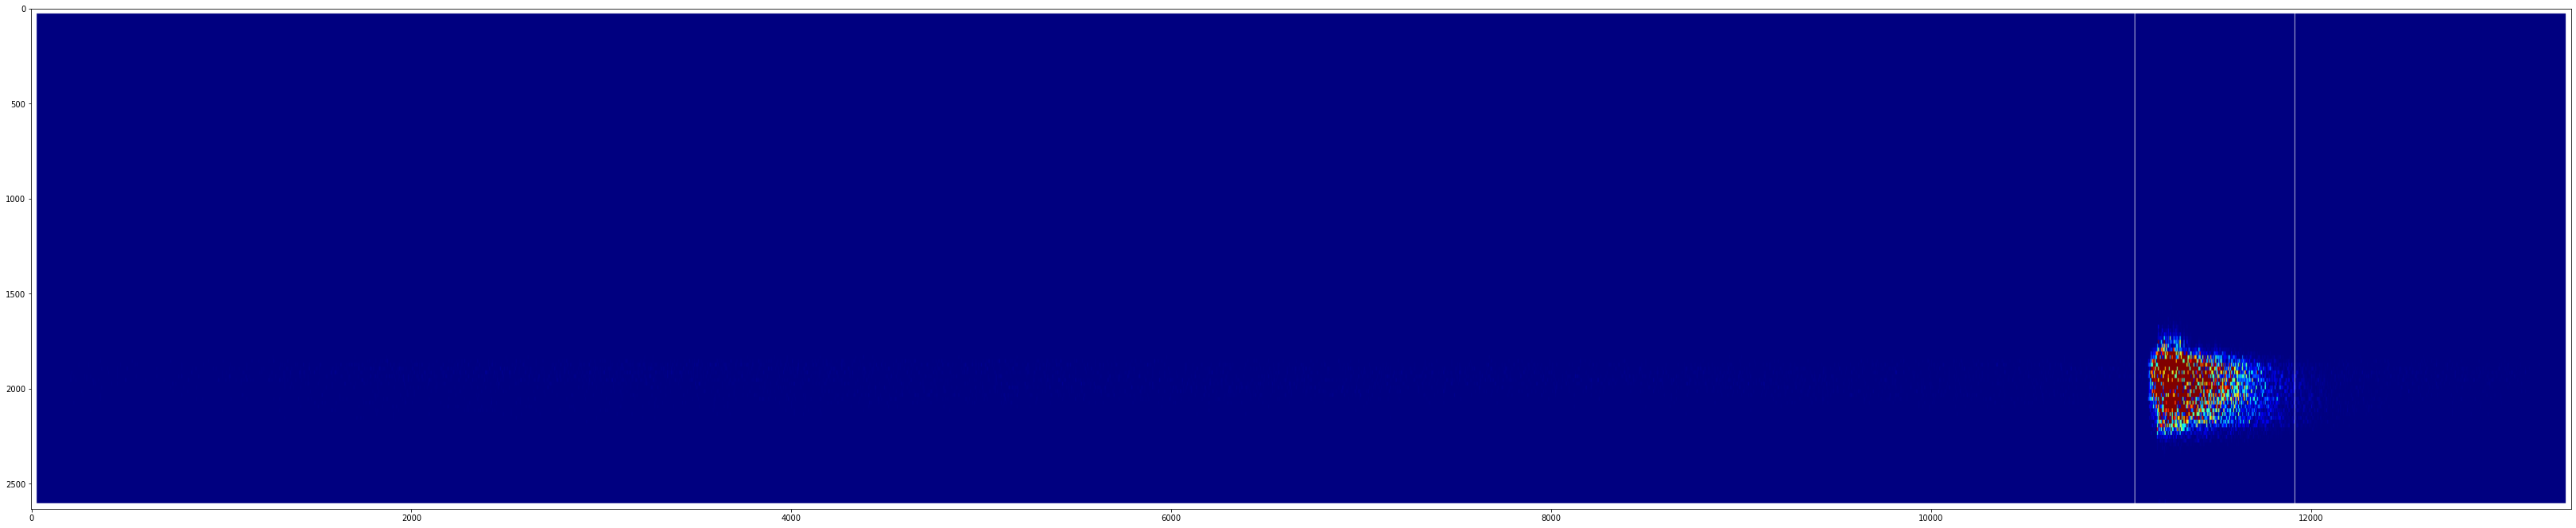

71556.78965256372 72059.884


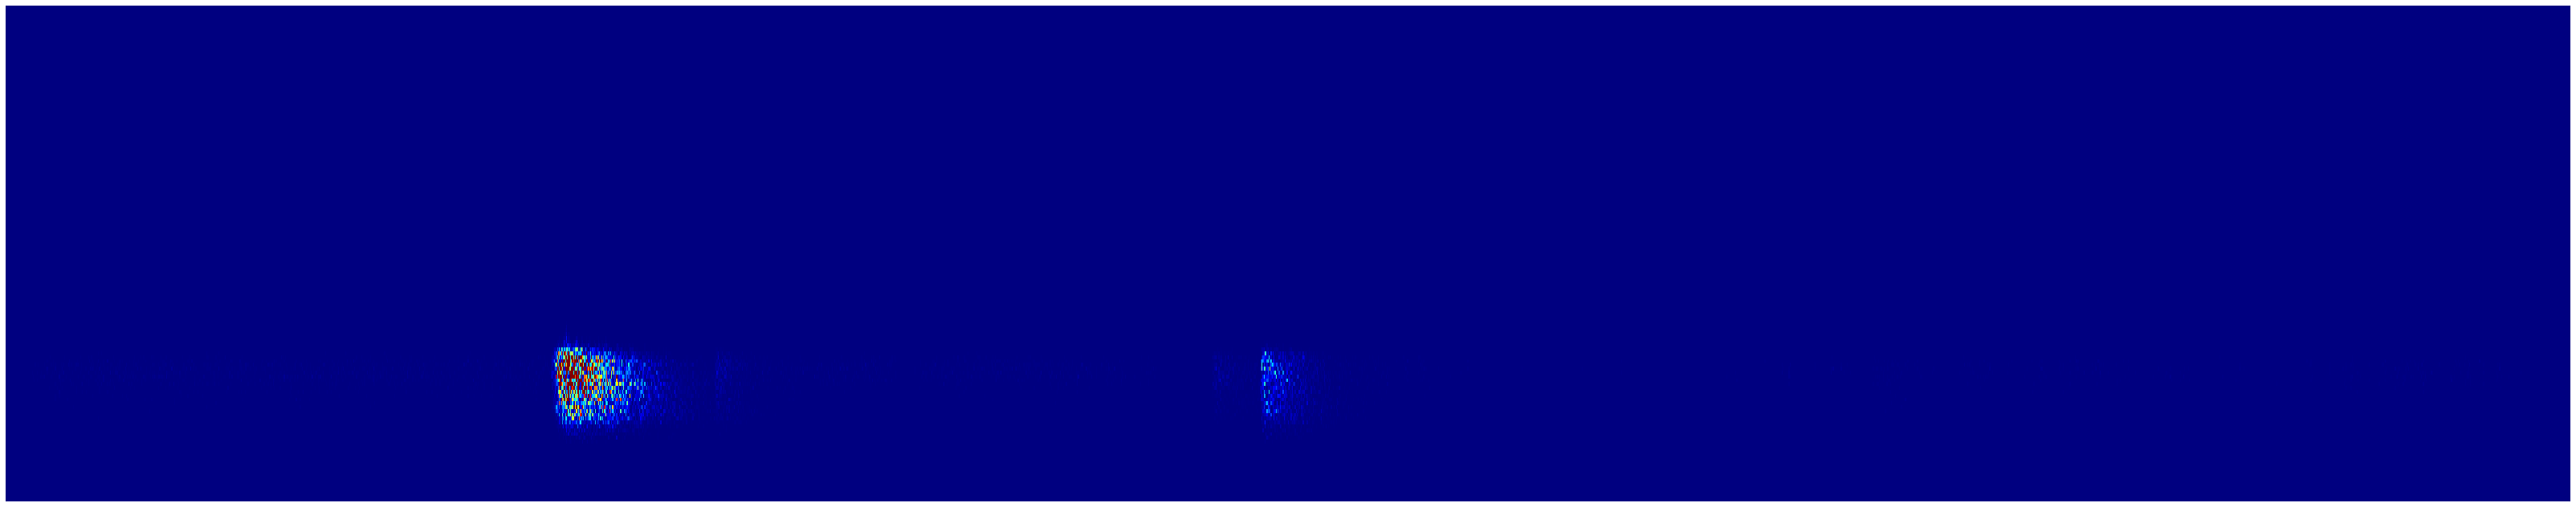

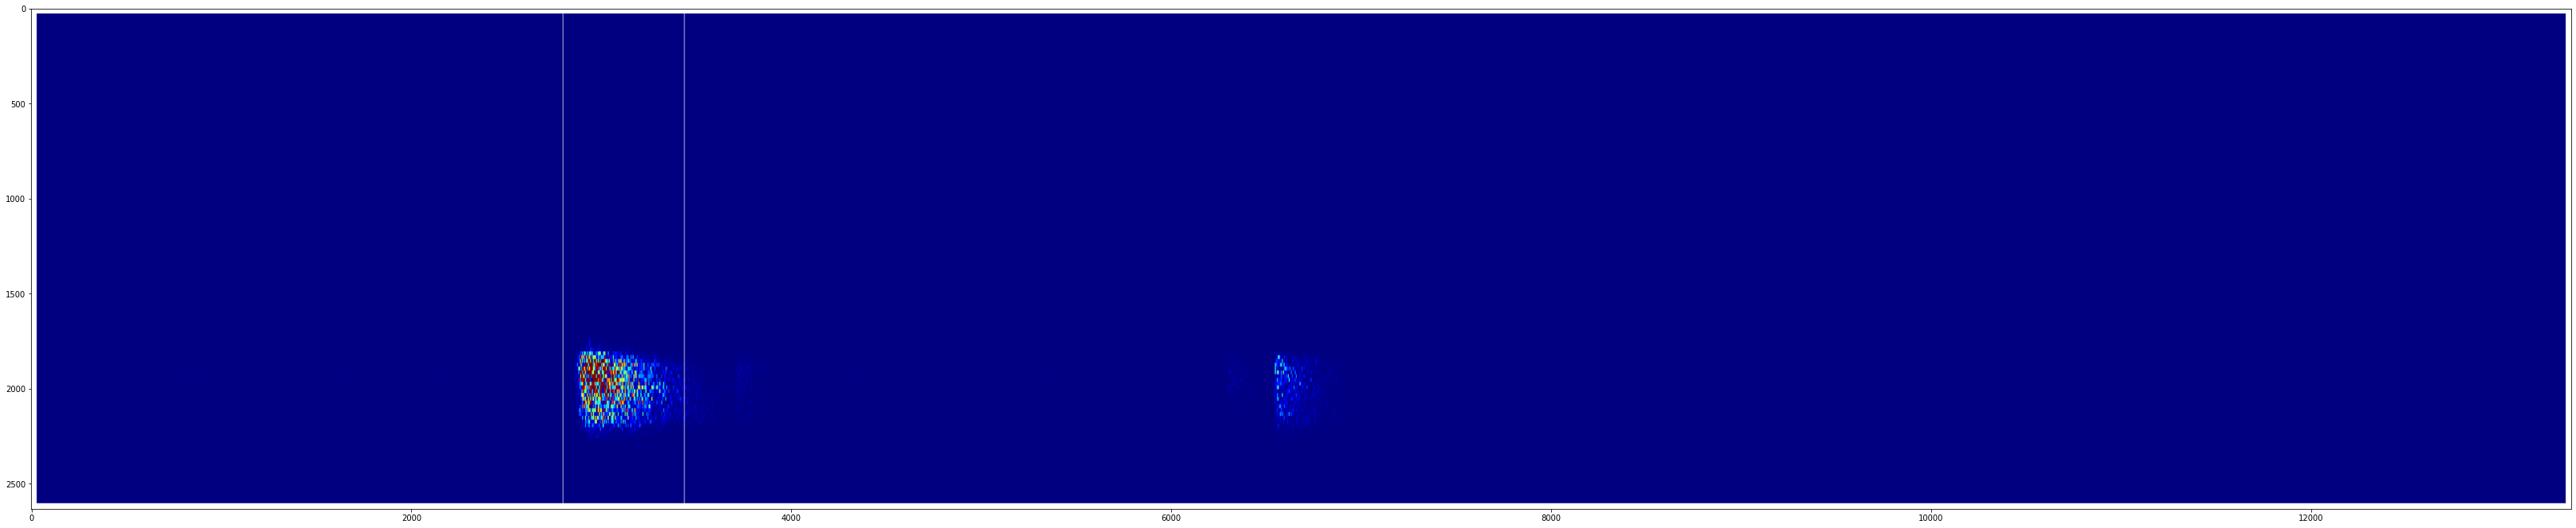

18090.800785881234 18359.513


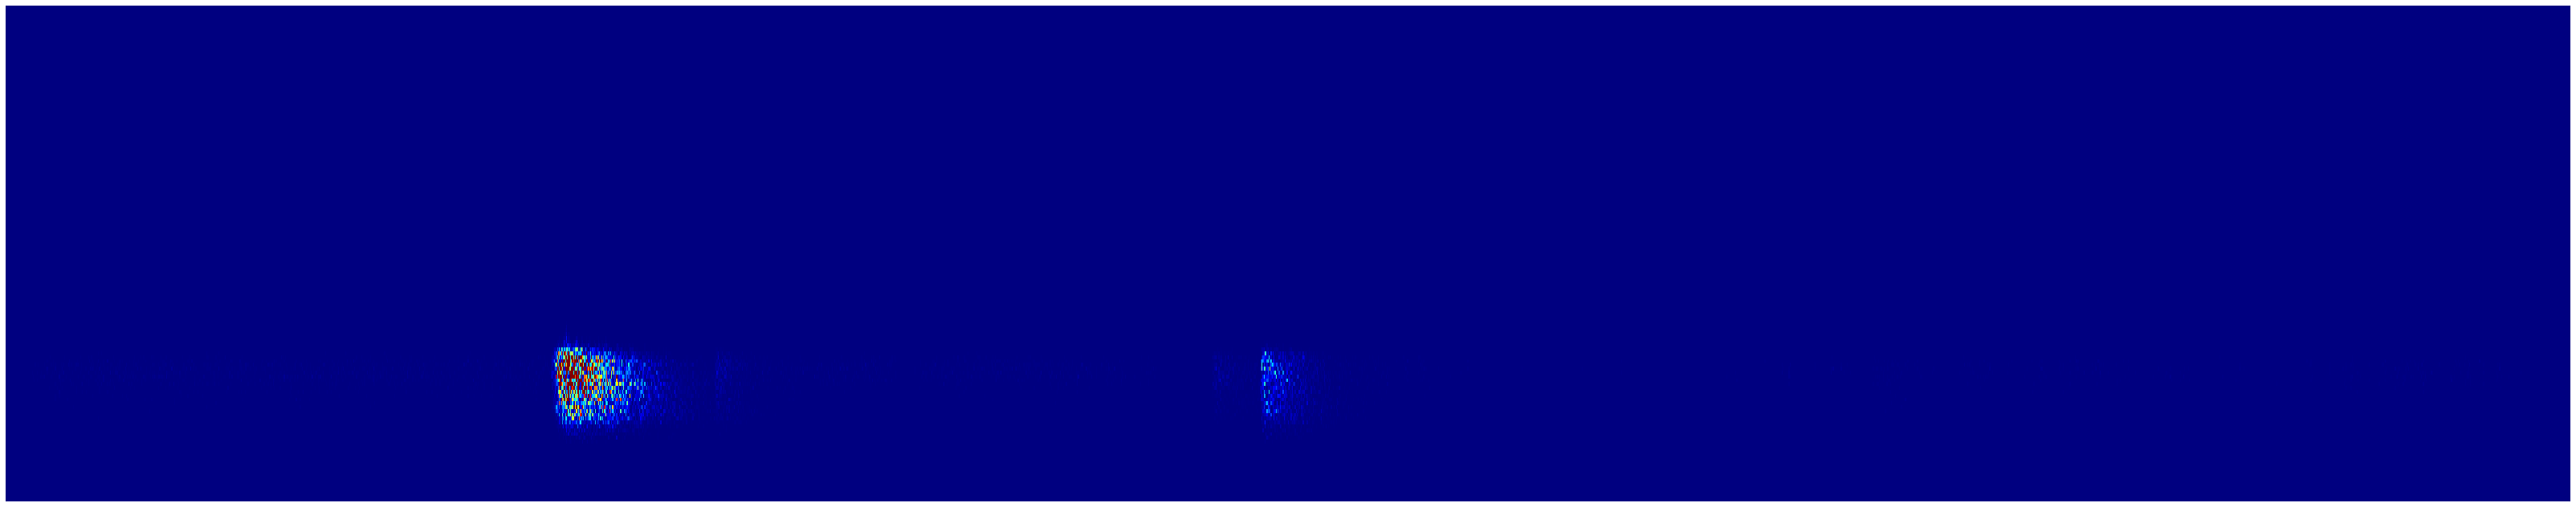

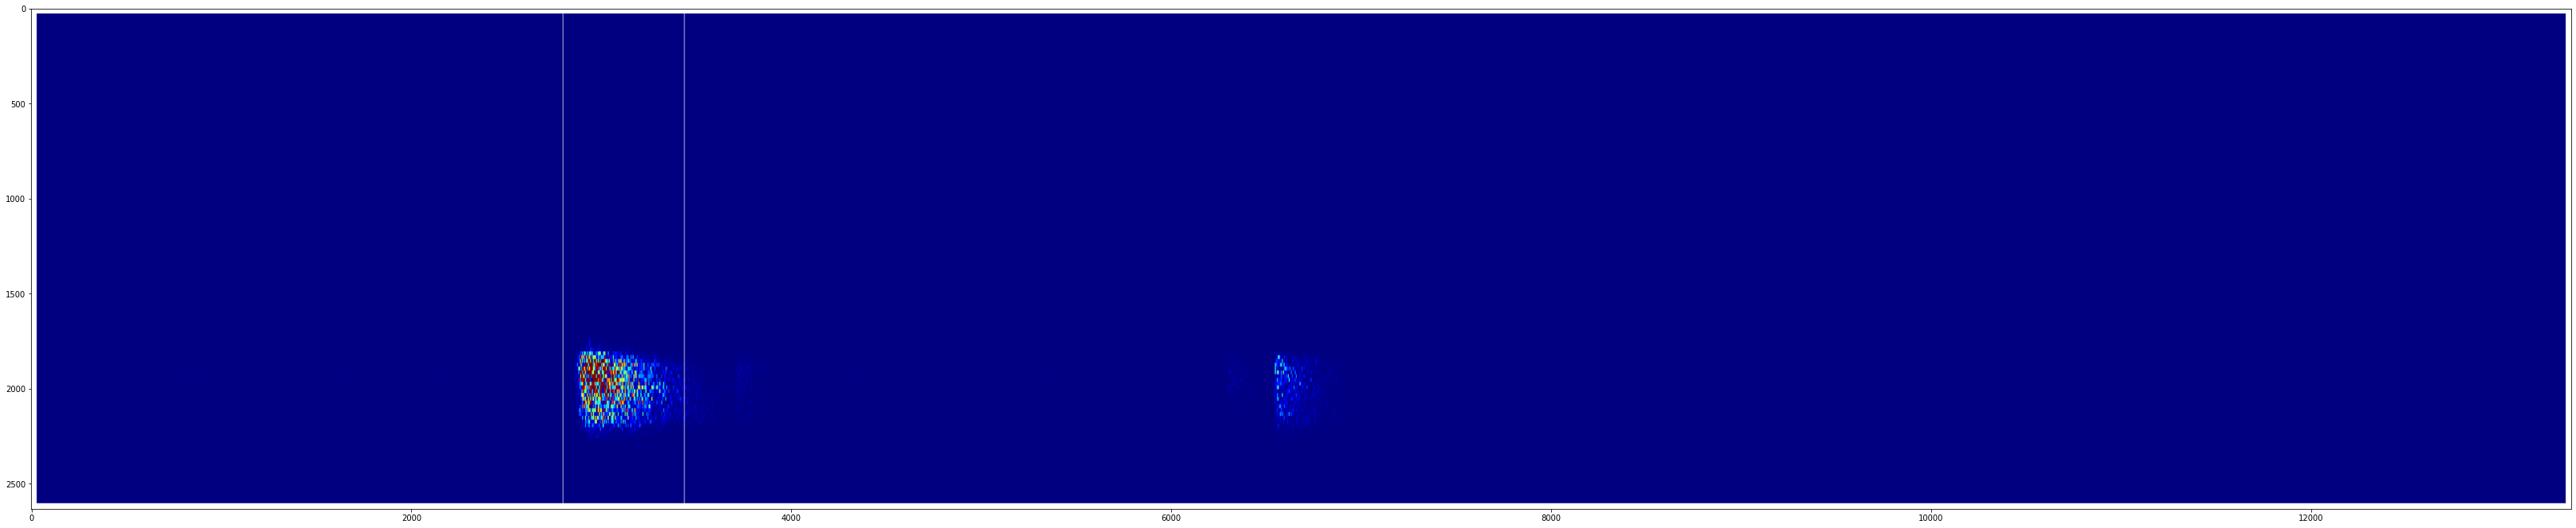

18090.800785881234 42239.513


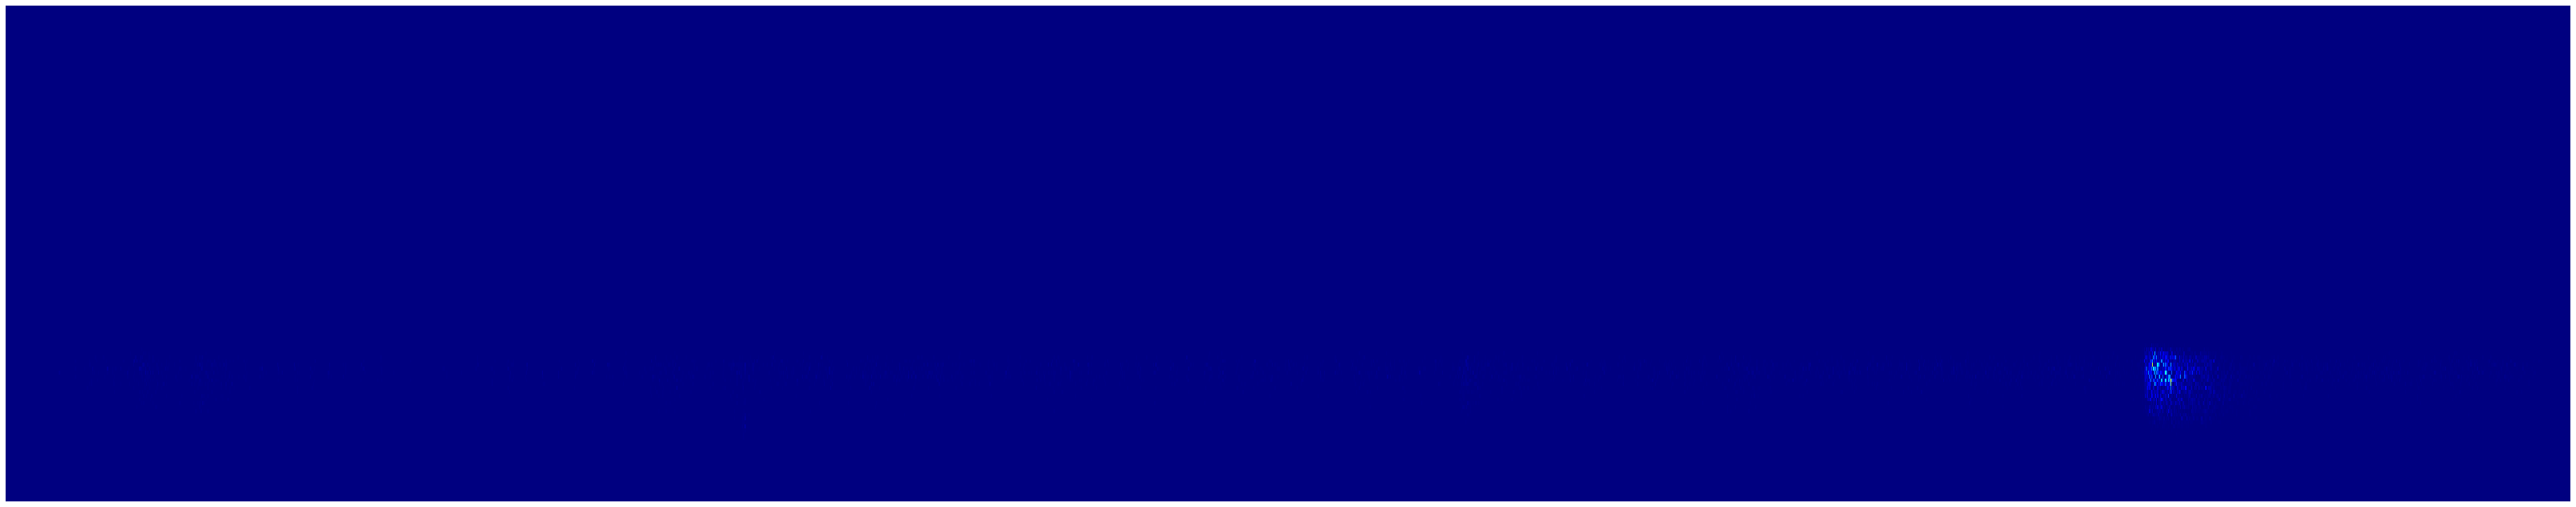

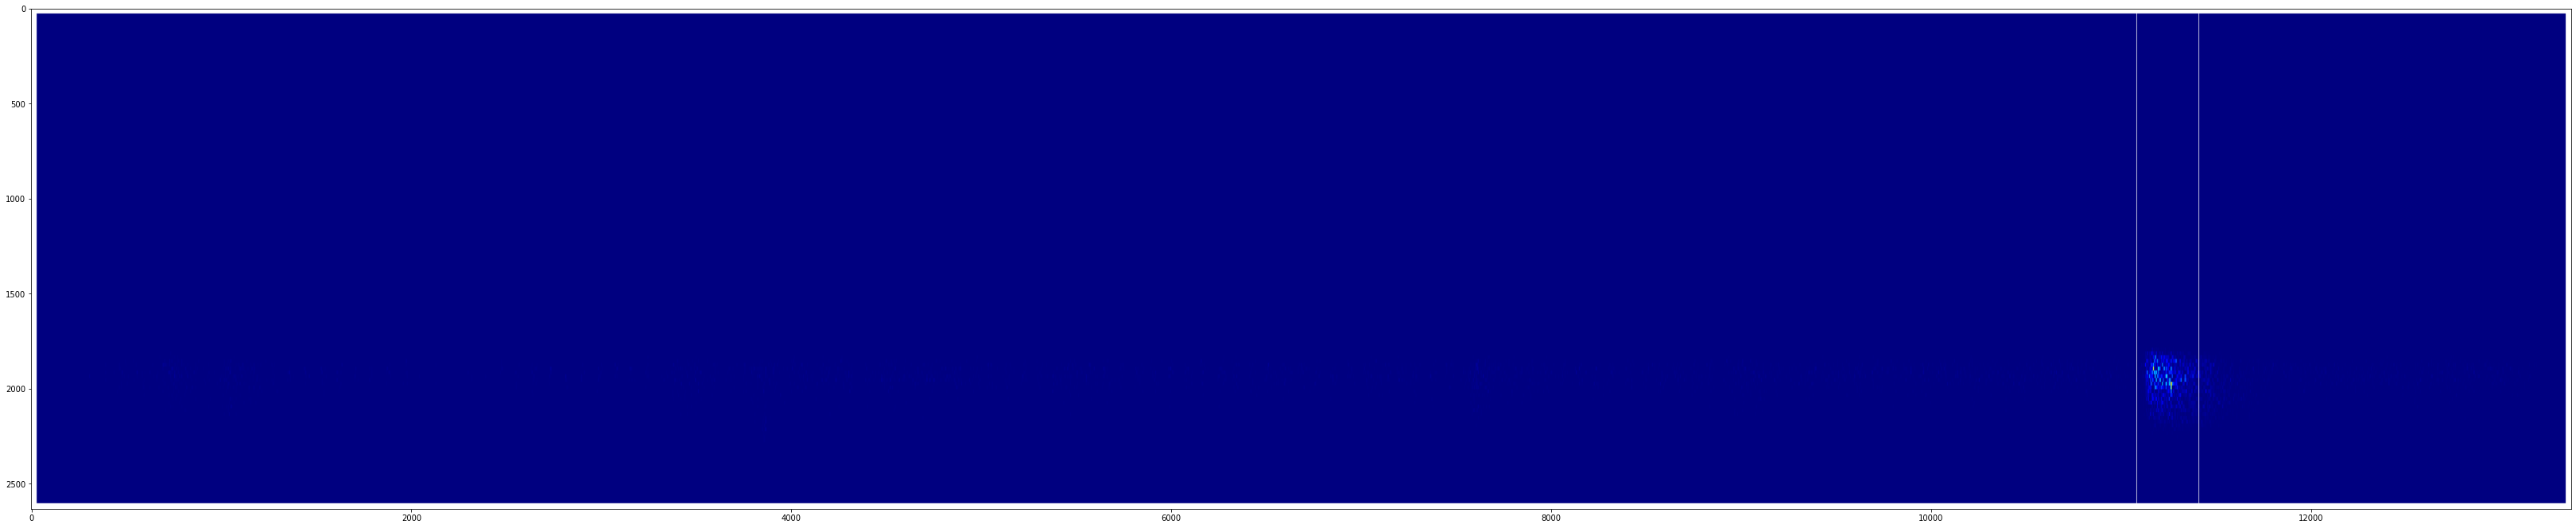

71621.4240935831 71819.851


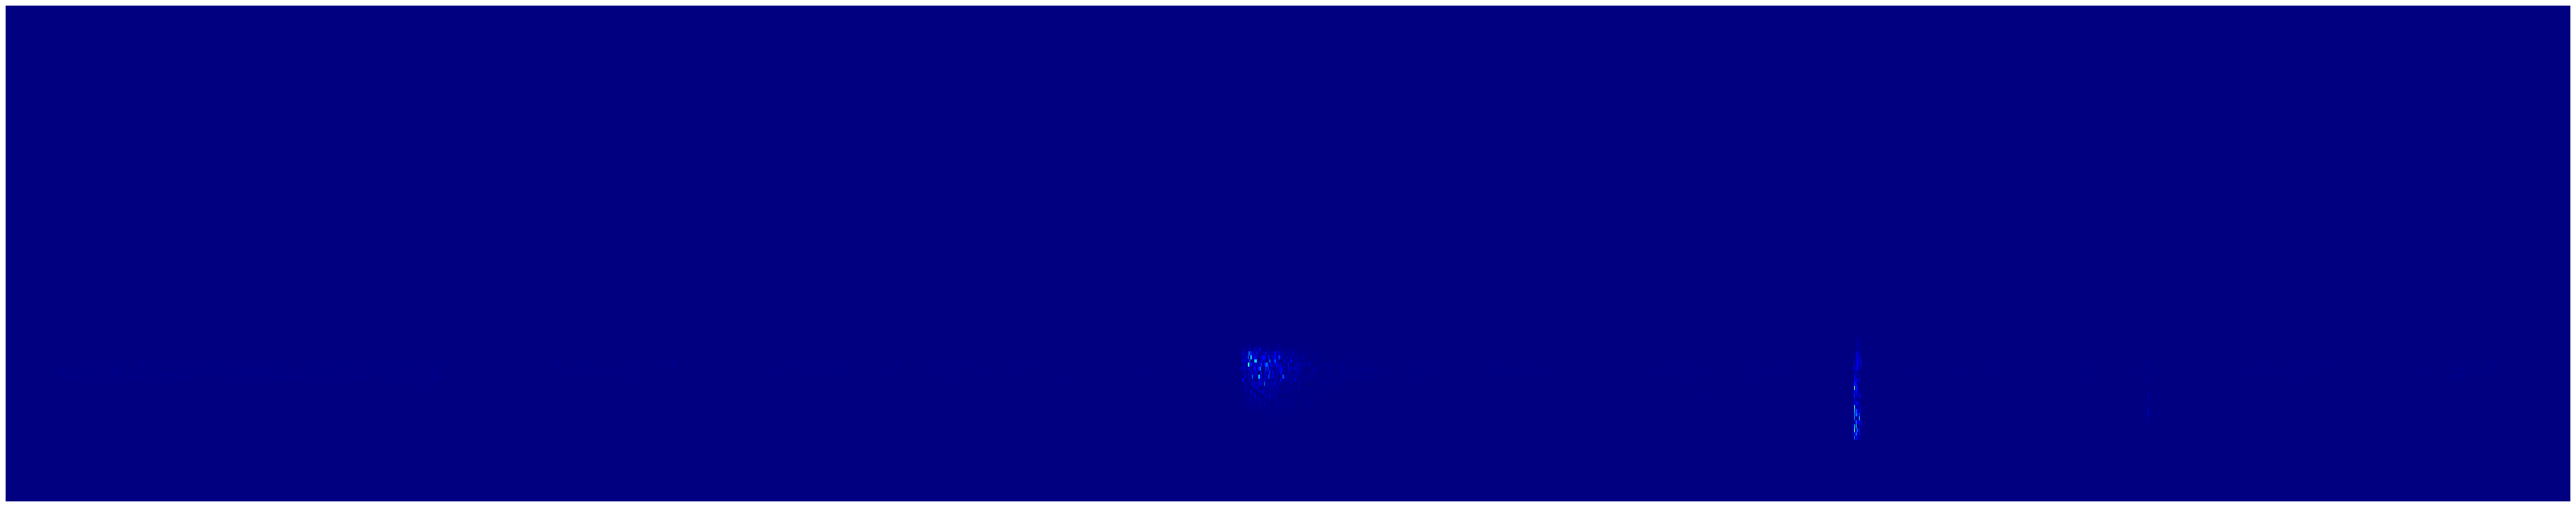

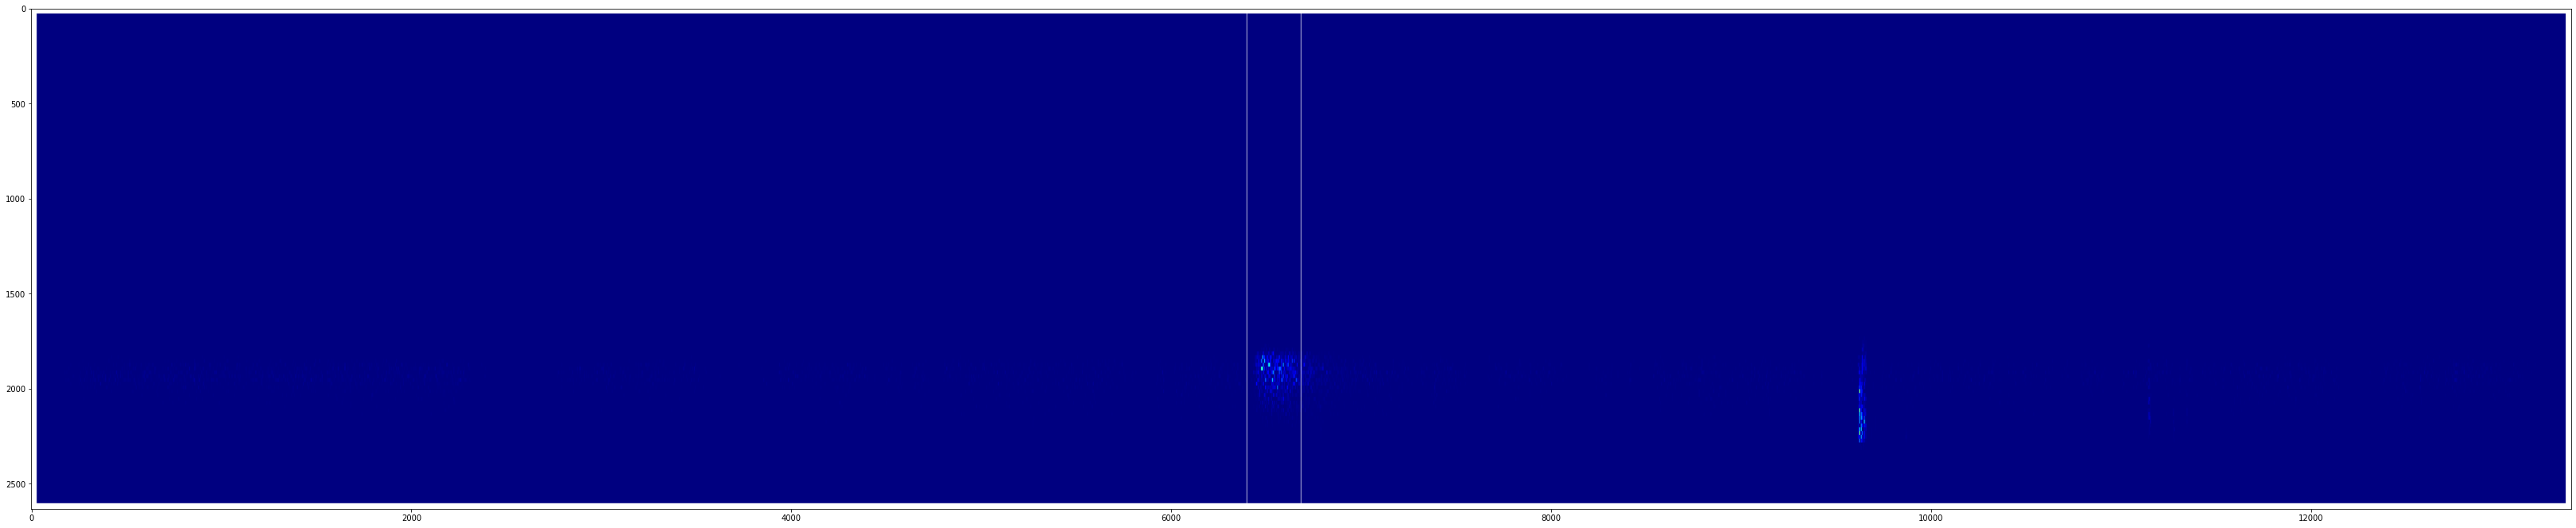

41352.89863712837 41459.496


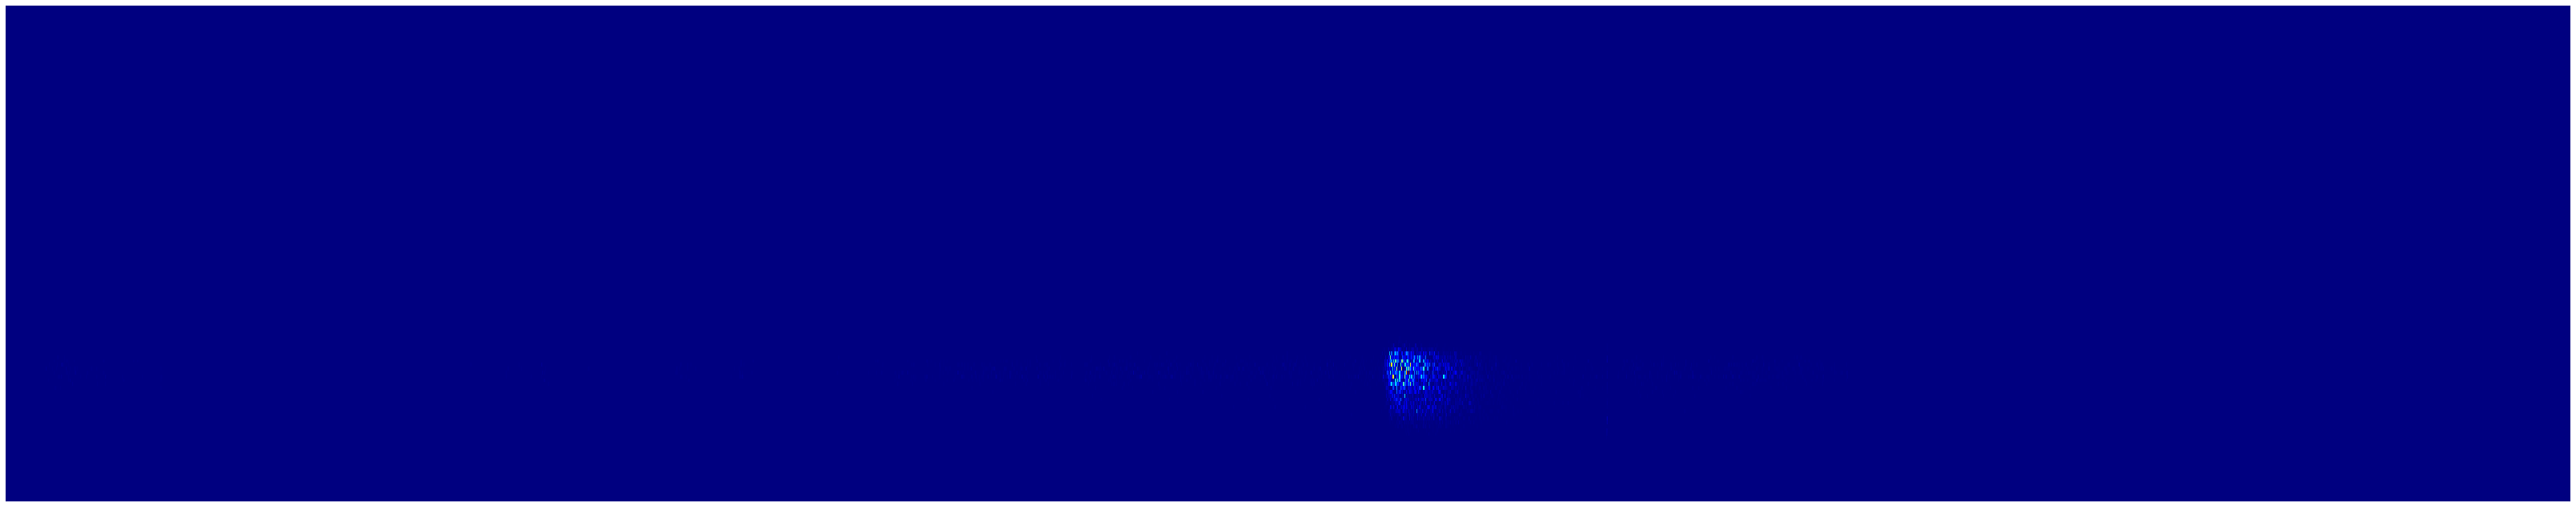

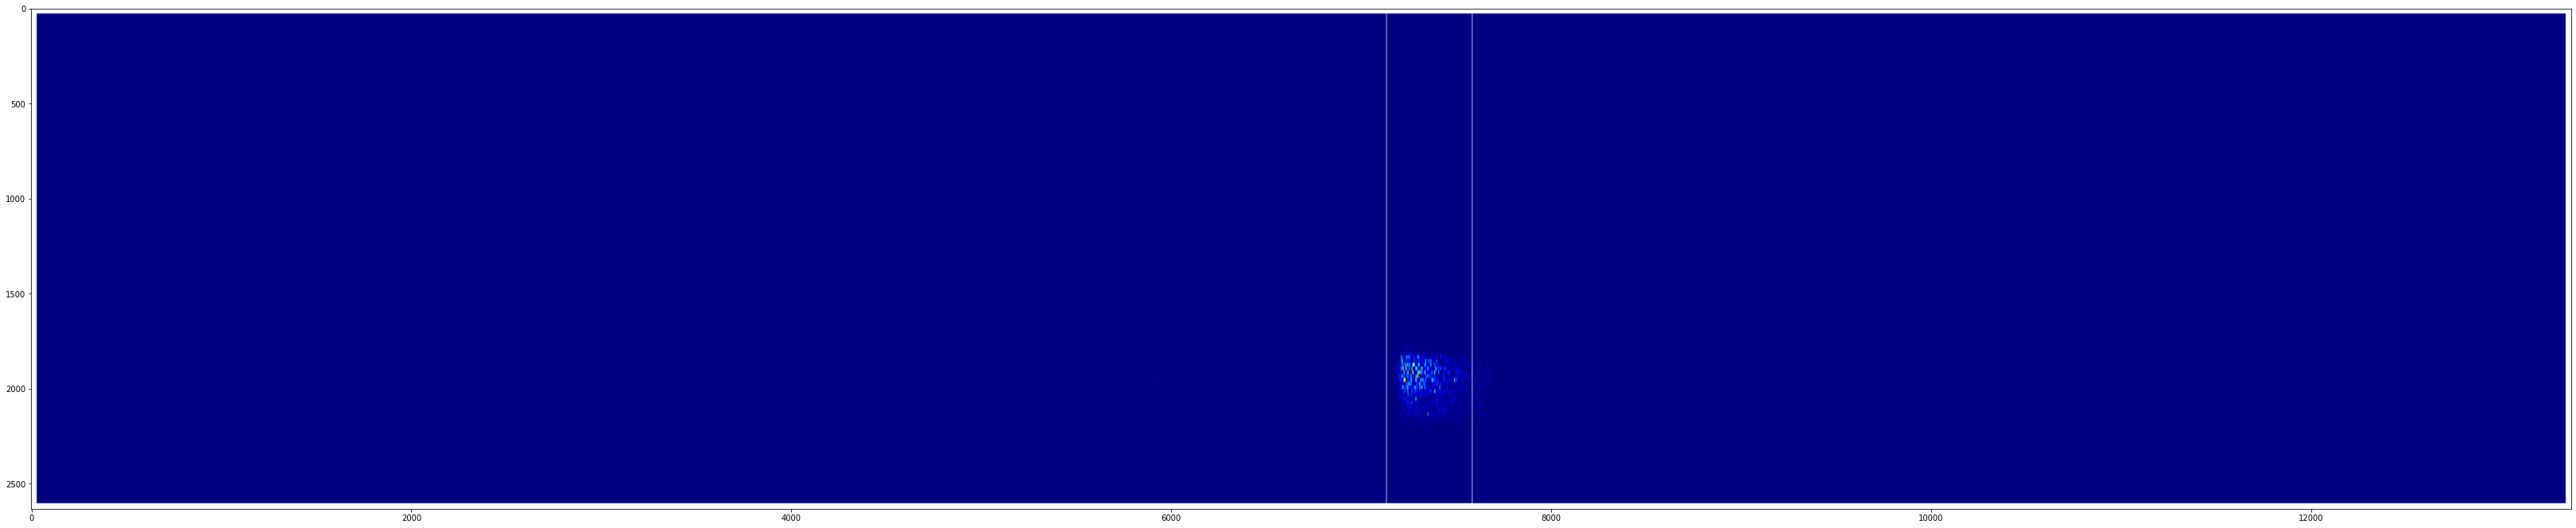

46102.78028070413 46199.3


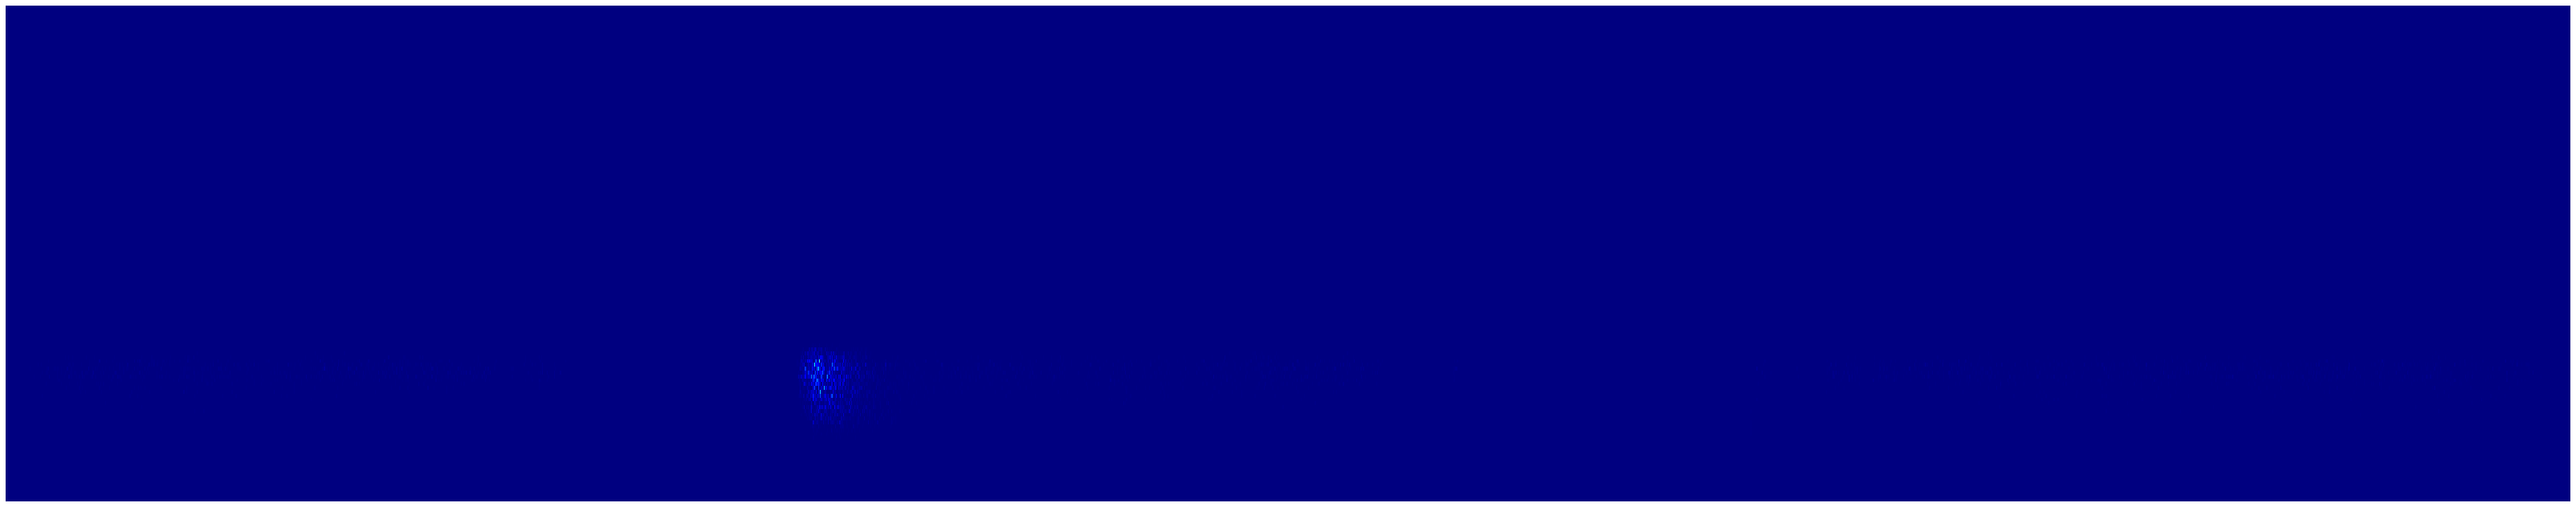

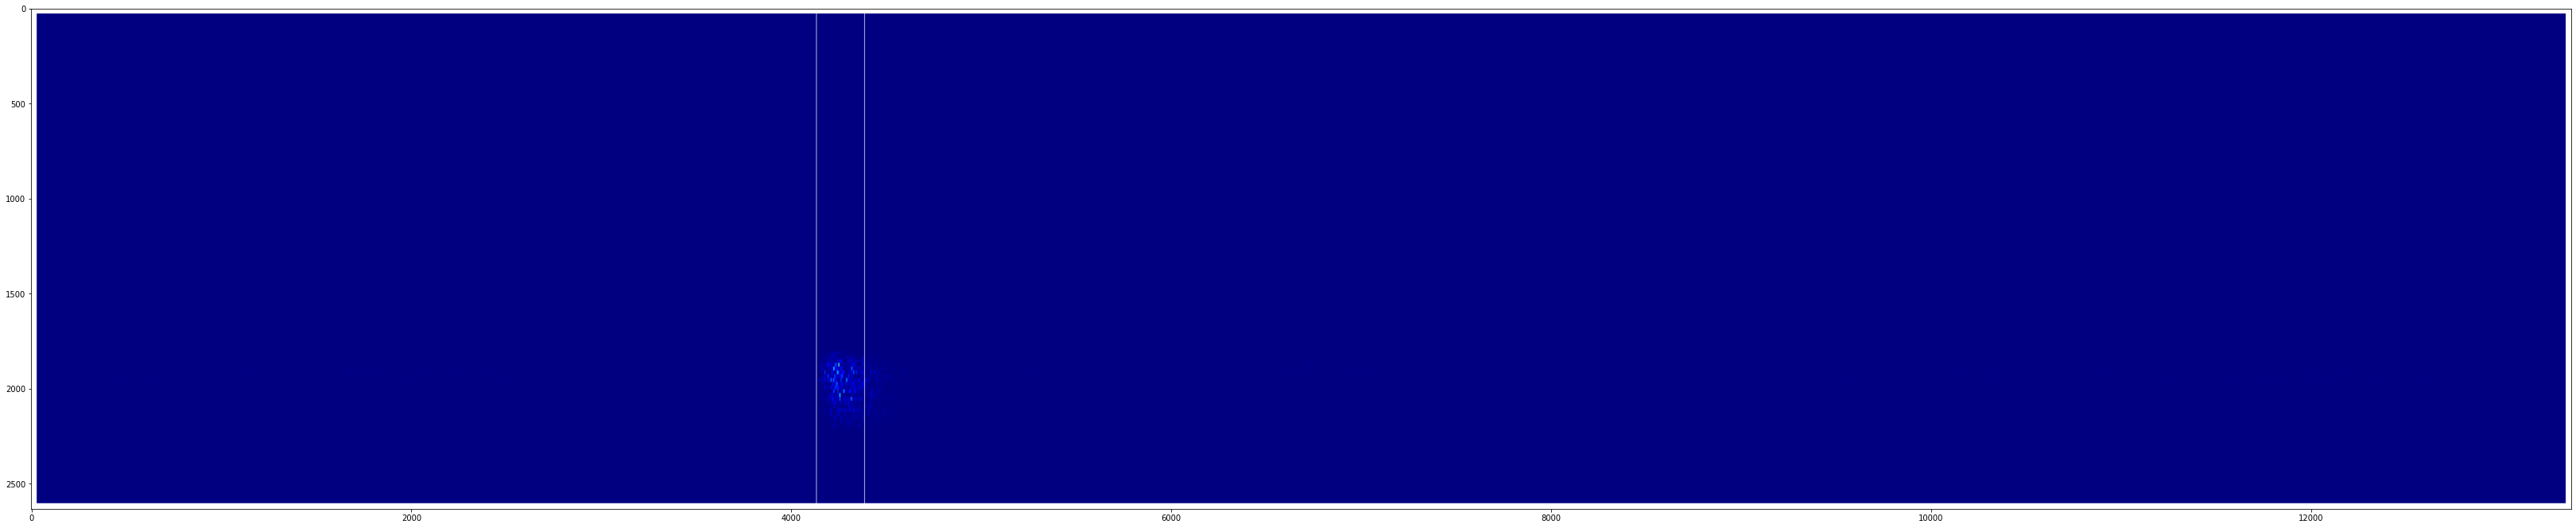

26713.04113455958 26519.674


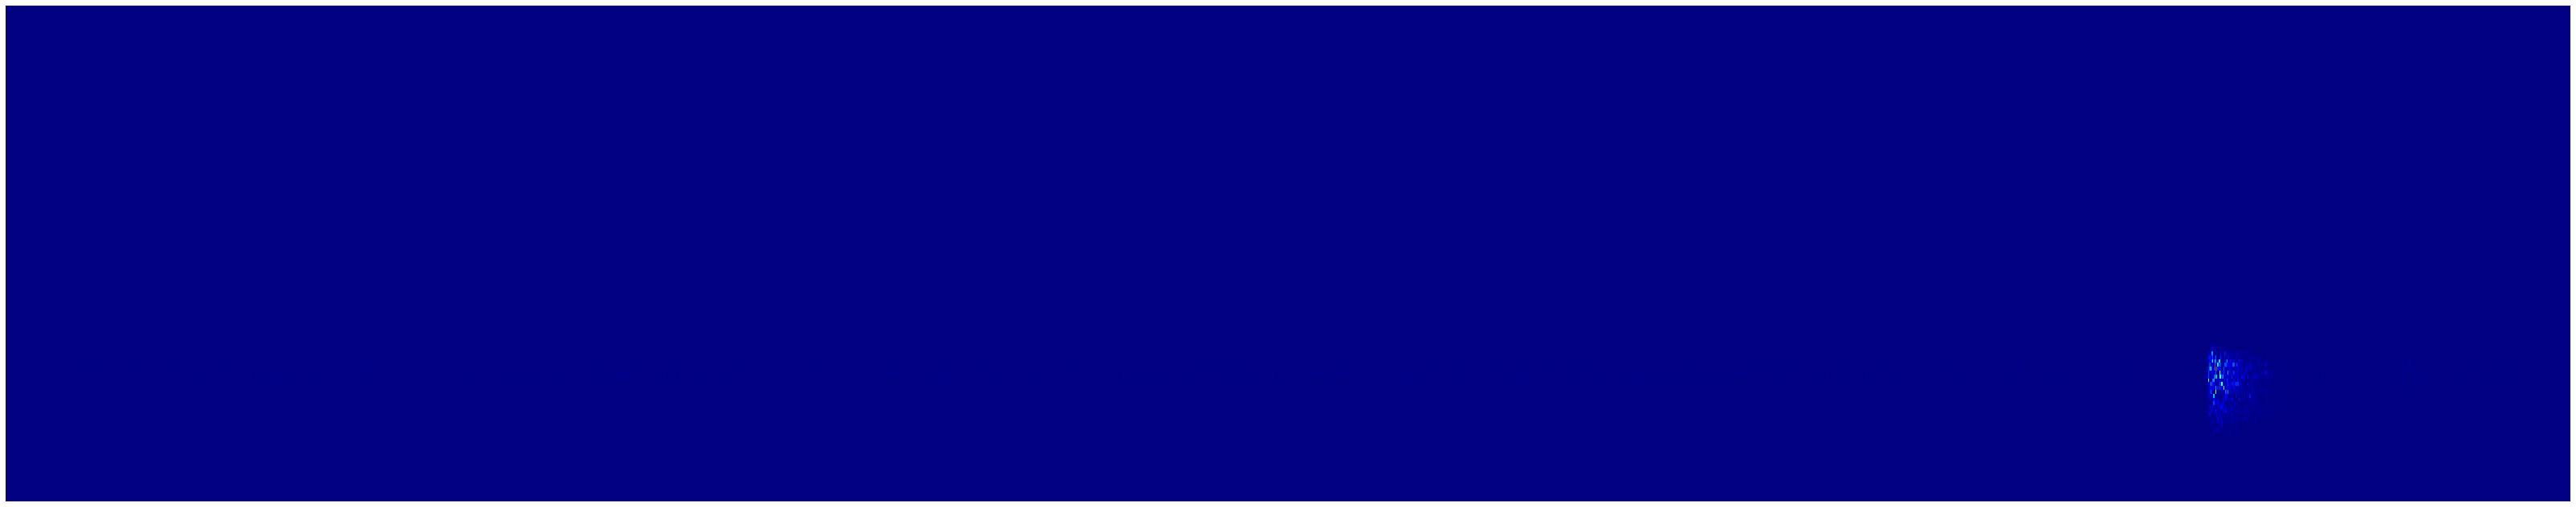

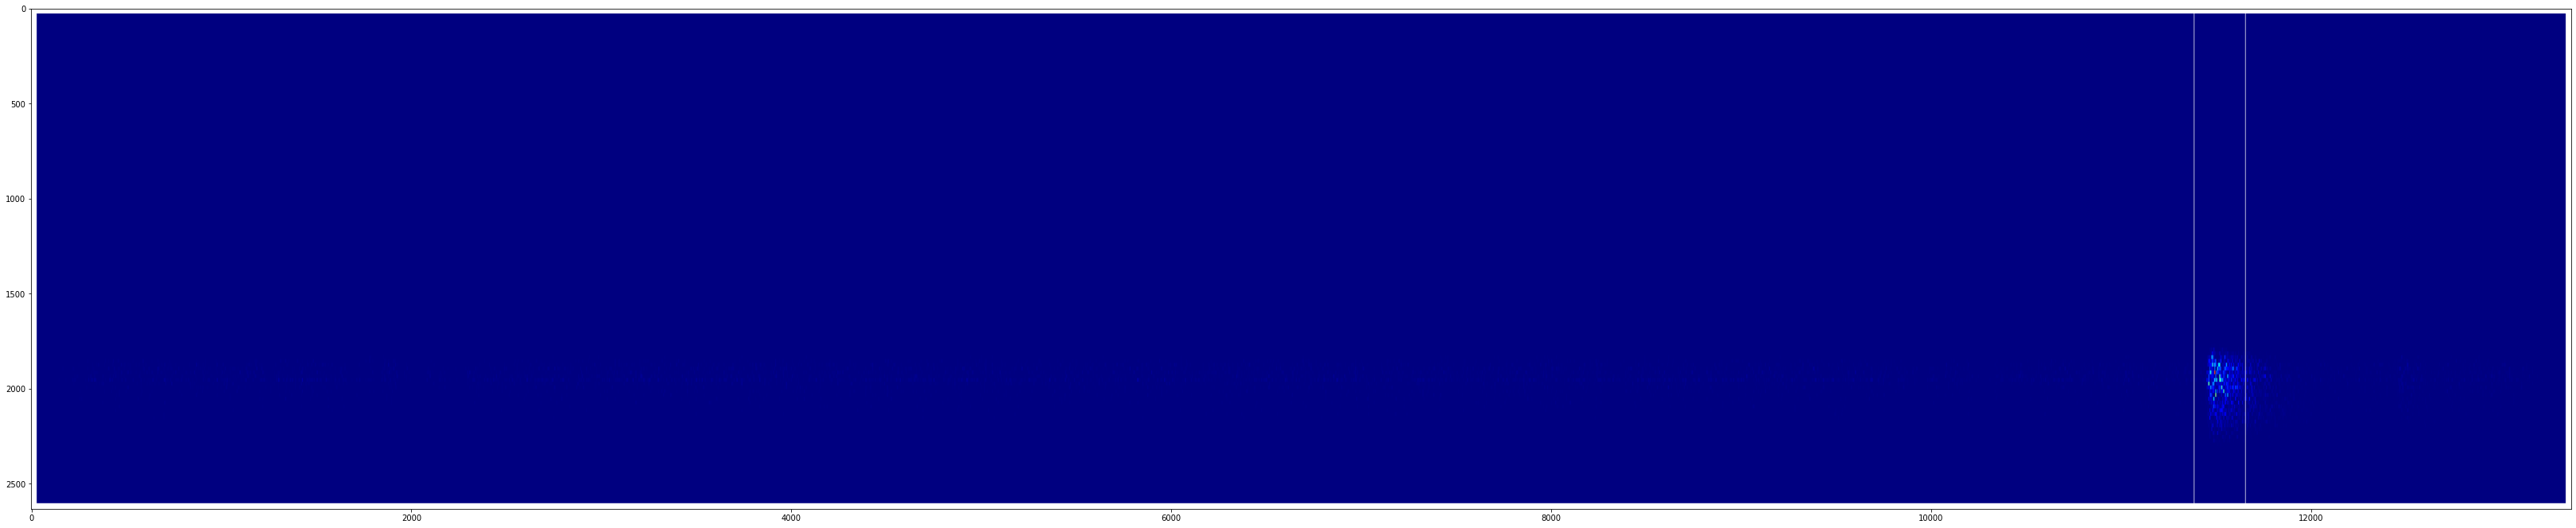

73573.3842123686 74039.483


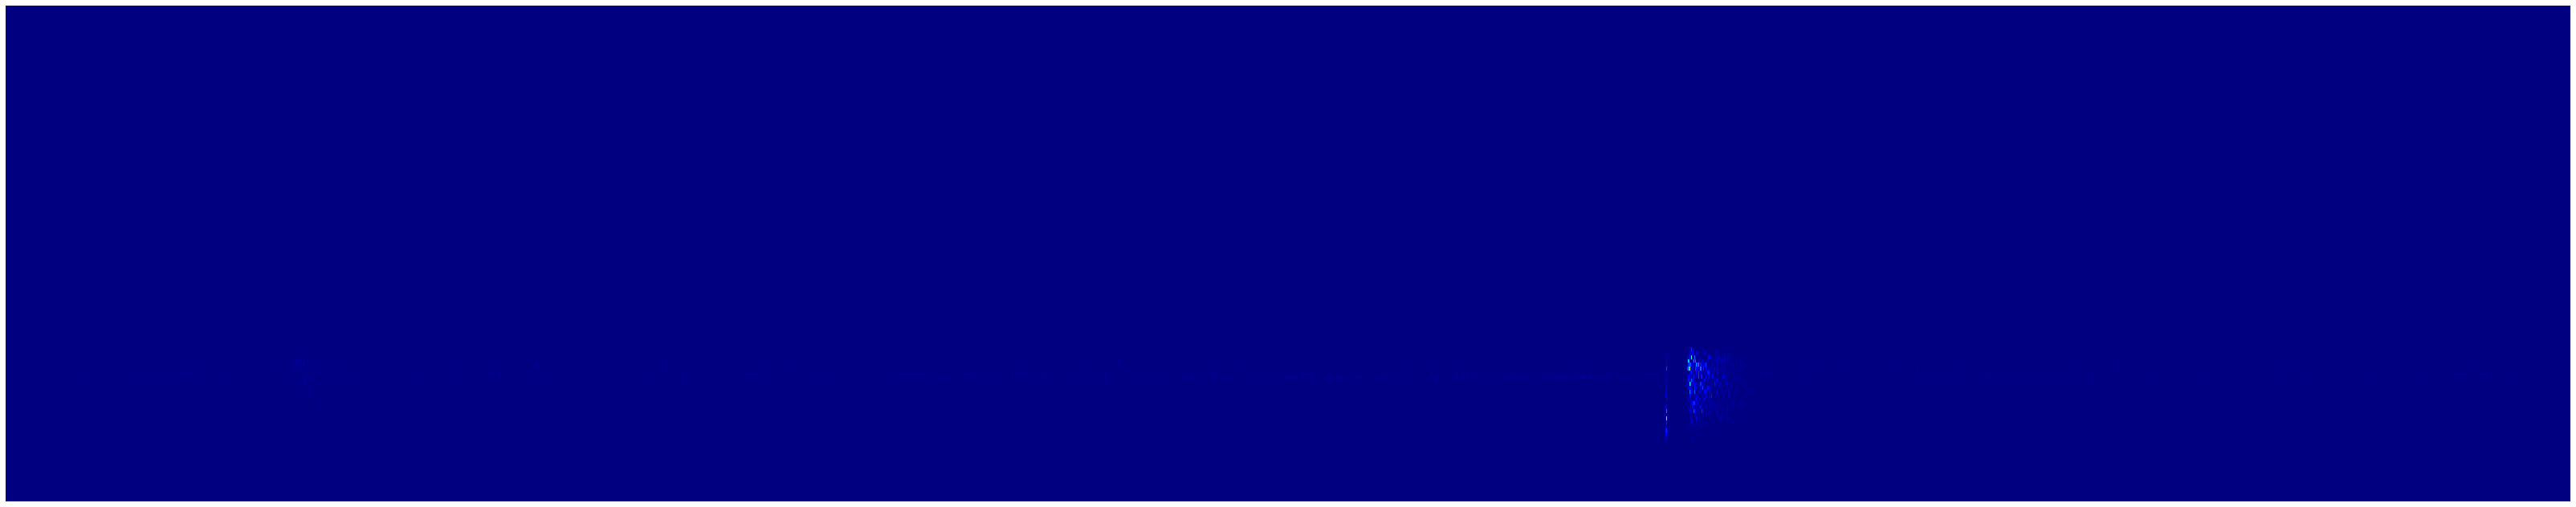

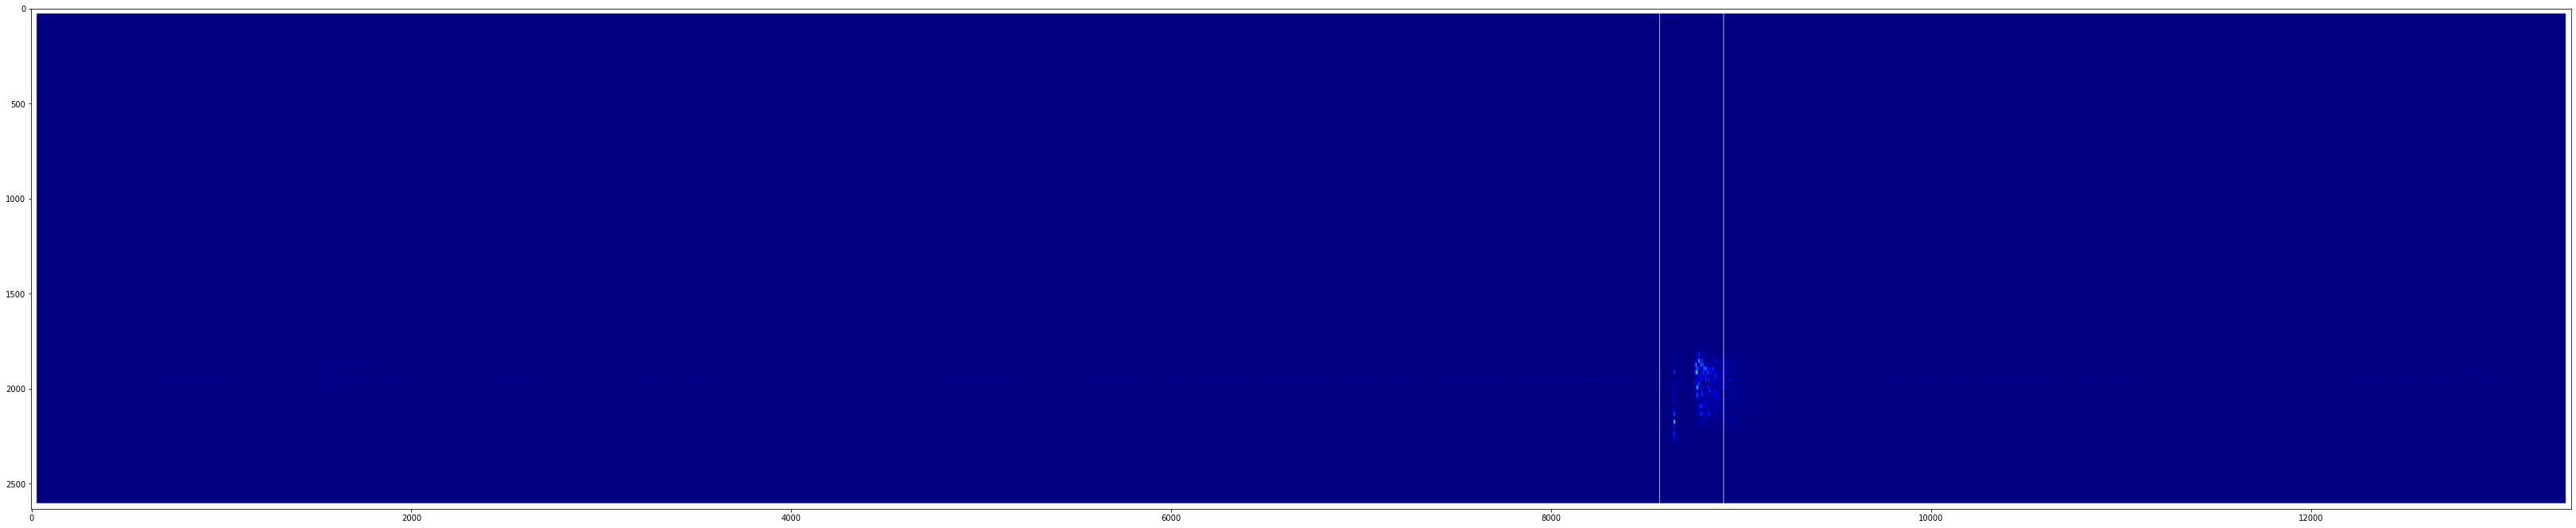

55390.55474633876 56459.661


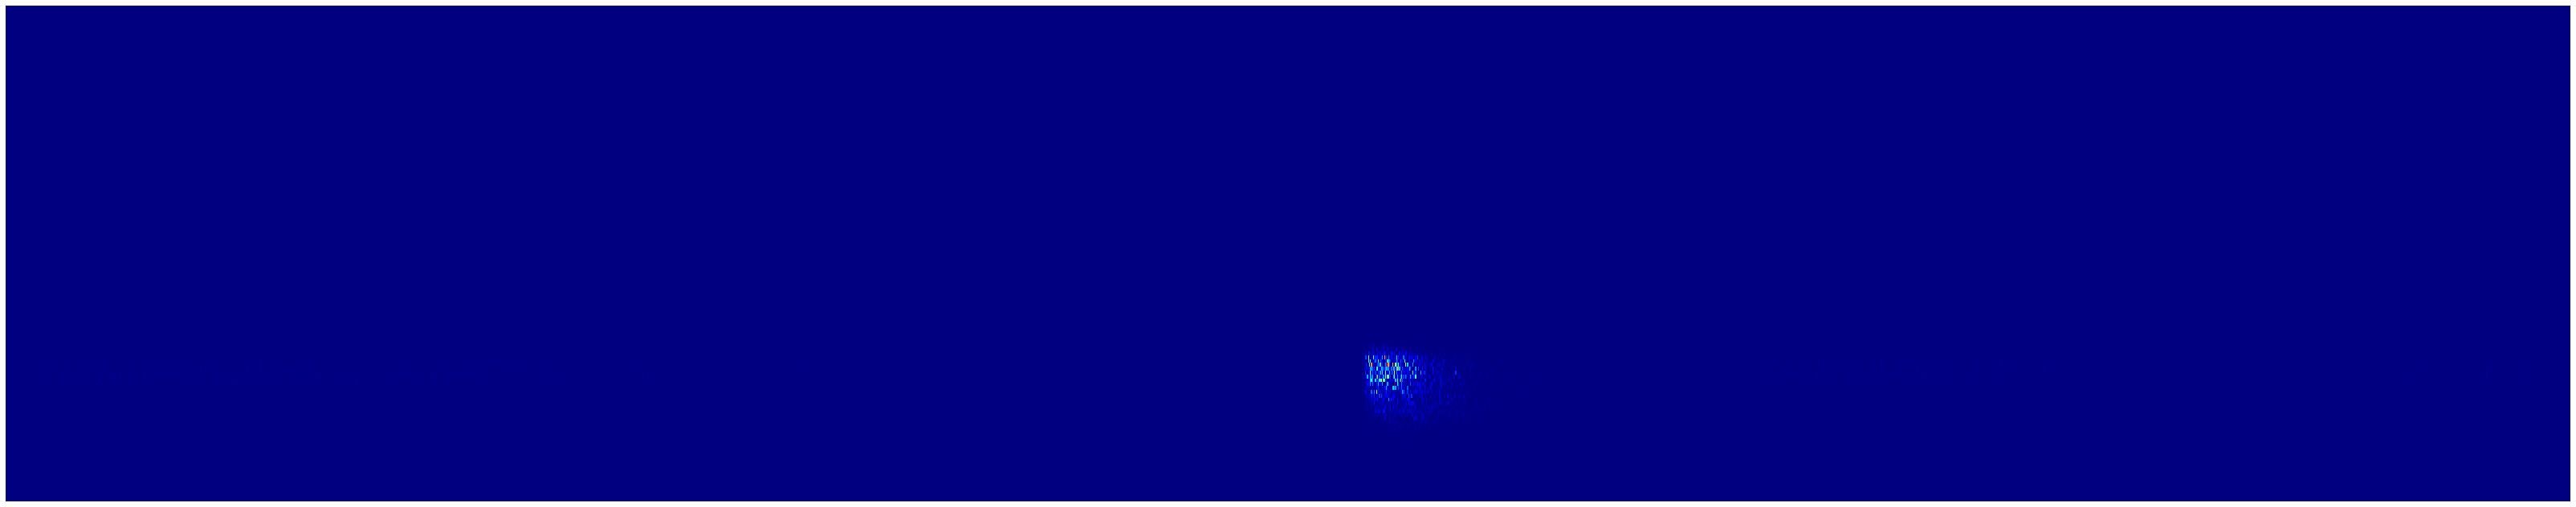

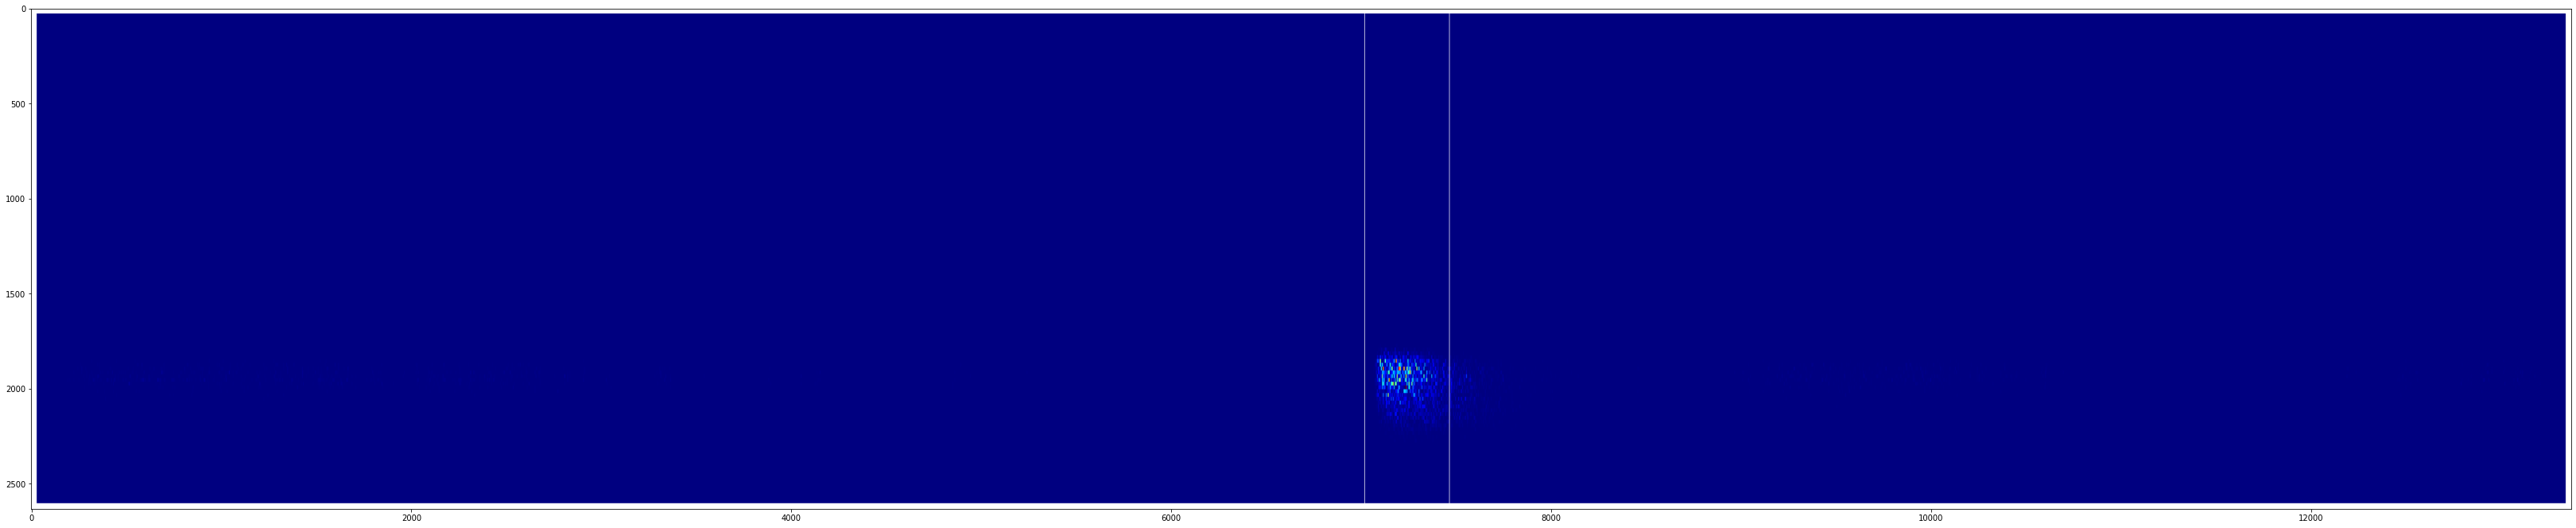

45359.49979110915 45599.742


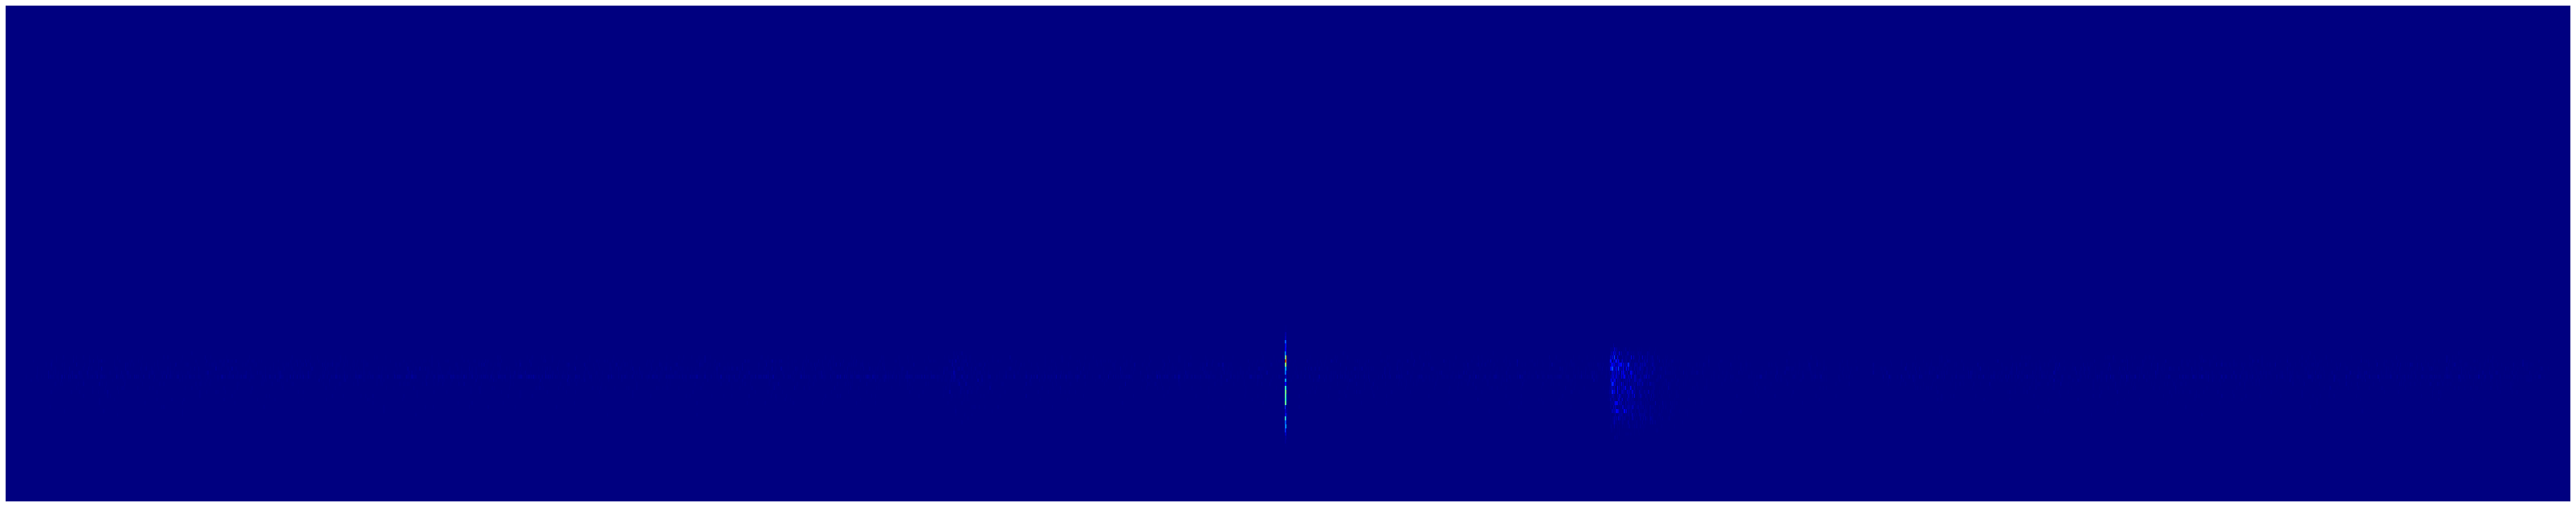

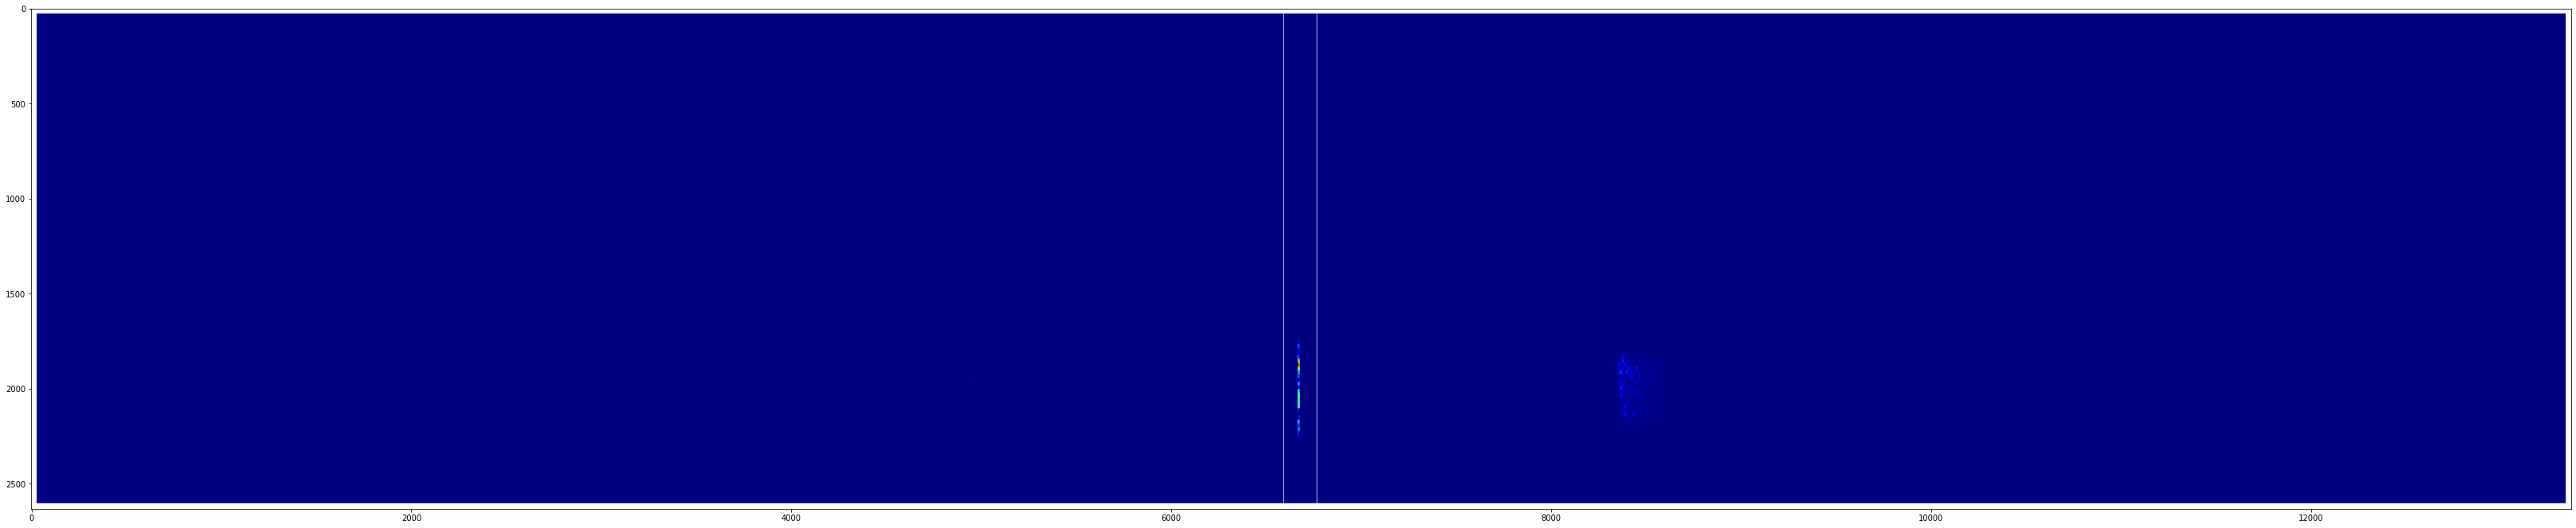

42600.56007587819 53939.766


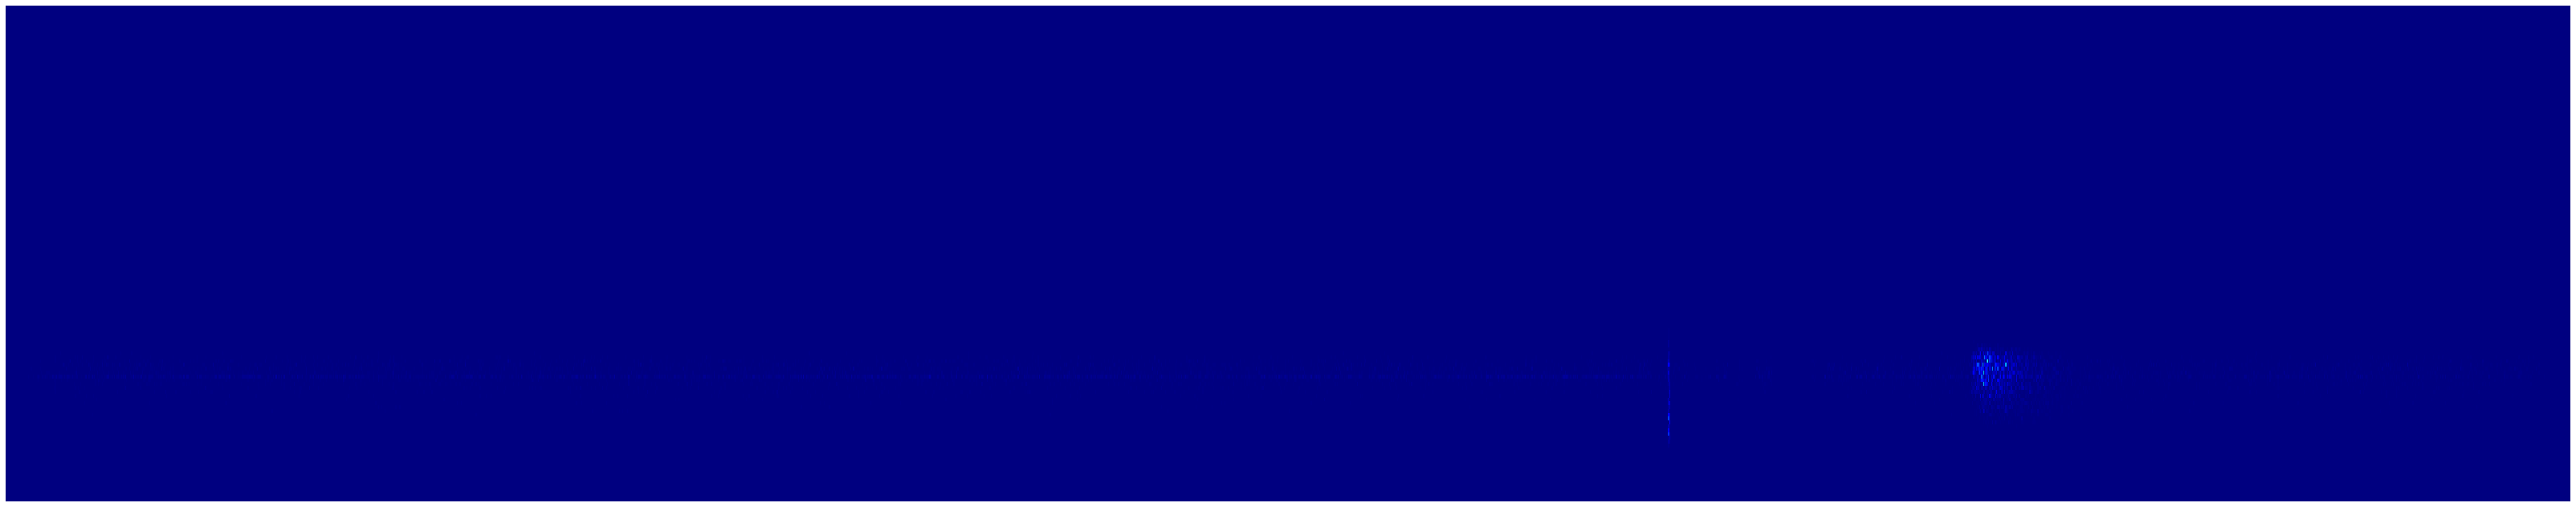

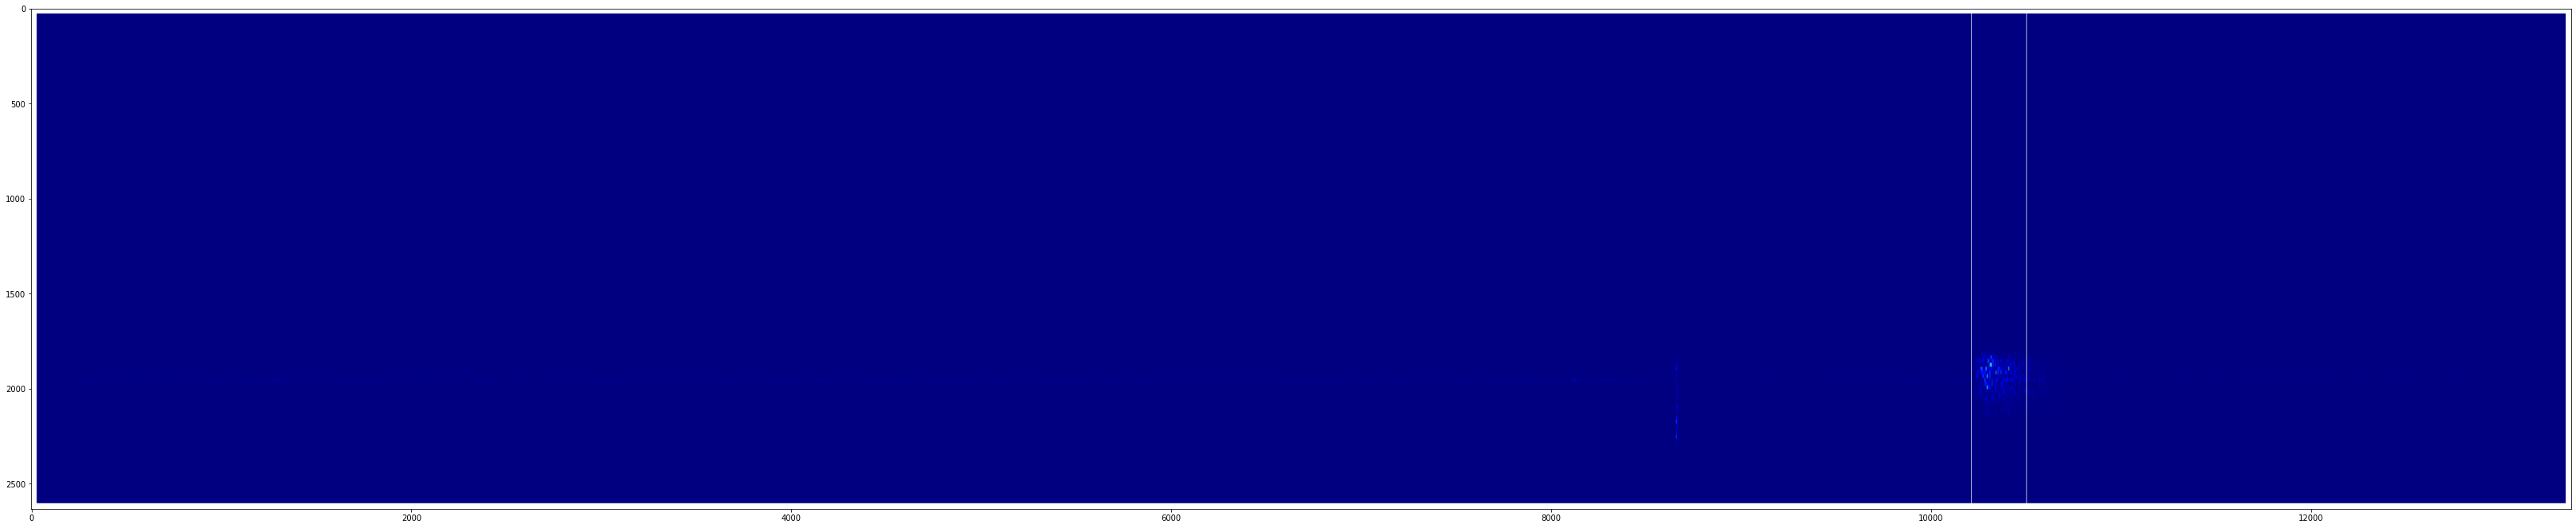

65998.22772489641 66059.806


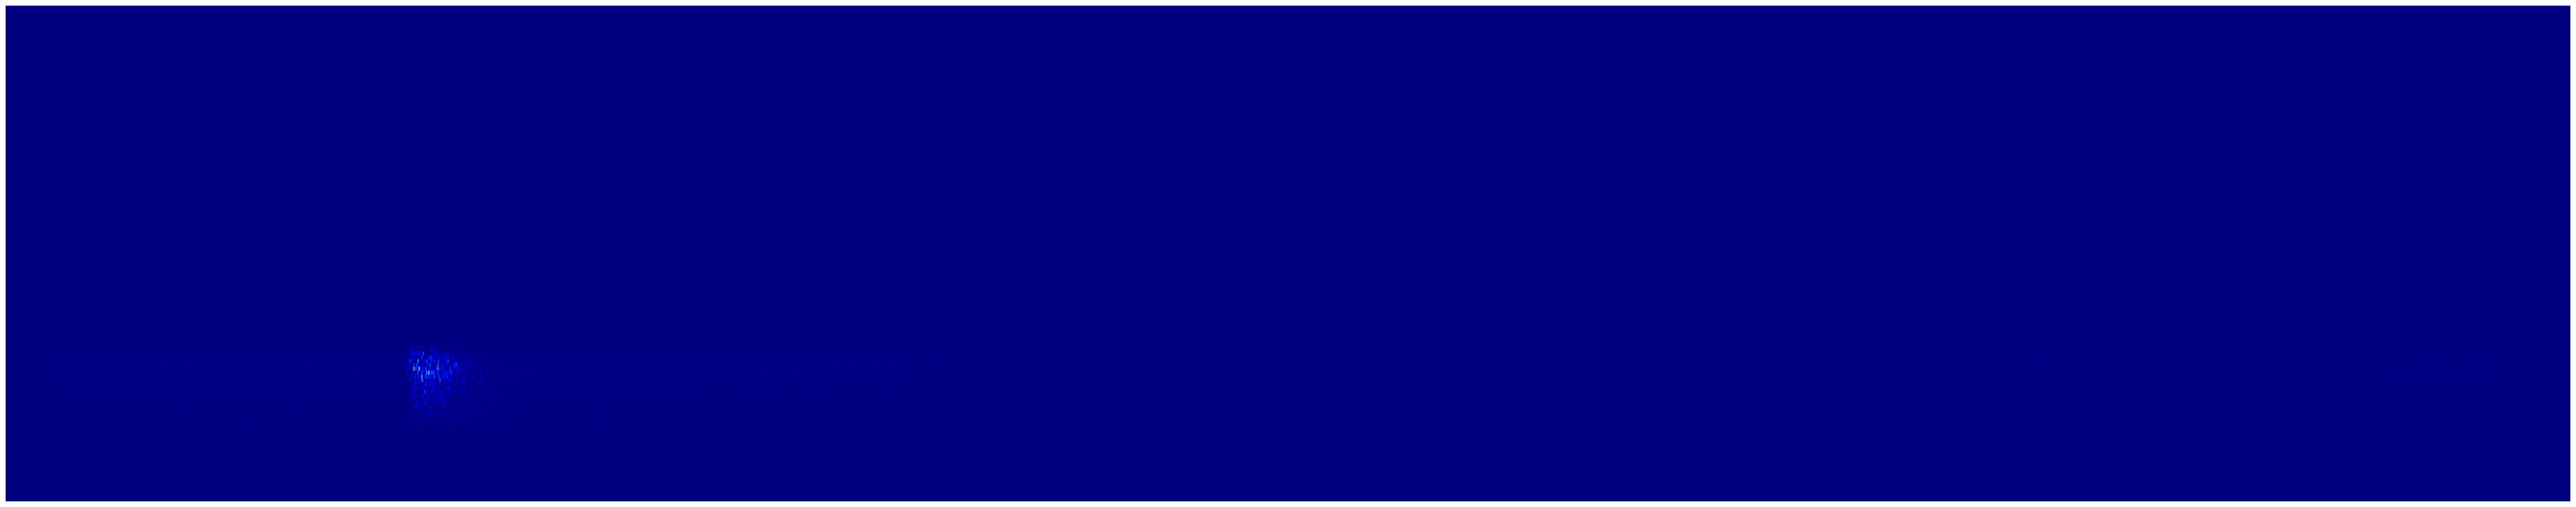

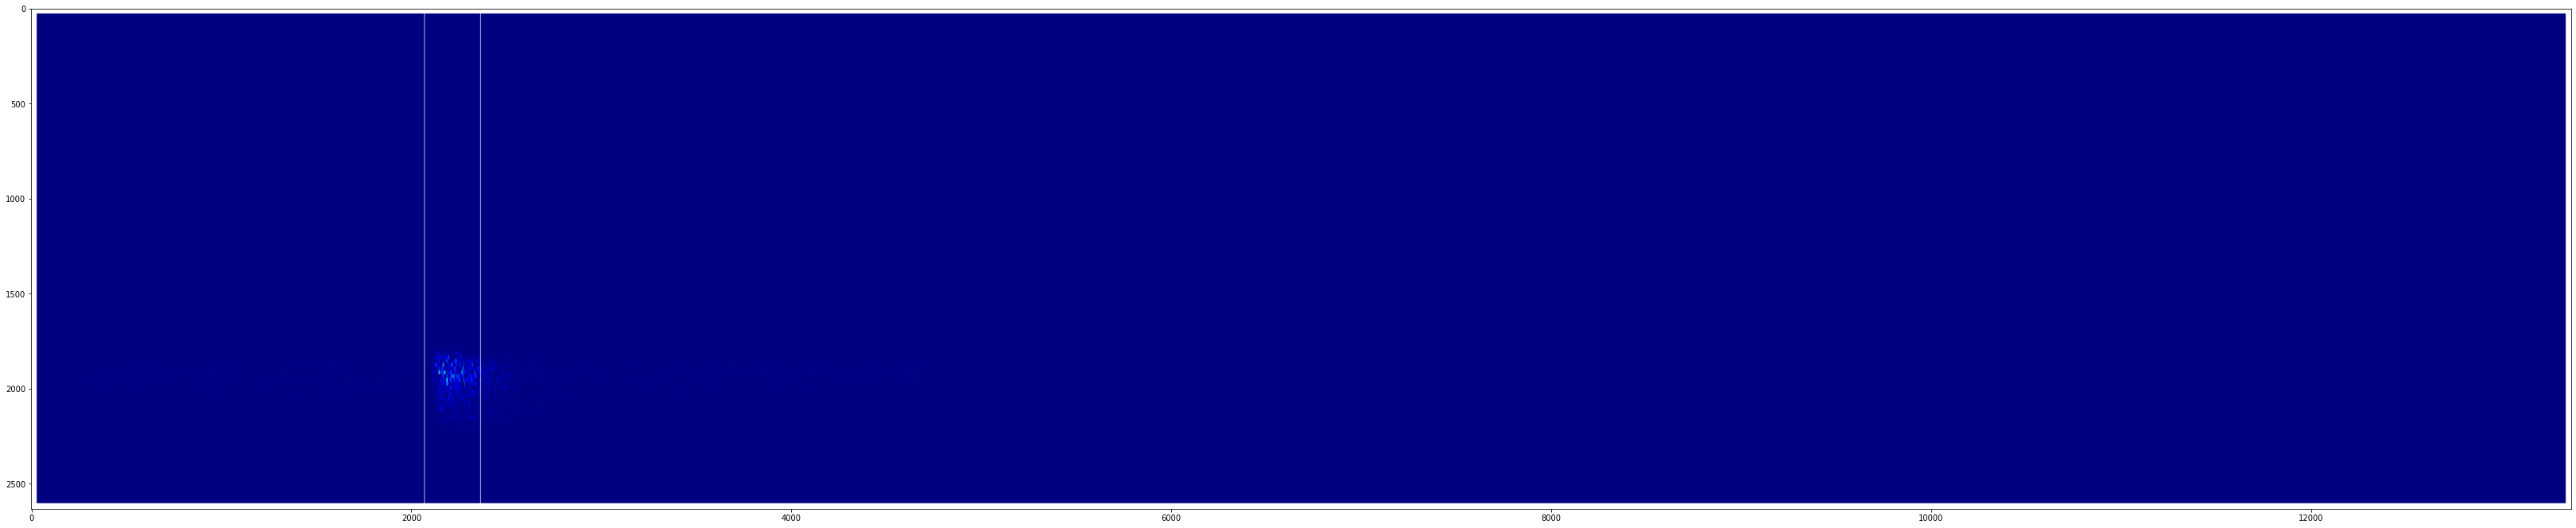

13379.048812709596 13319.821


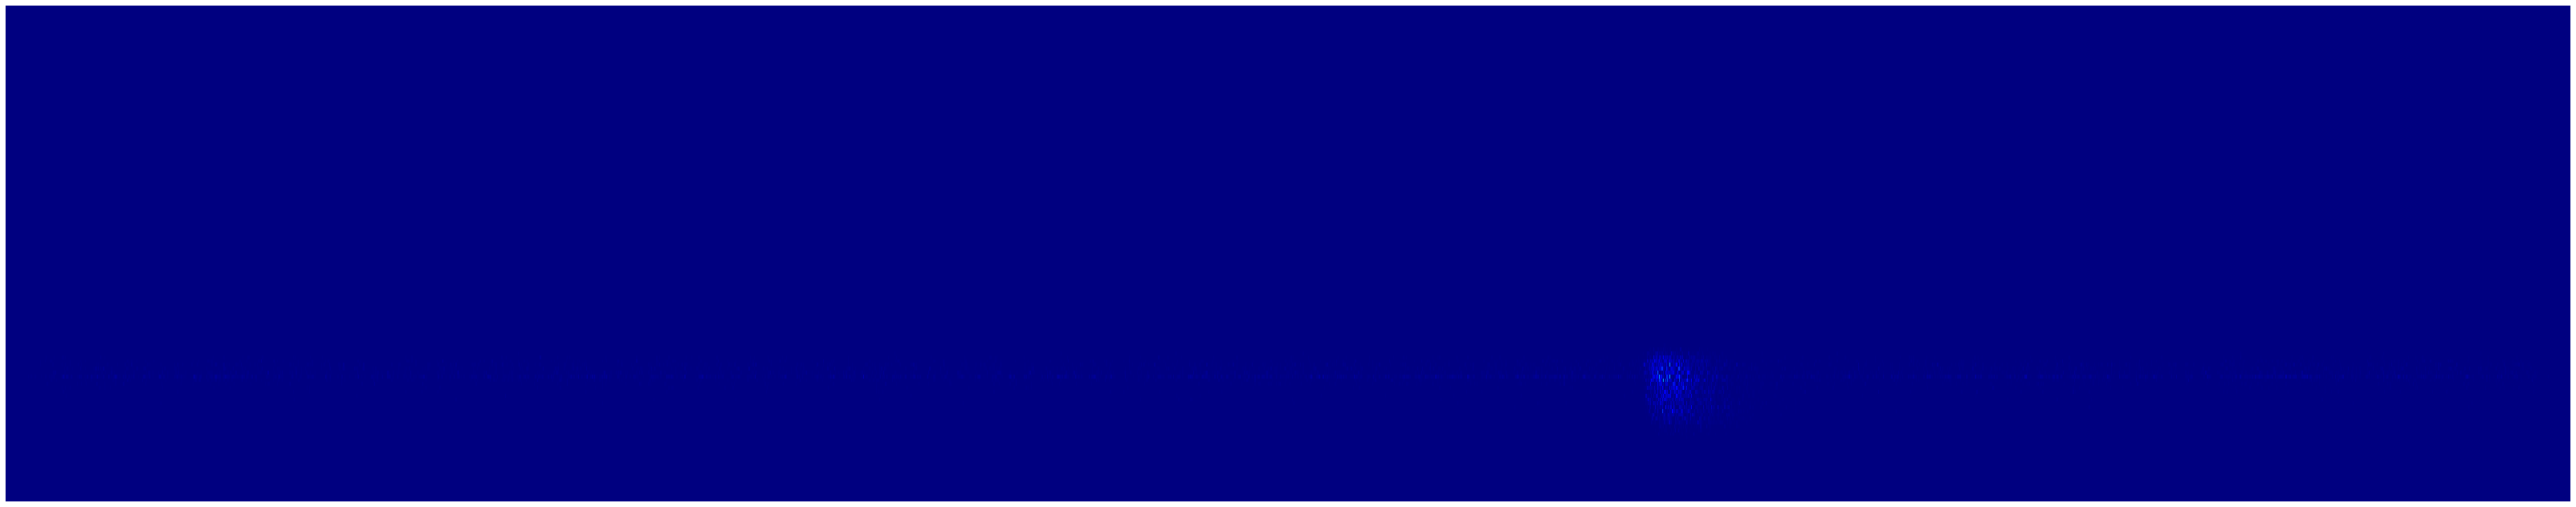

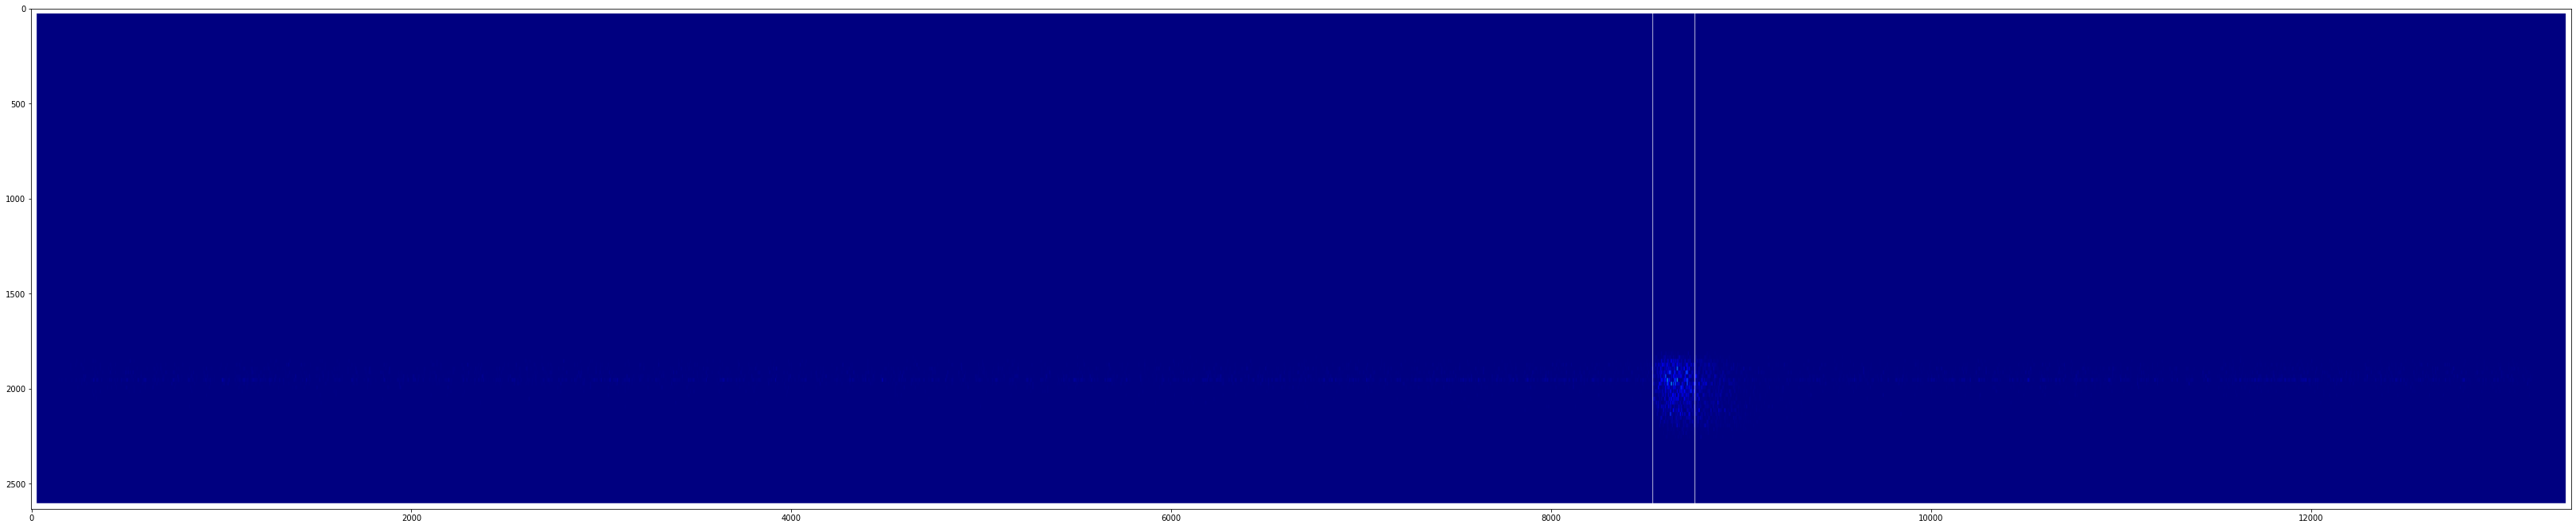

55159.41740907603 55079.849
file ./data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR00_evid00029.mseed not found


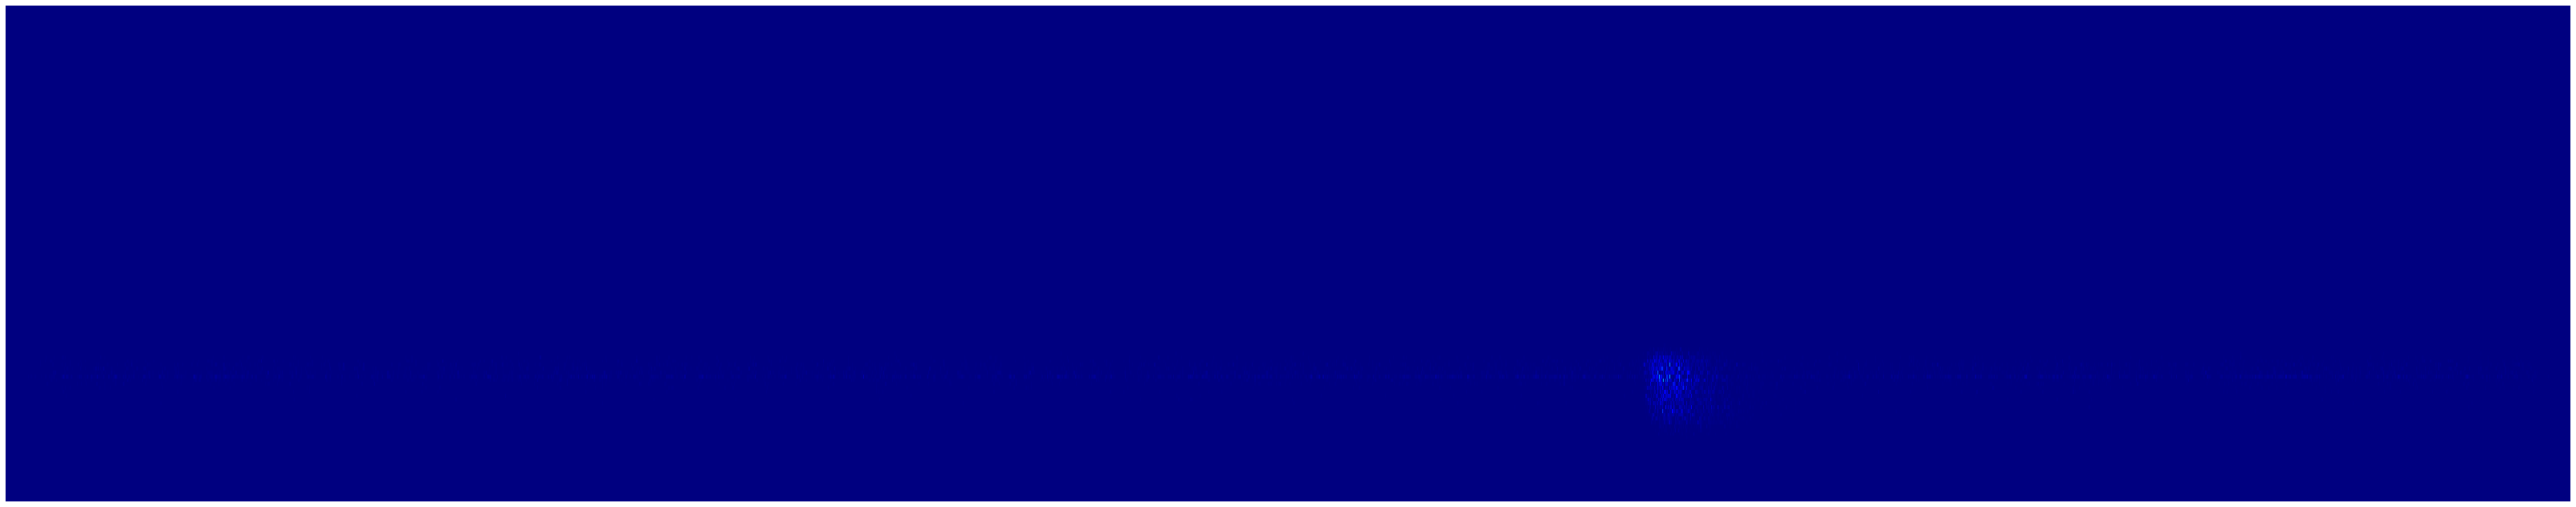

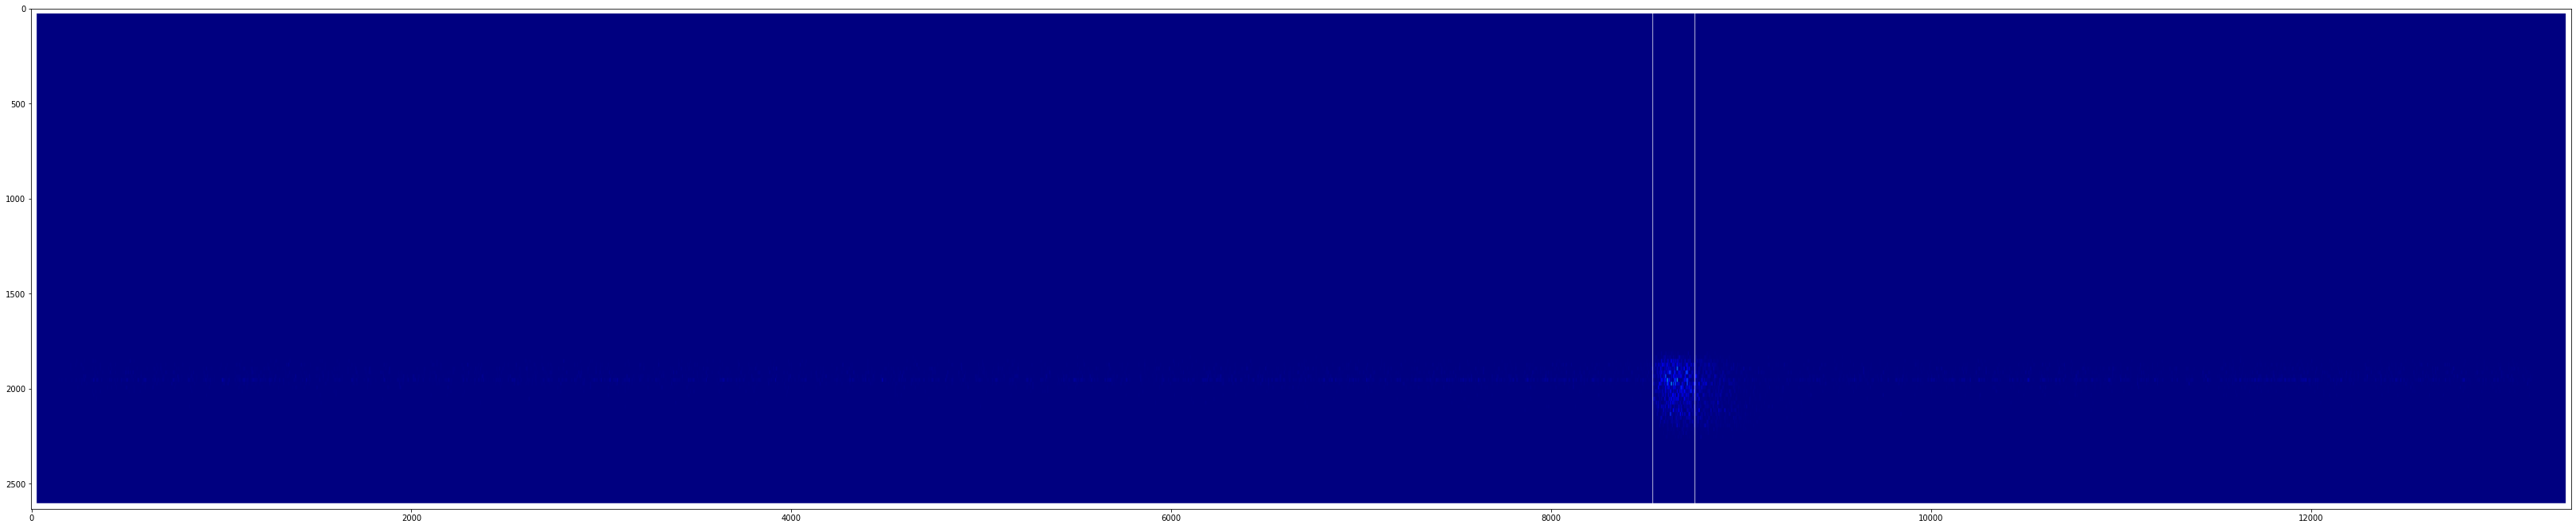

55159.41740907603 1688099.849


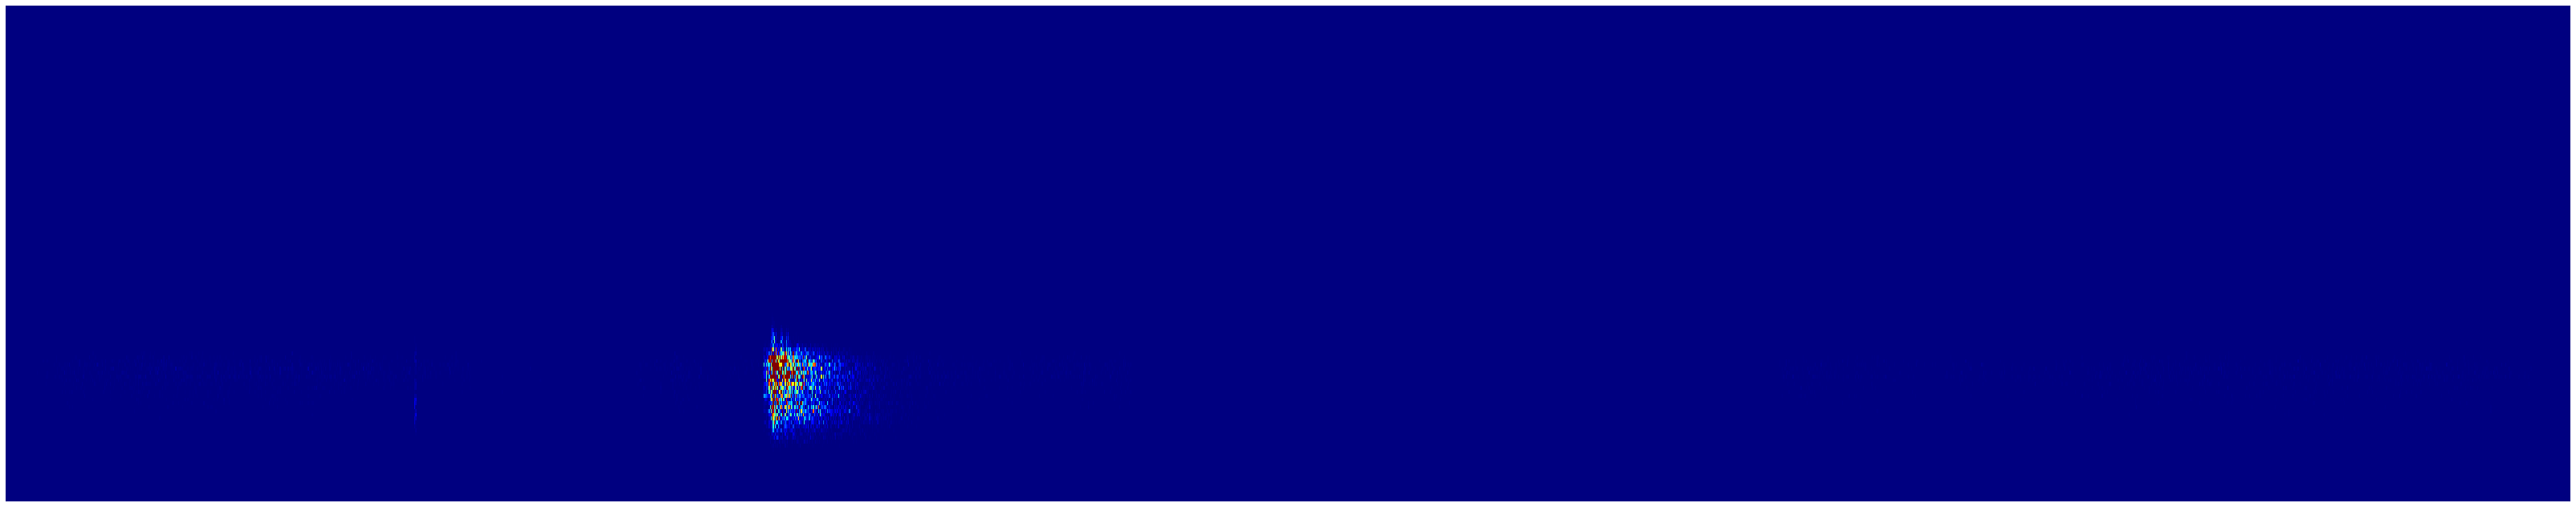

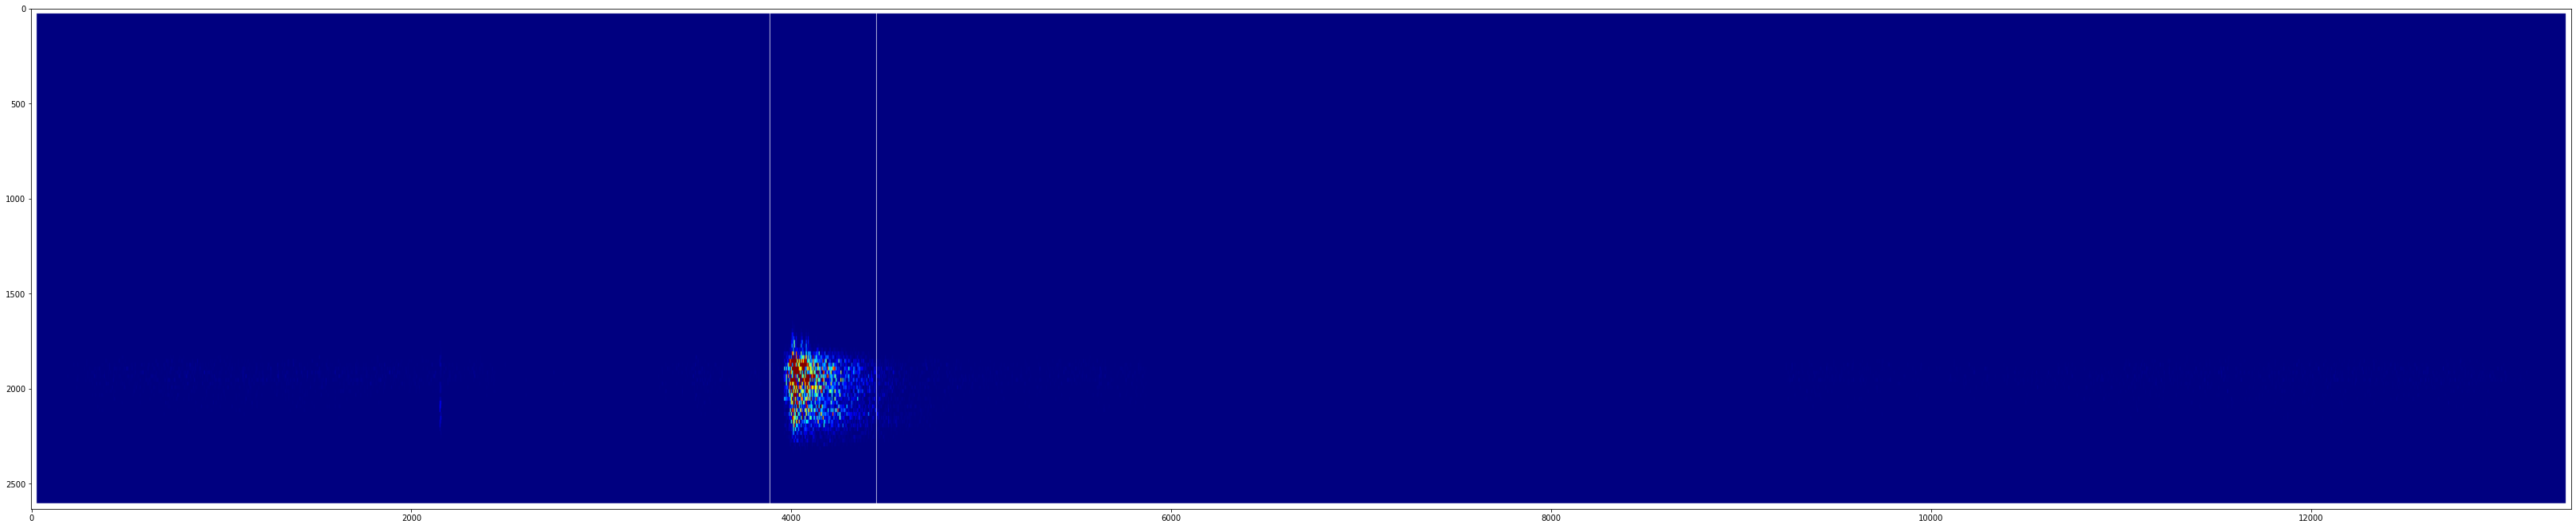

25129.651163578466 25439.613


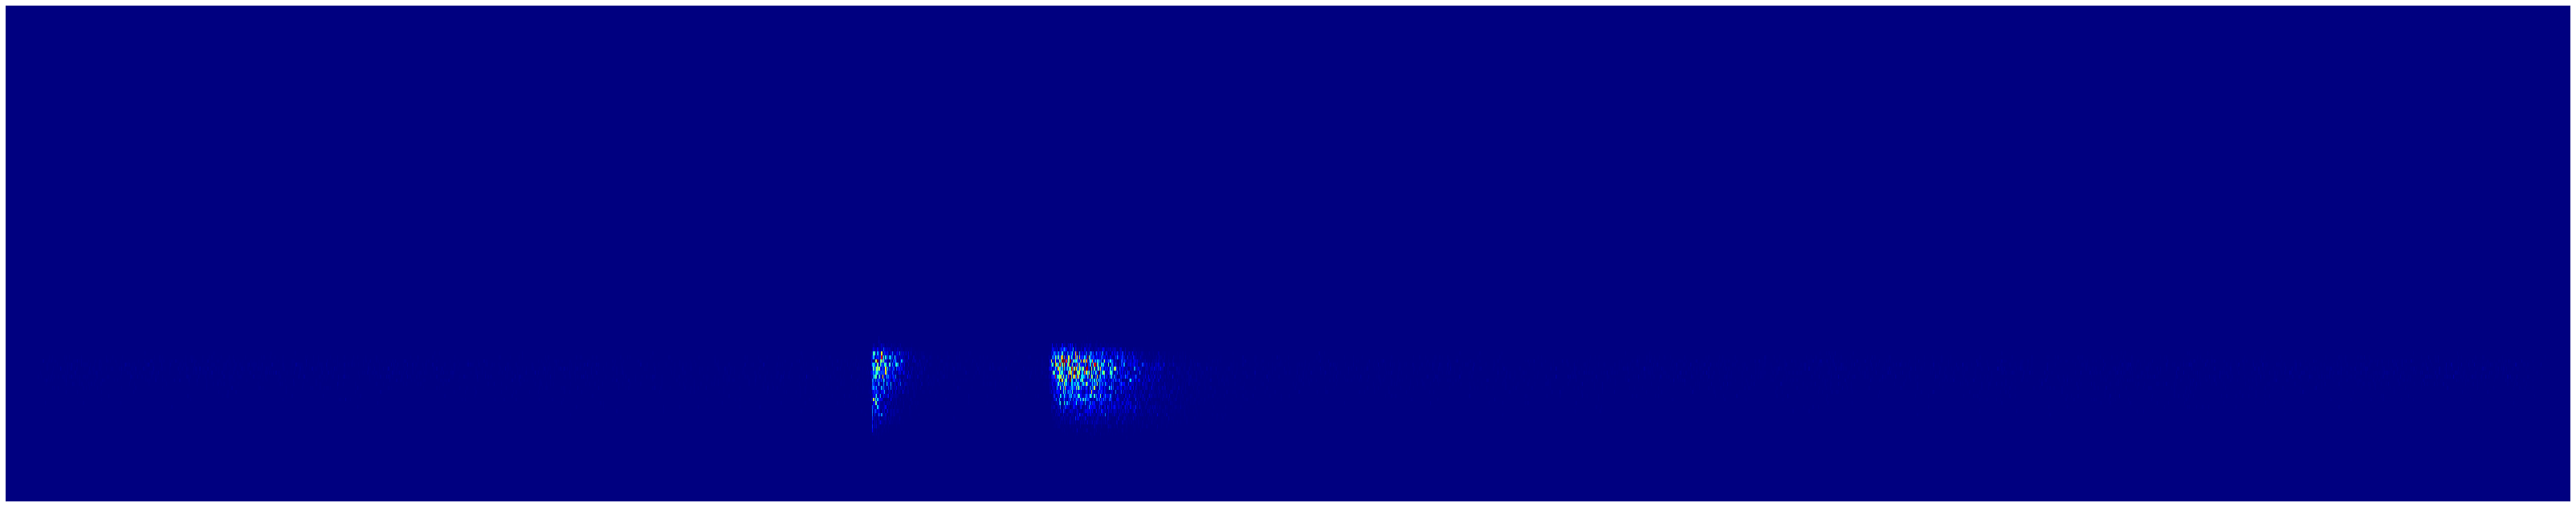

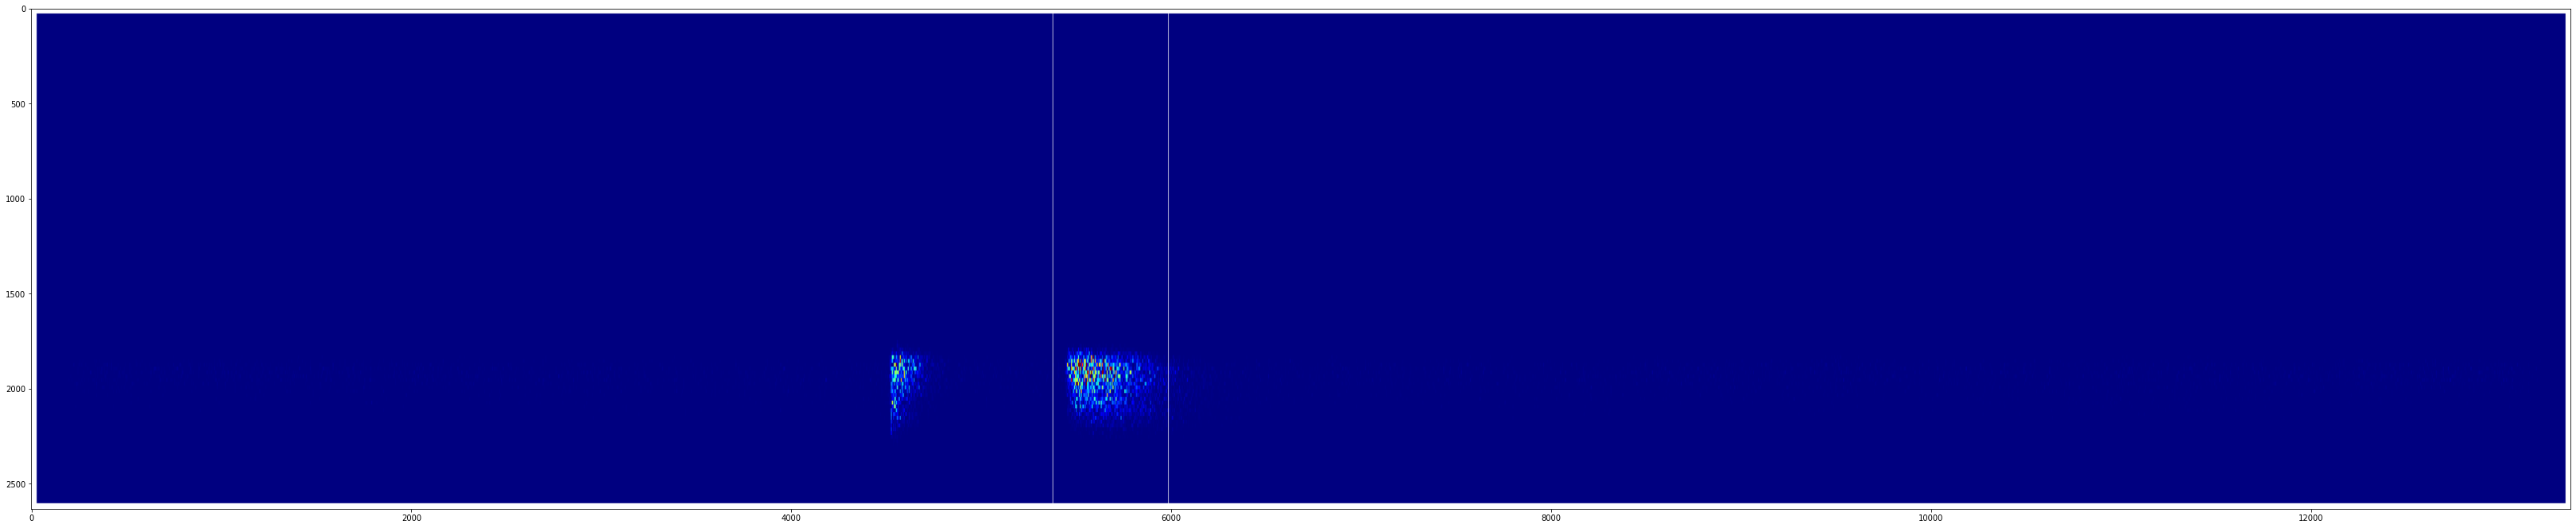

34752.96751465059 29099.288


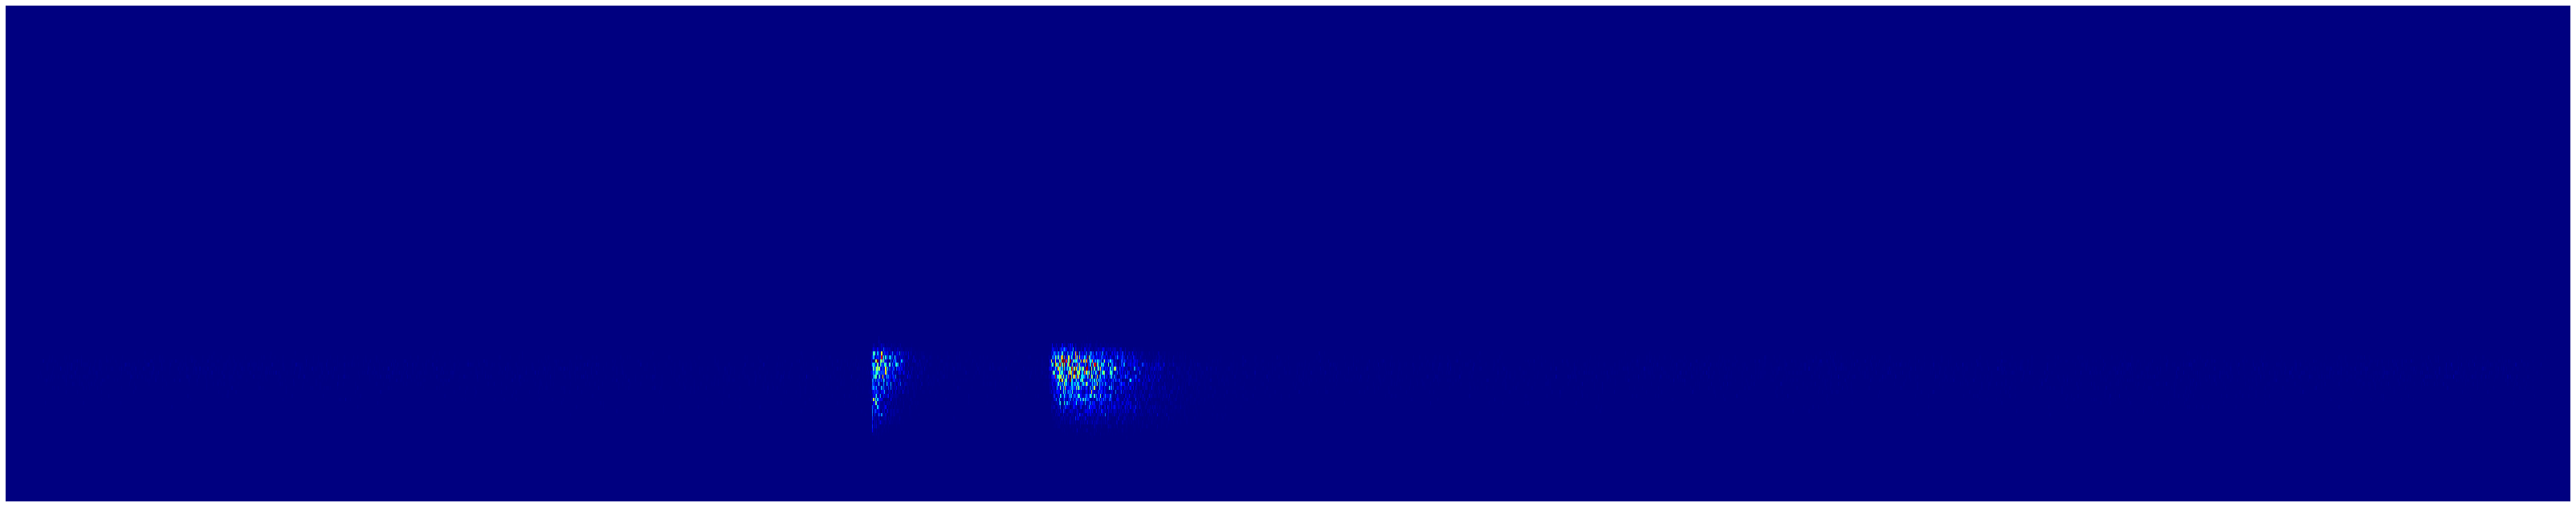

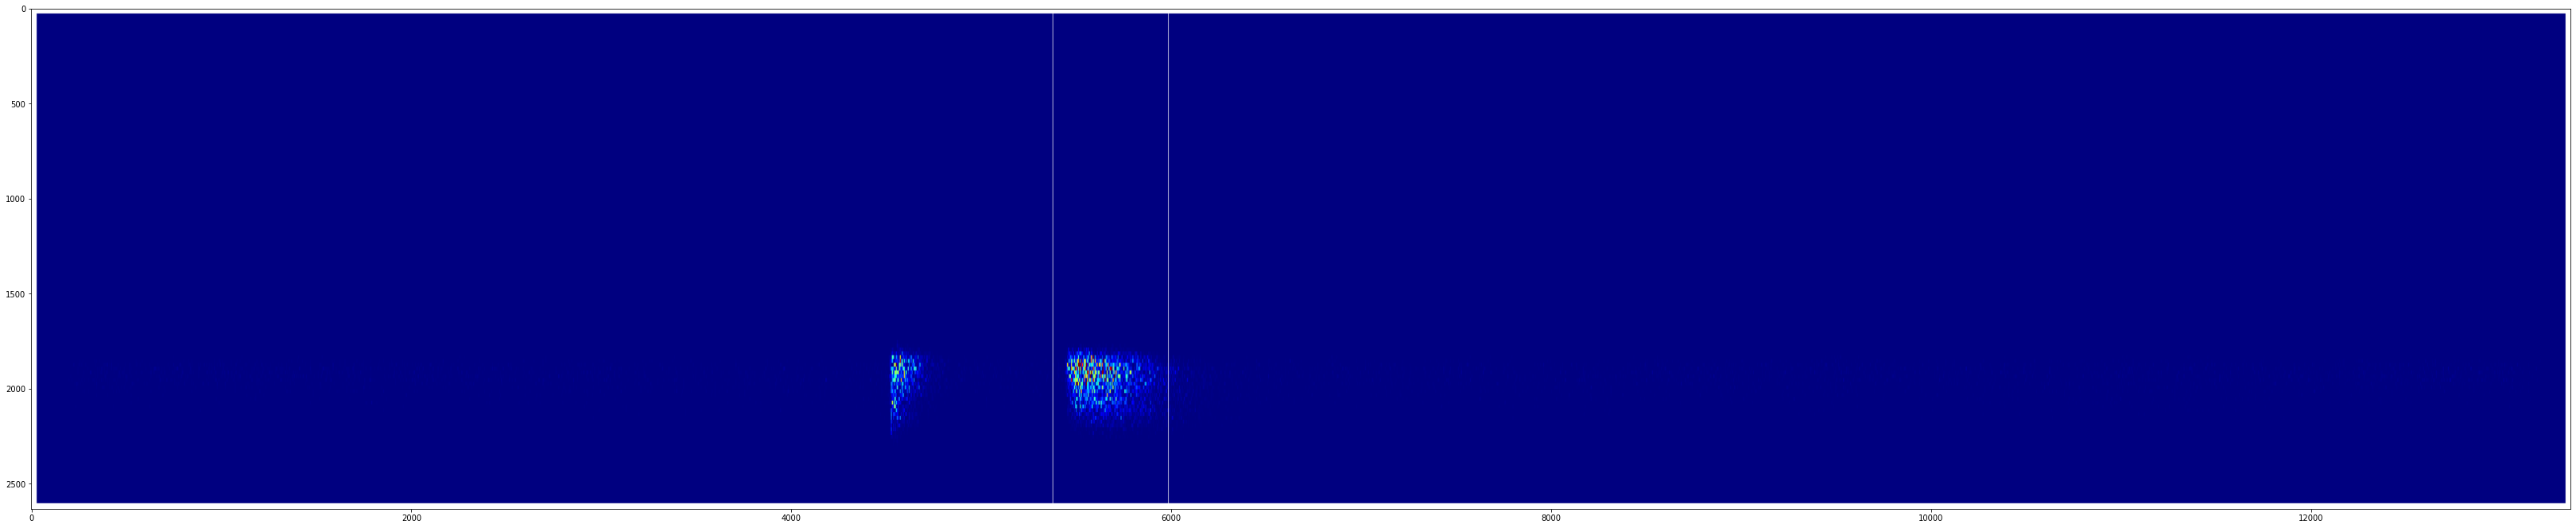

34752.96751465059 35099.288


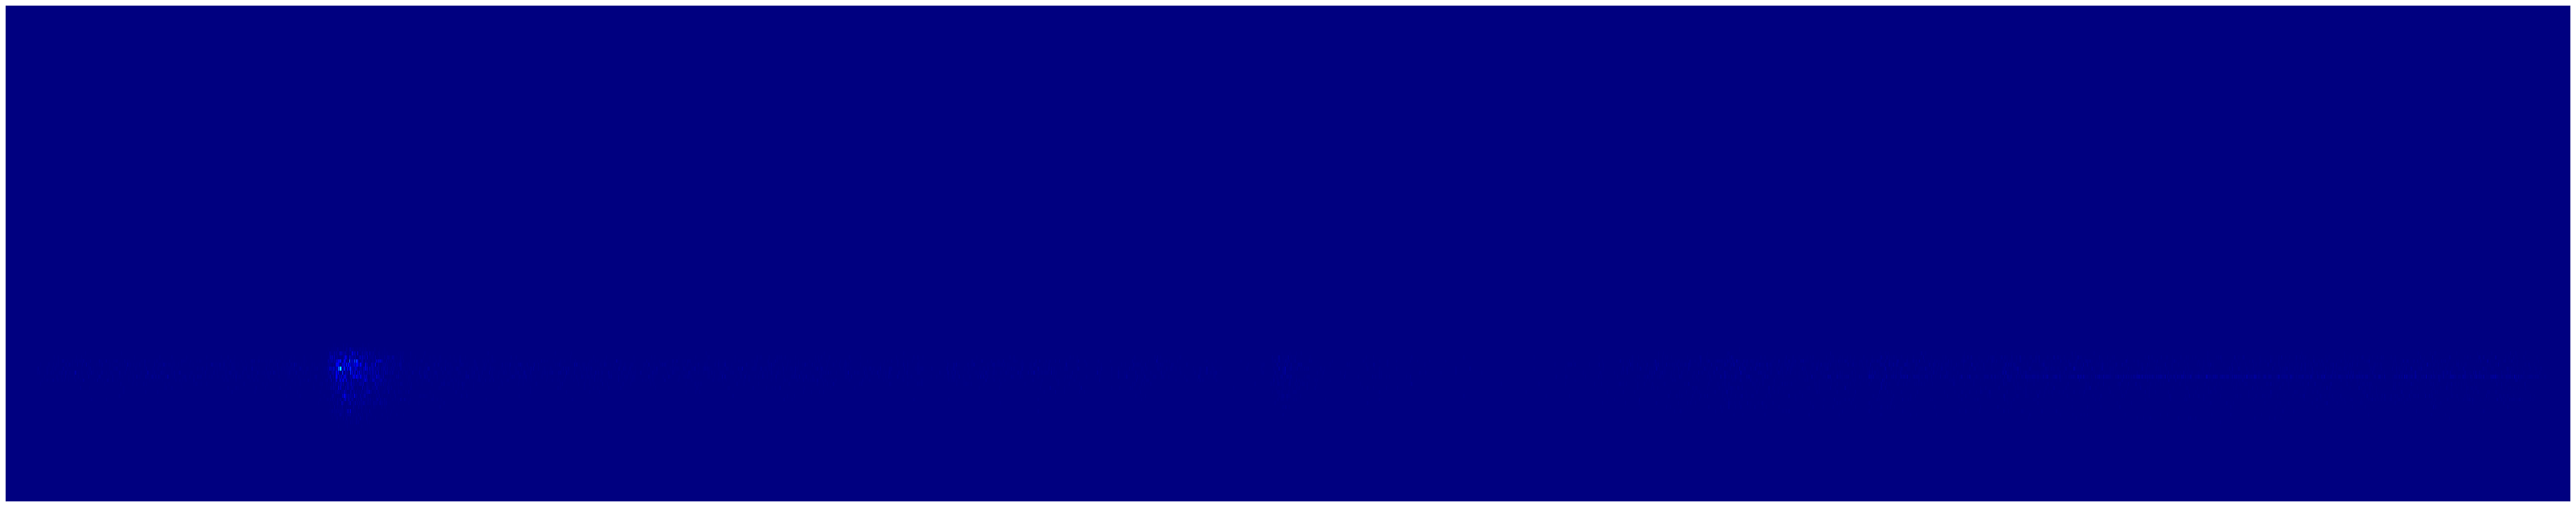

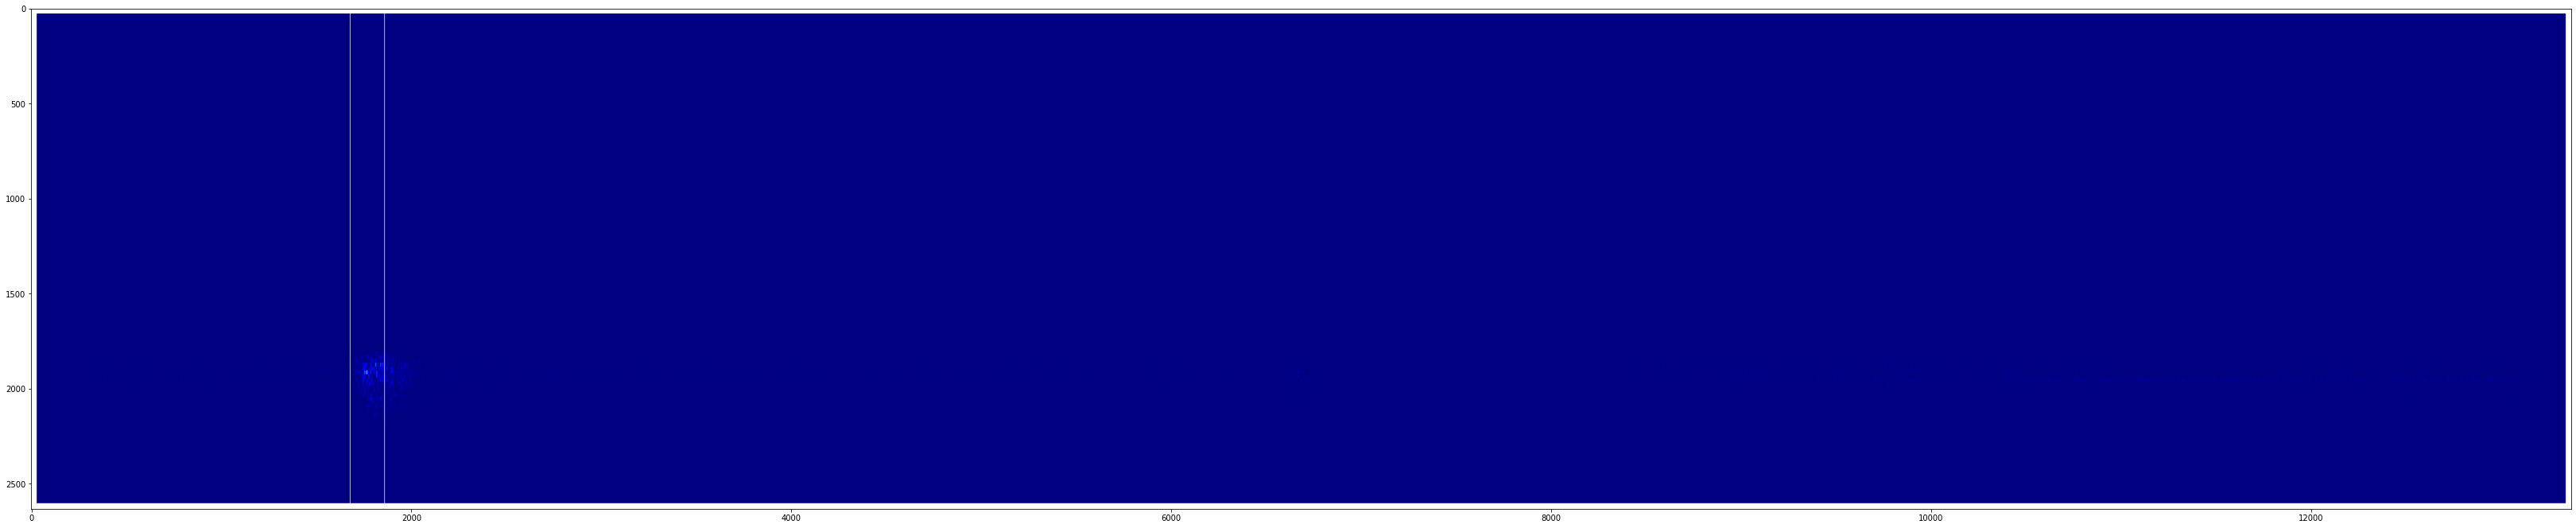

10851.895148086673 10799.817


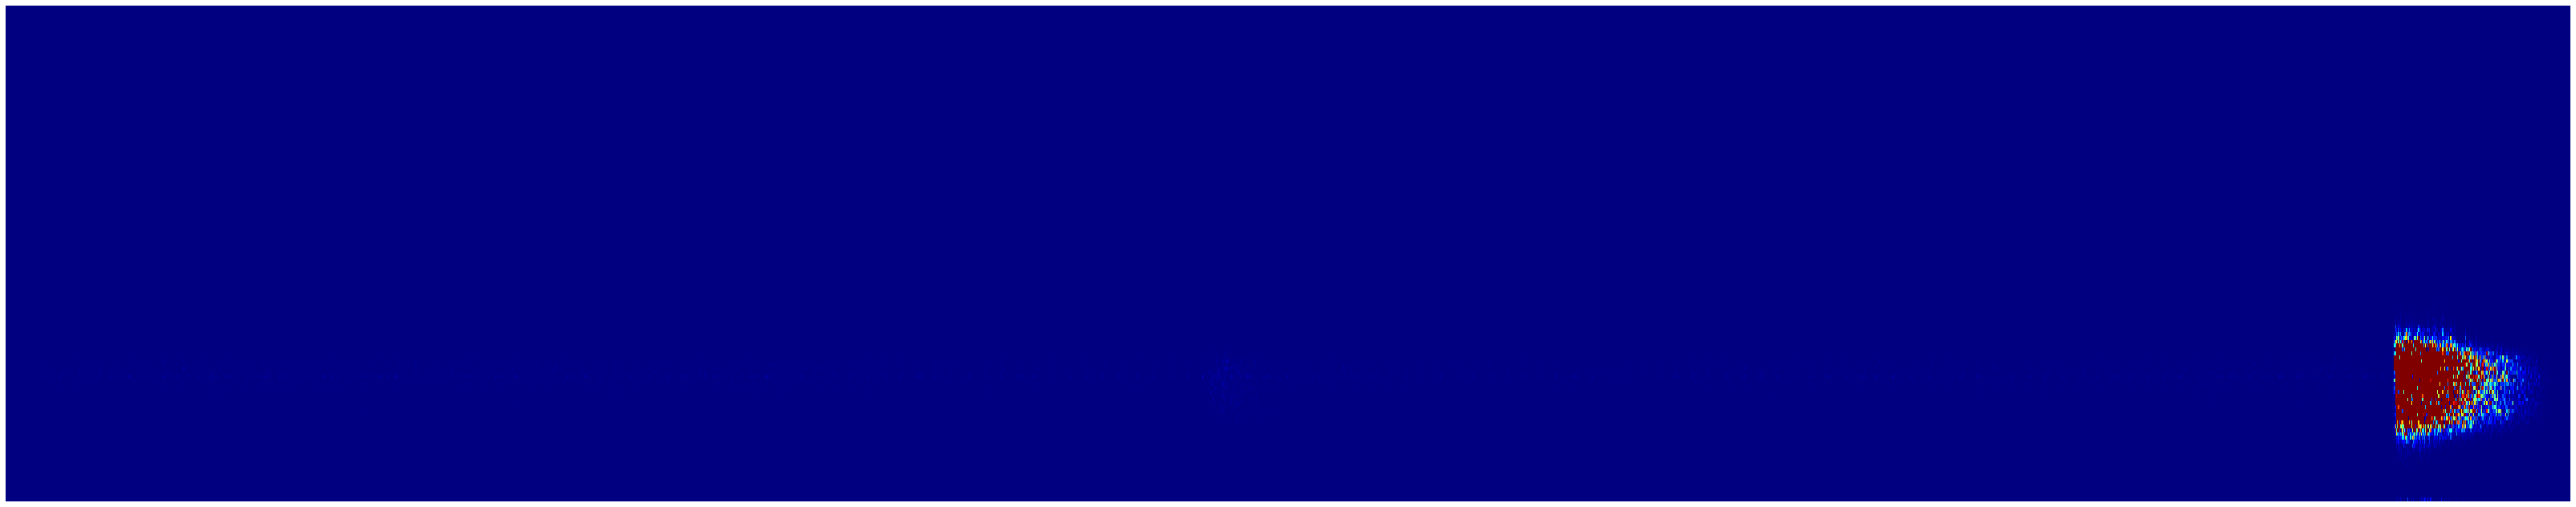

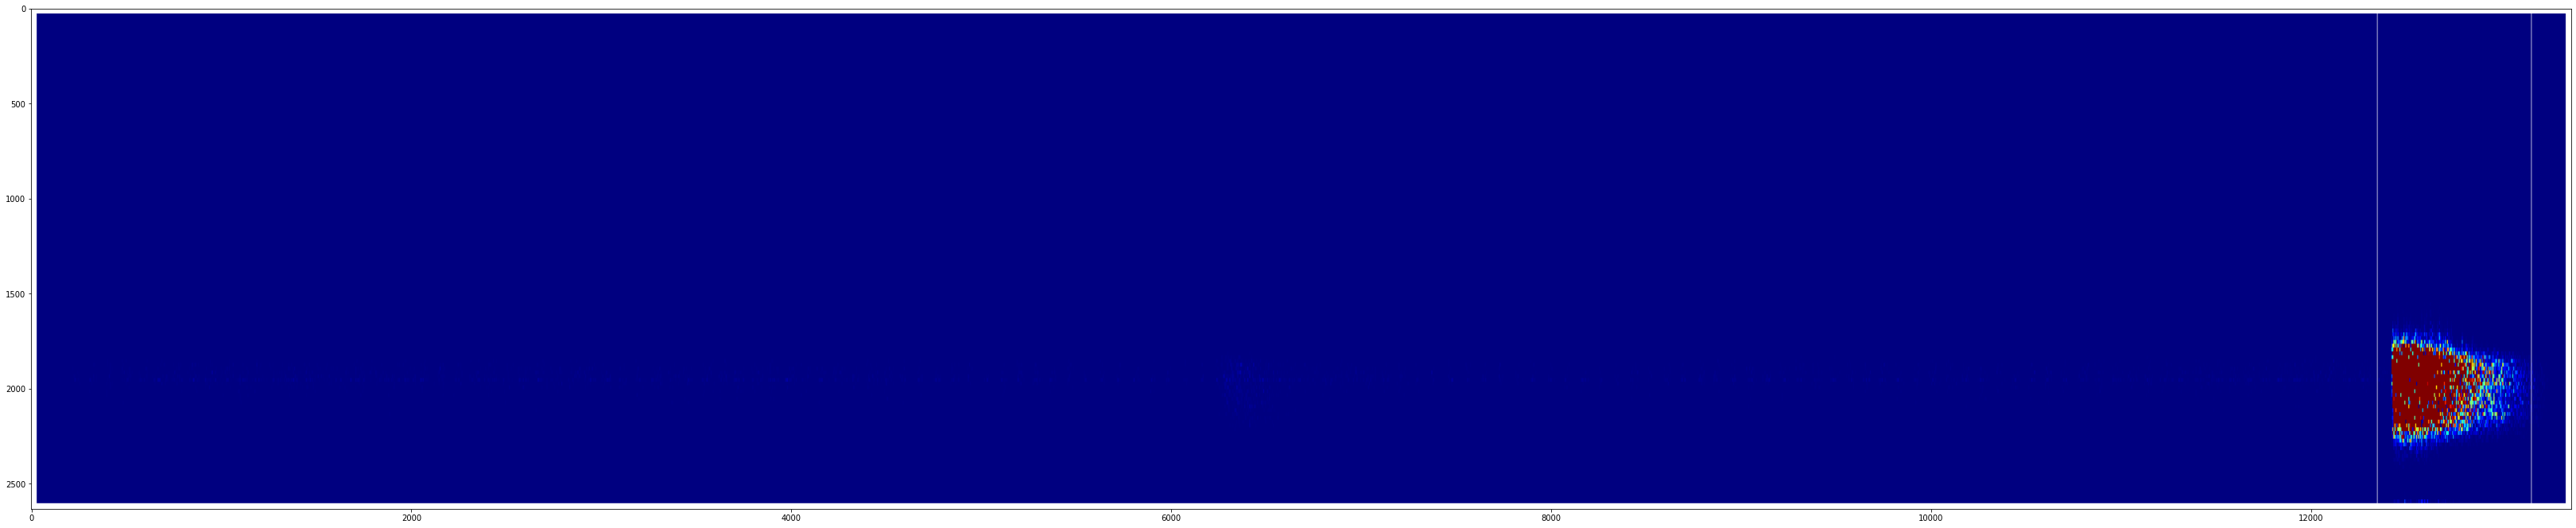

79804.14432663754 80399.498


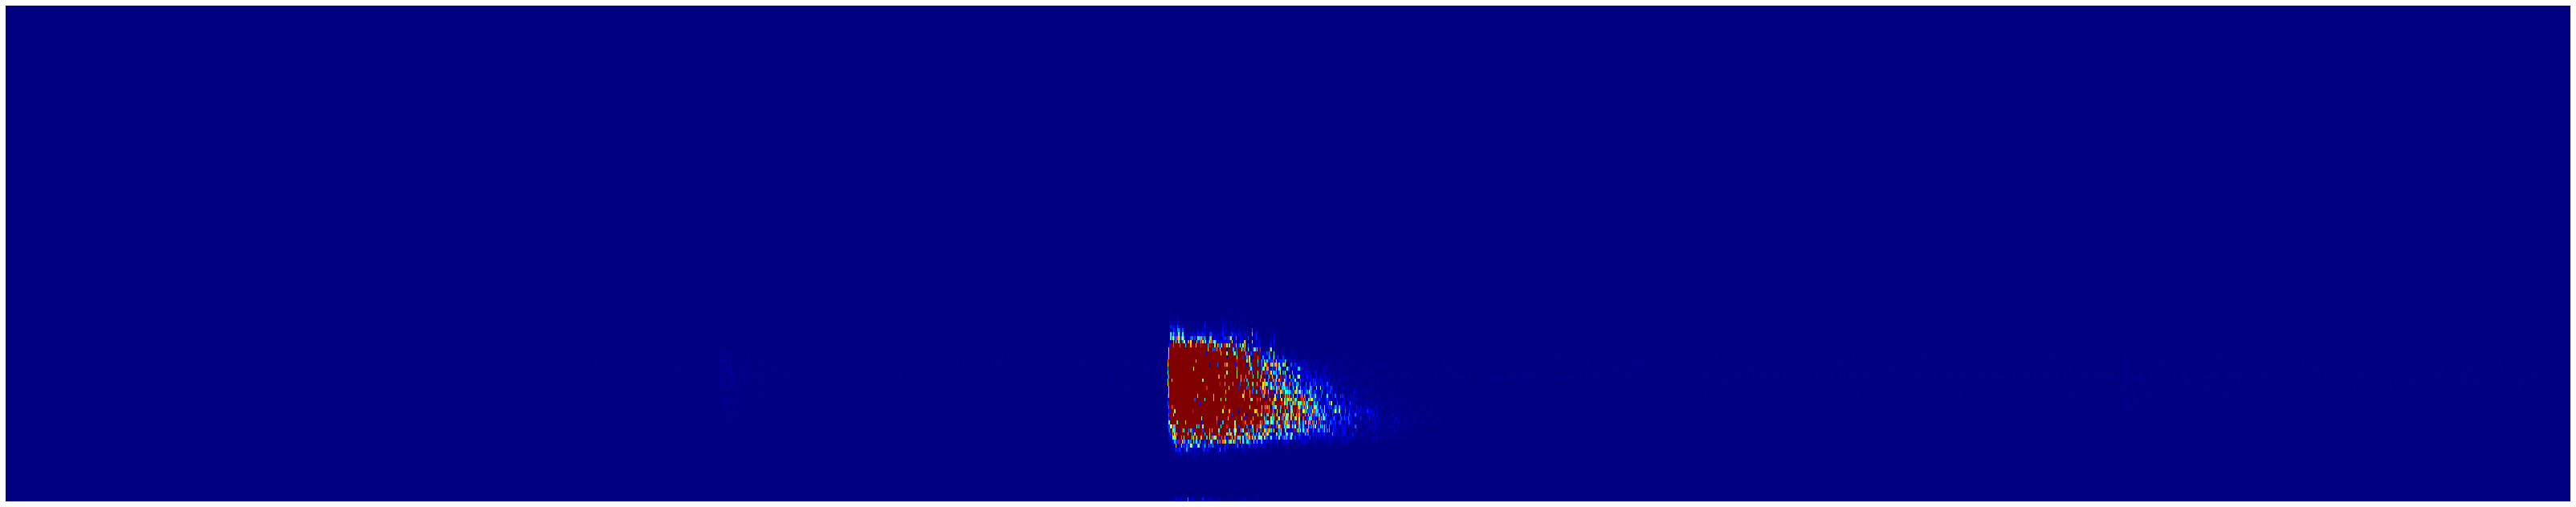

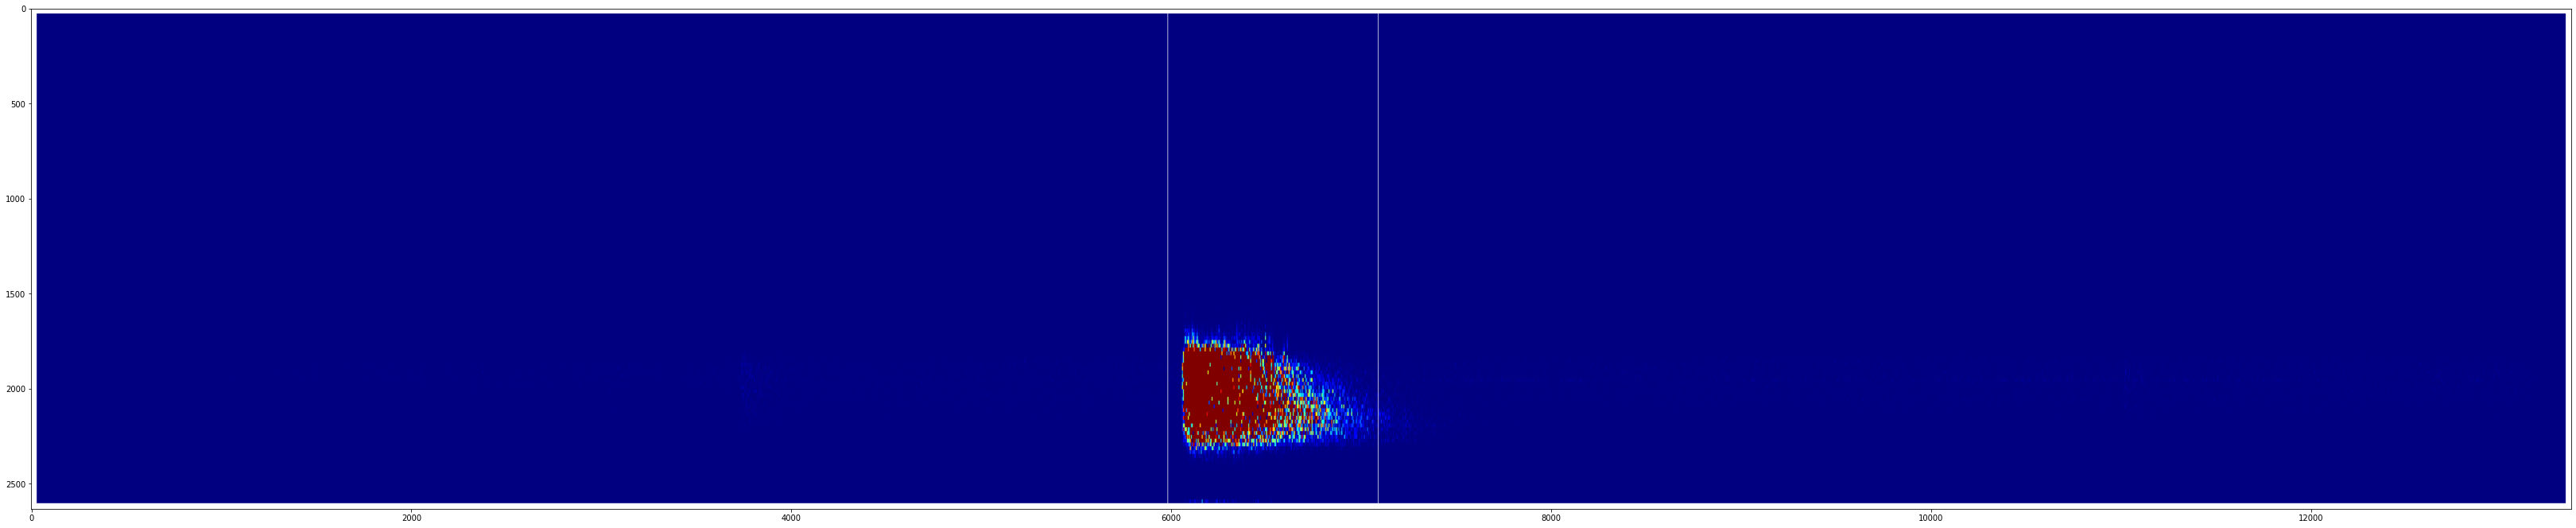

38663.9848921107 39059.471


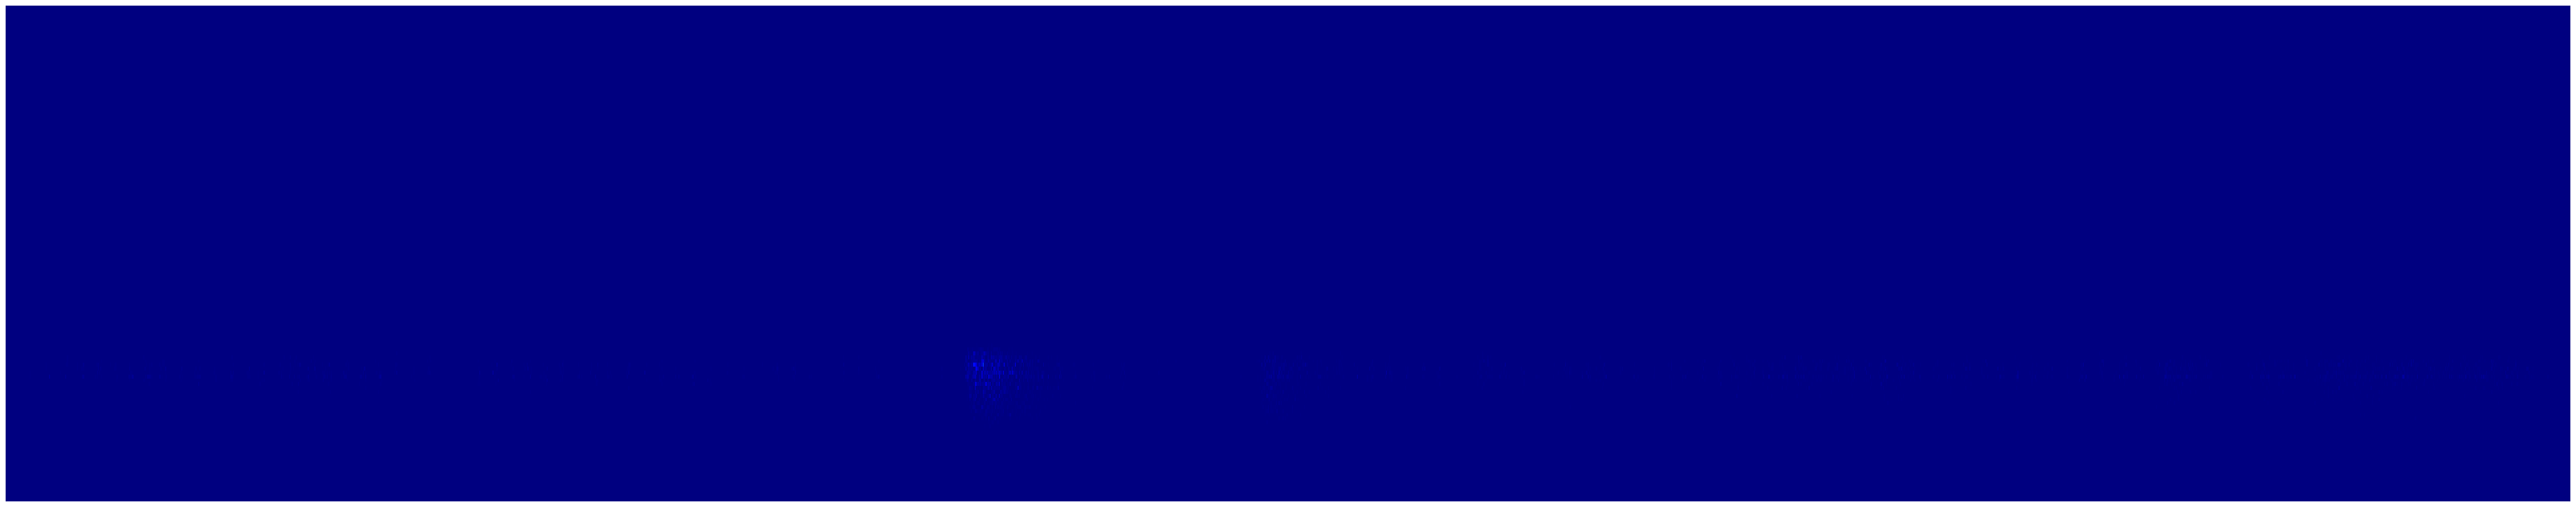

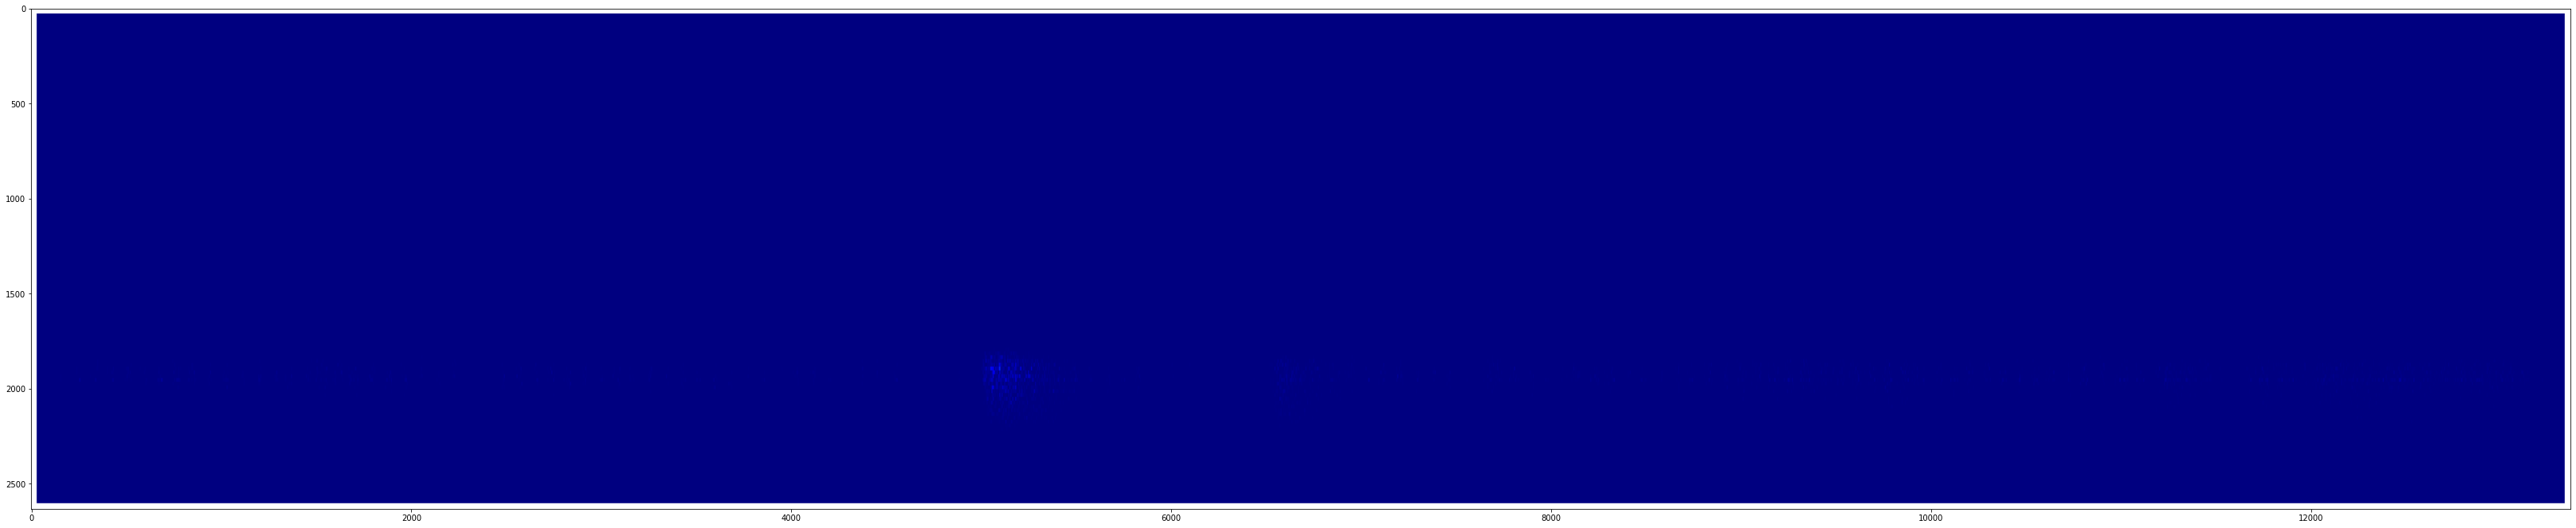

0.0 32219.424


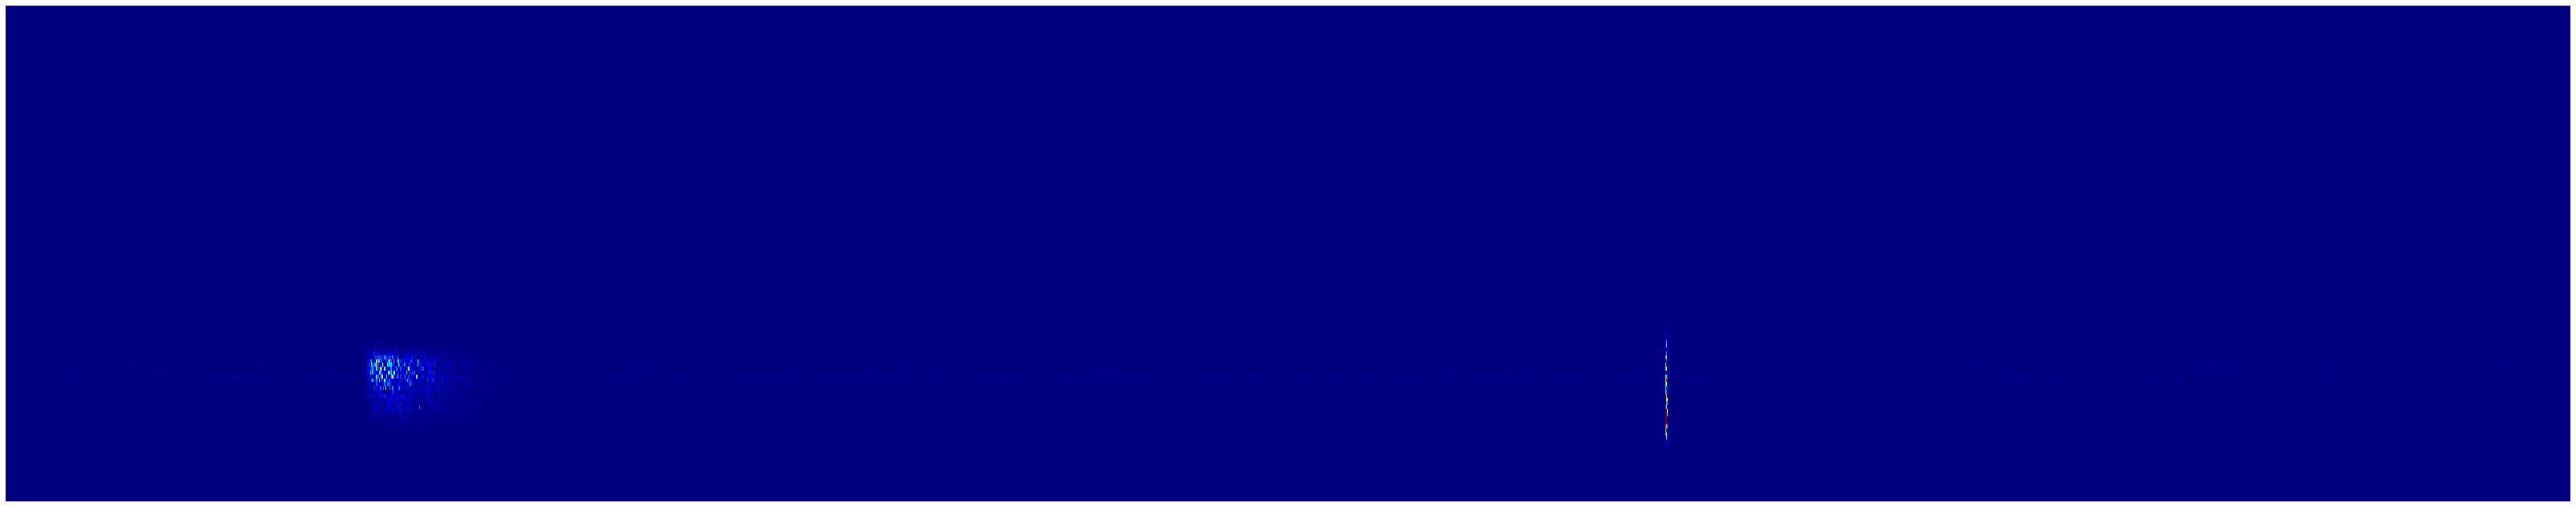

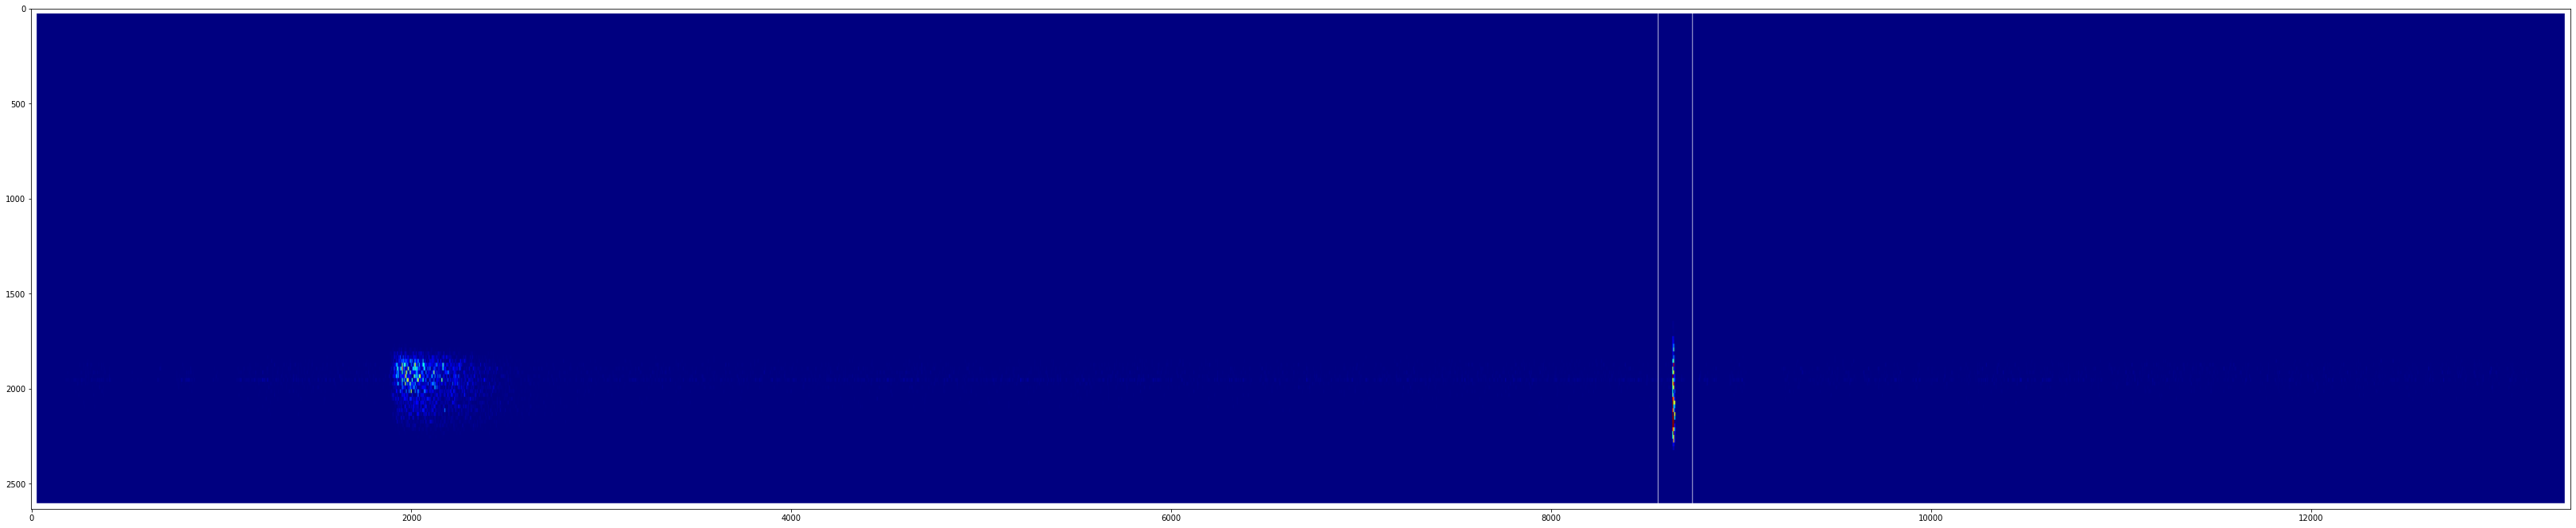

55357.07767352054 11939.583


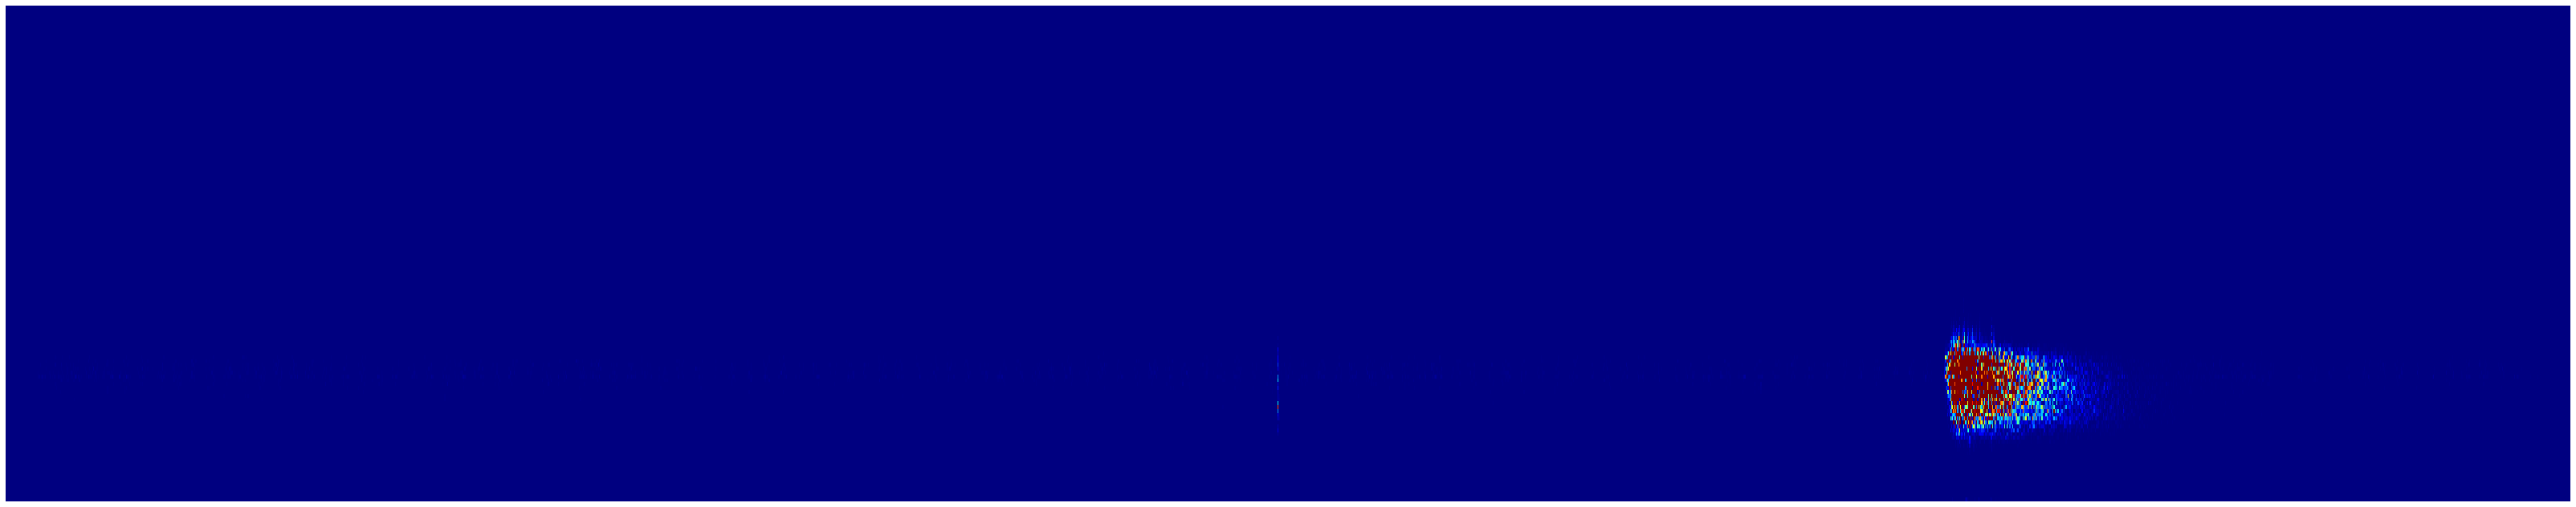

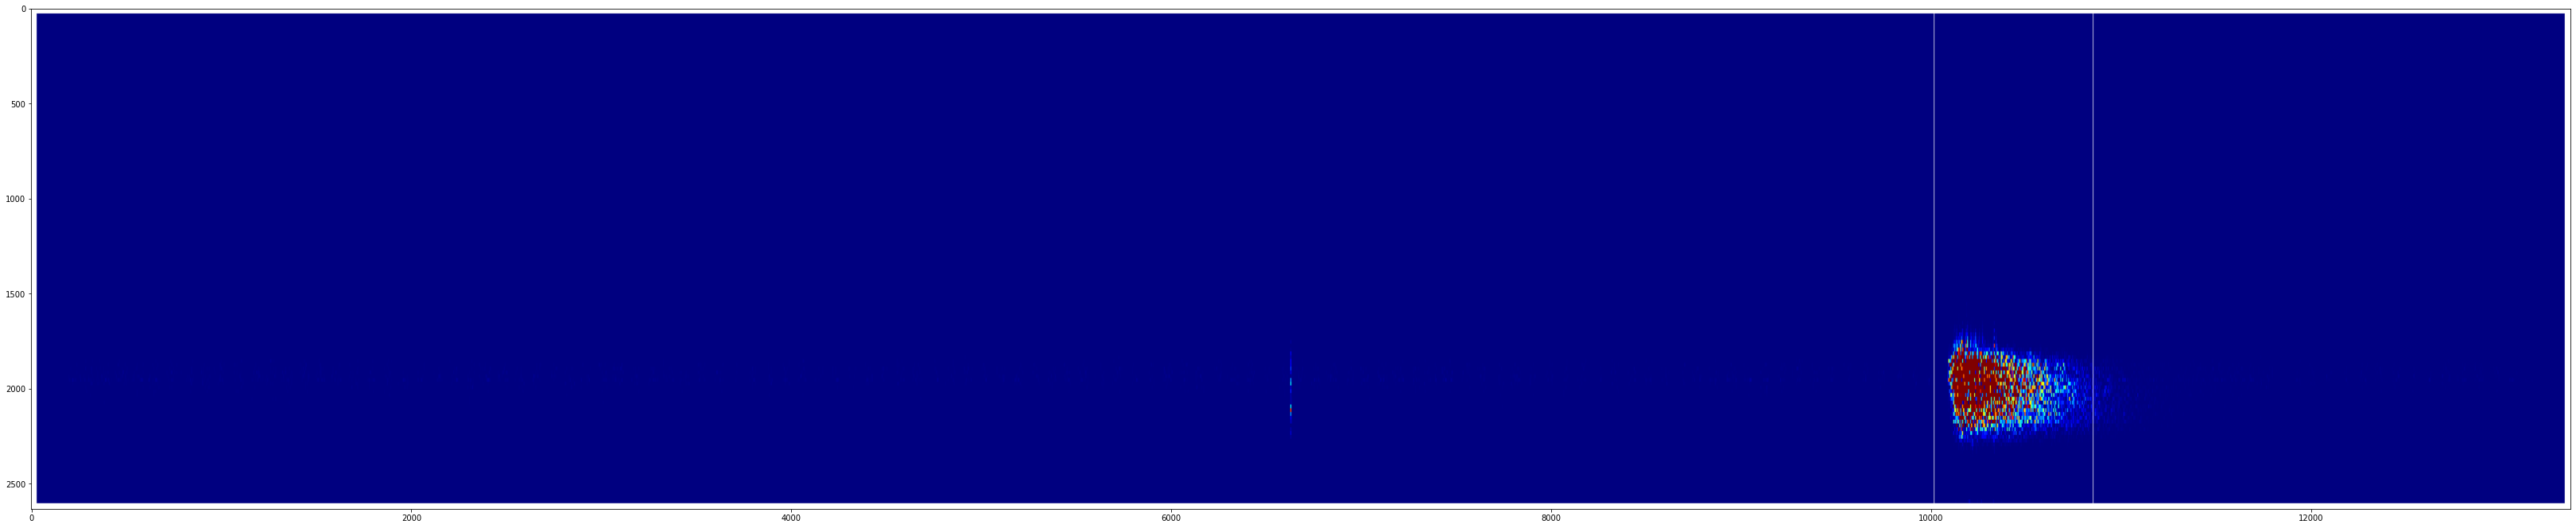

64748.06820003839 65279.575


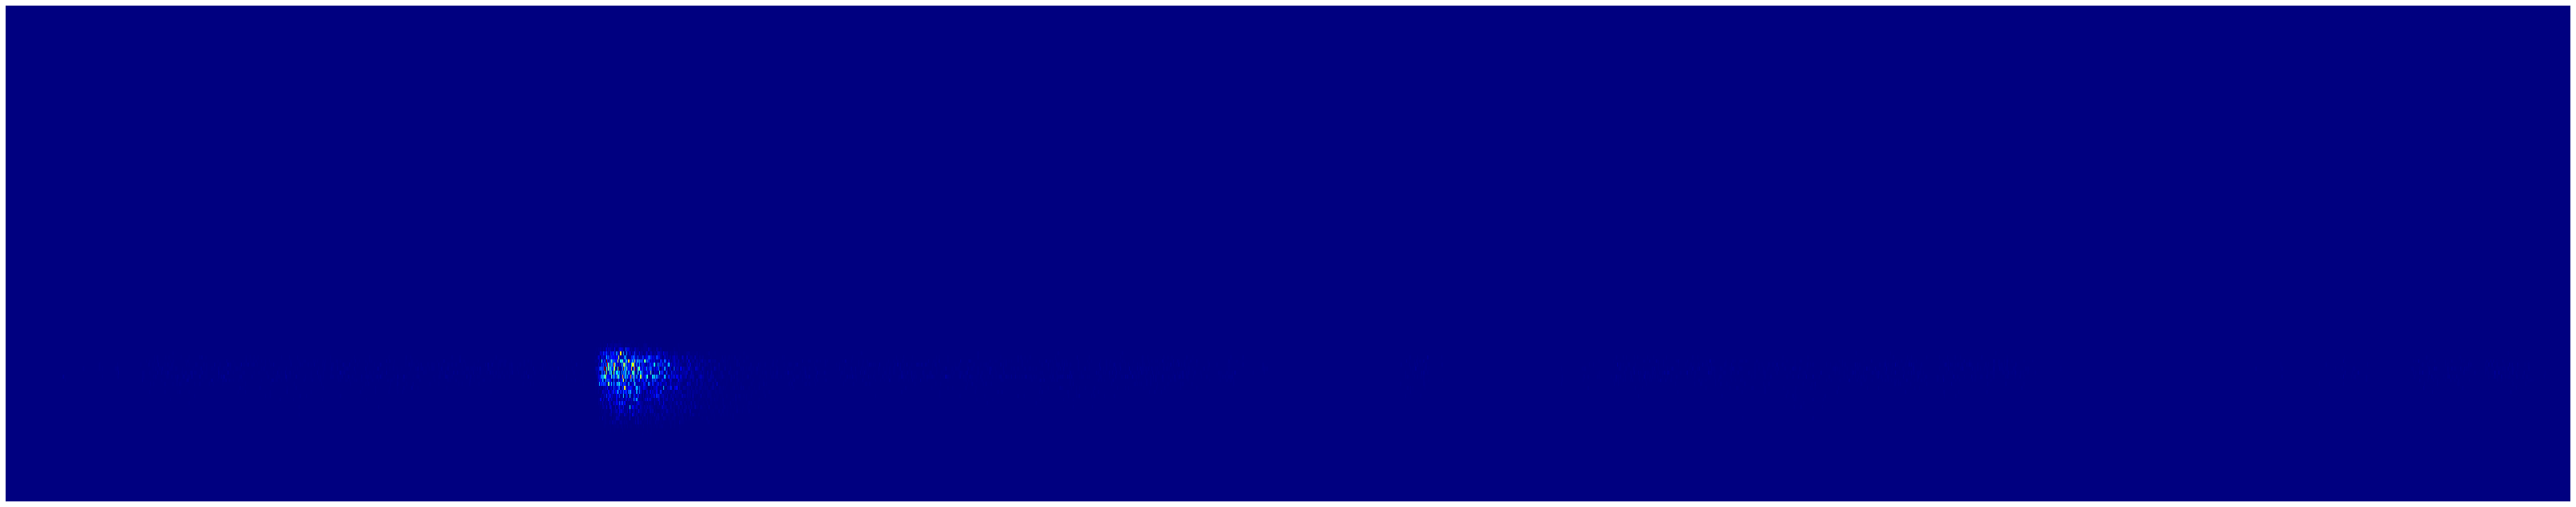

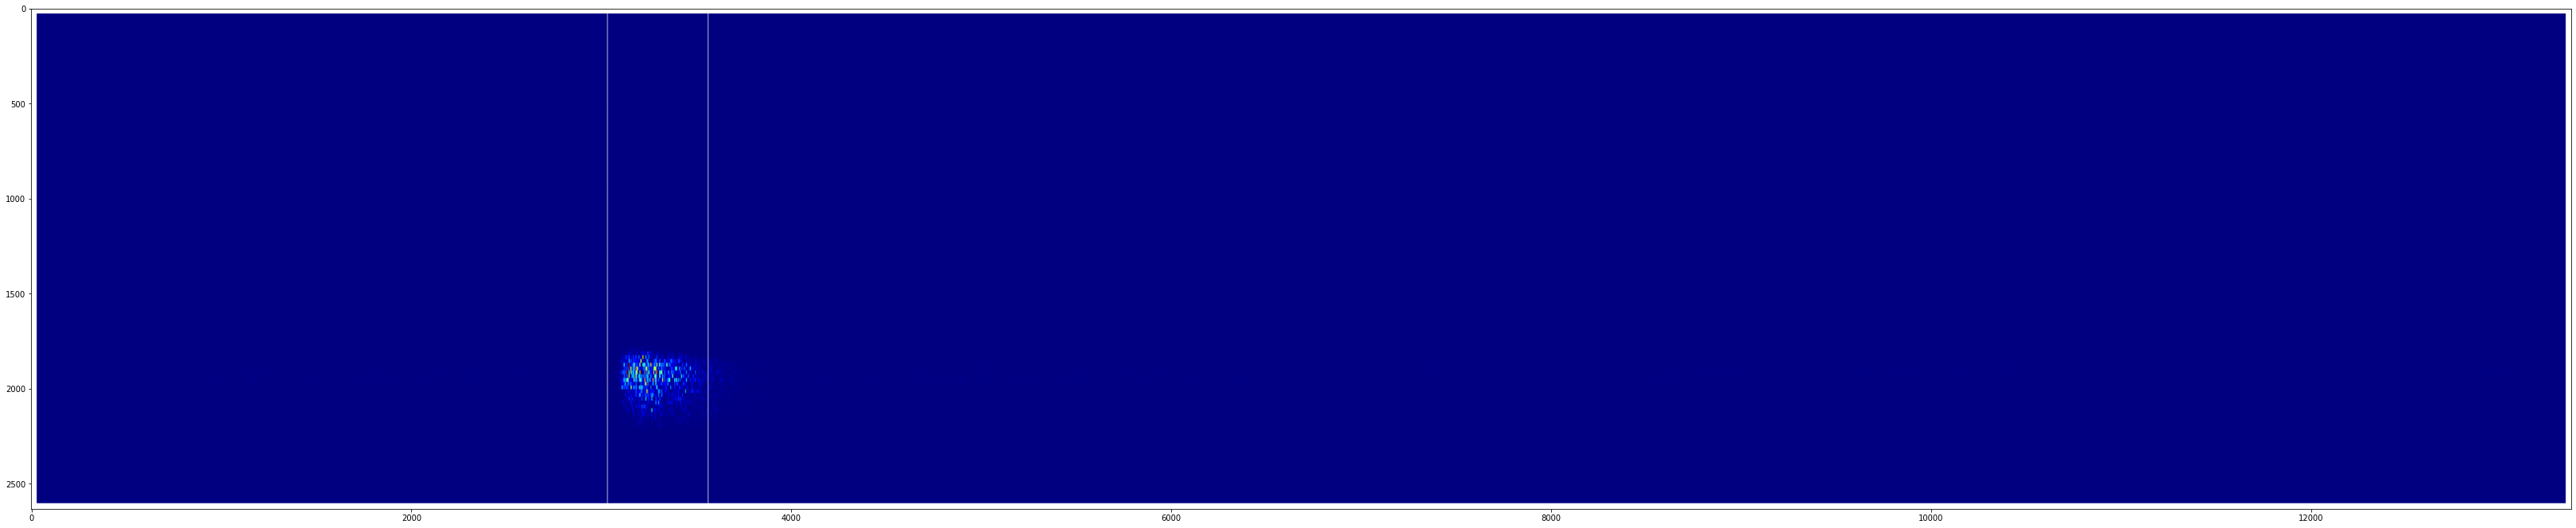

19603.454727143388 19799.58


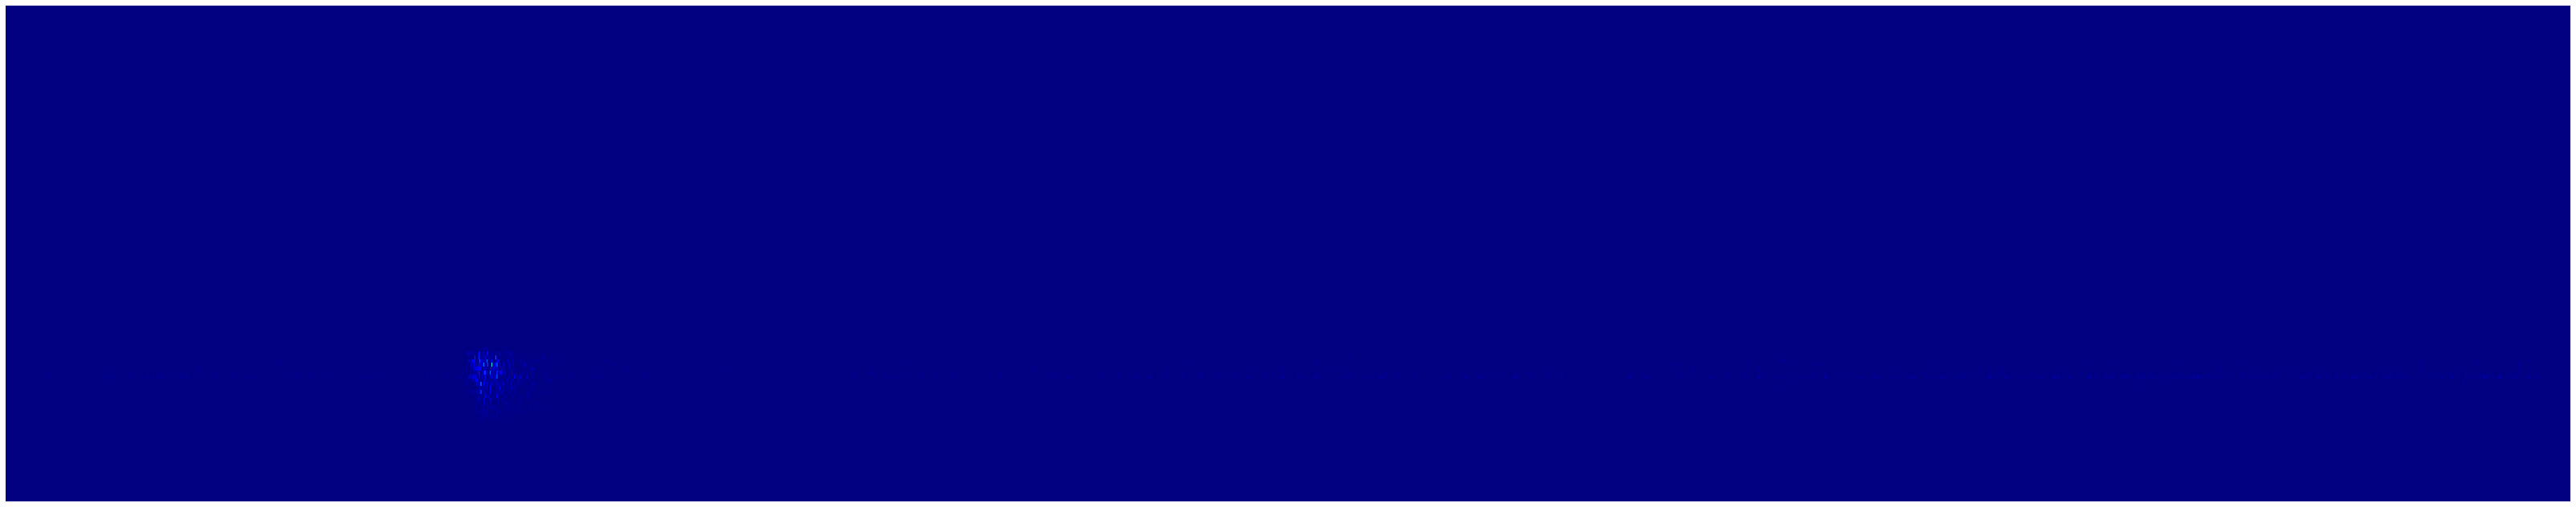

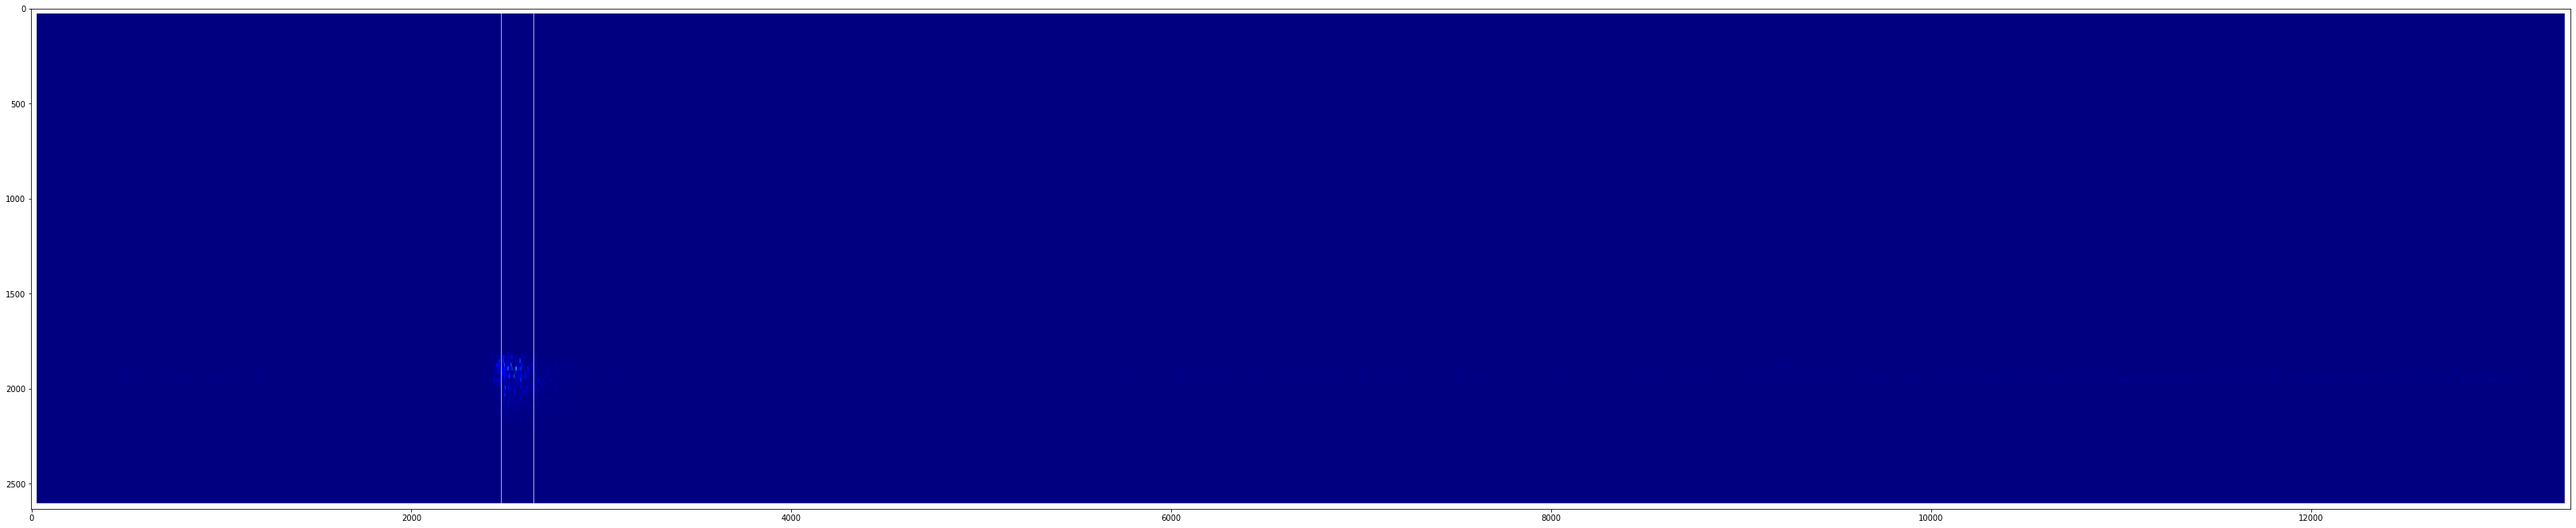

16002.816616419948 15419.398


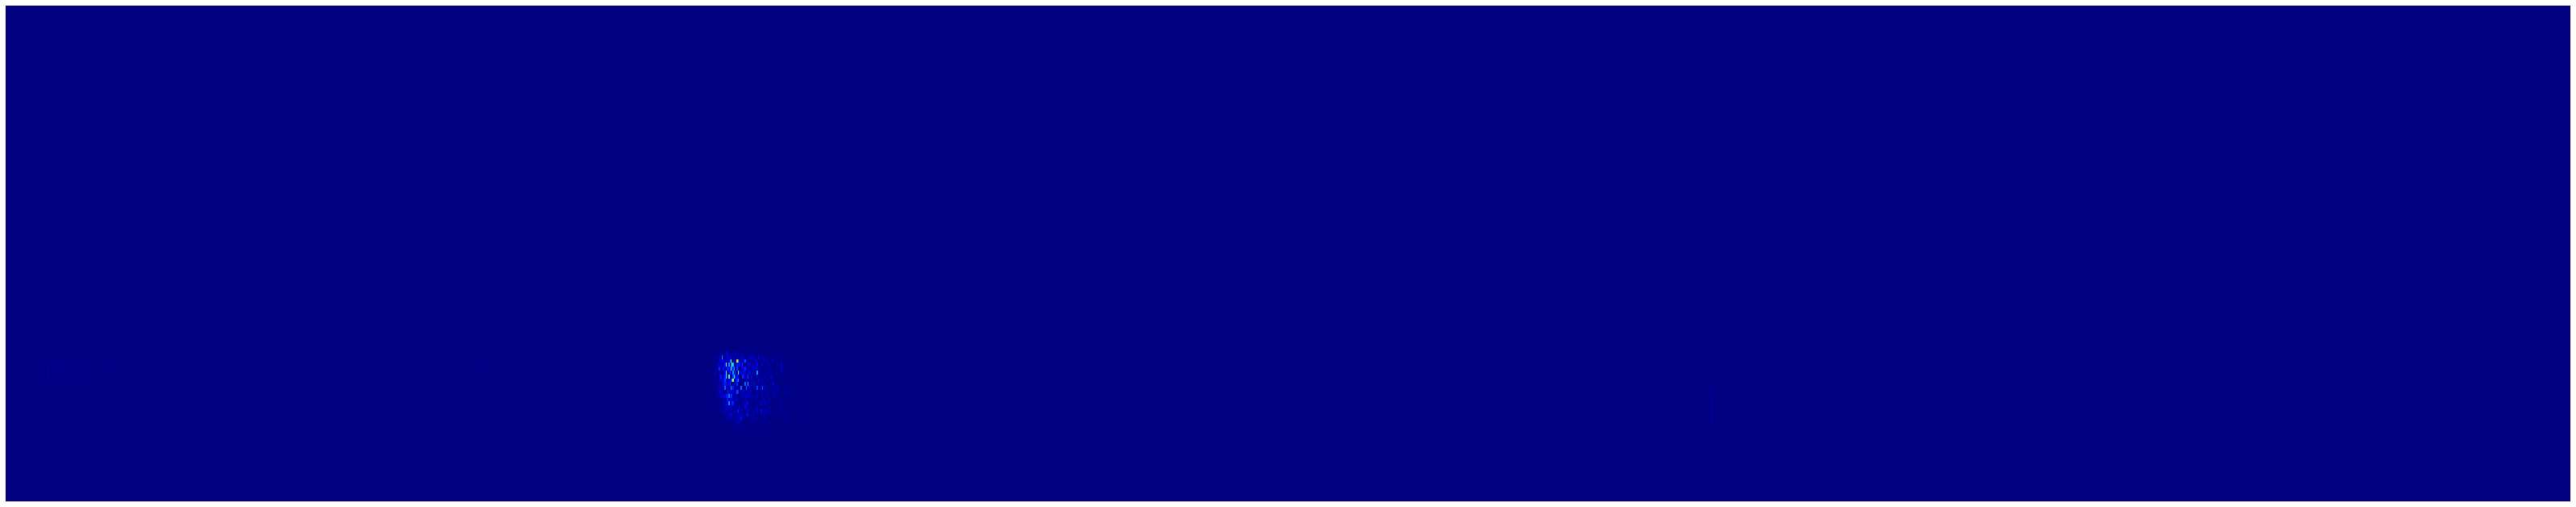

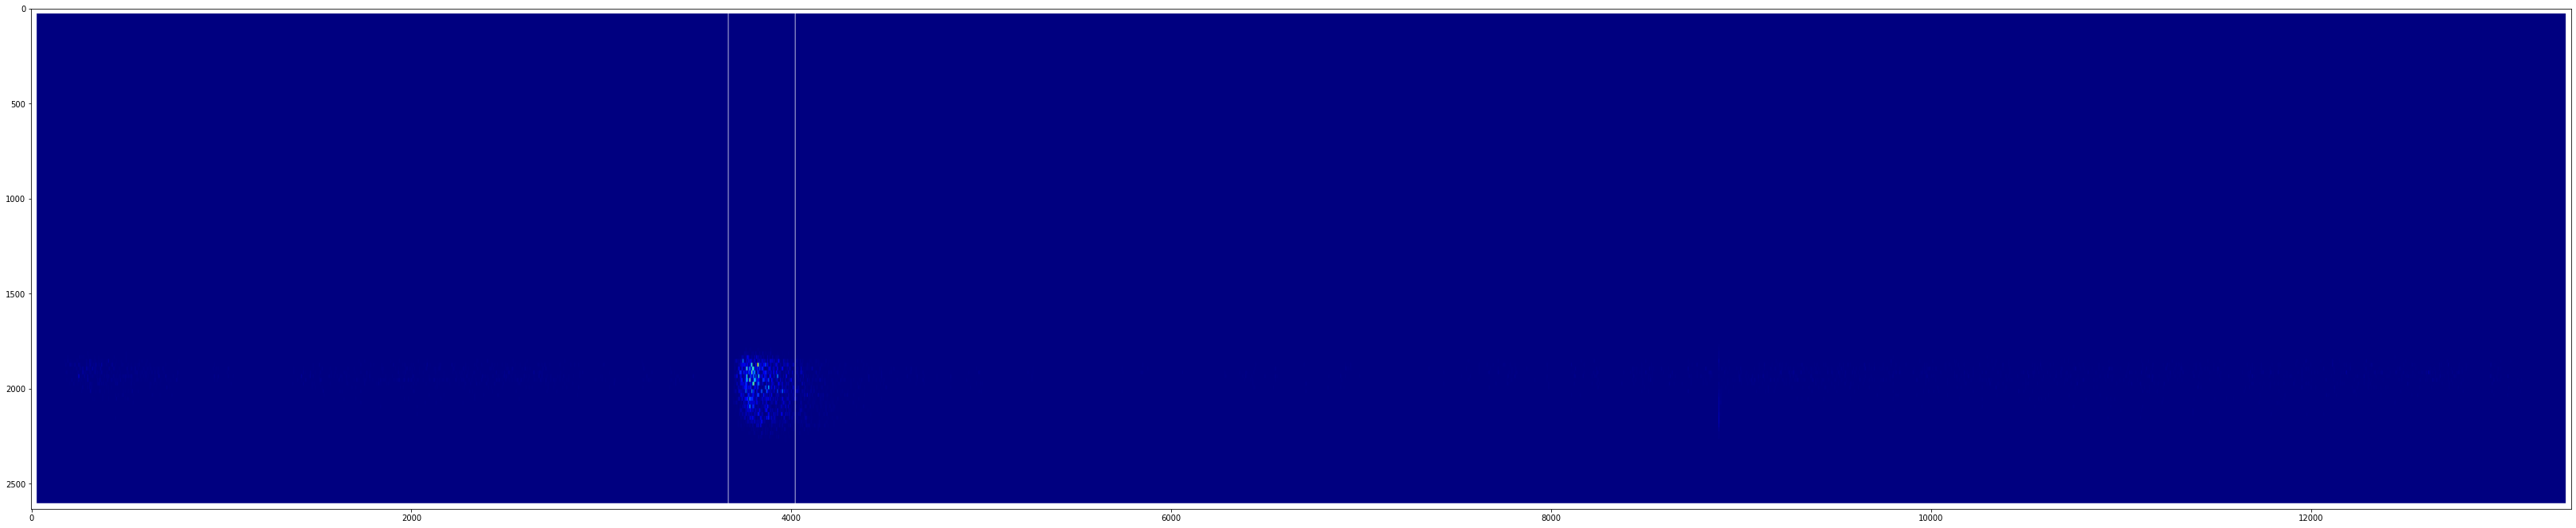

23714.16926933369 23699.883


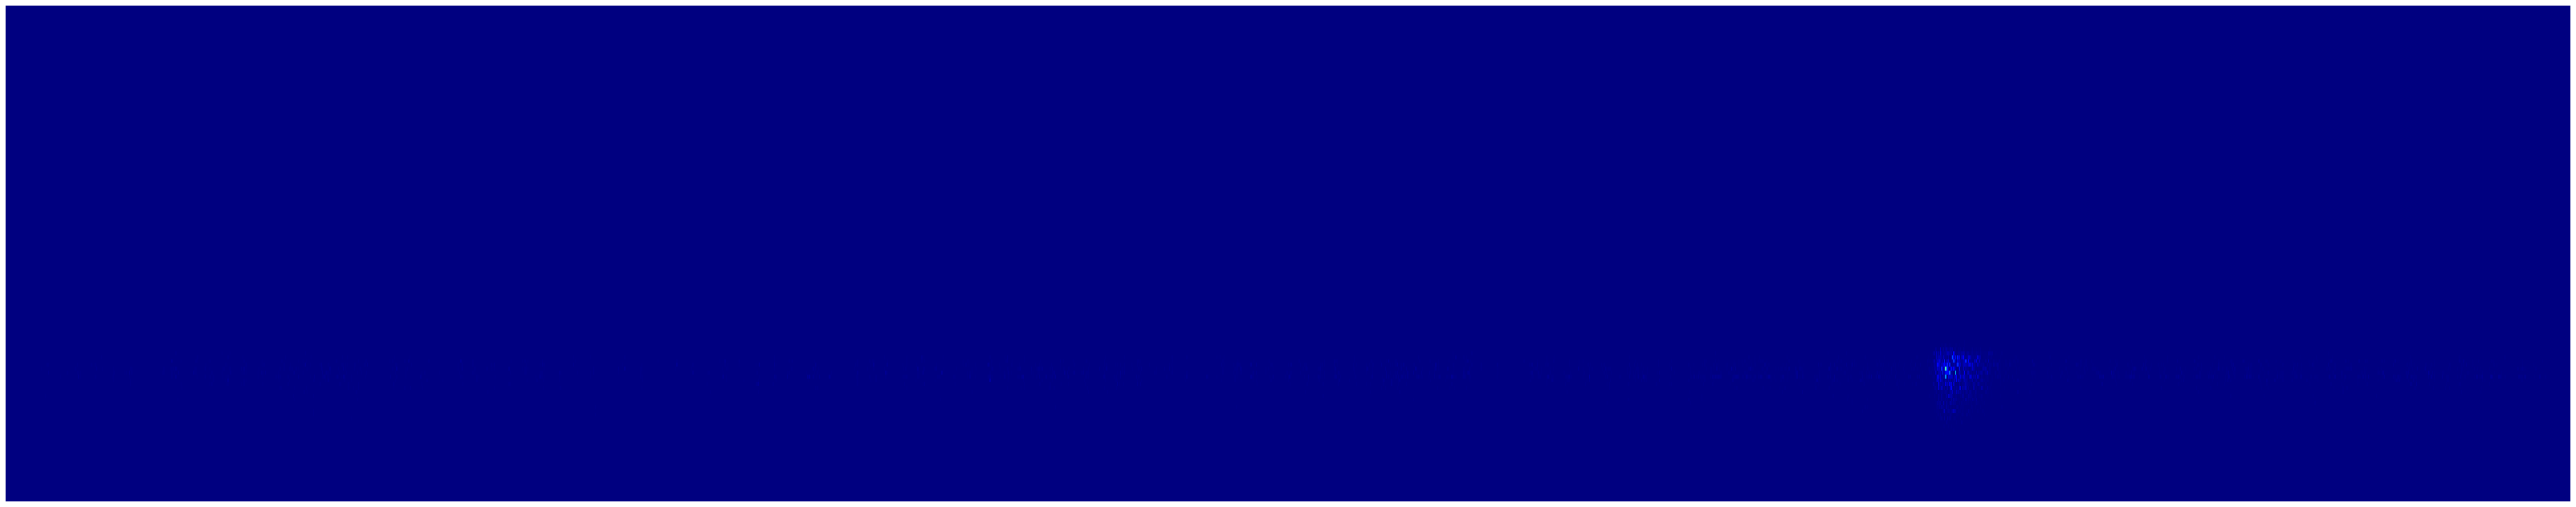

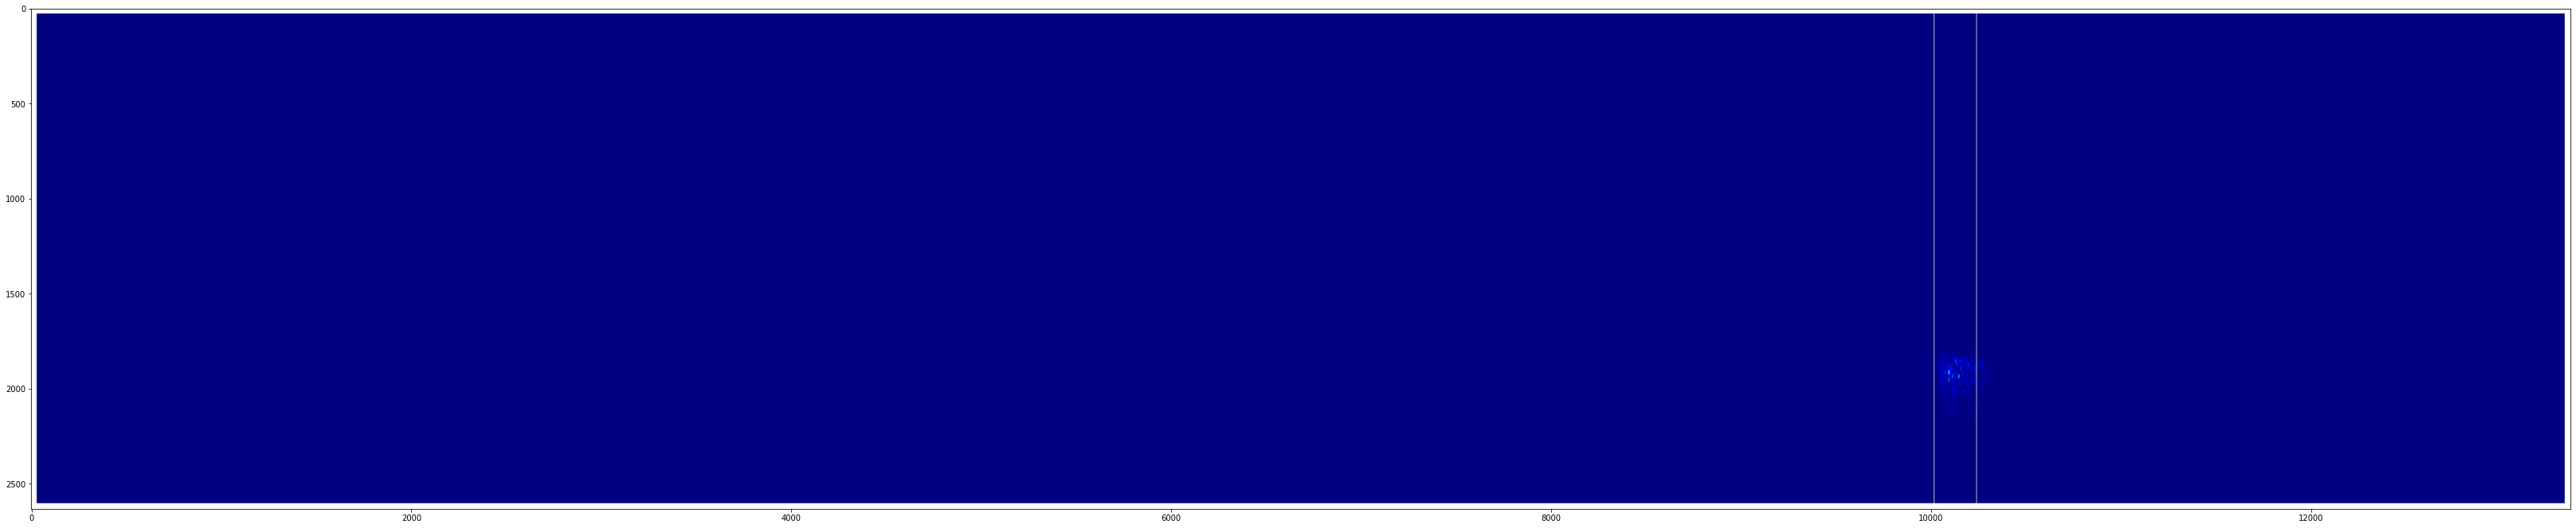

64748.06820003839 64799.583


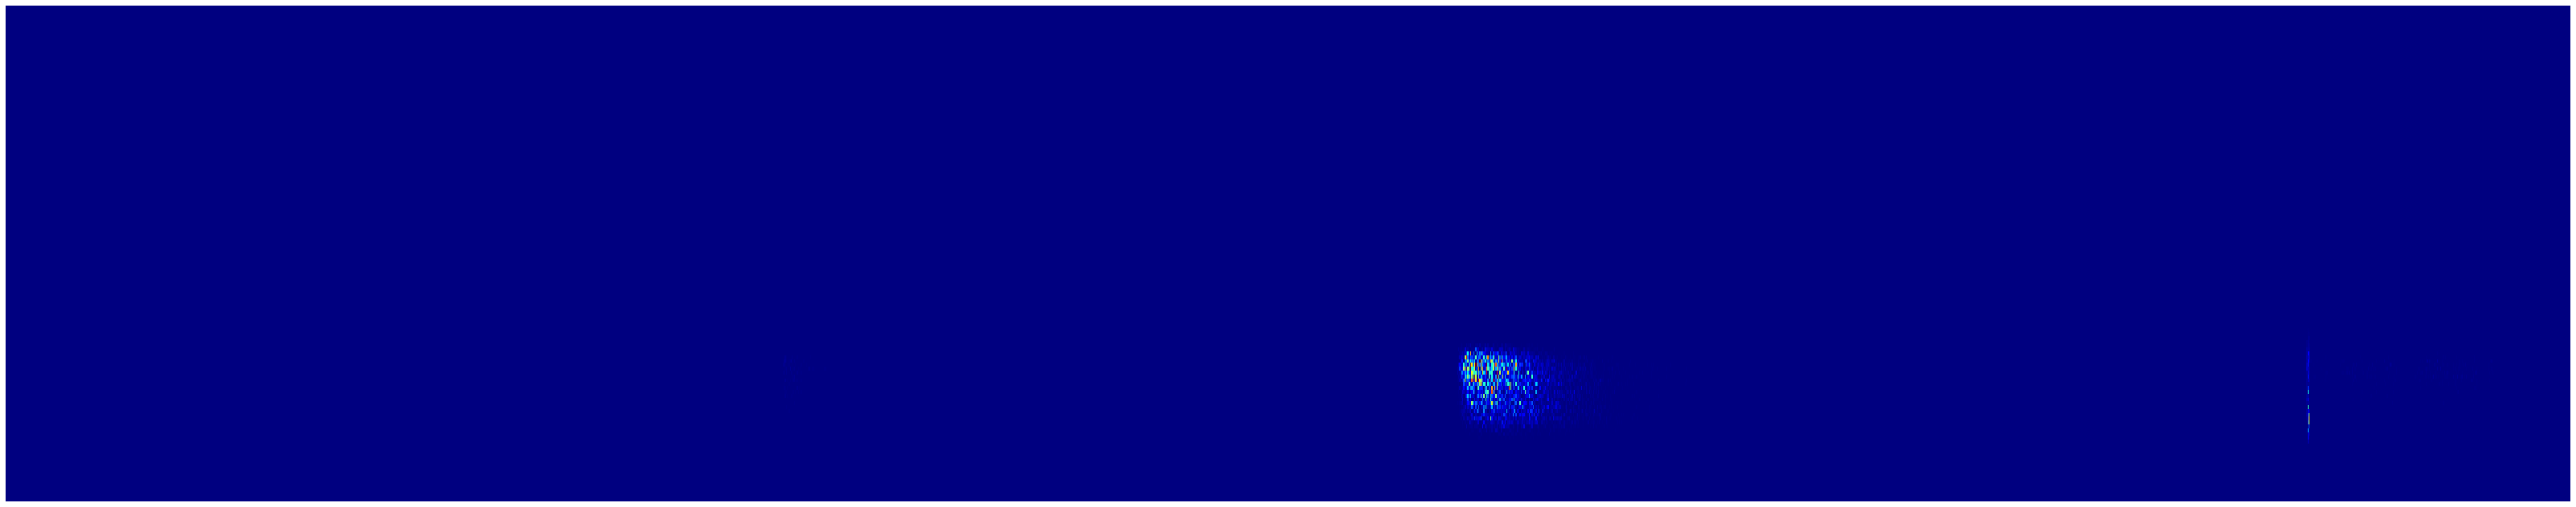

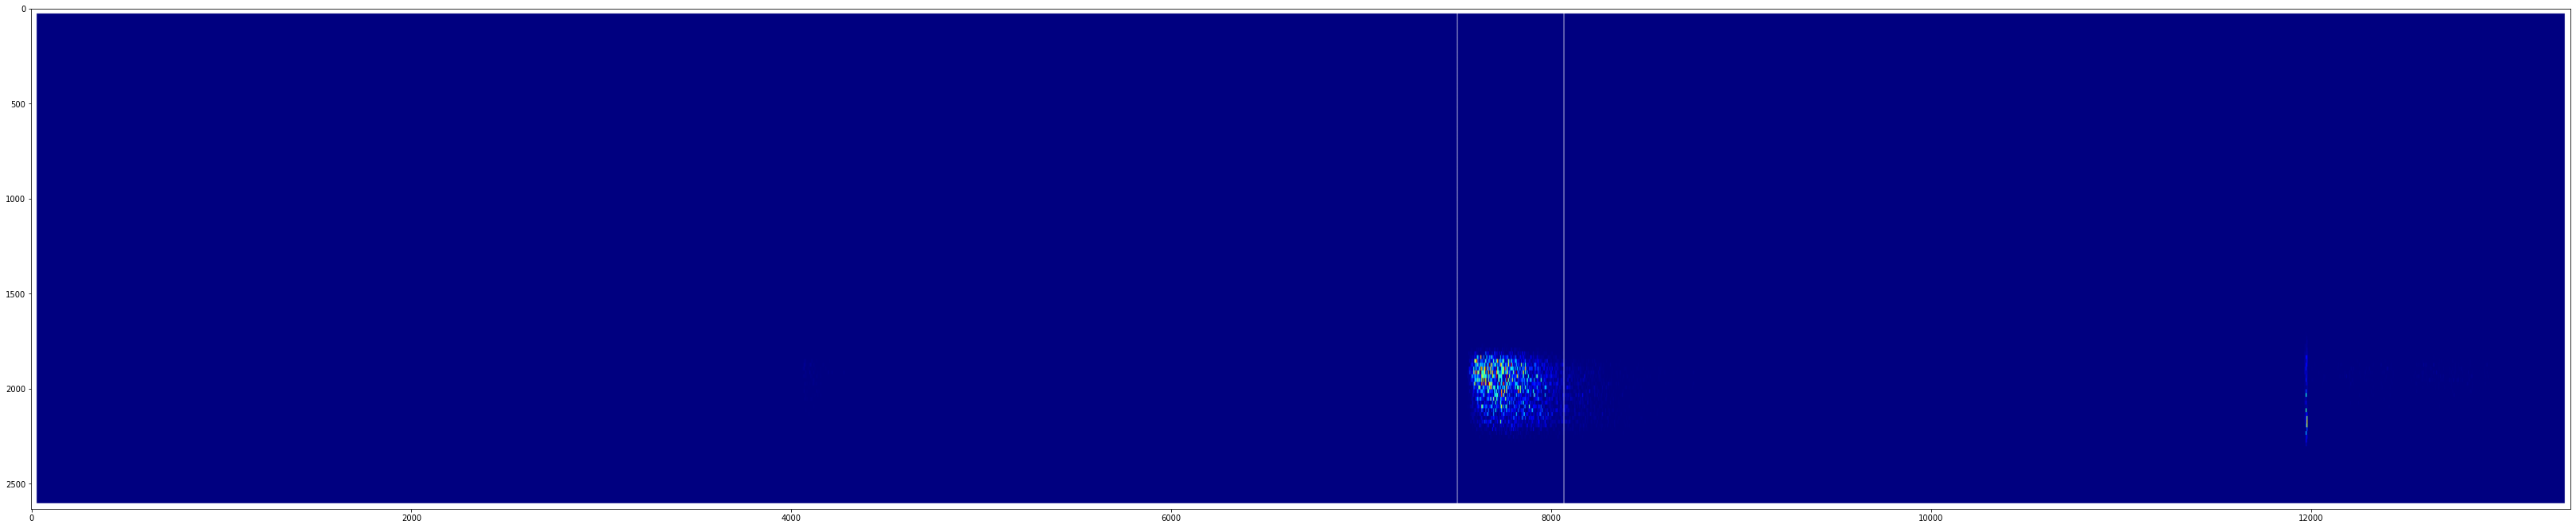

48525.503697932545 48899.424


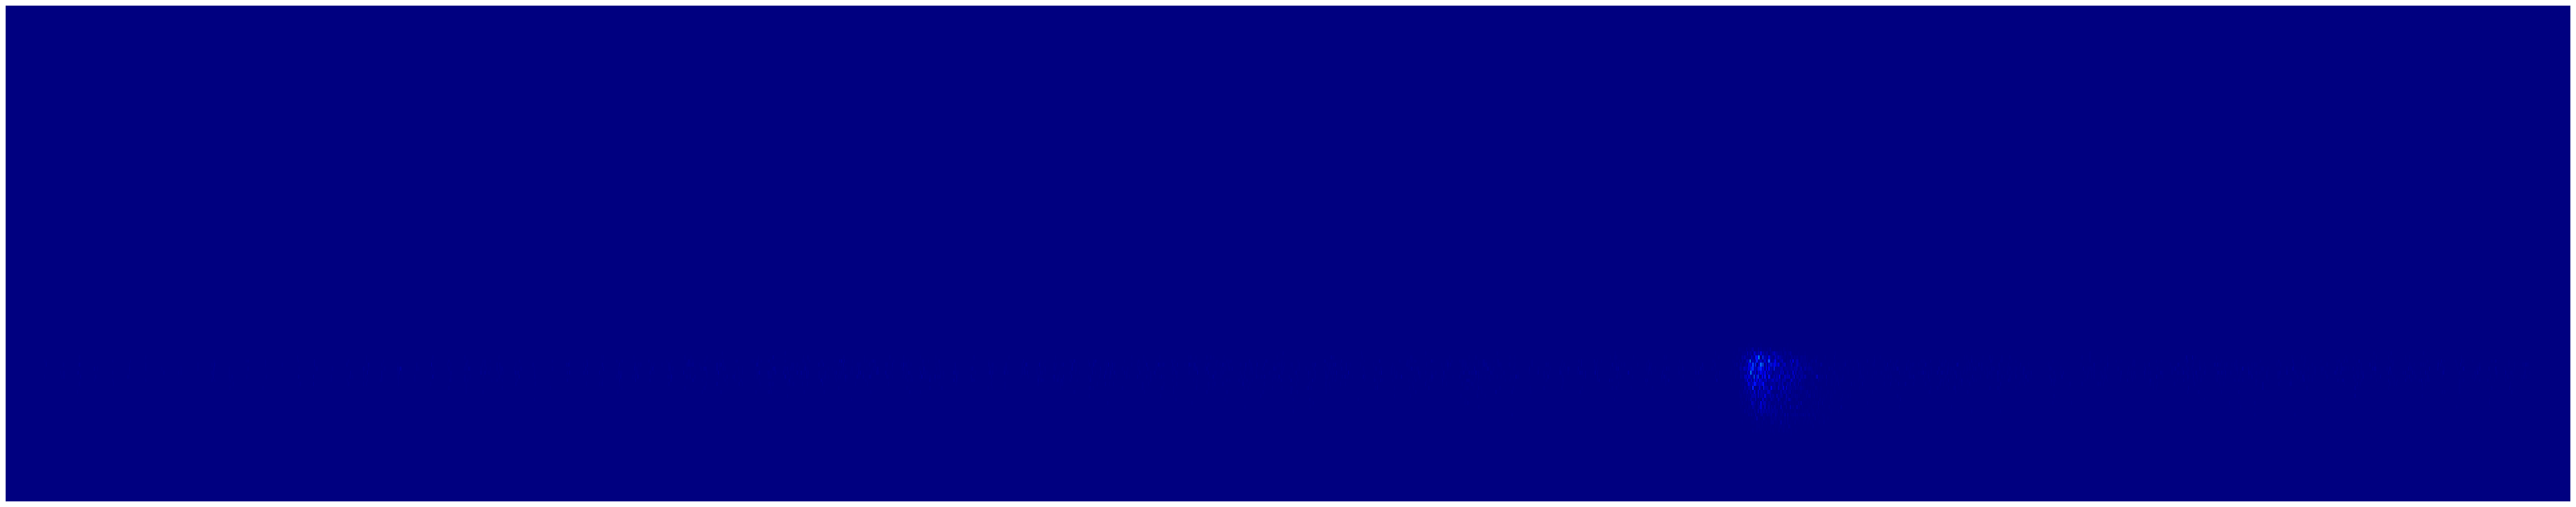

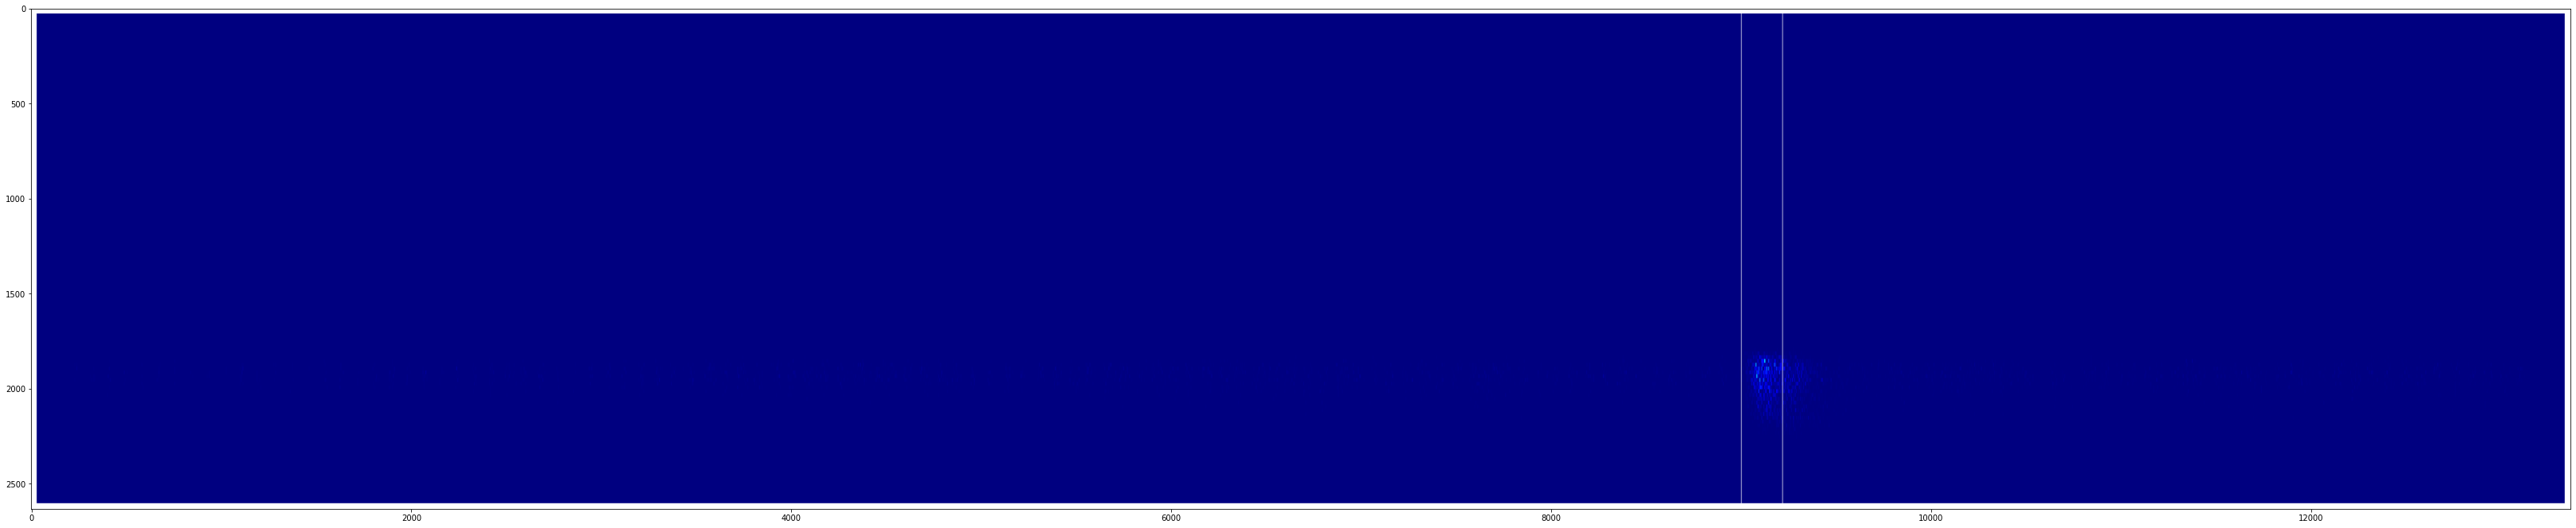

58187.94749500356 58259.884


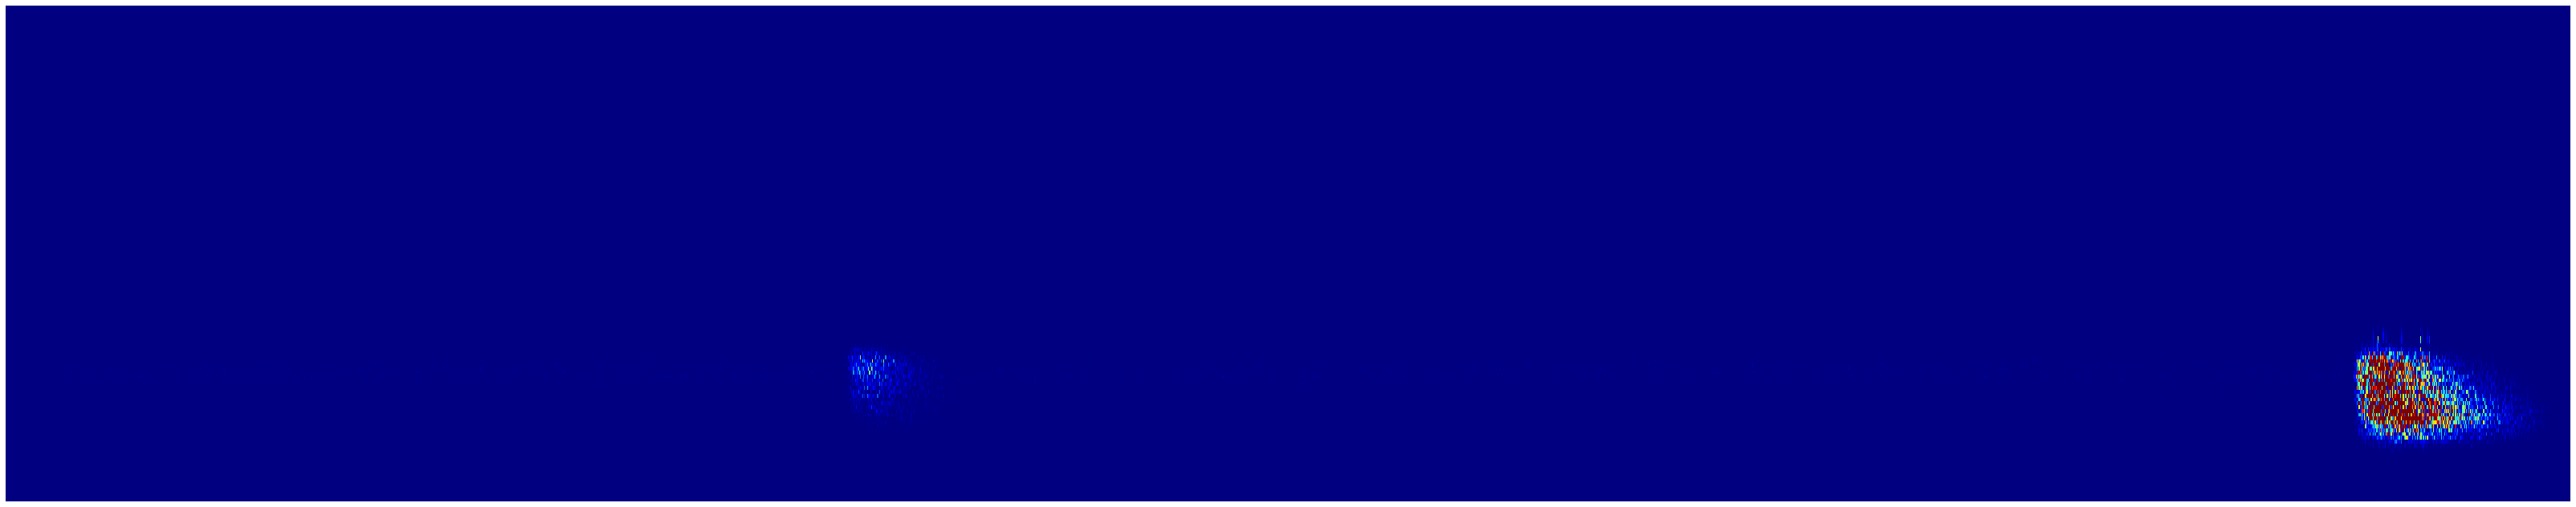

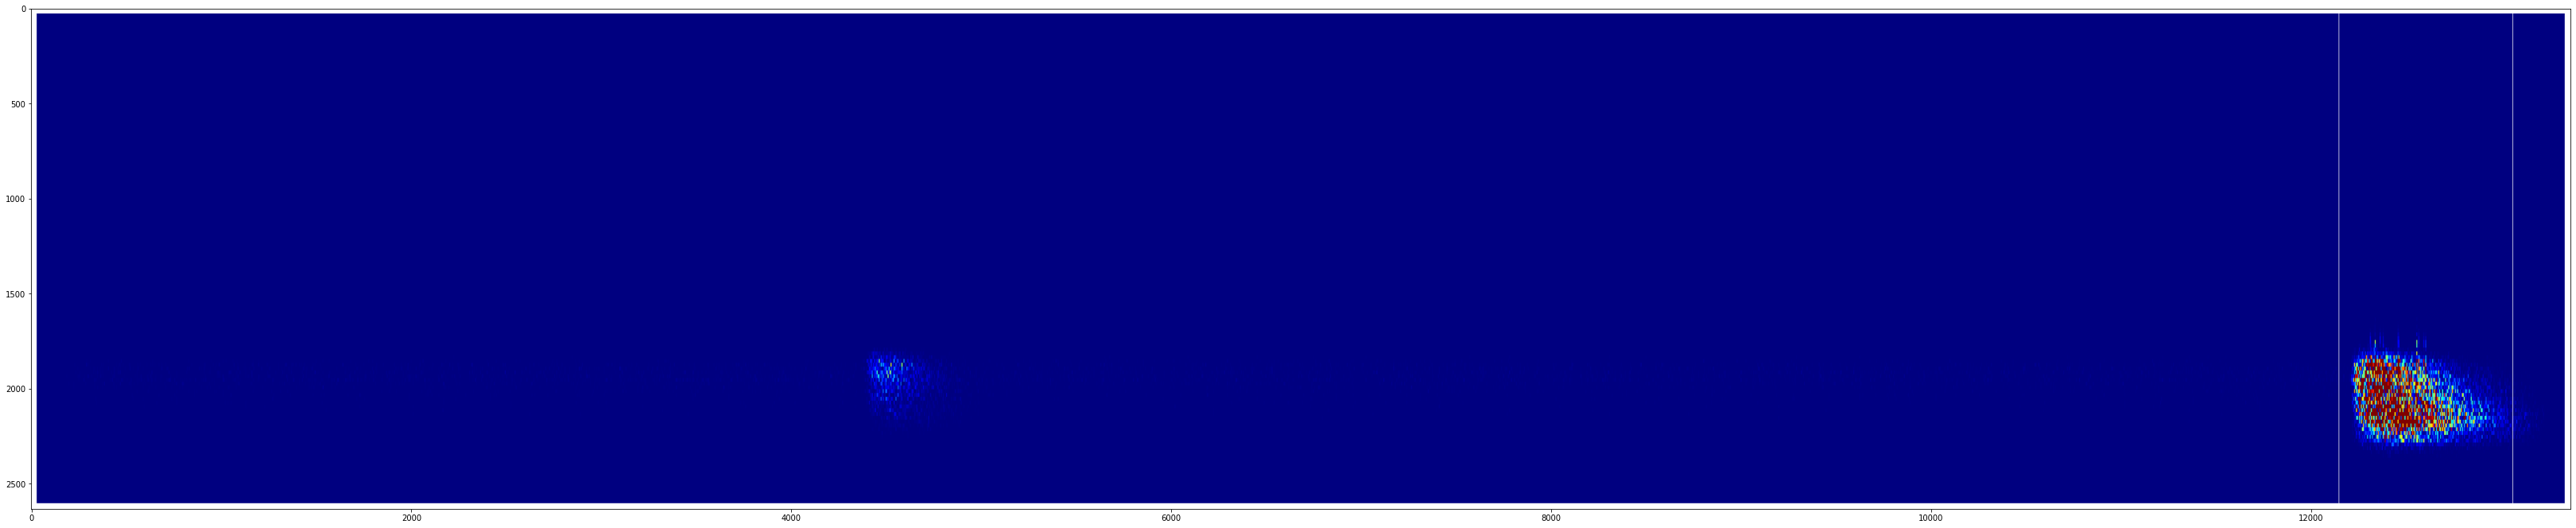

78521.09009405733 28199.816


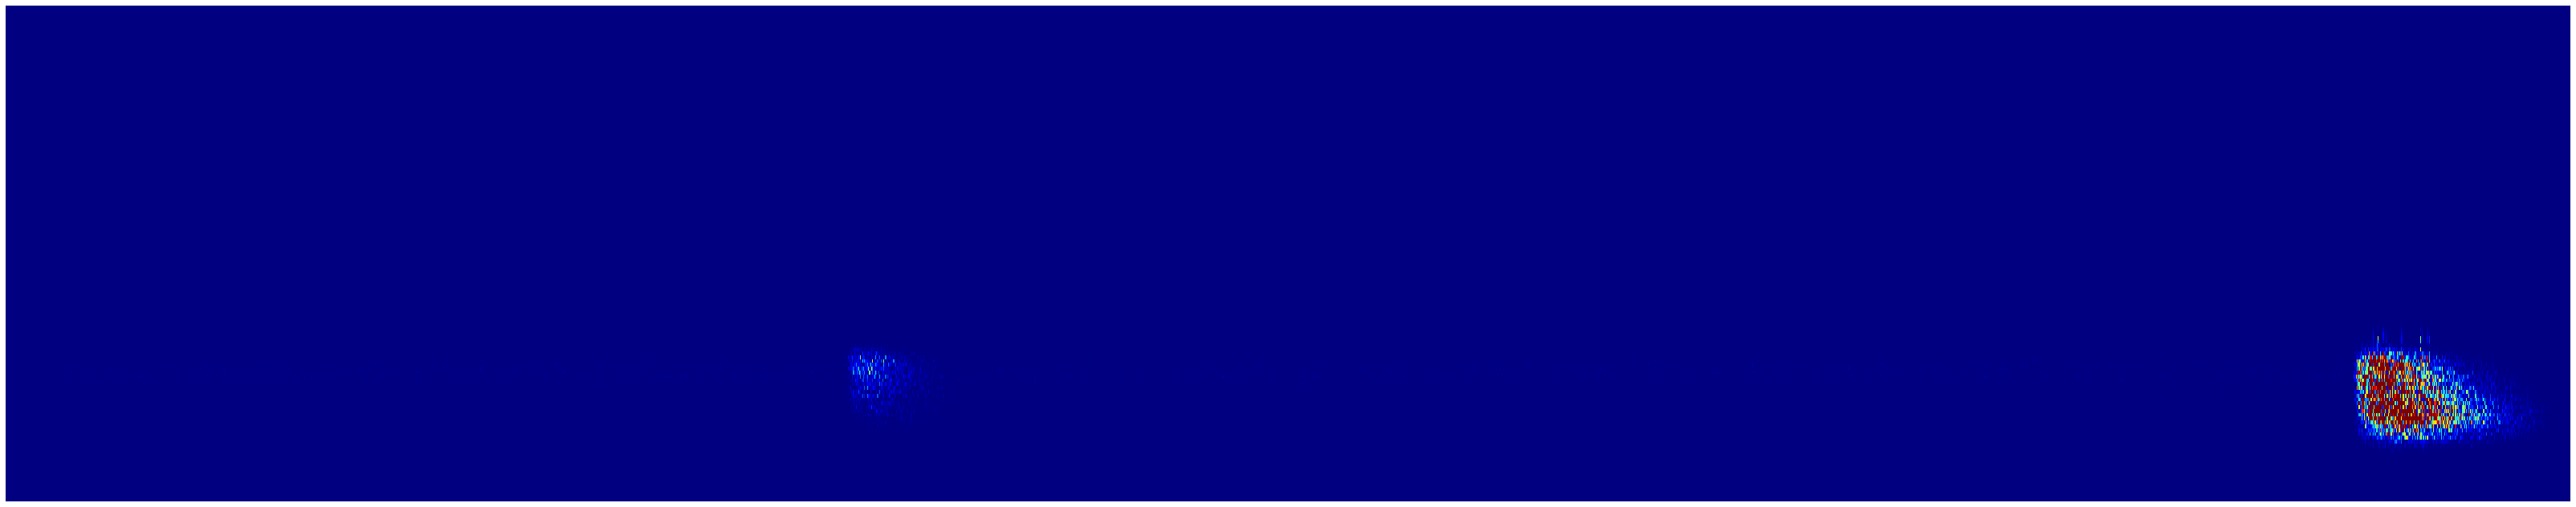

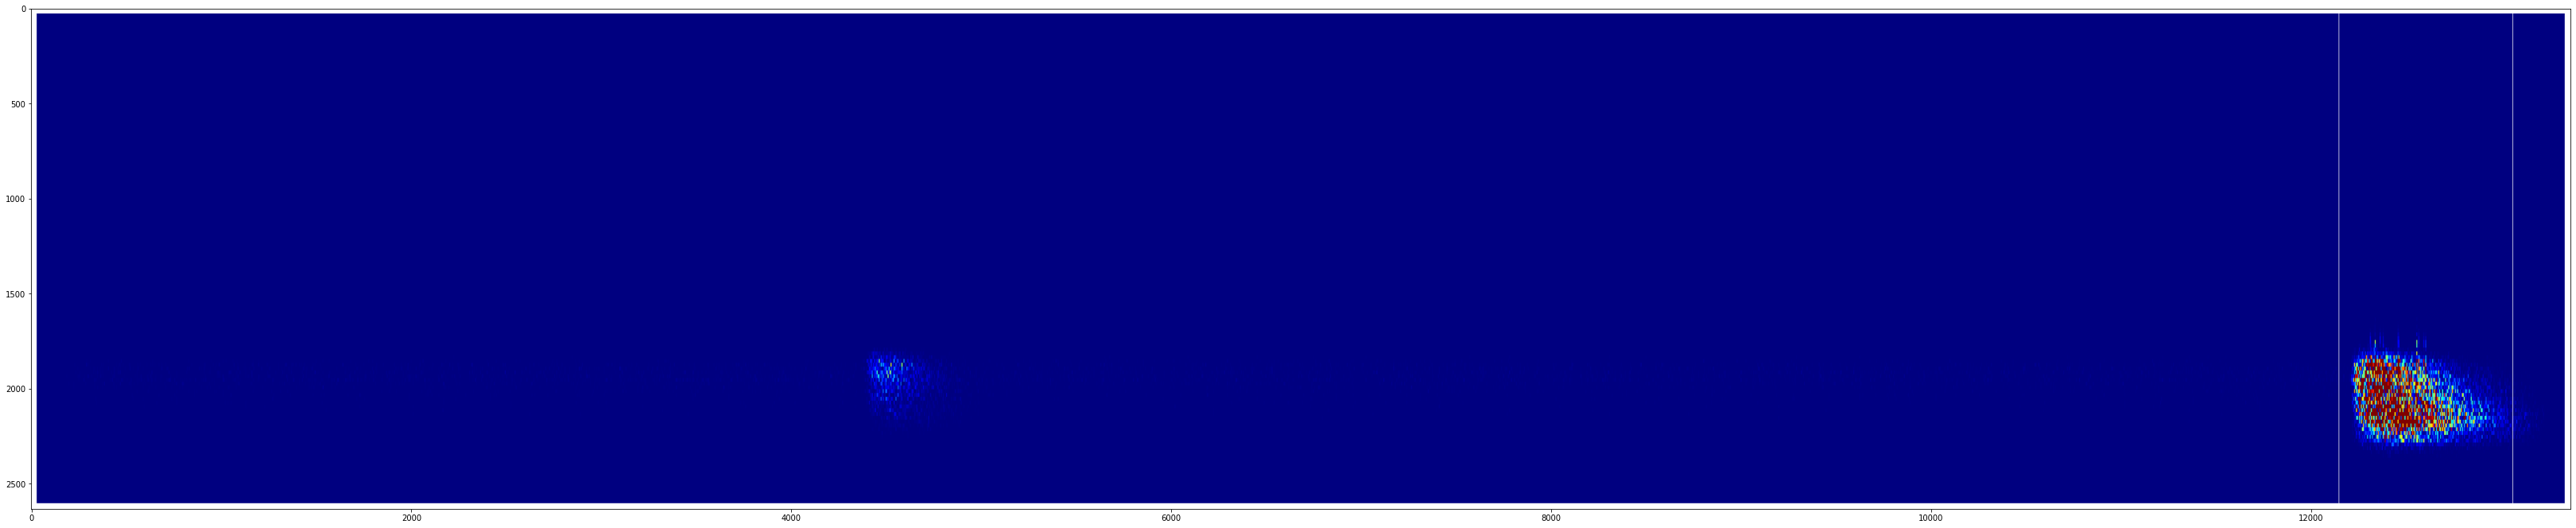

78521.09009405733 78959.816


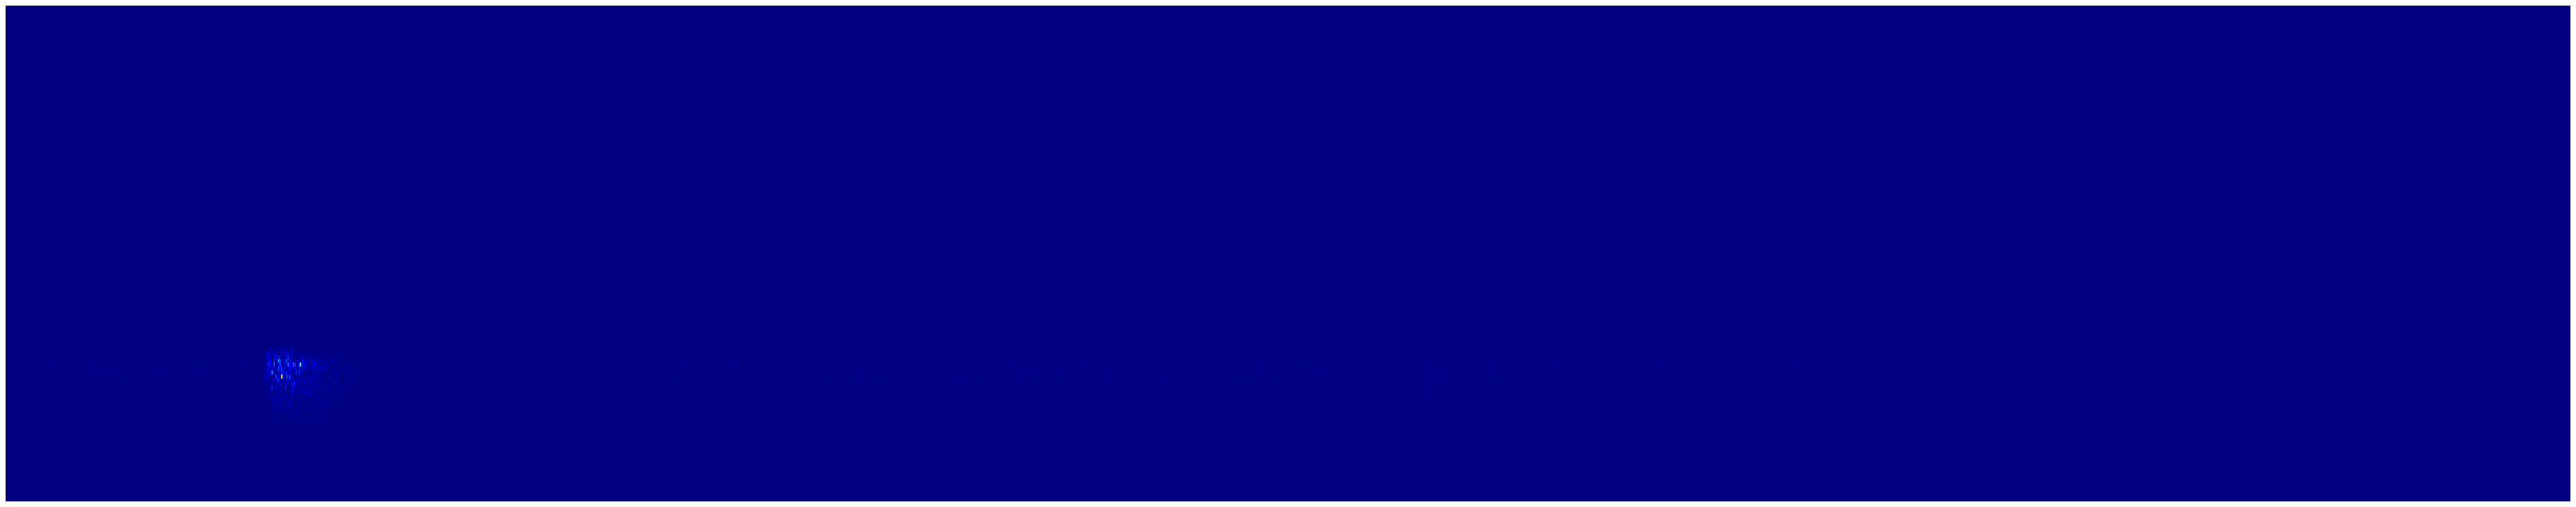

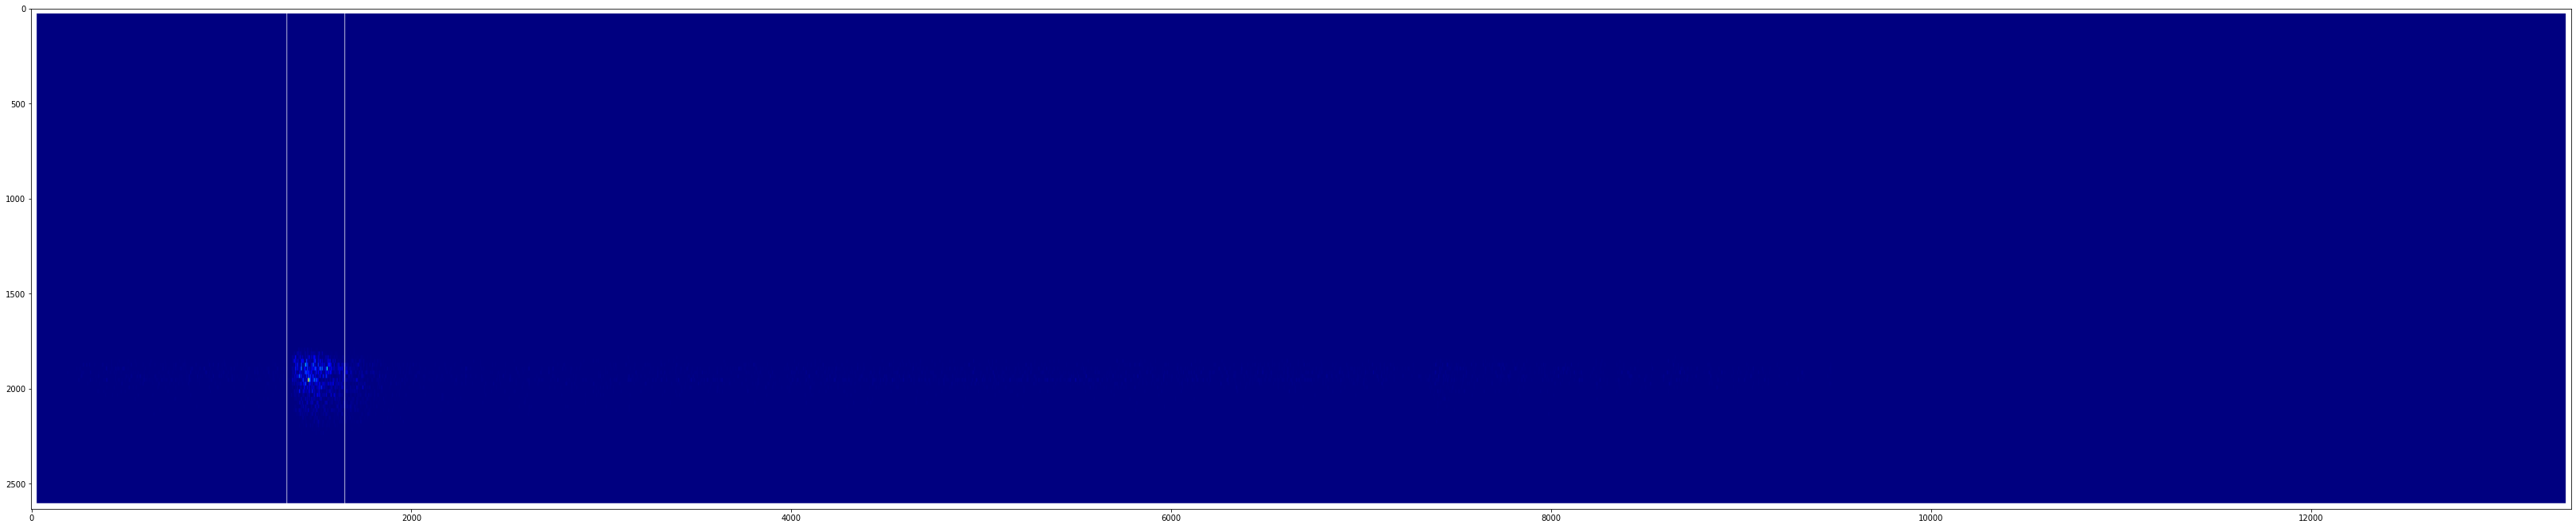

8699.719770107155 8579.864


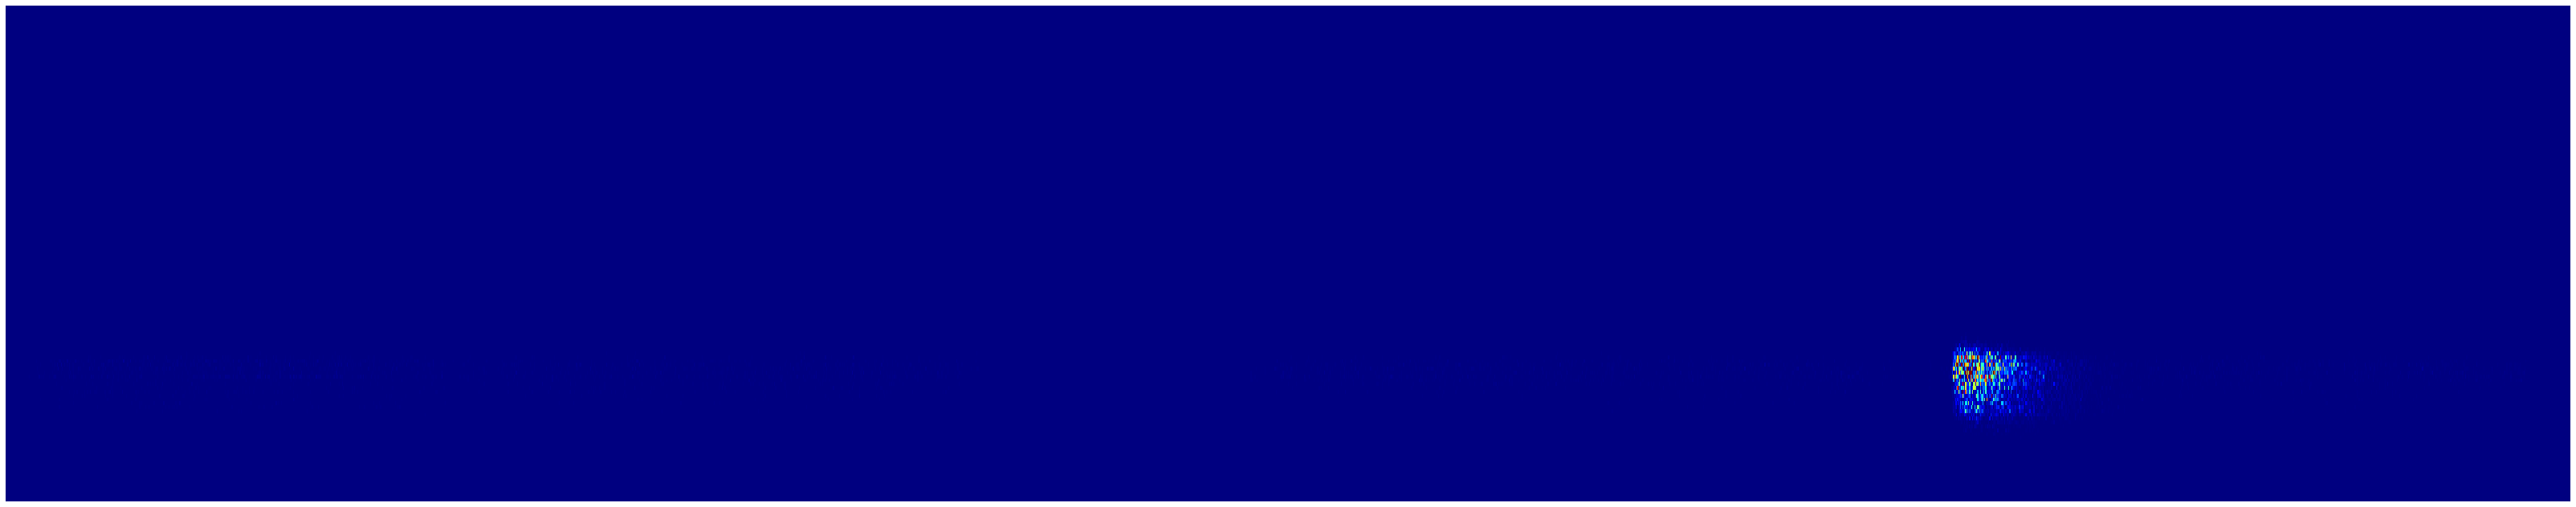

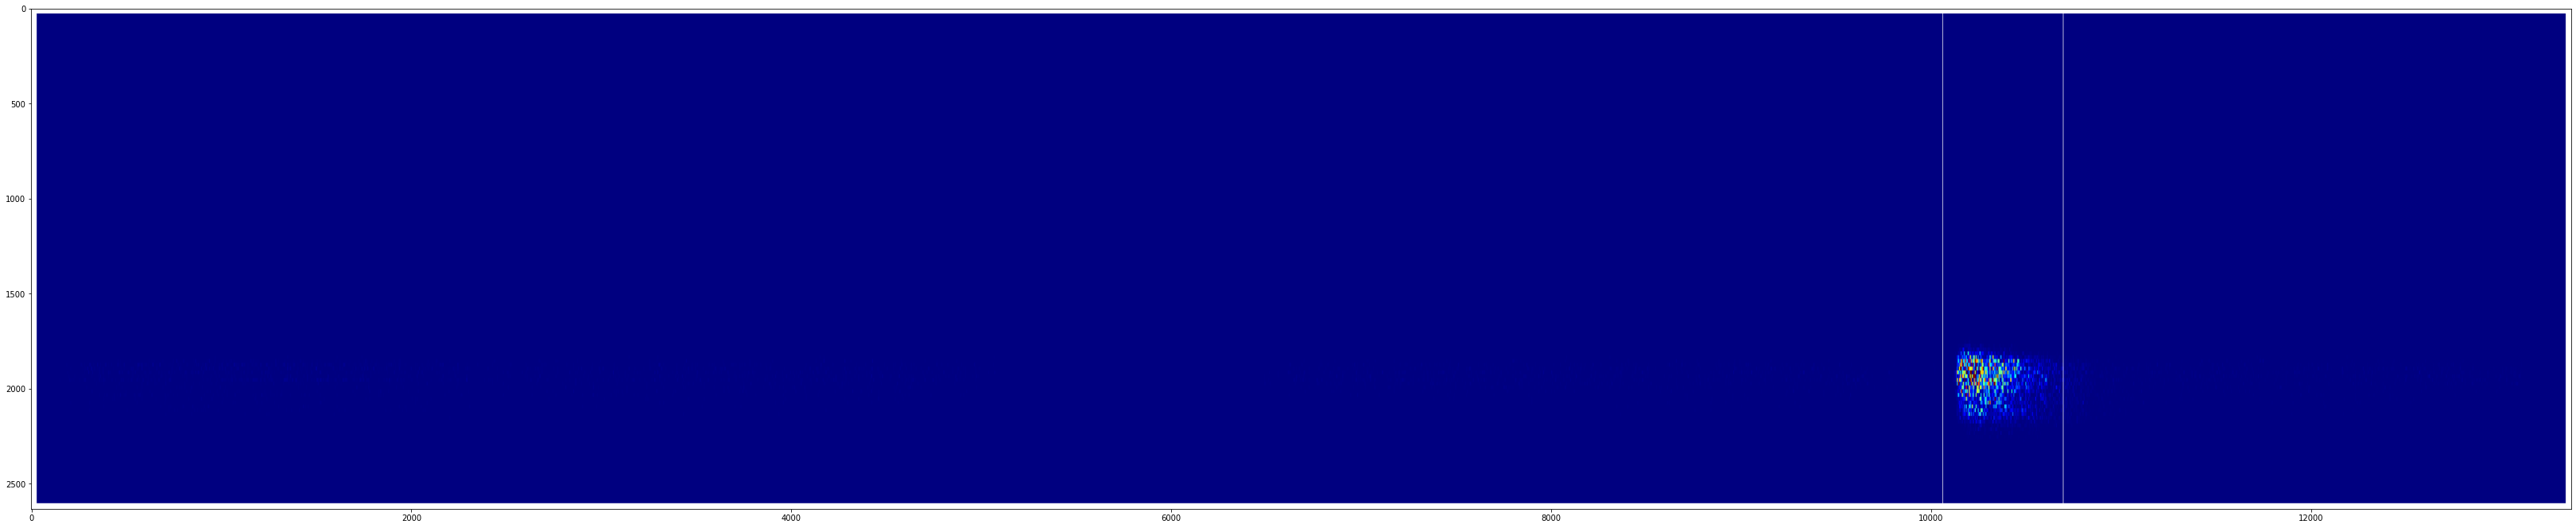

65021.33893386628 65279.378


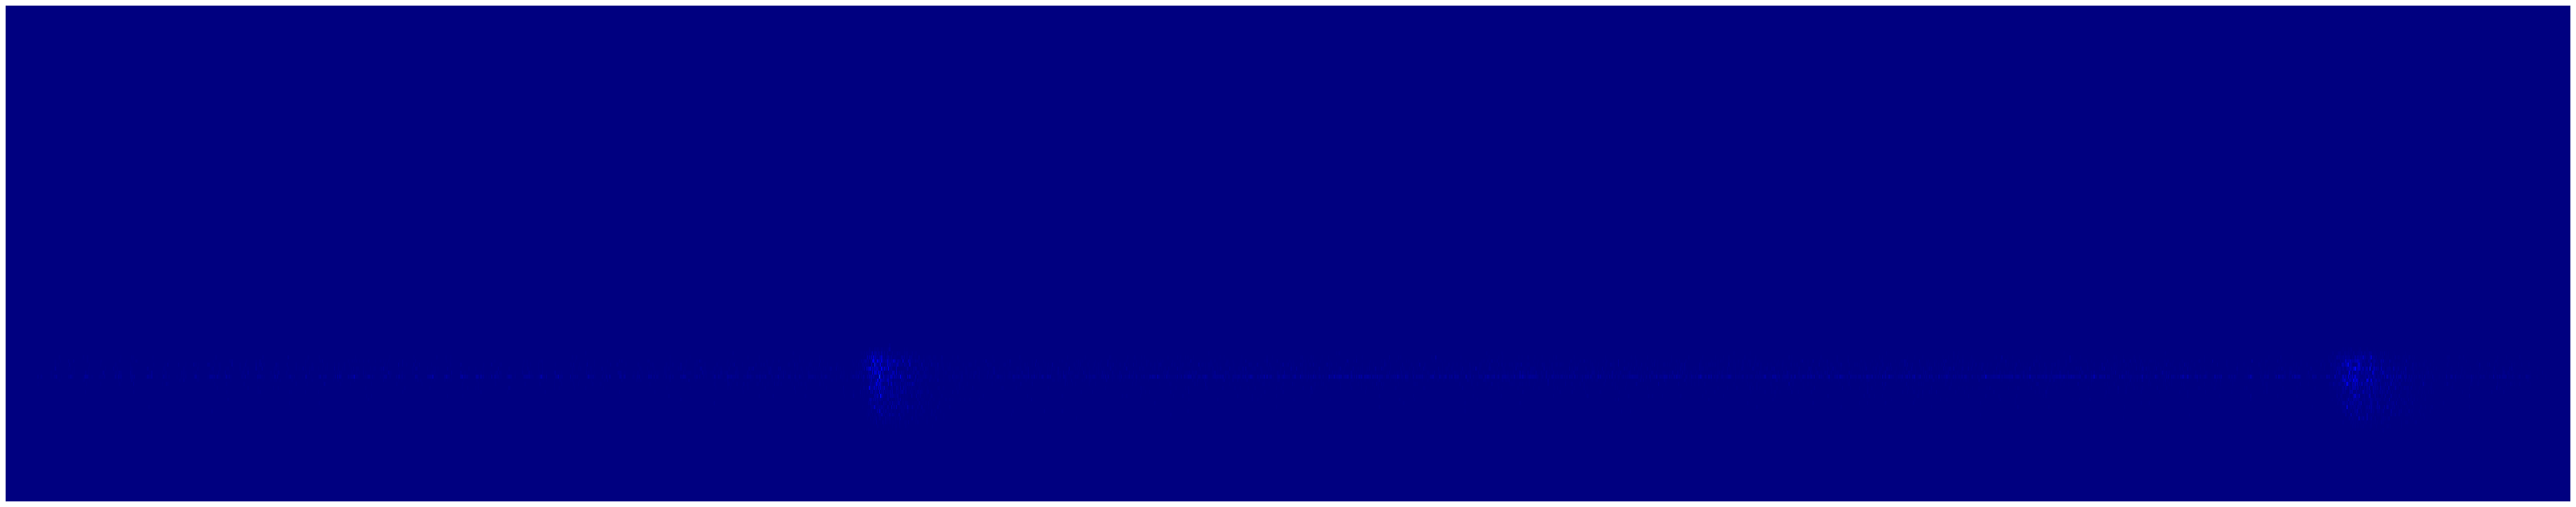

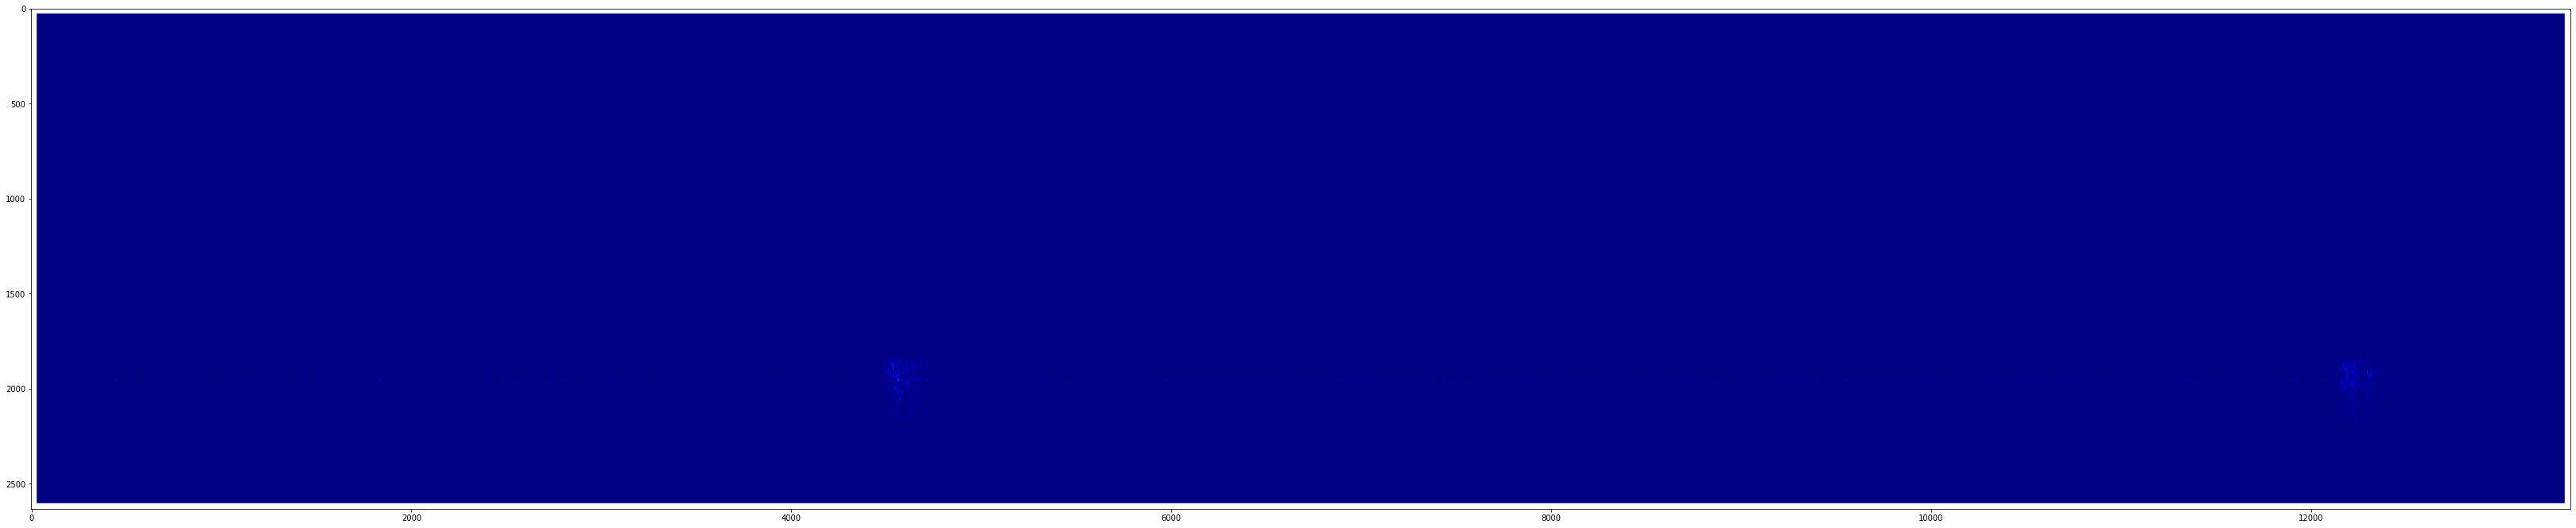

0.0 28679.561


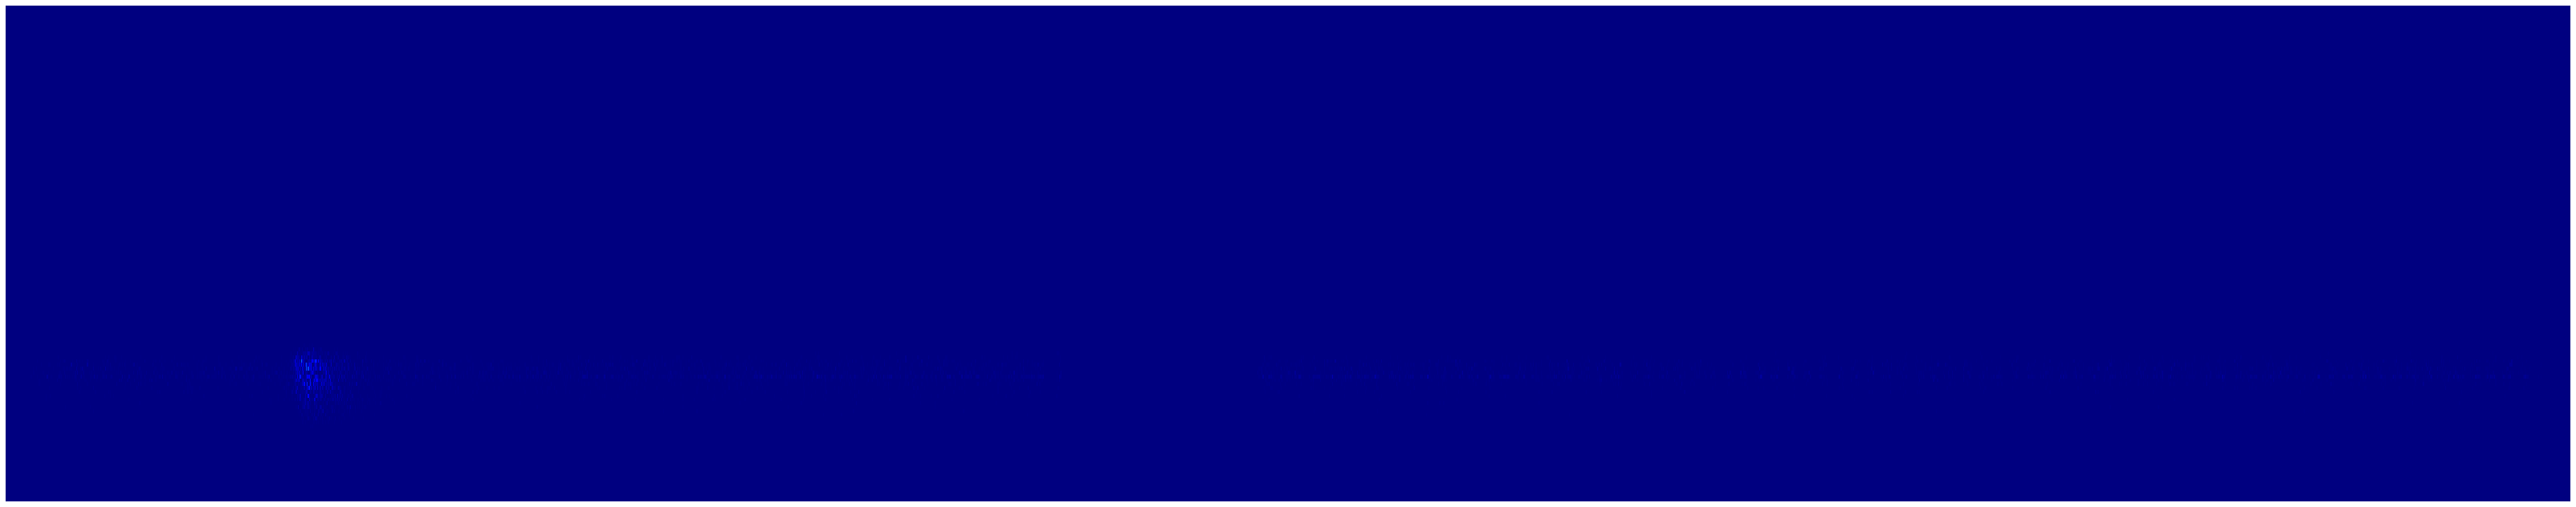

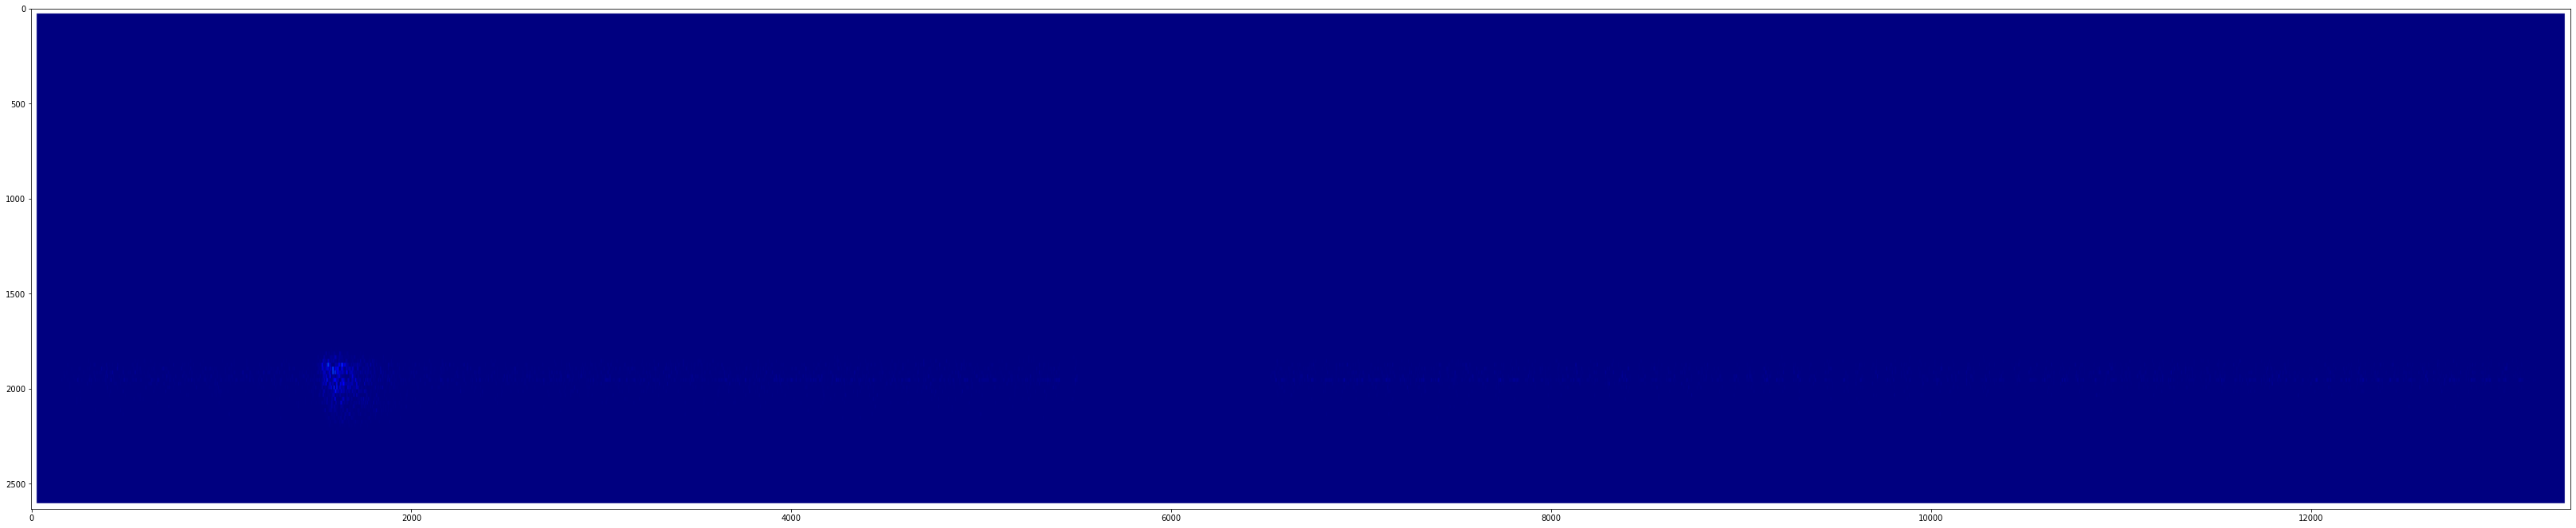

0.0 9479.448


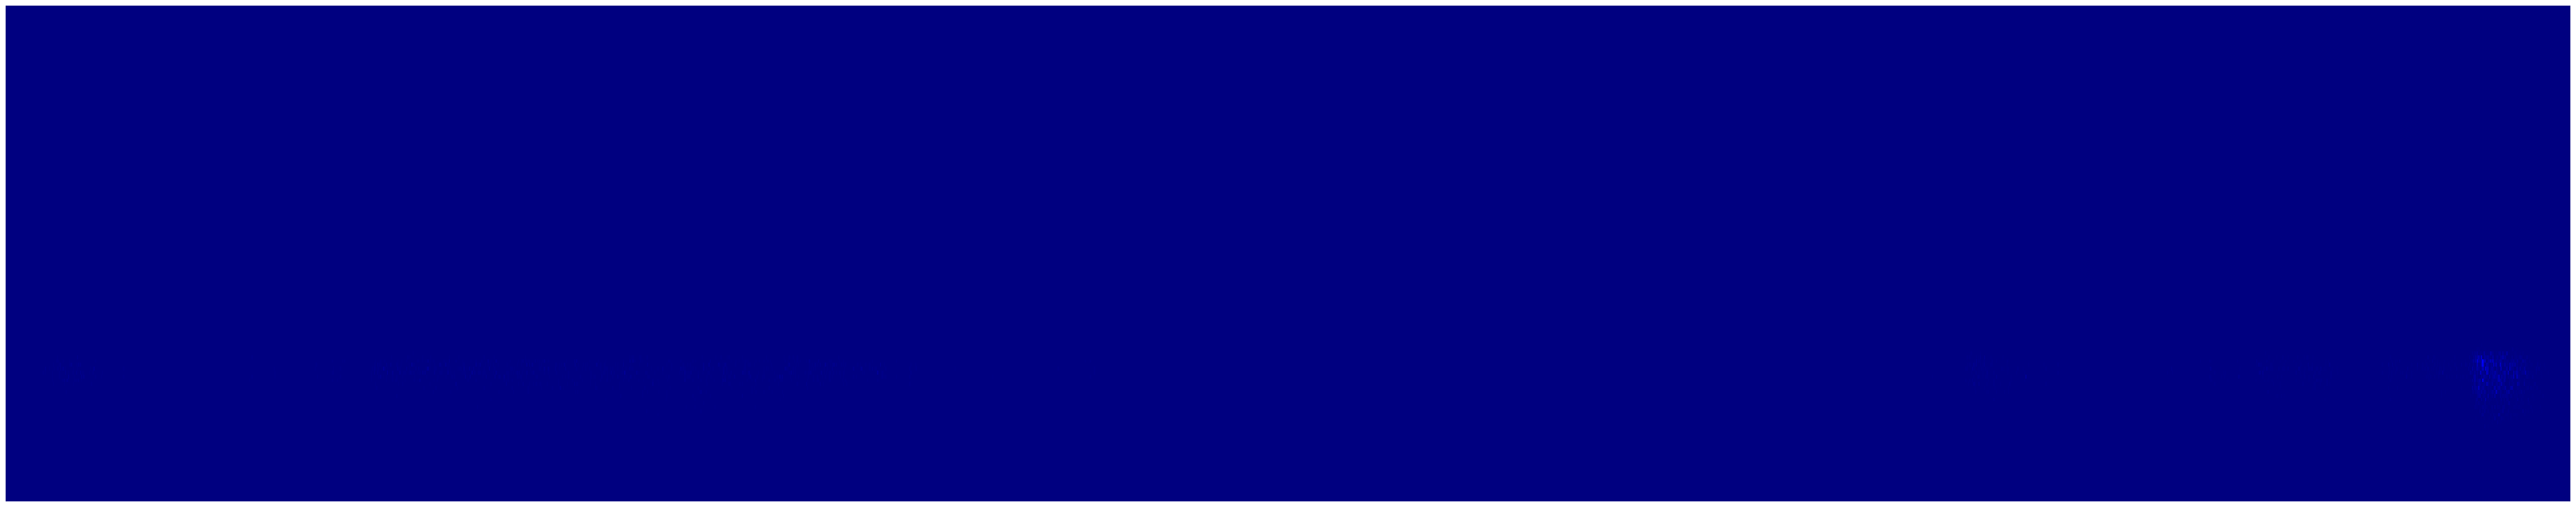

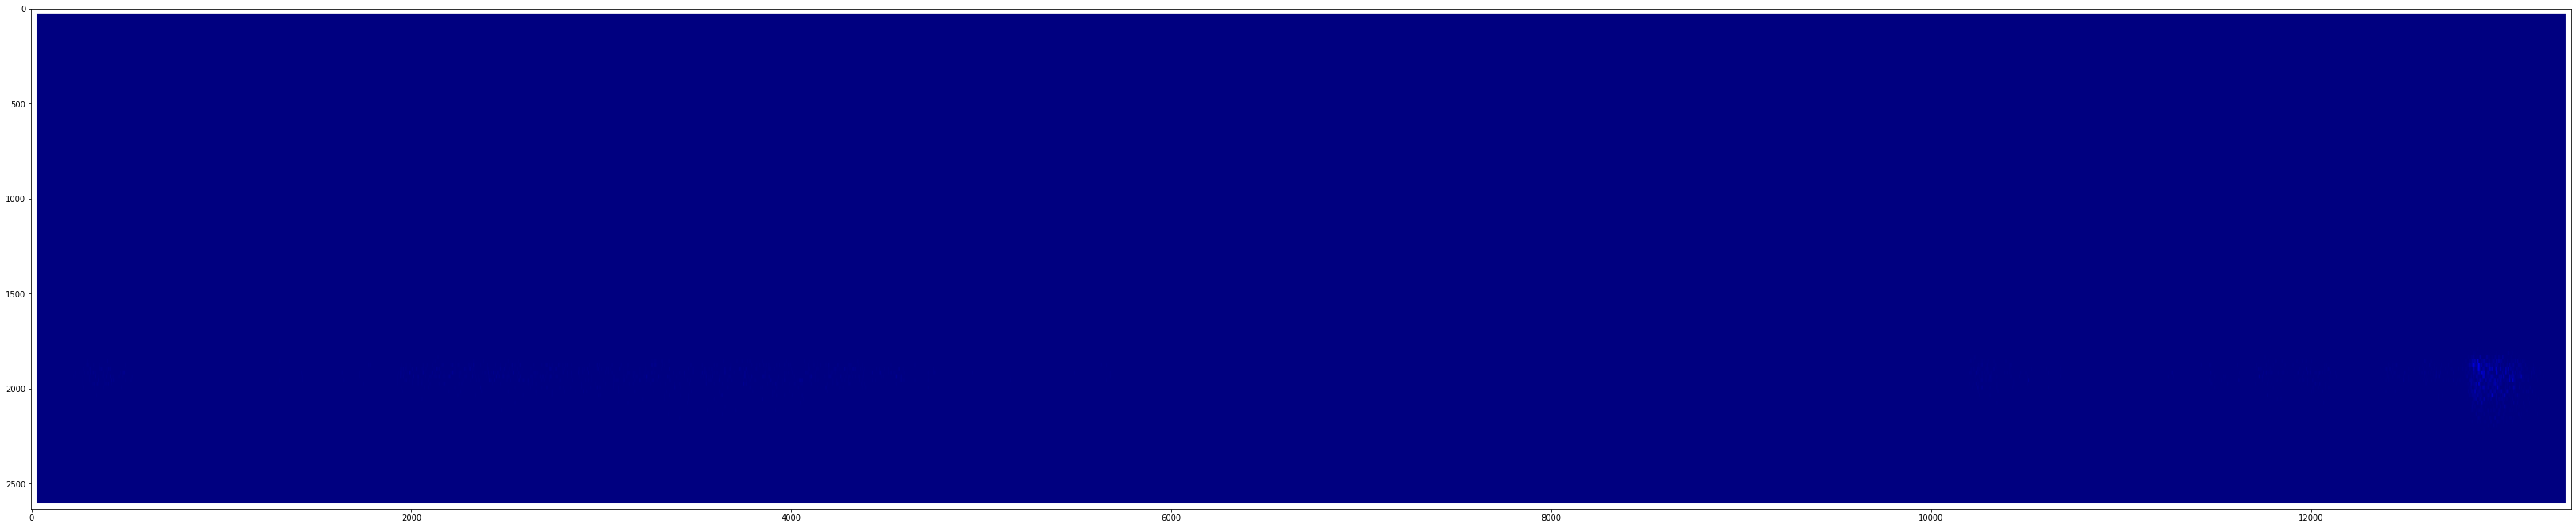

0.0 82859.338


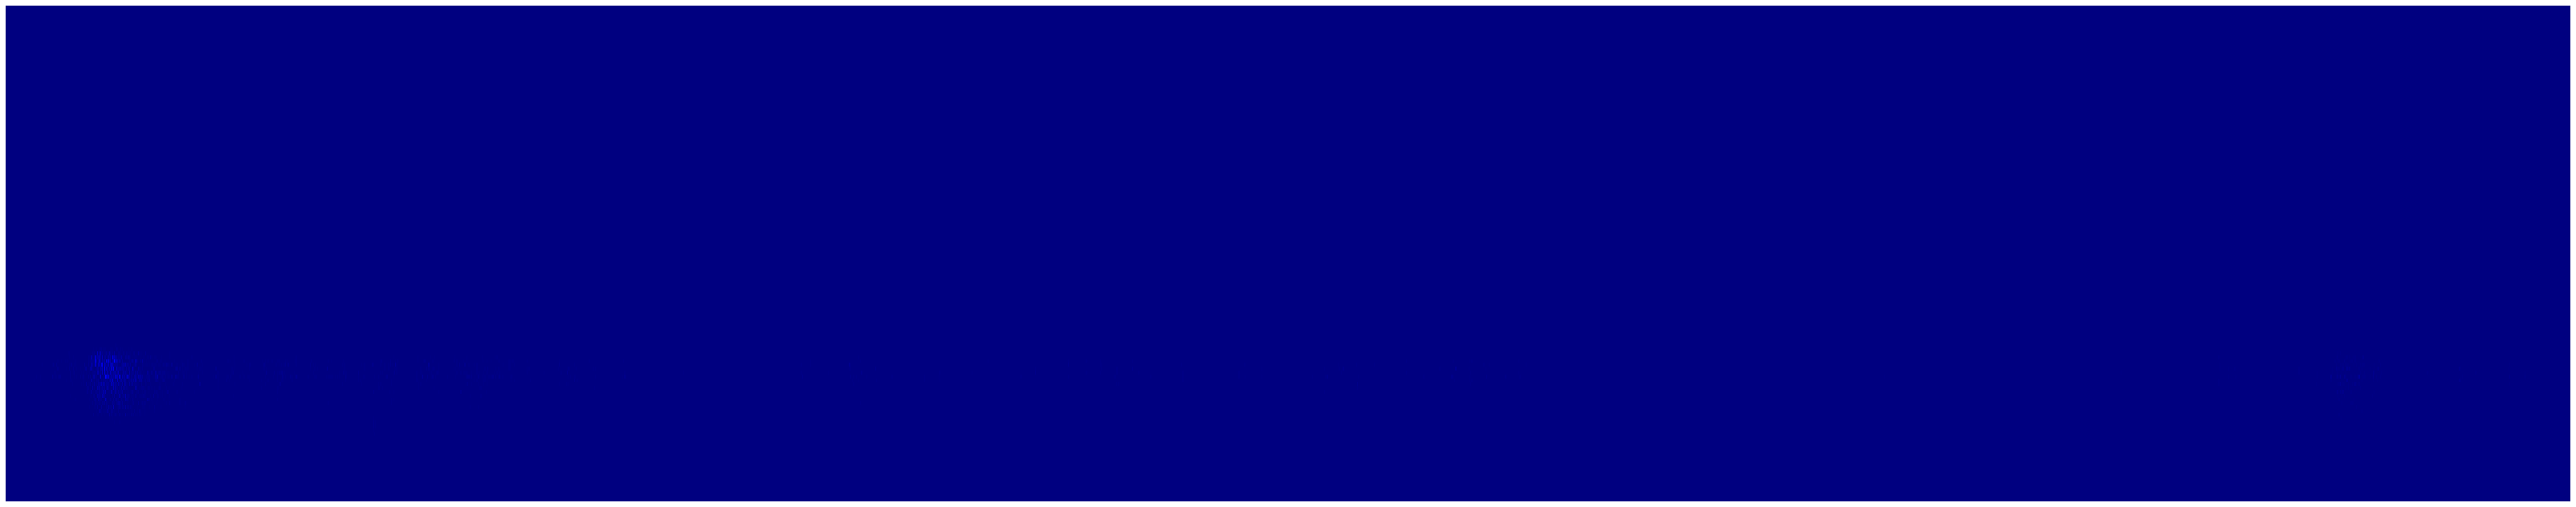

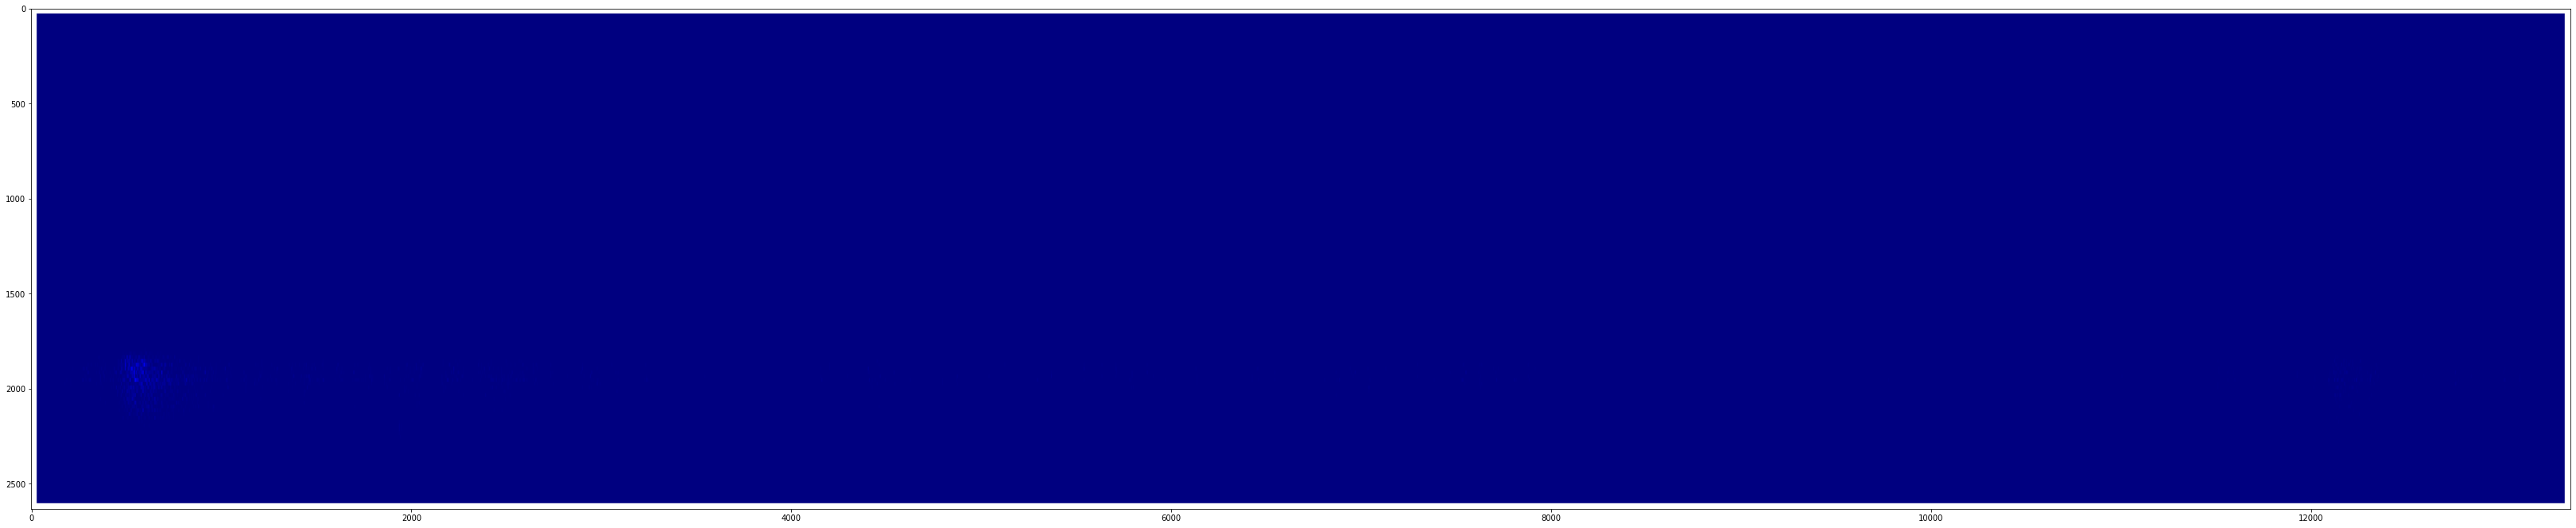

0.0 2639.405


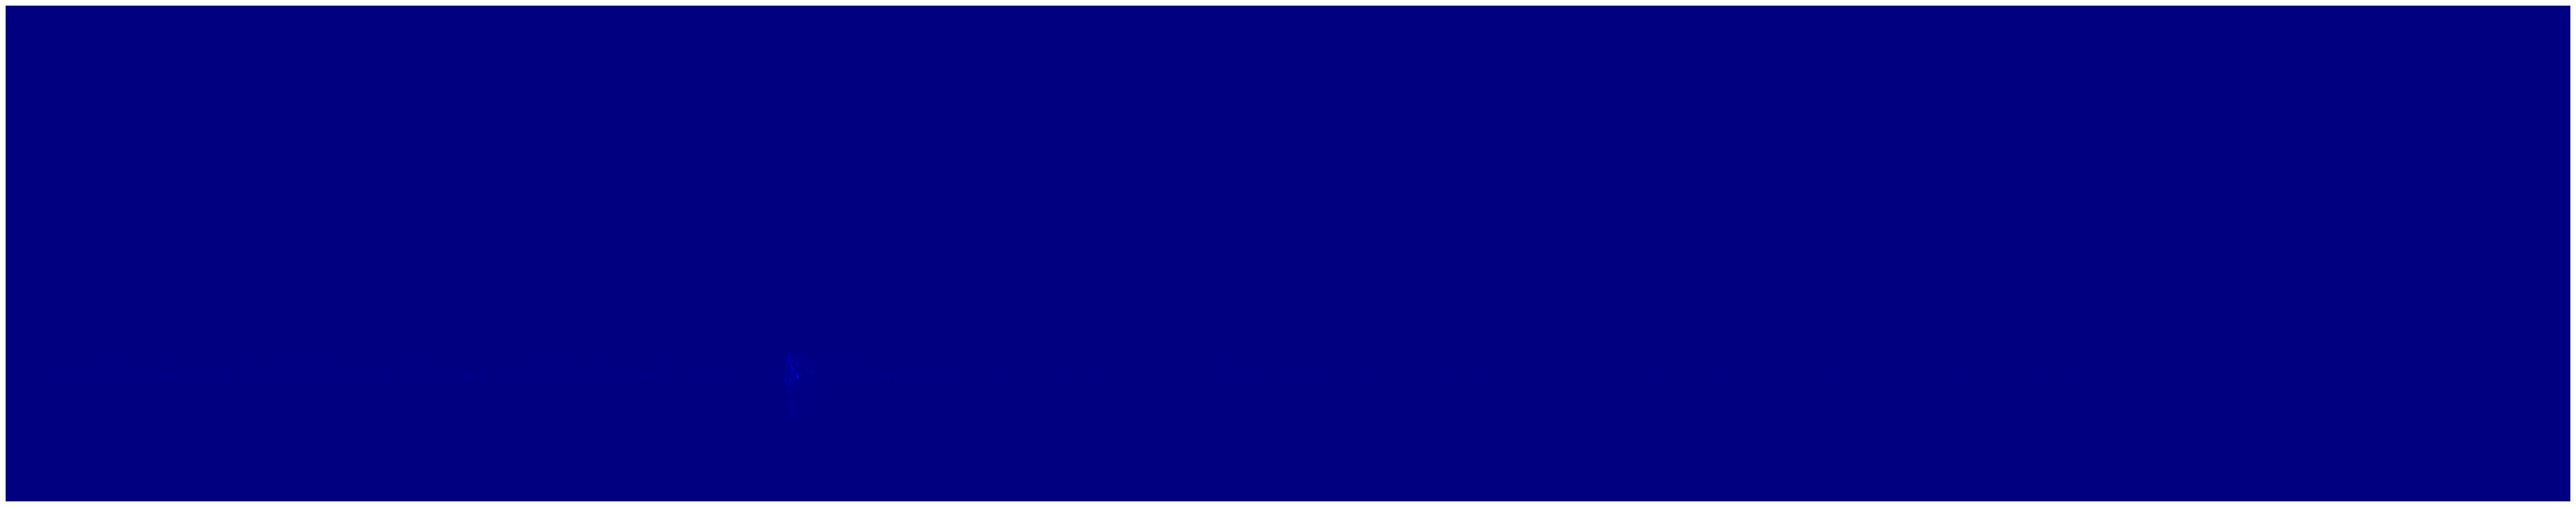

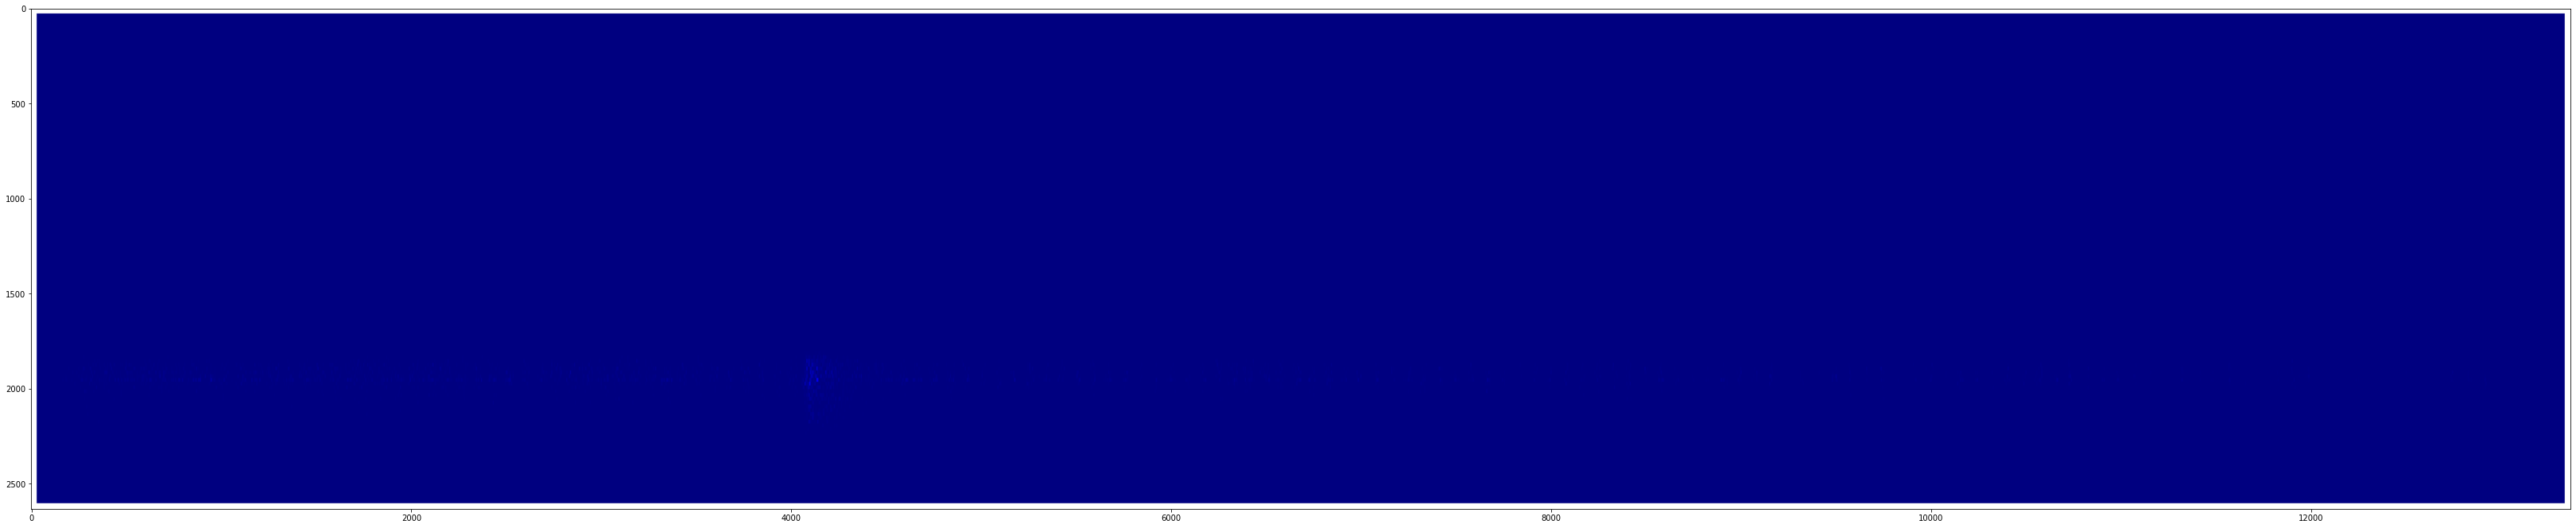

0.0 26099.655


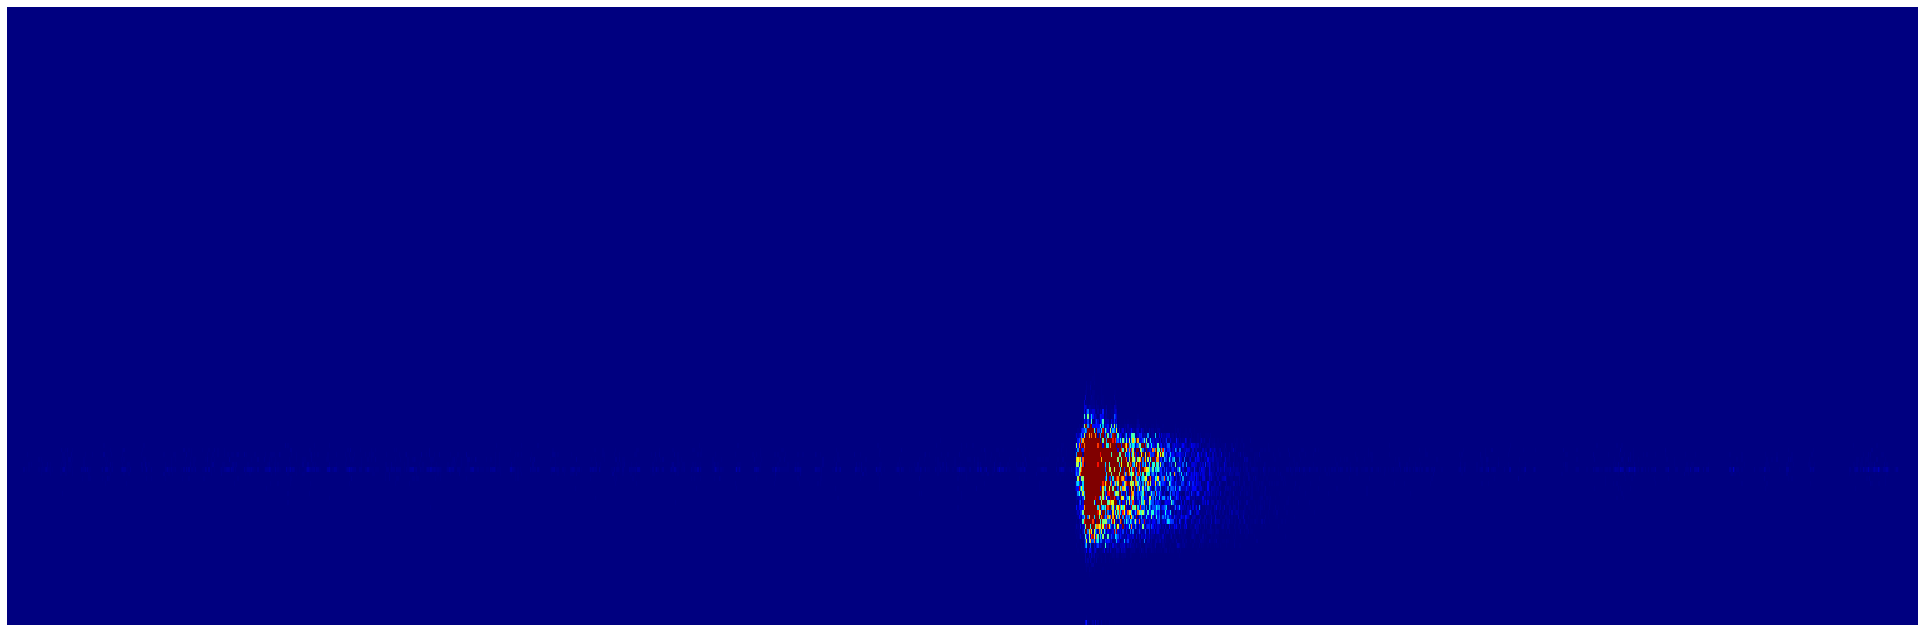

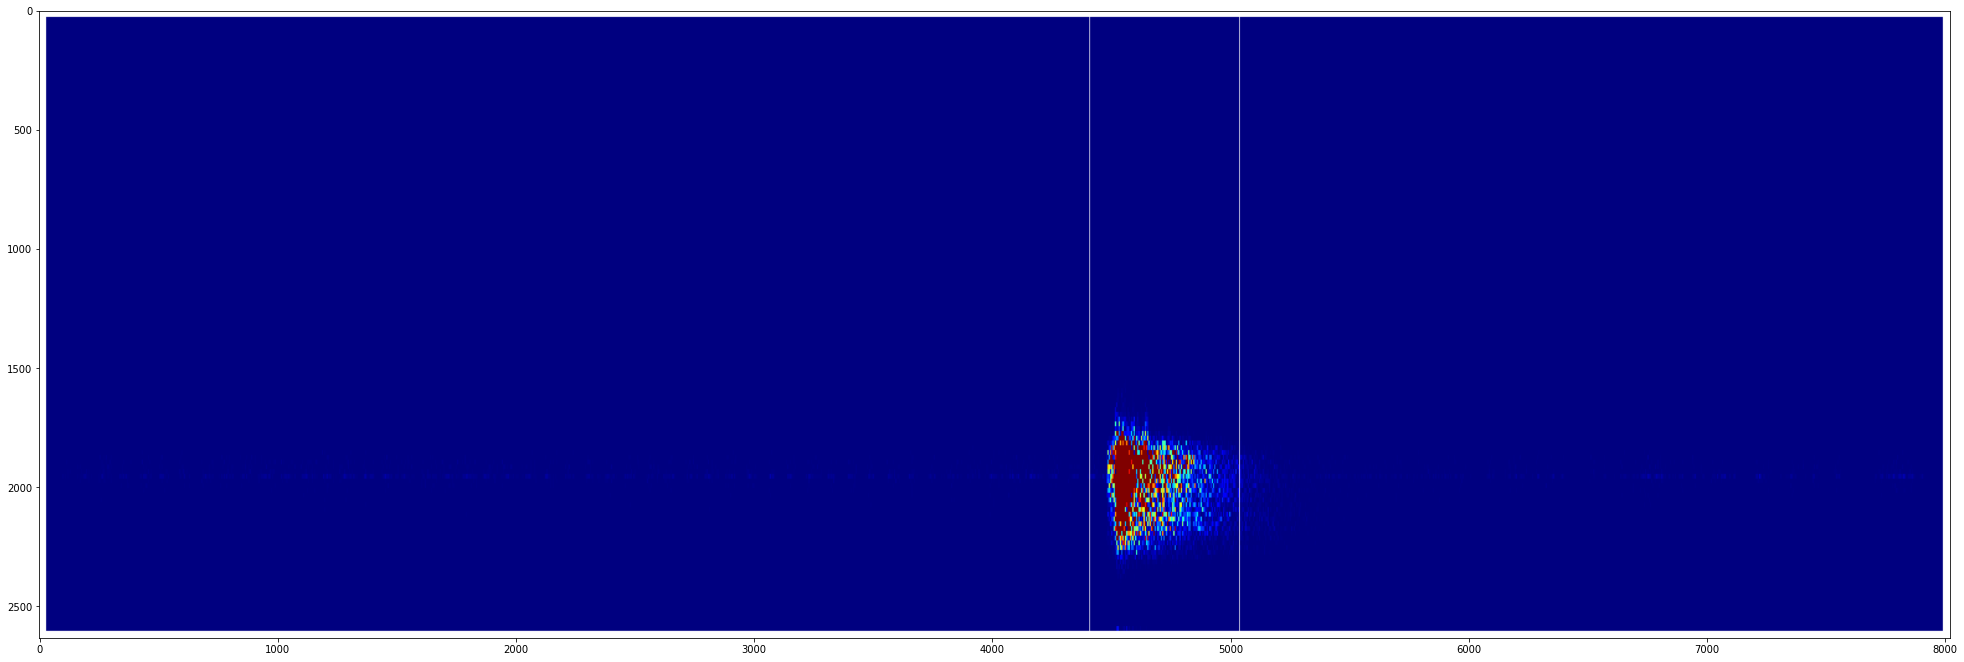

28410.86327577283 28859.528


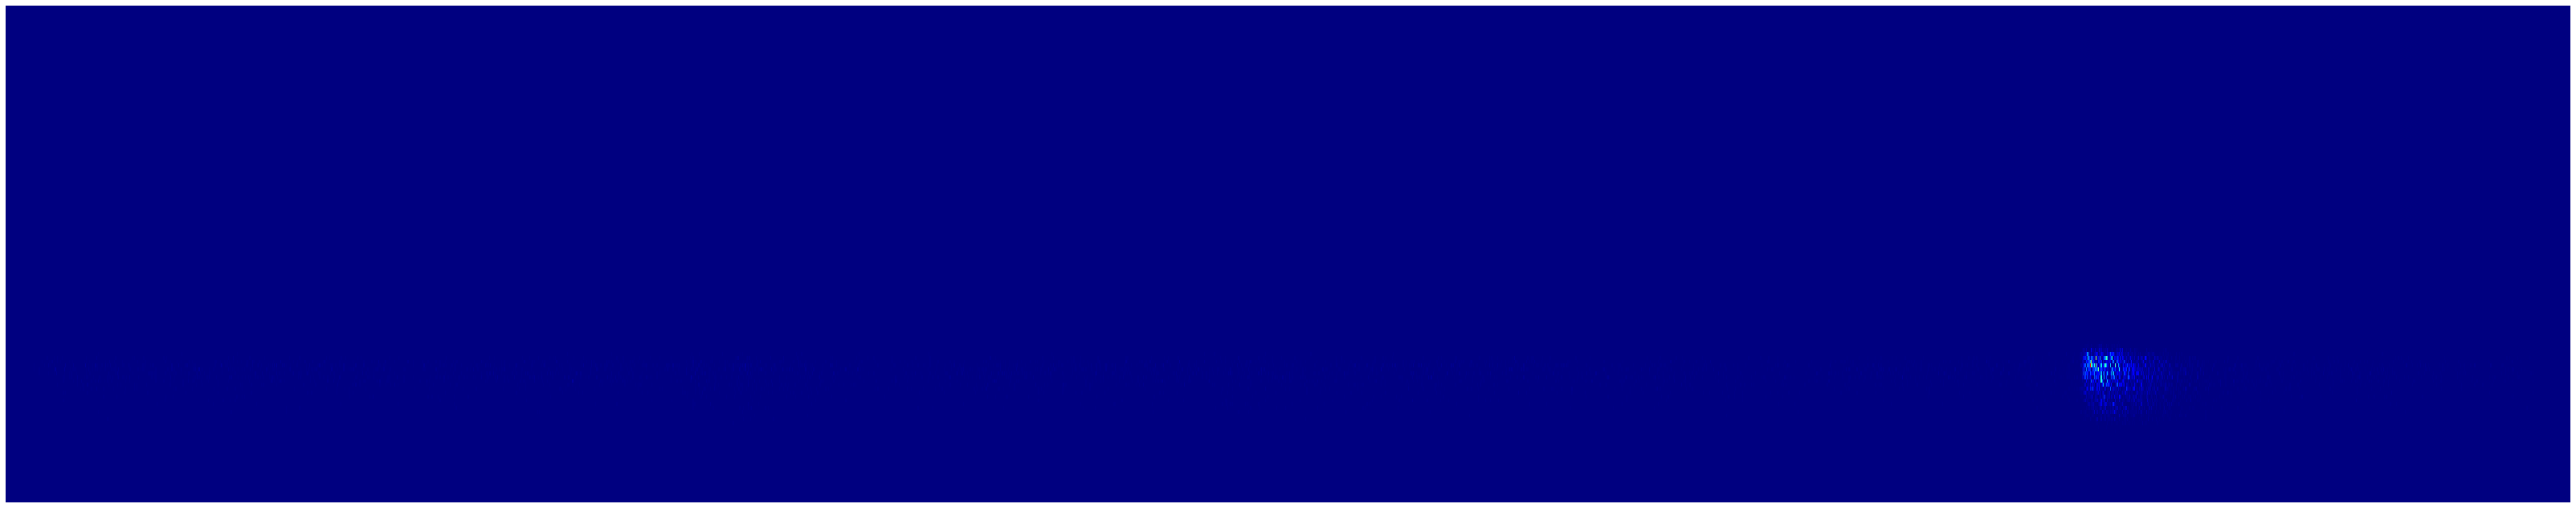

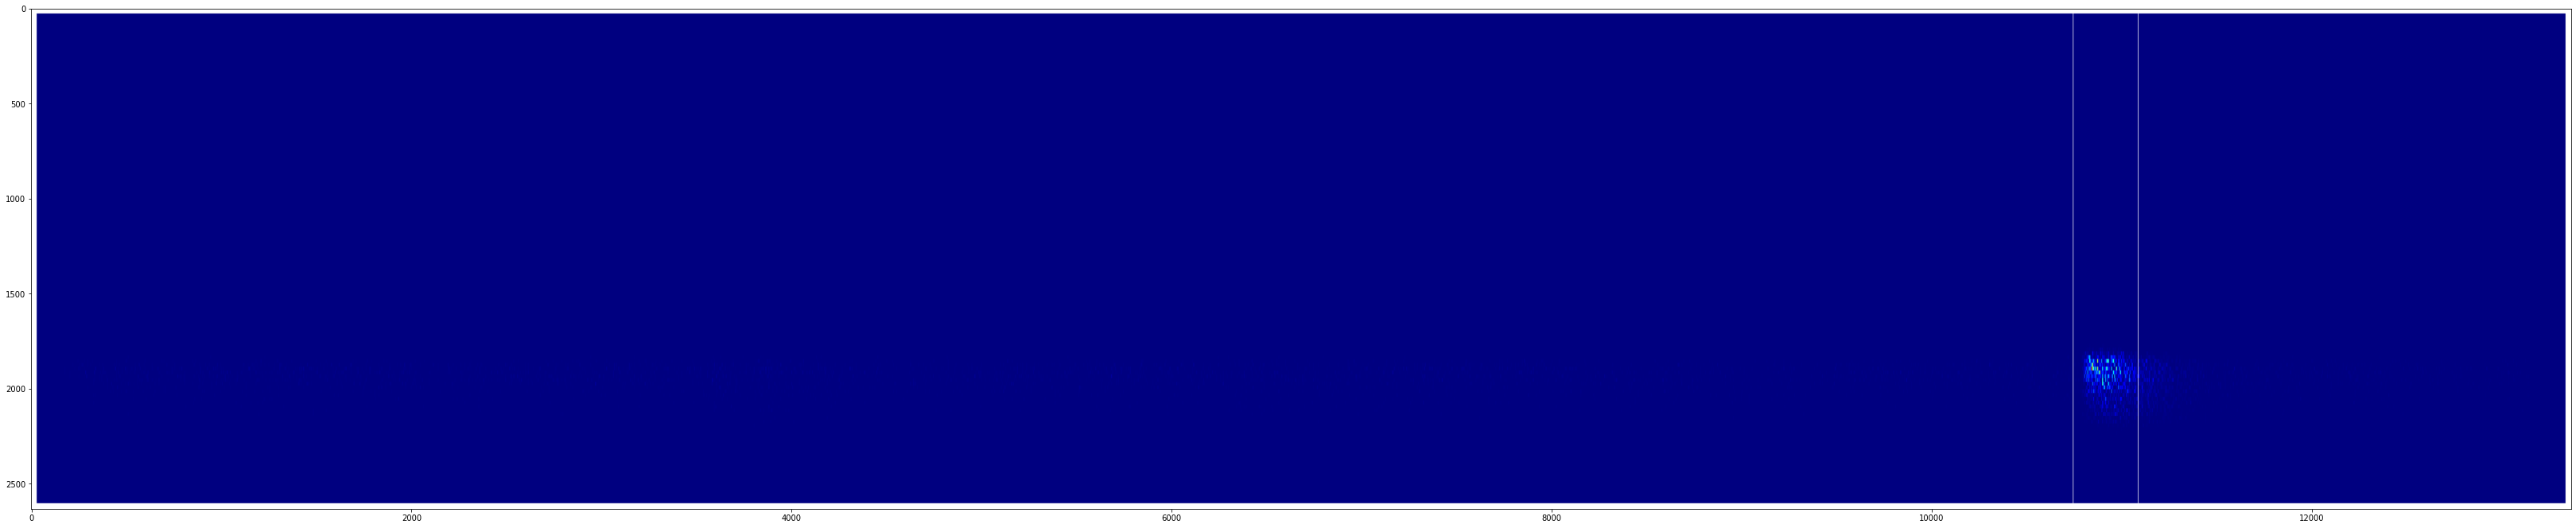

69439.41641996485 69779.394


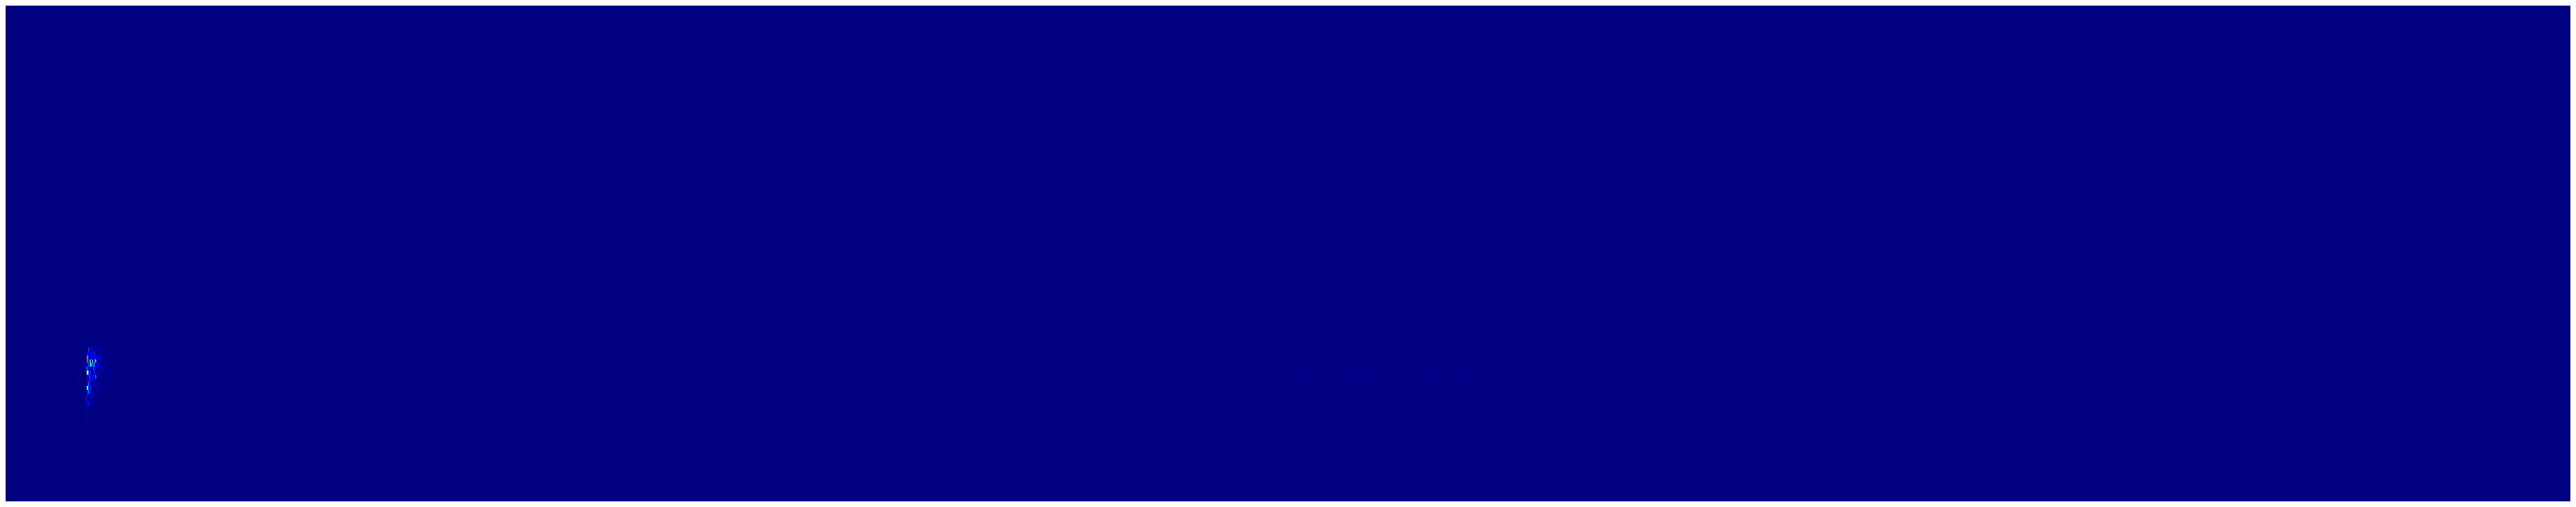

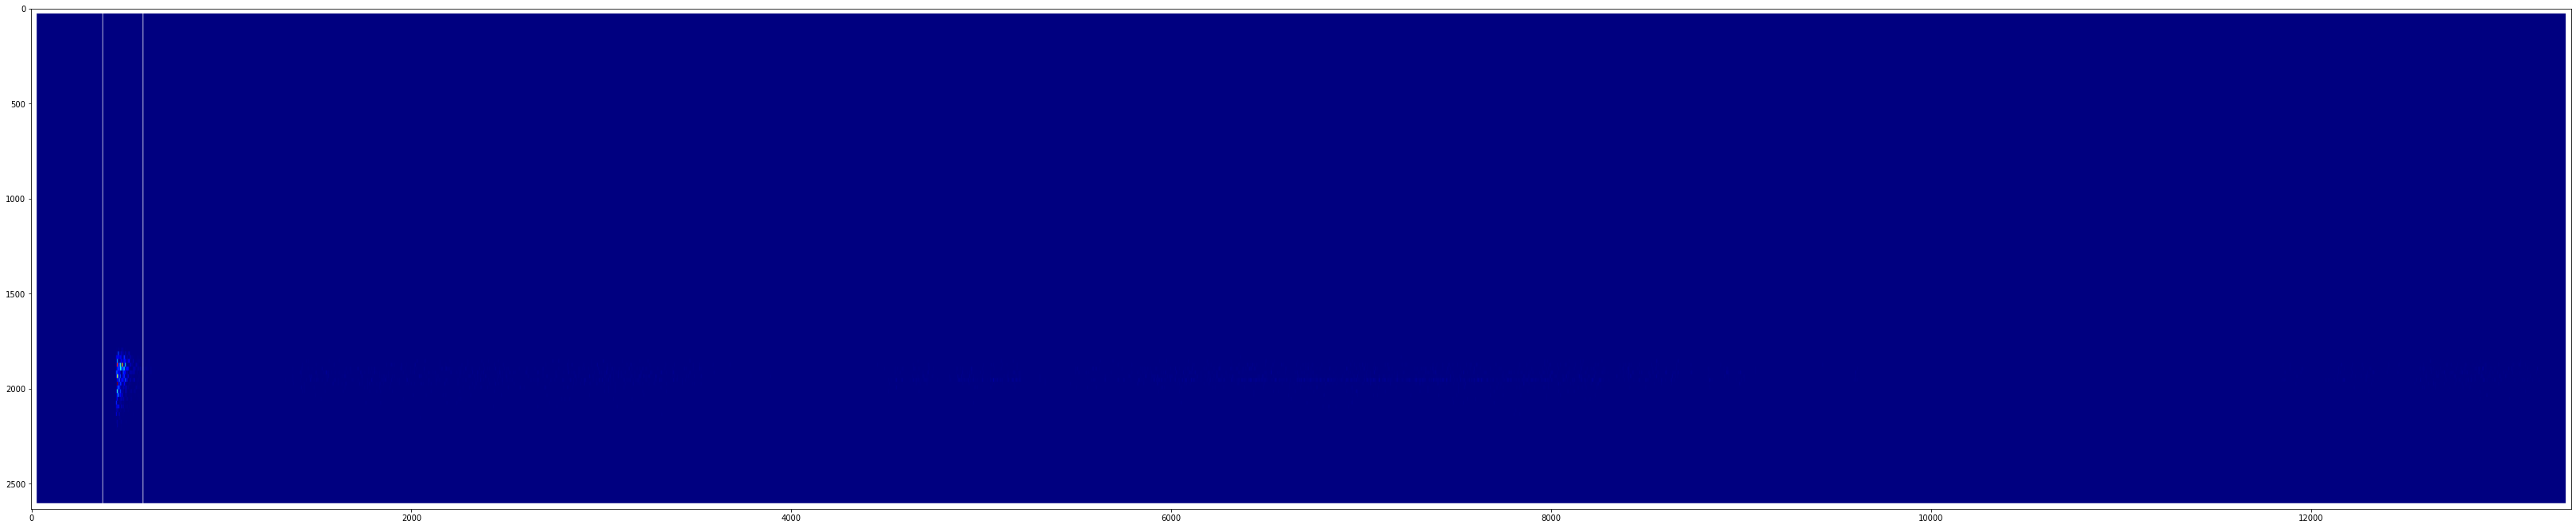

2436.684371577295 2639.603


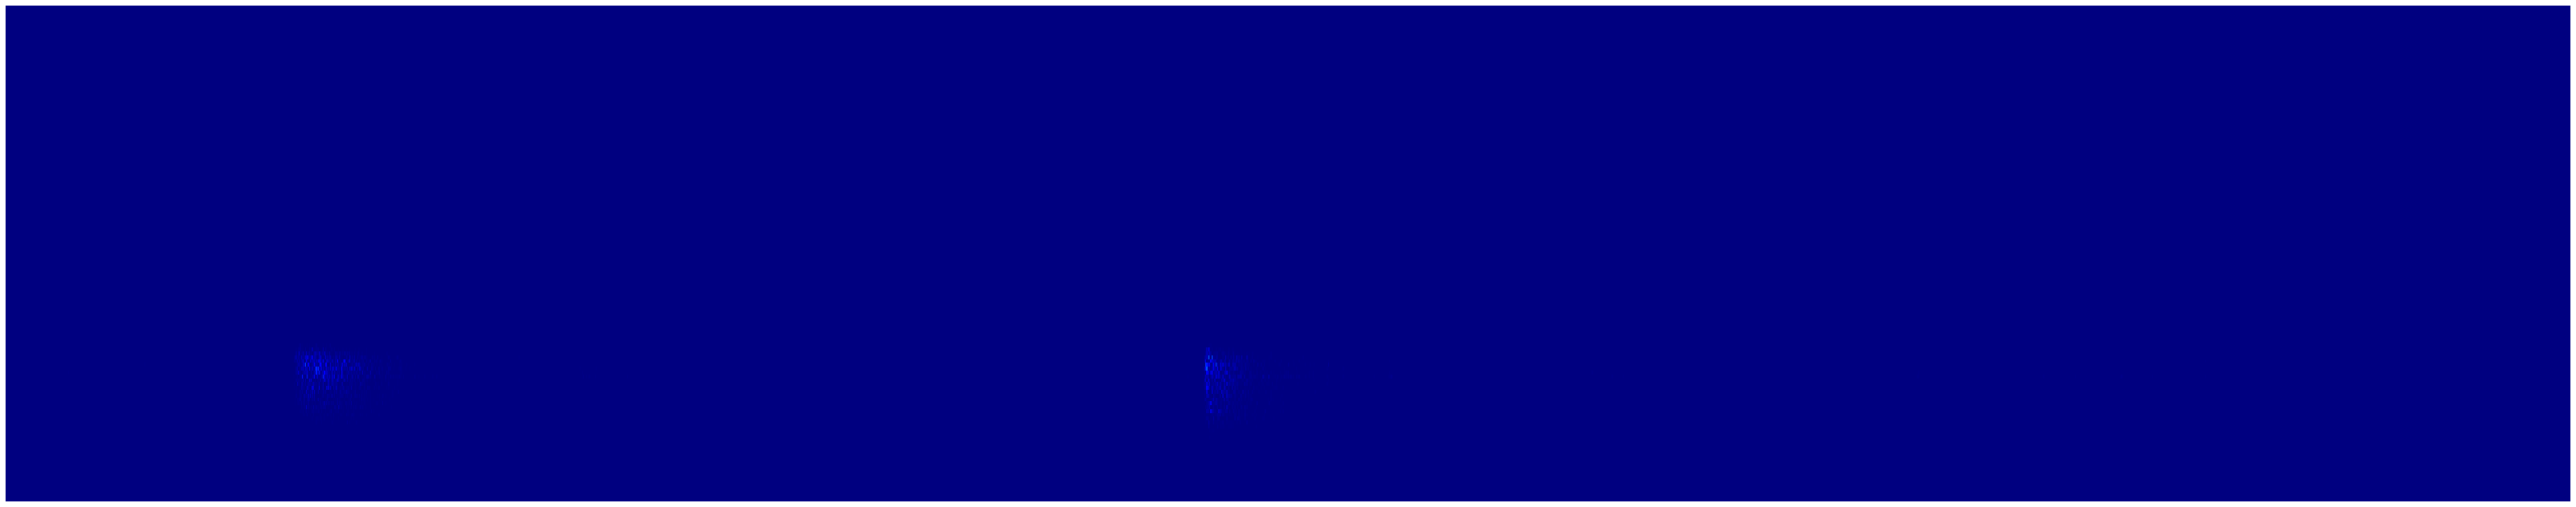

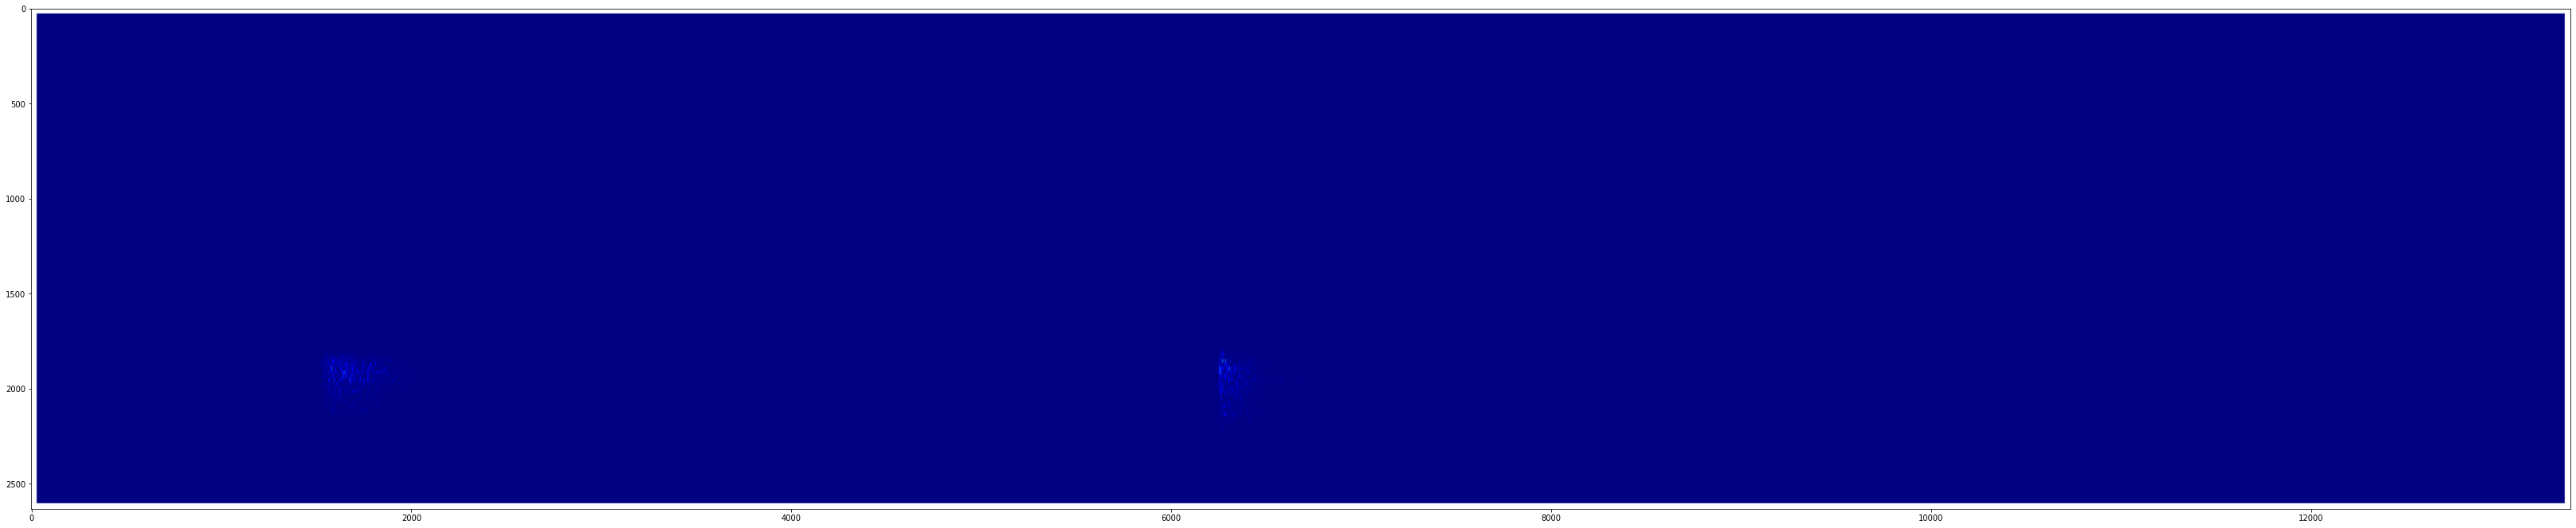

0.0 9479.7


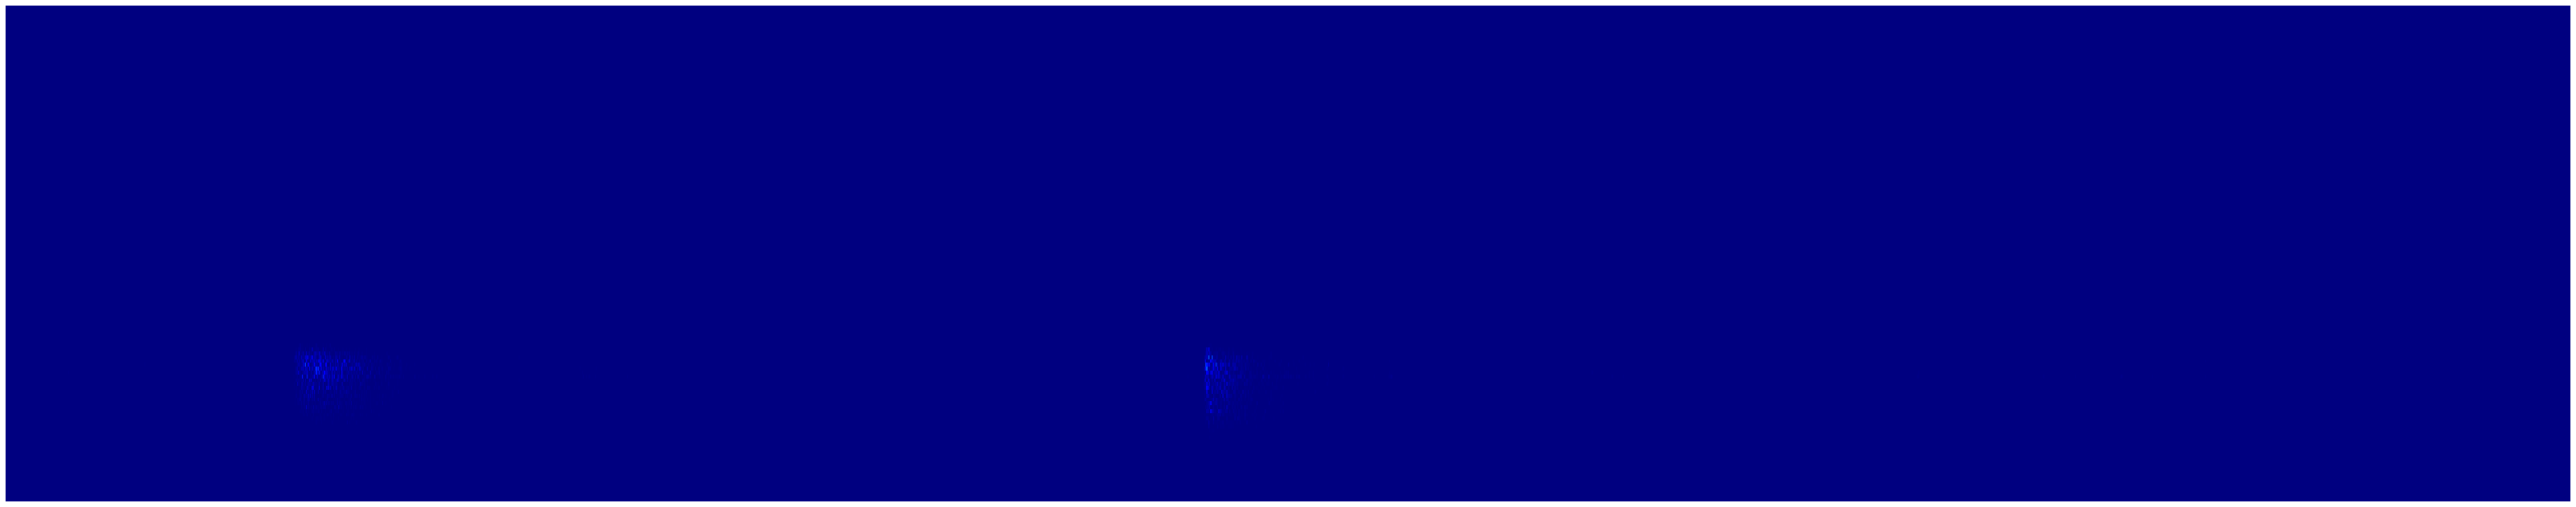

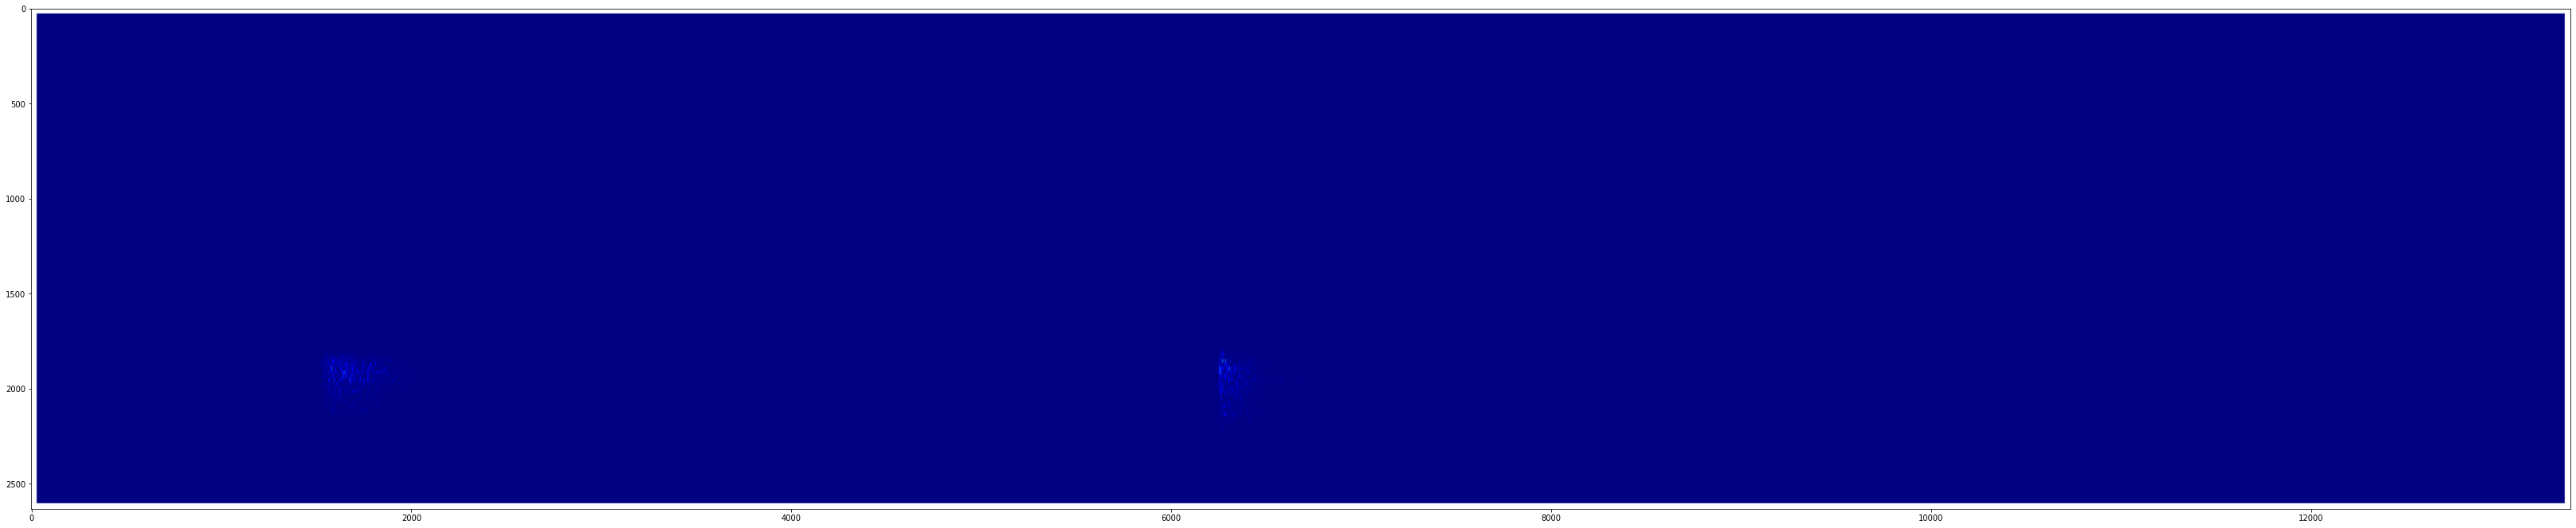

0.0 40199.7


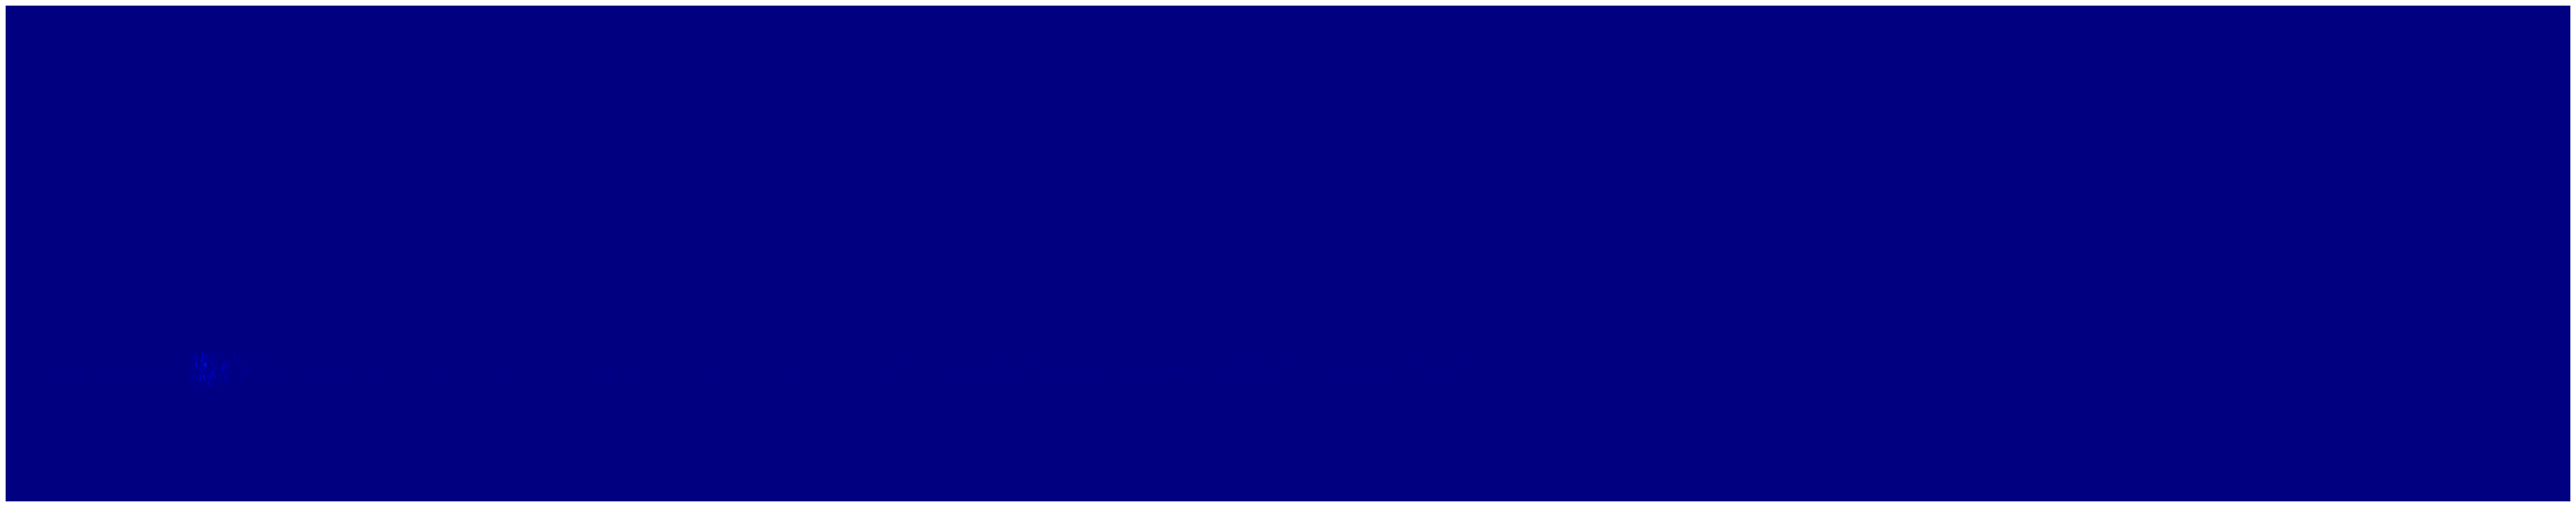

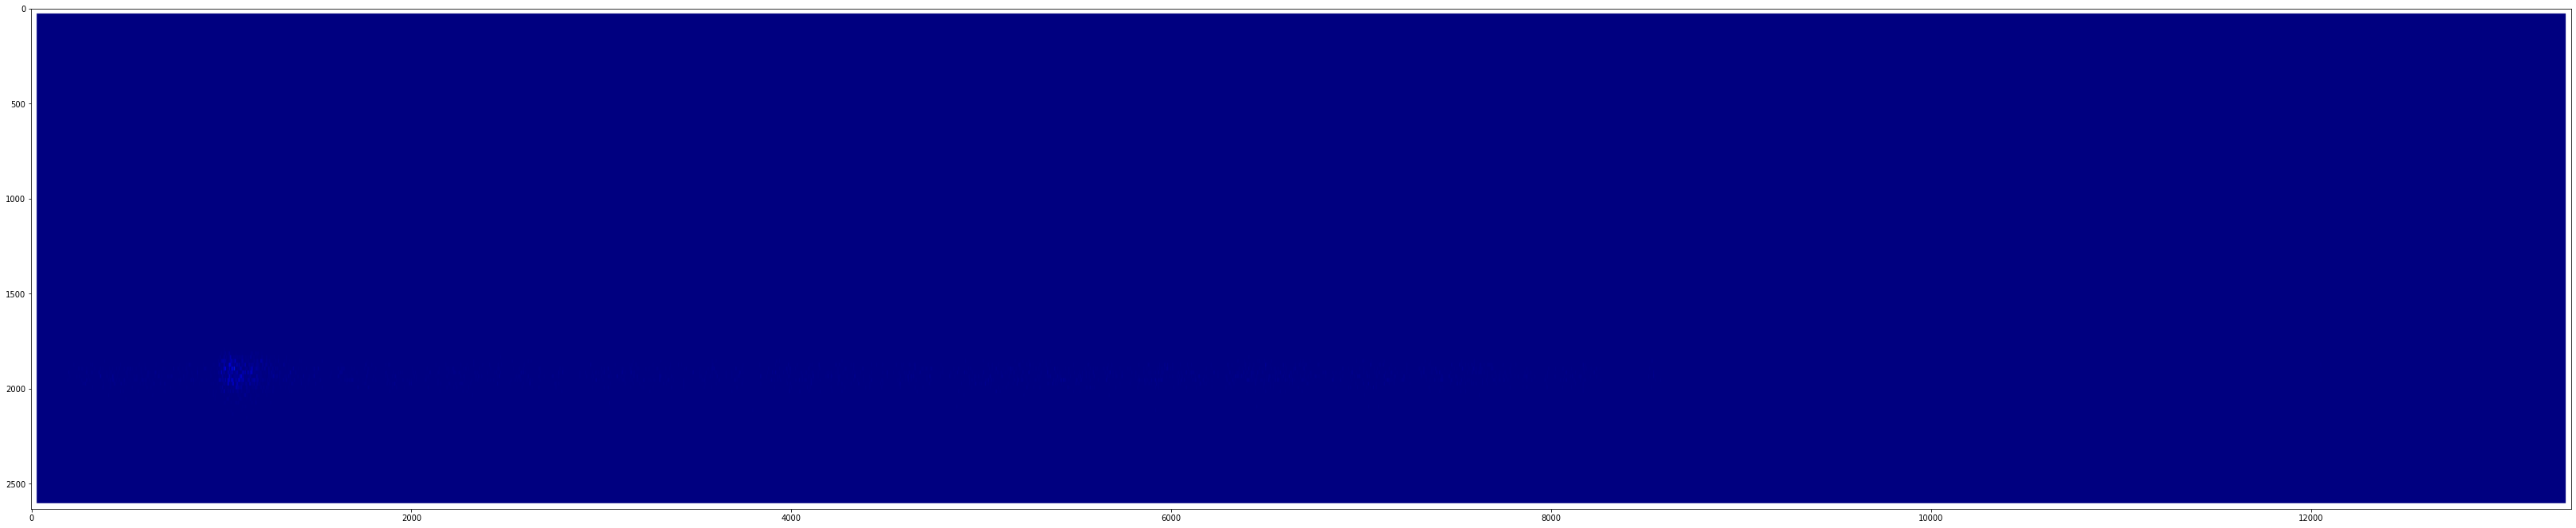

0.0 6119.868


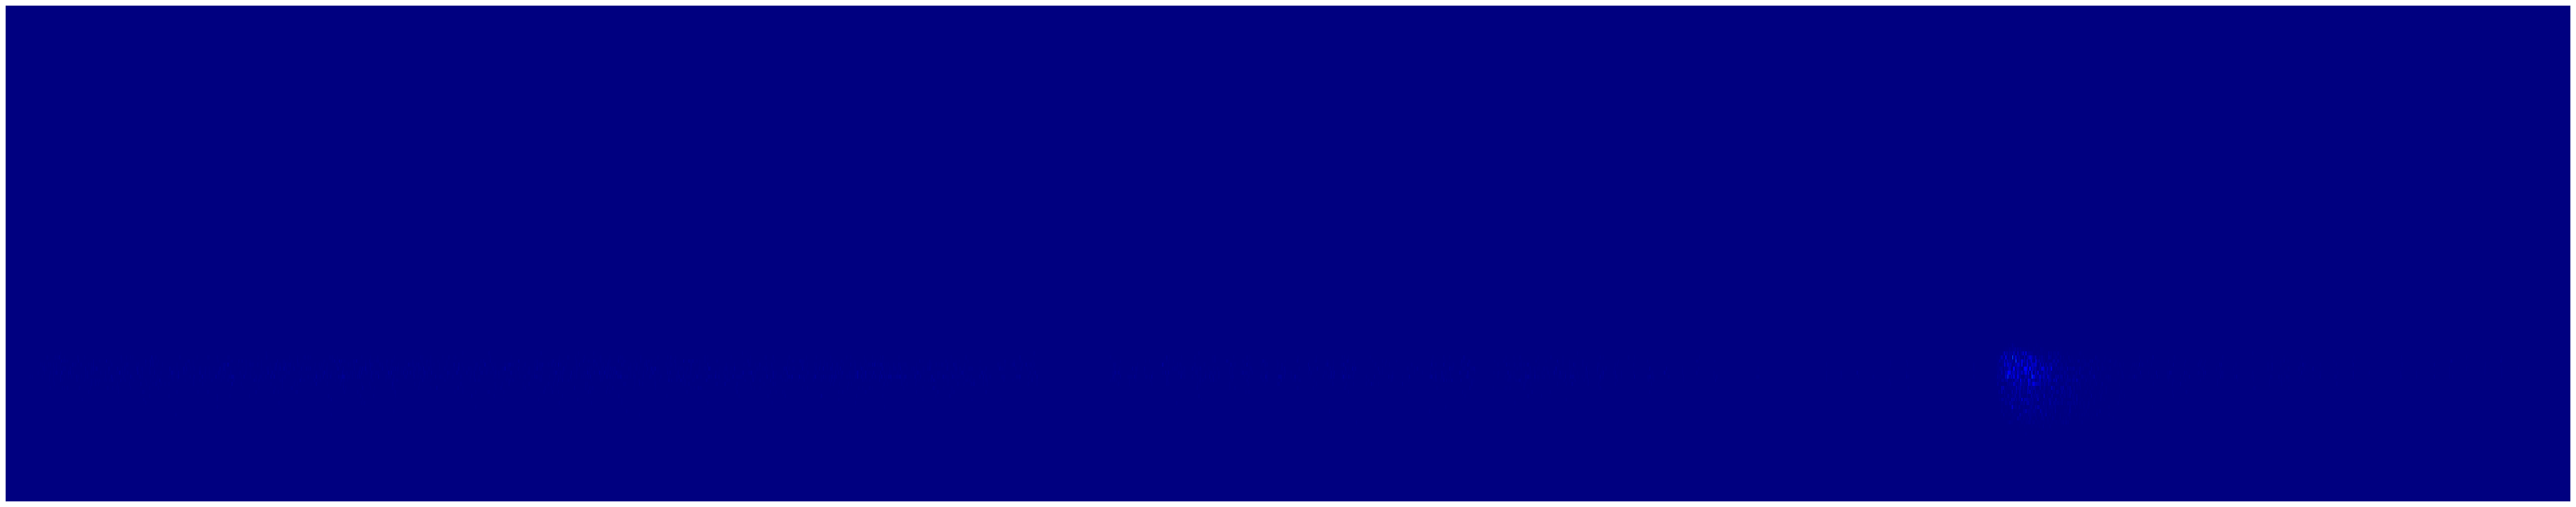

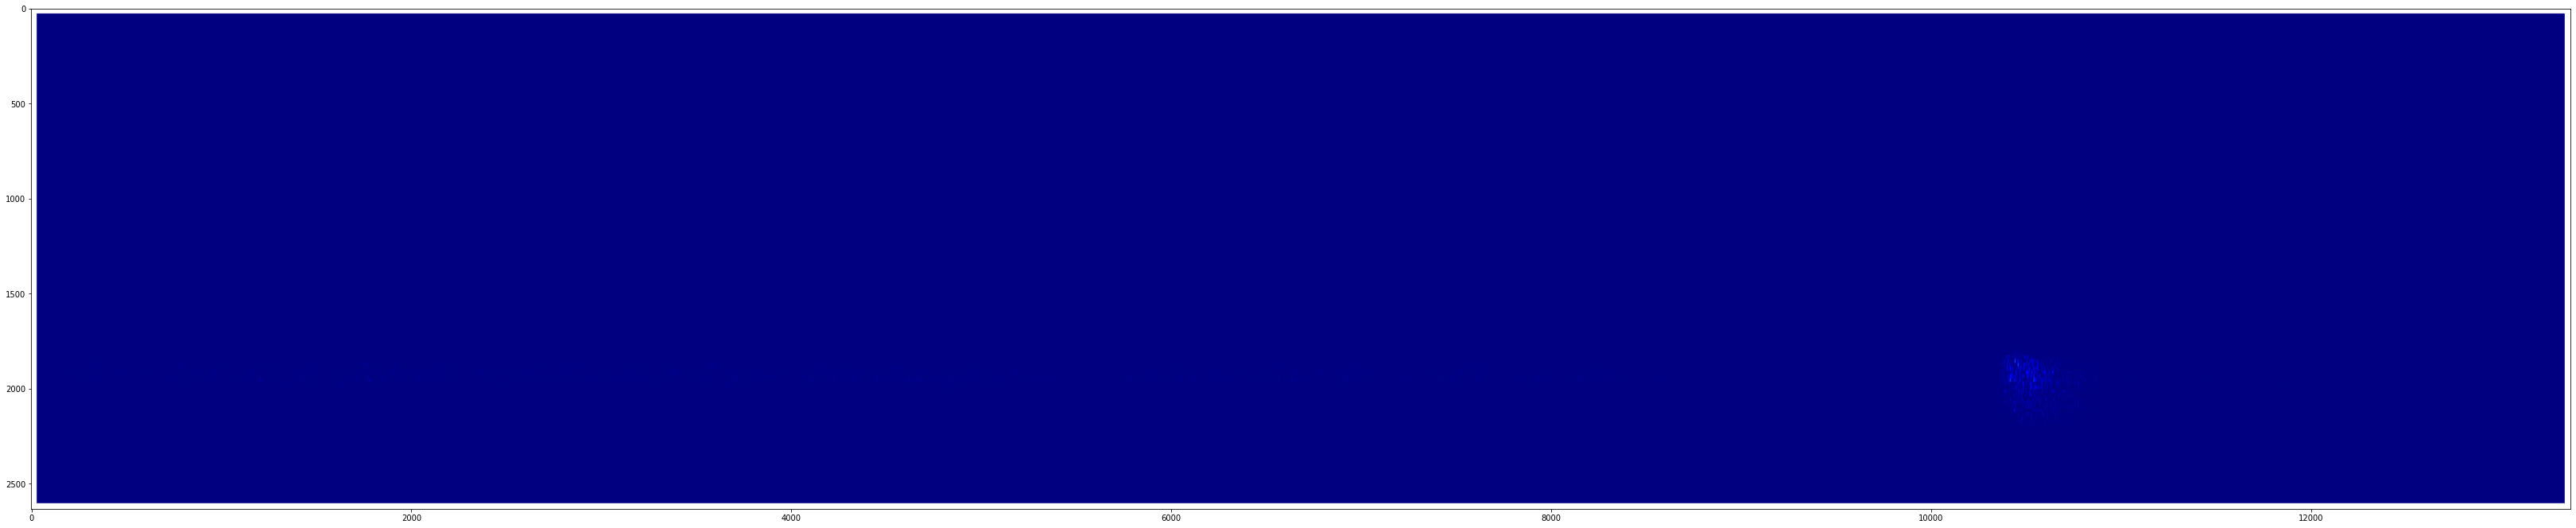

0.0 66959.77


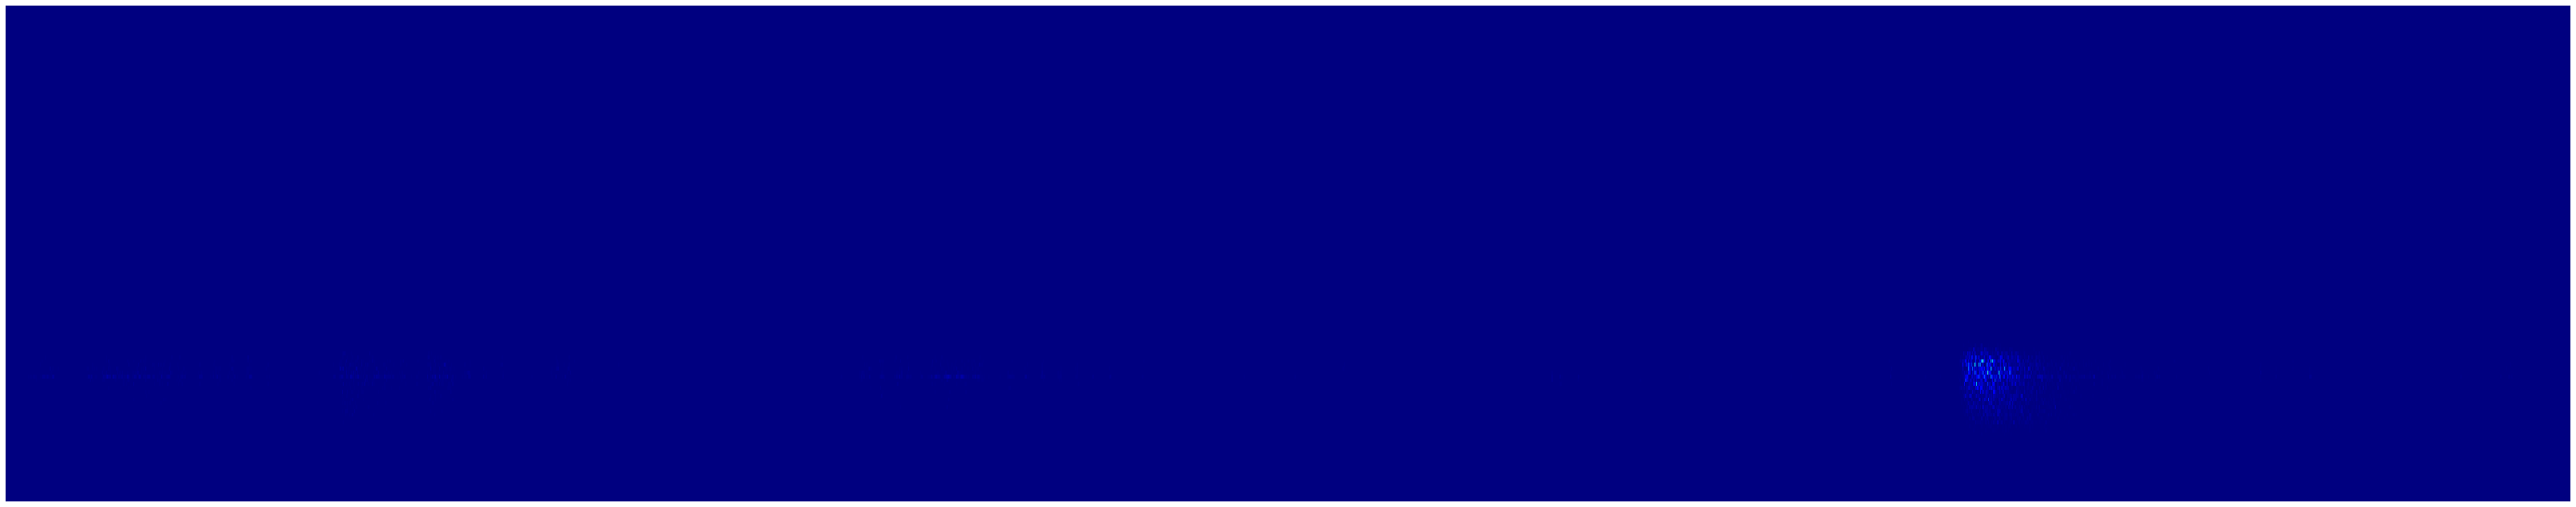

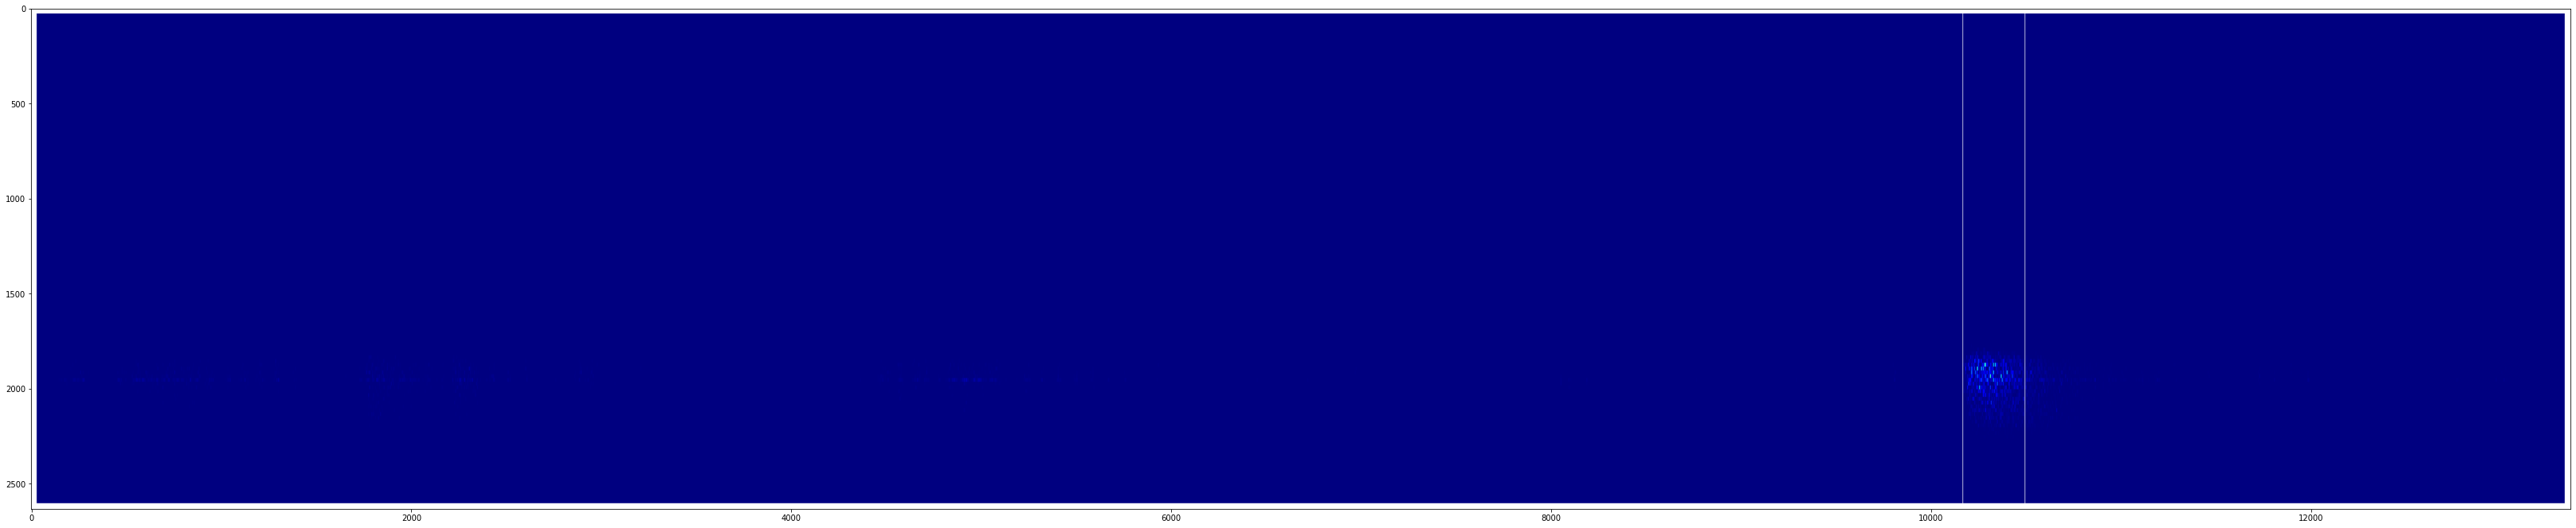

65723.54805054028 65699.468


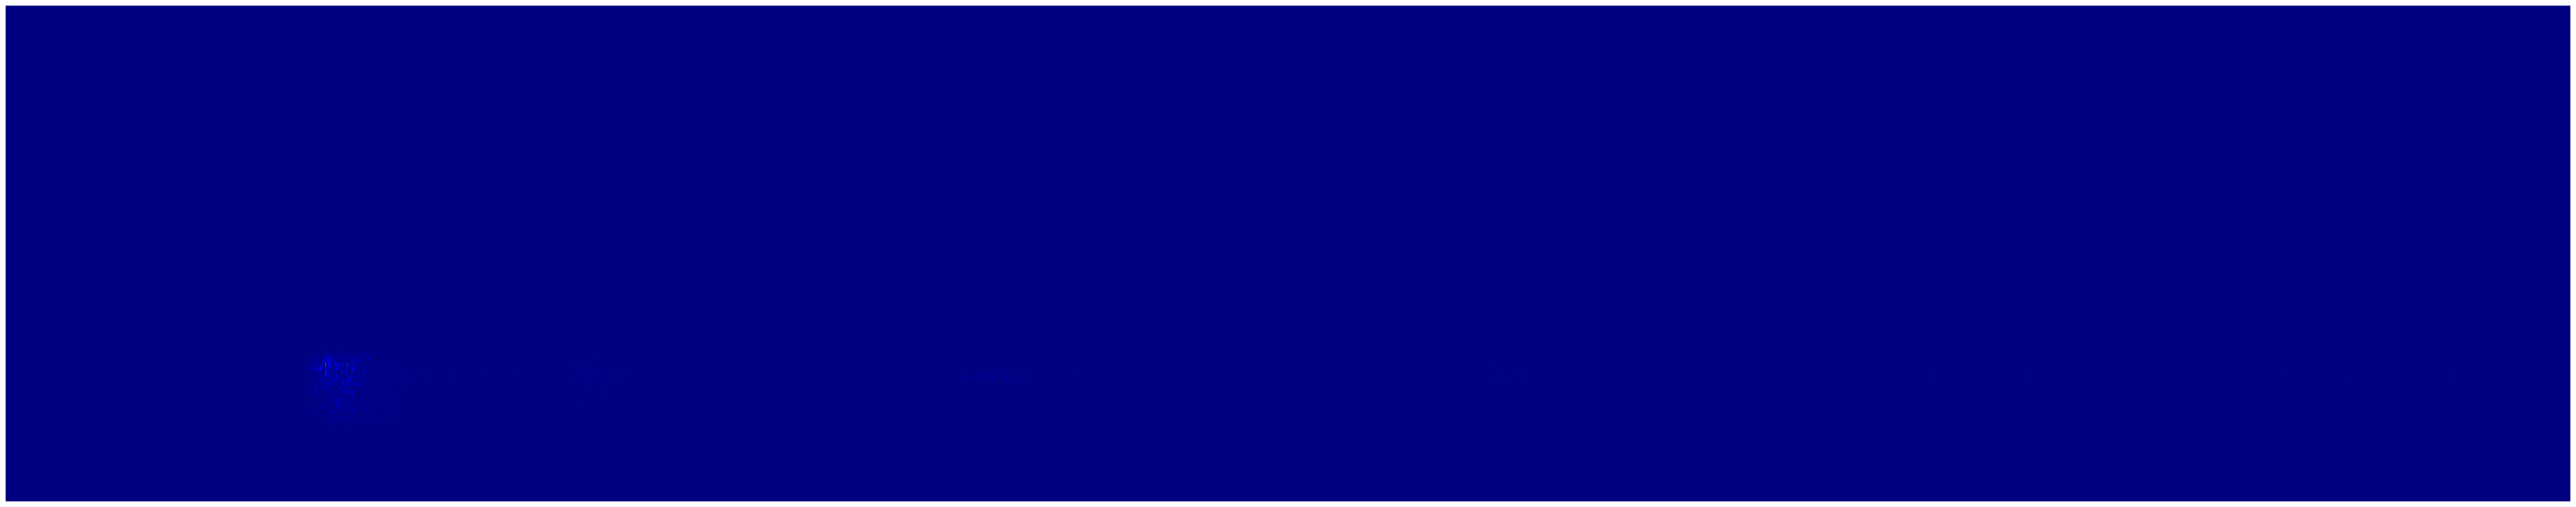

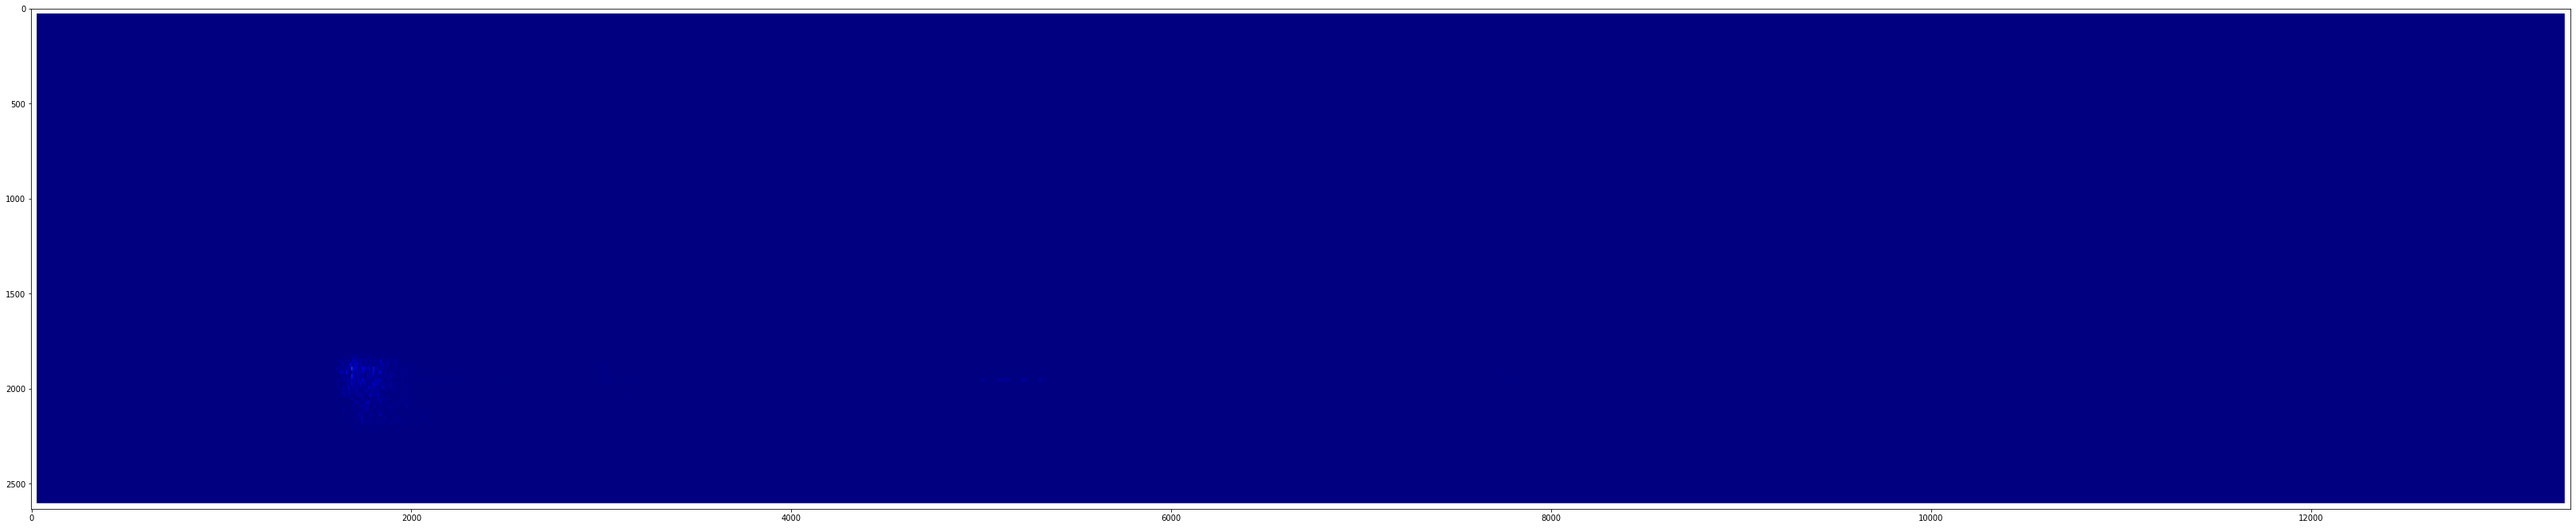

0.0 9959.456


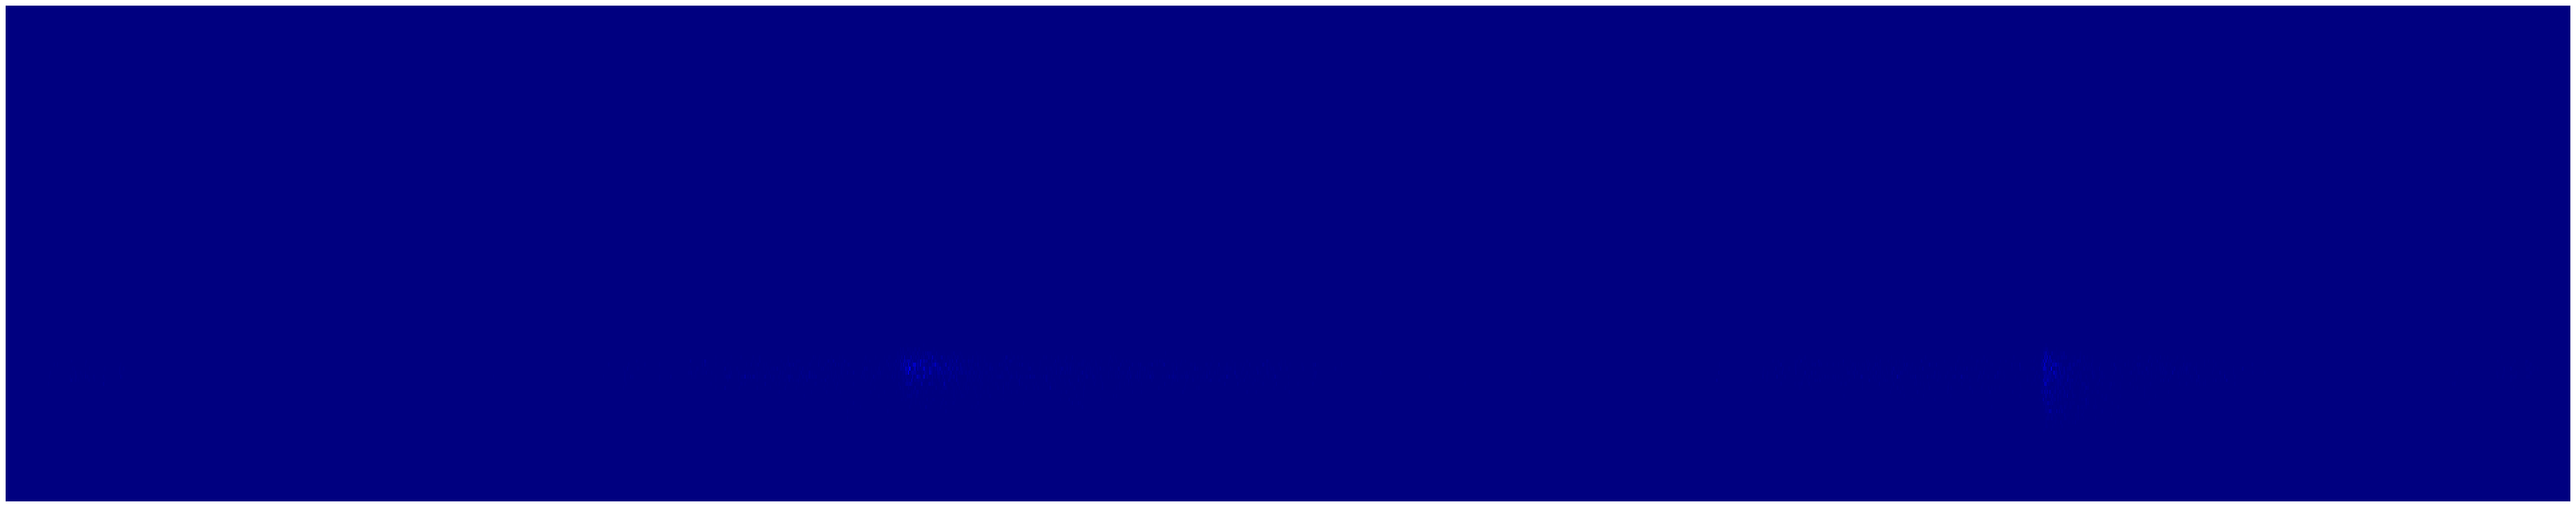

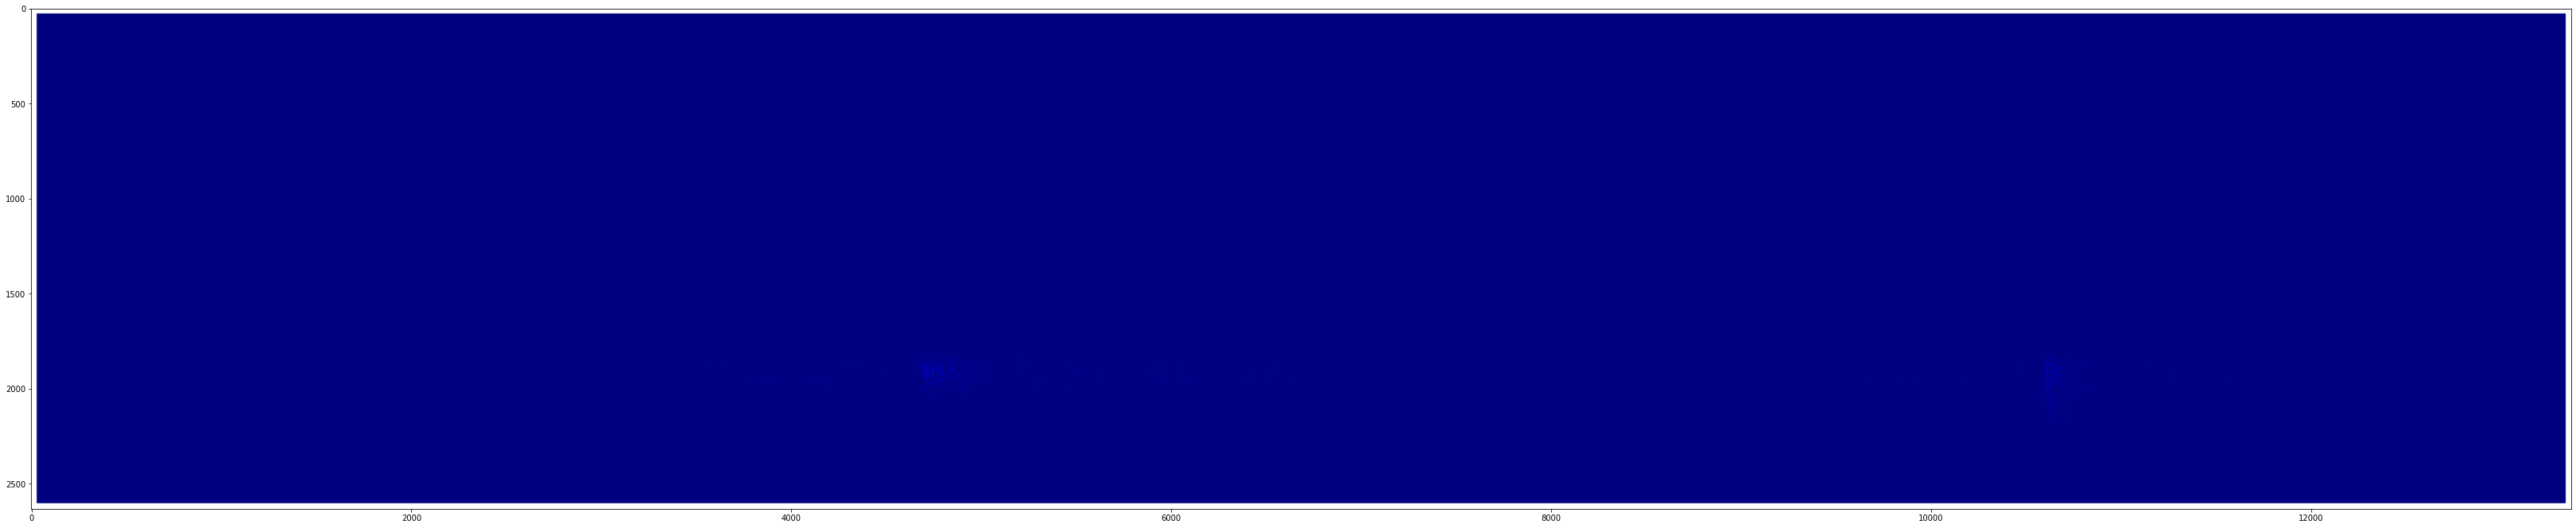

0.0 68519.692


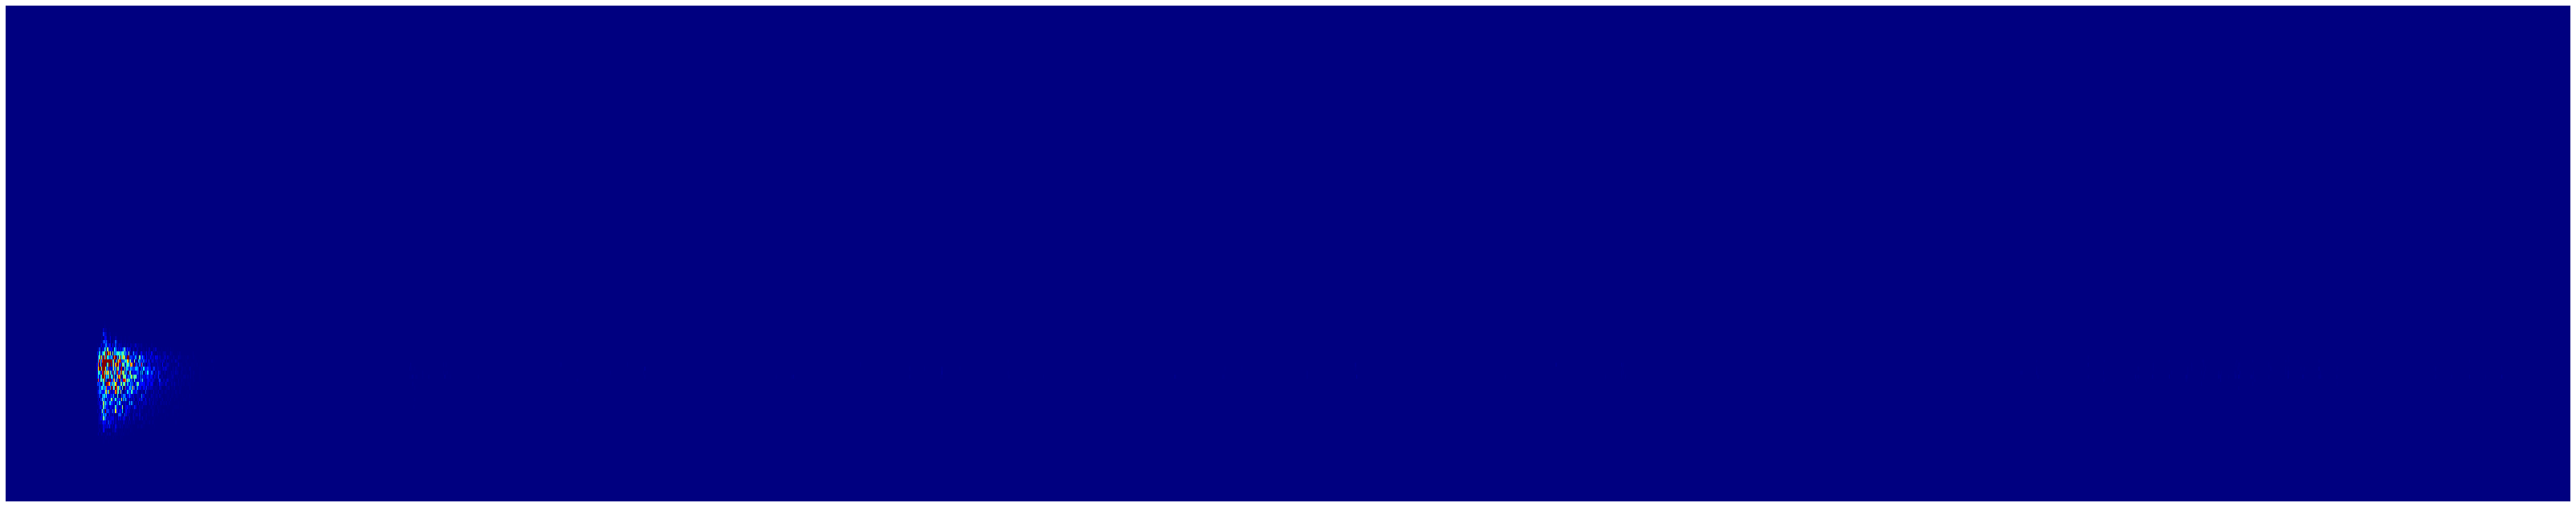

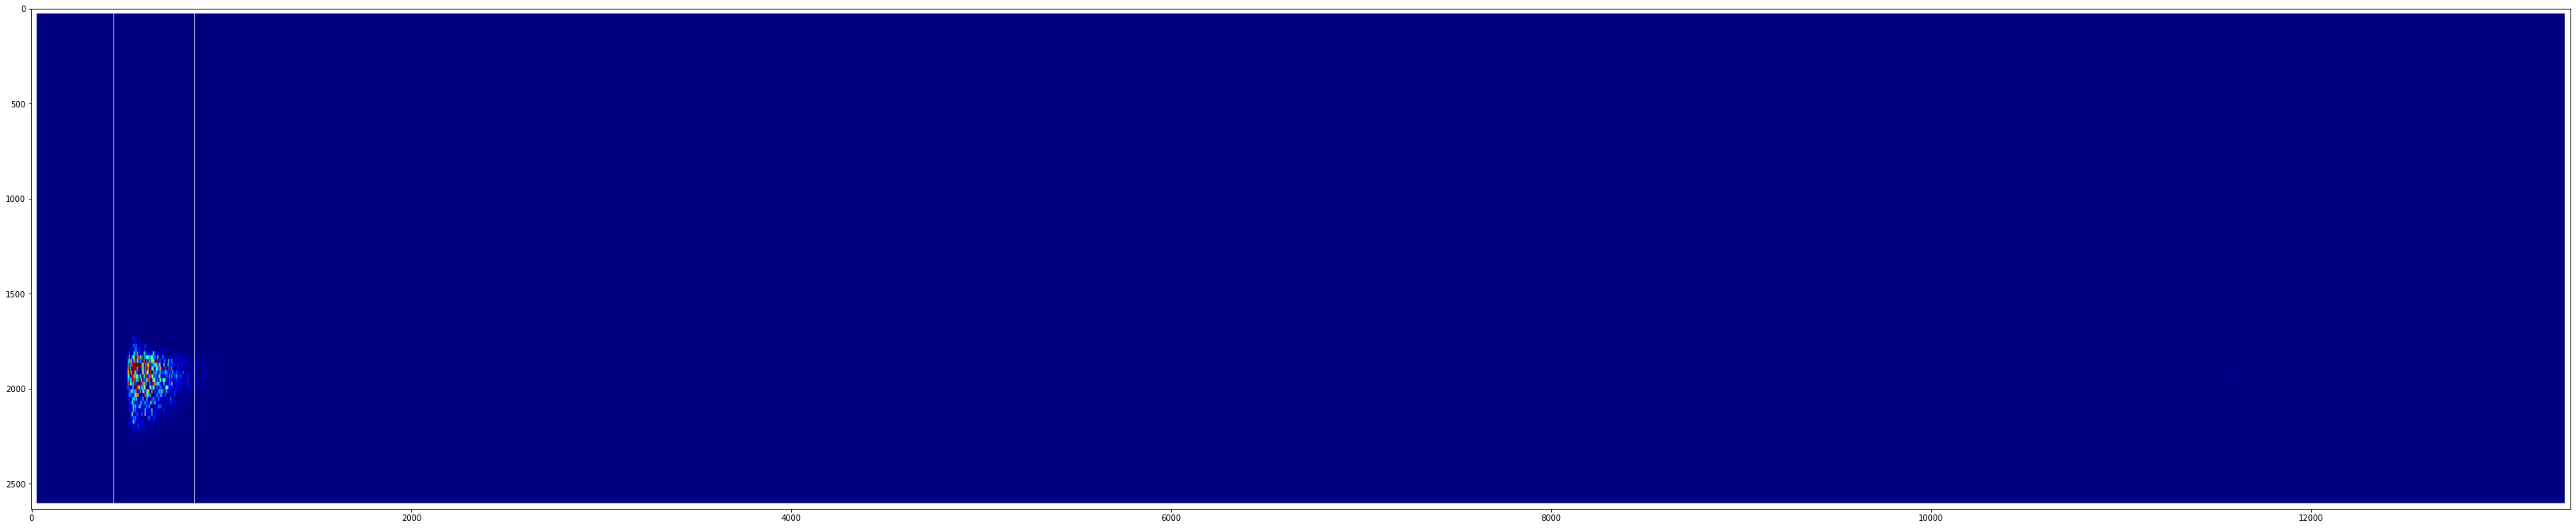

2804.9975271840385 3119.725


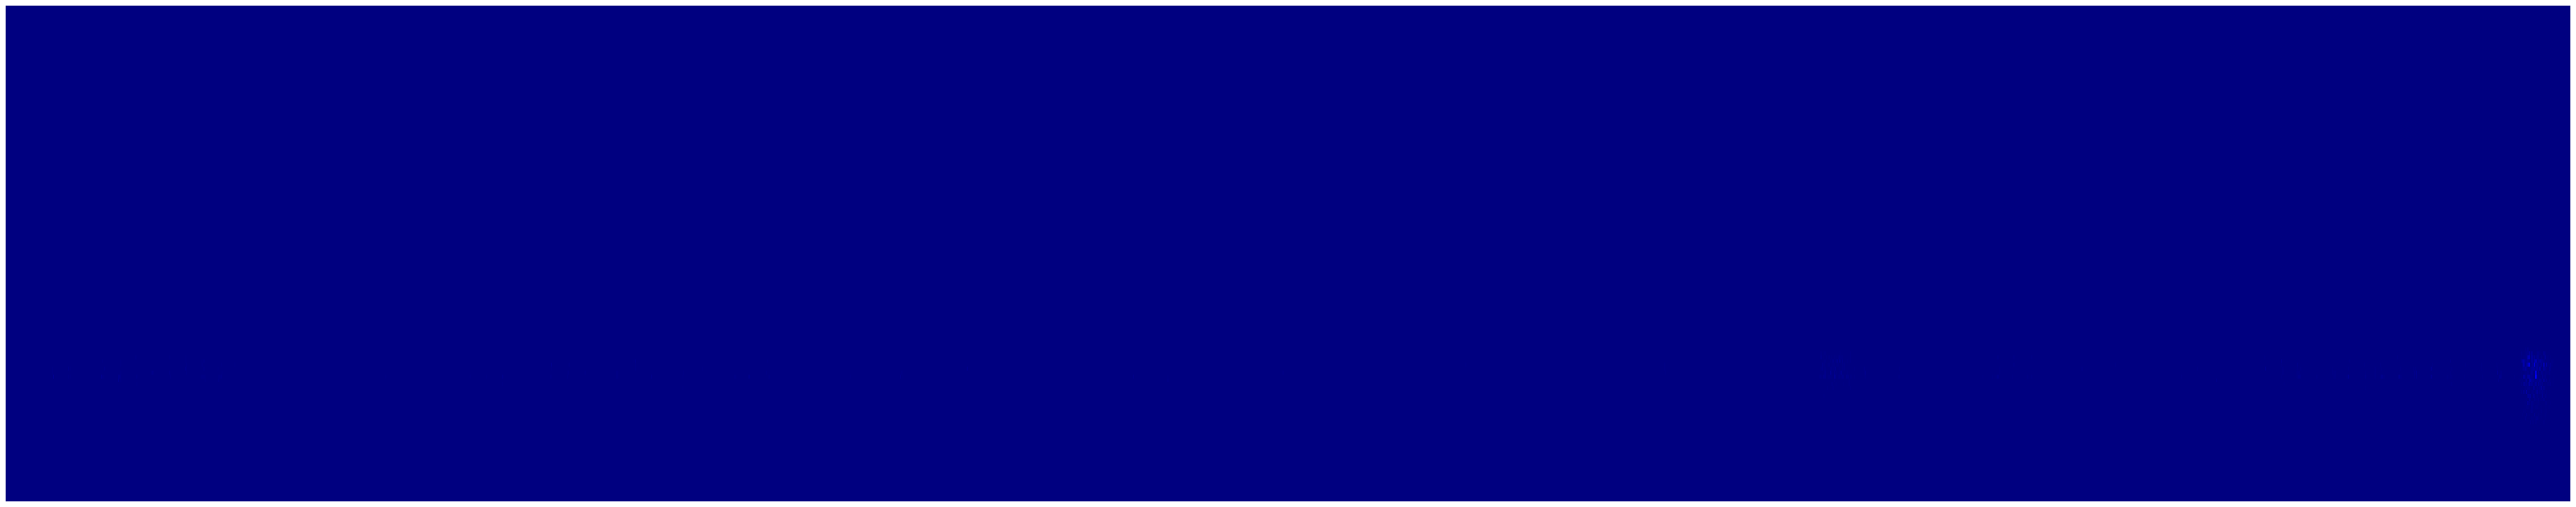

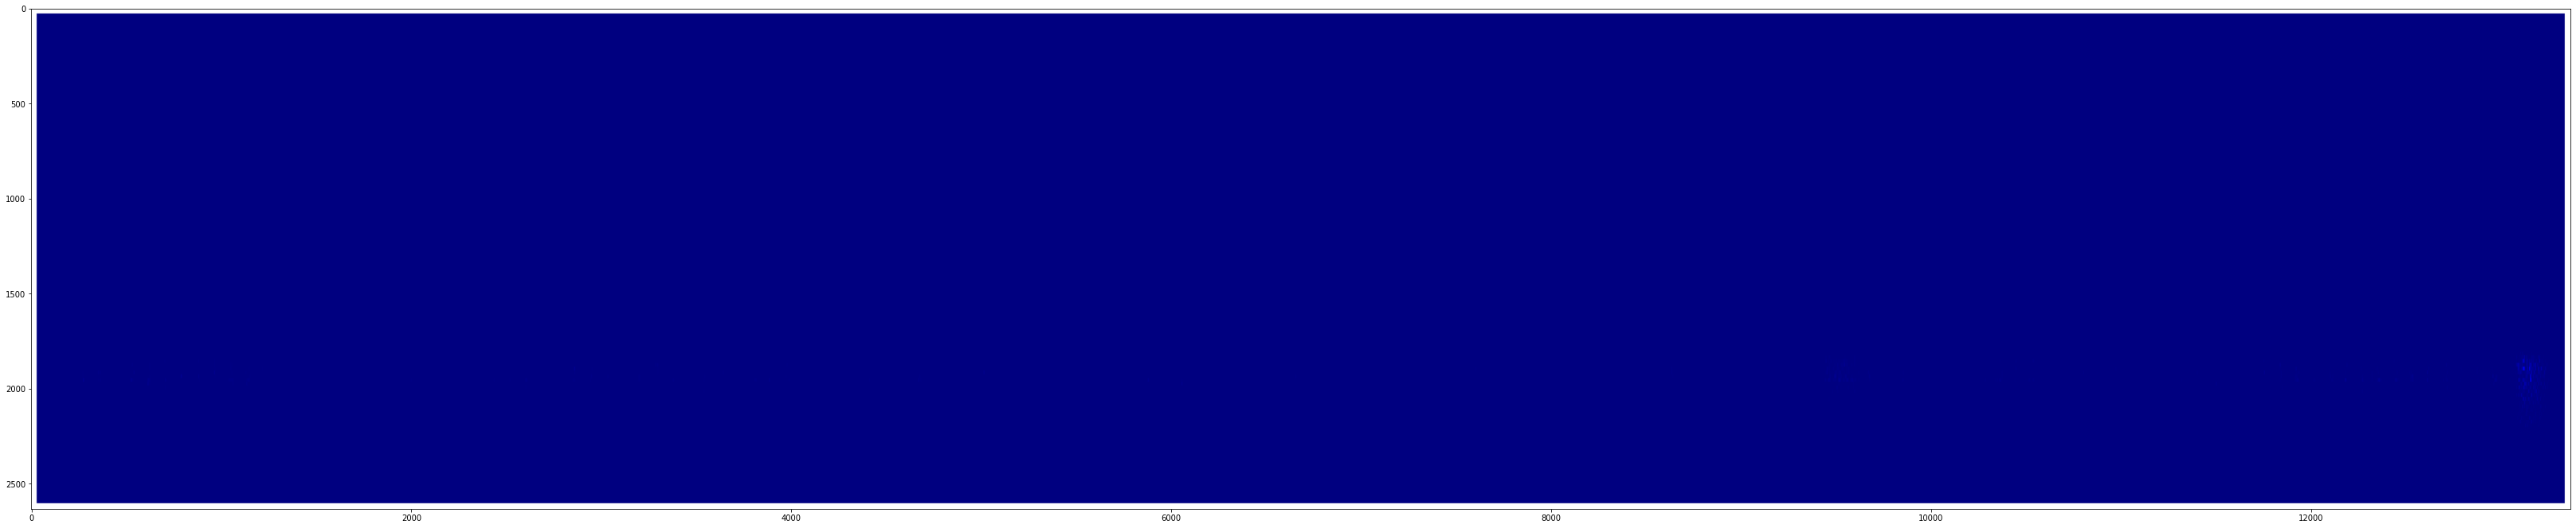

0.0 84659.738


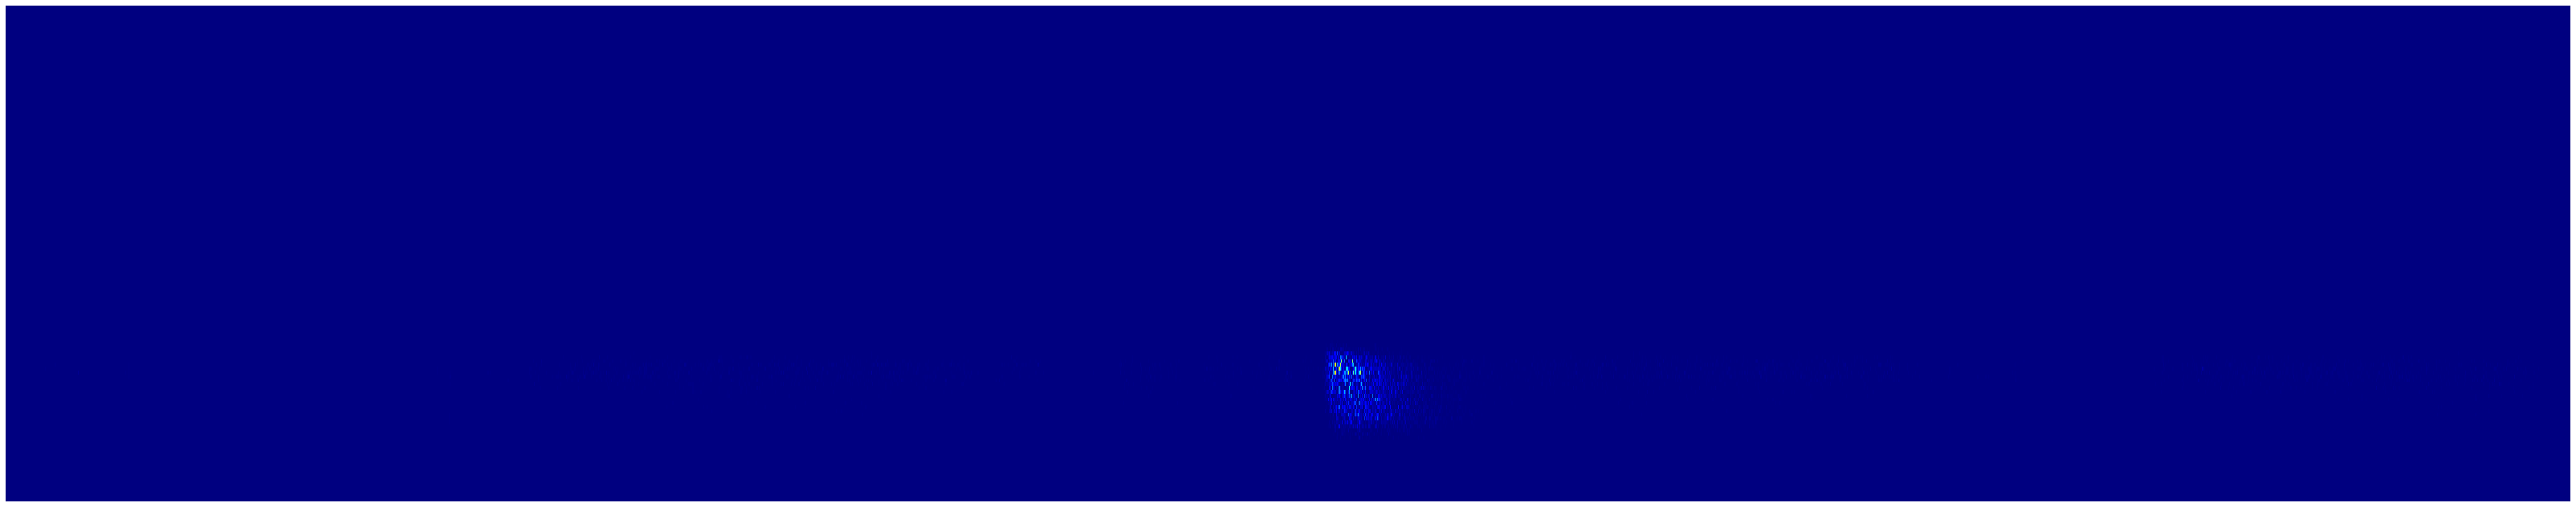

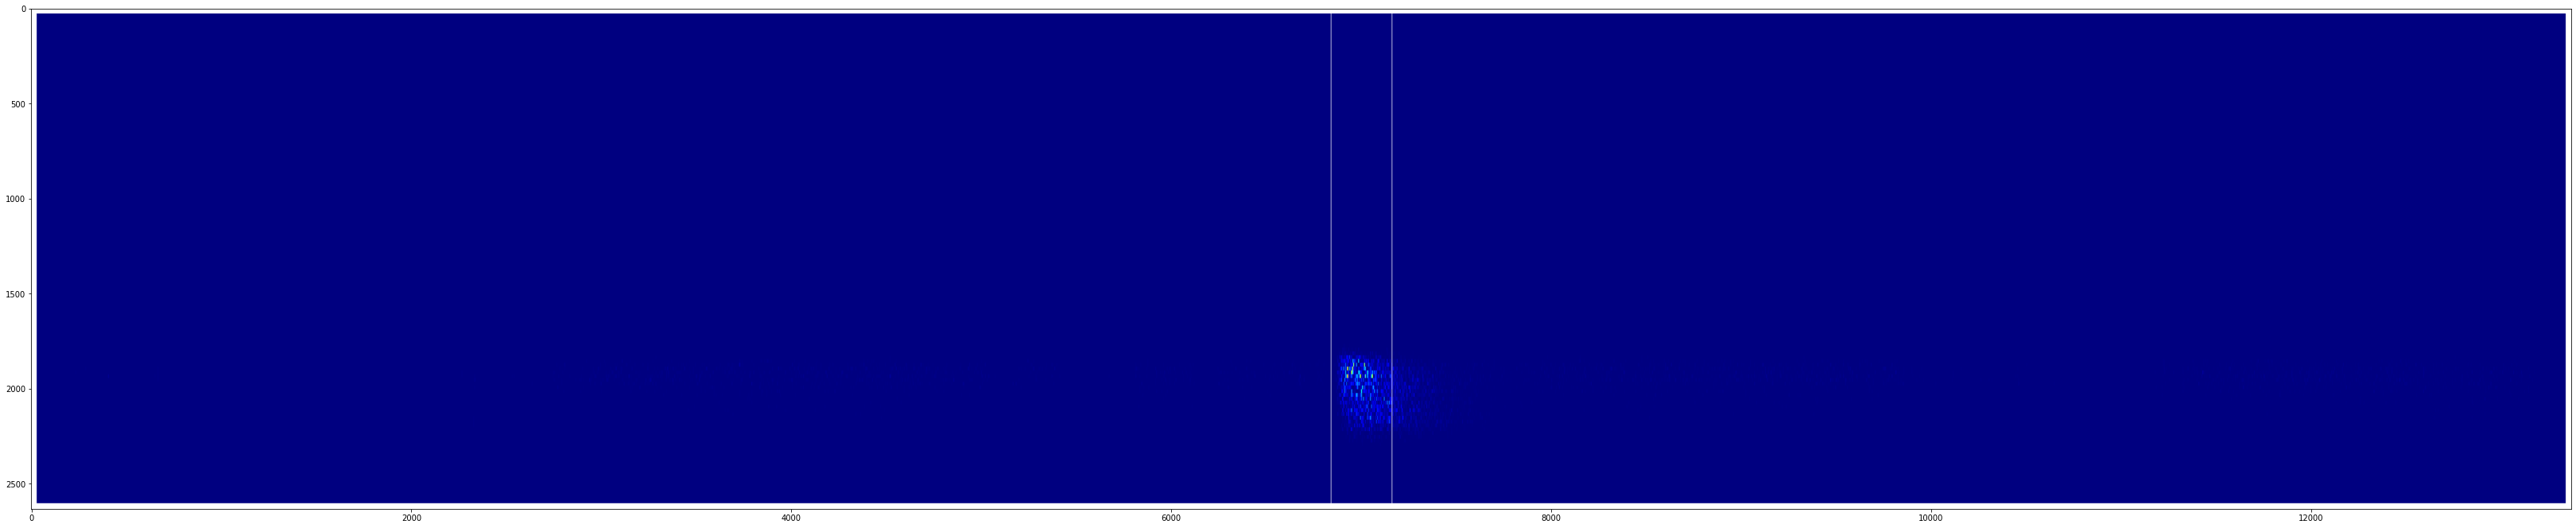

44215.4941679934 44219.348


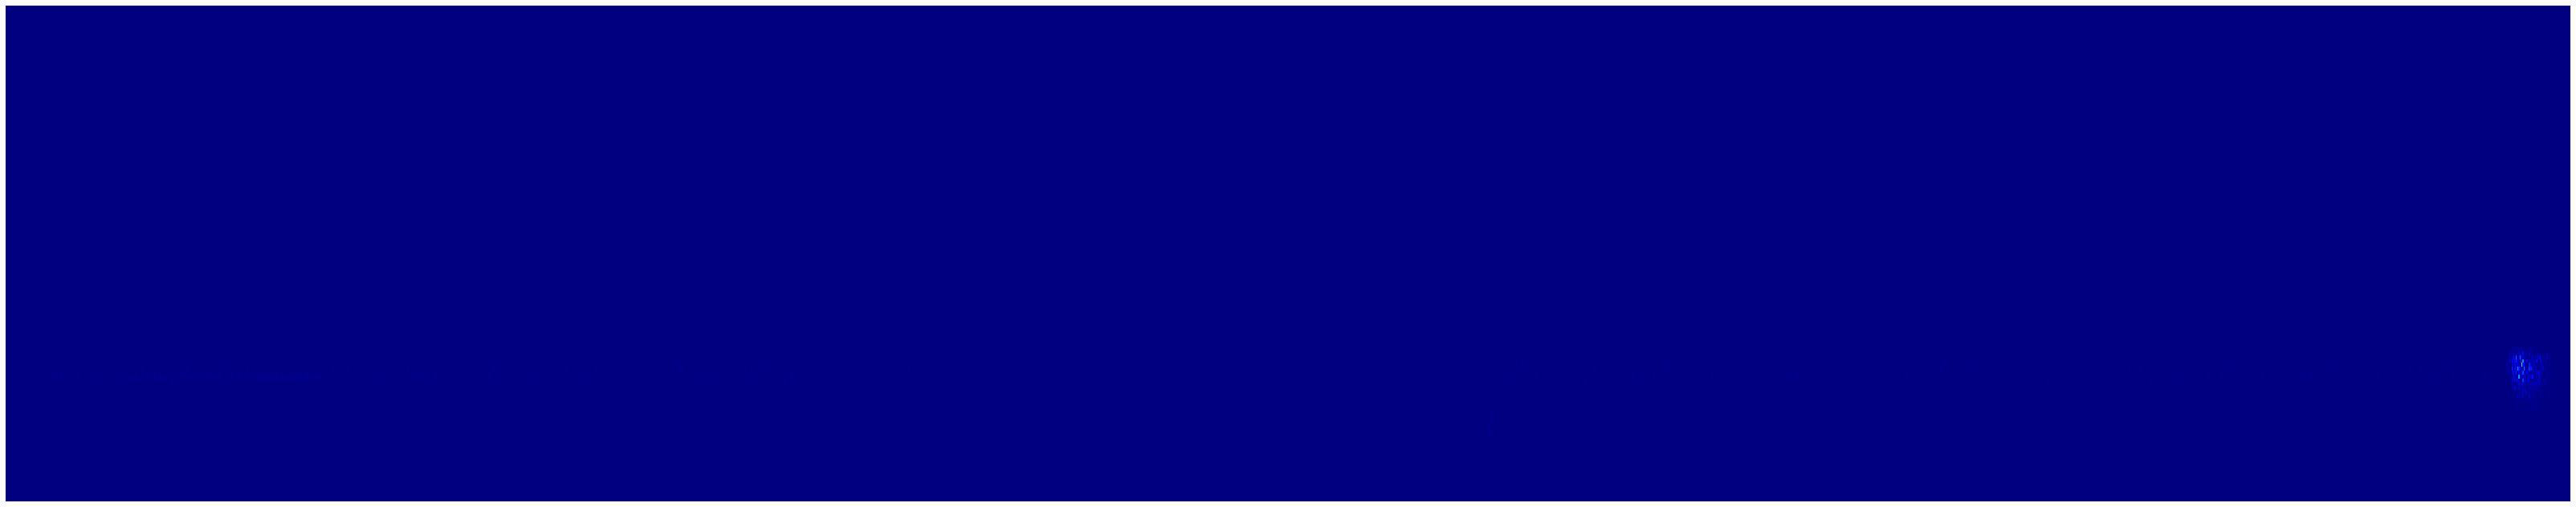

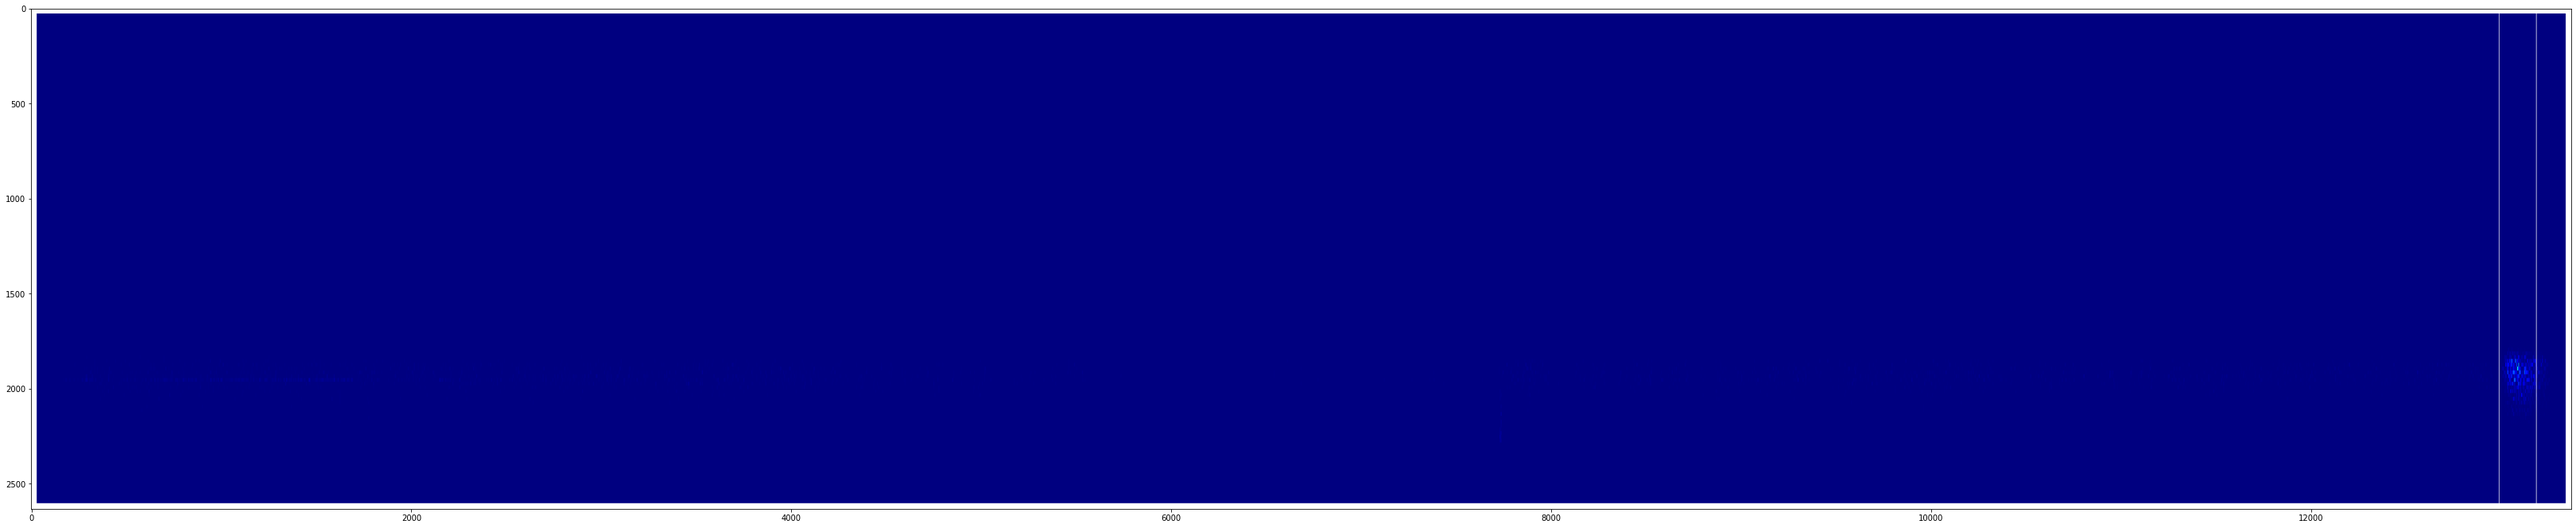

83946.47873265359 84059.771


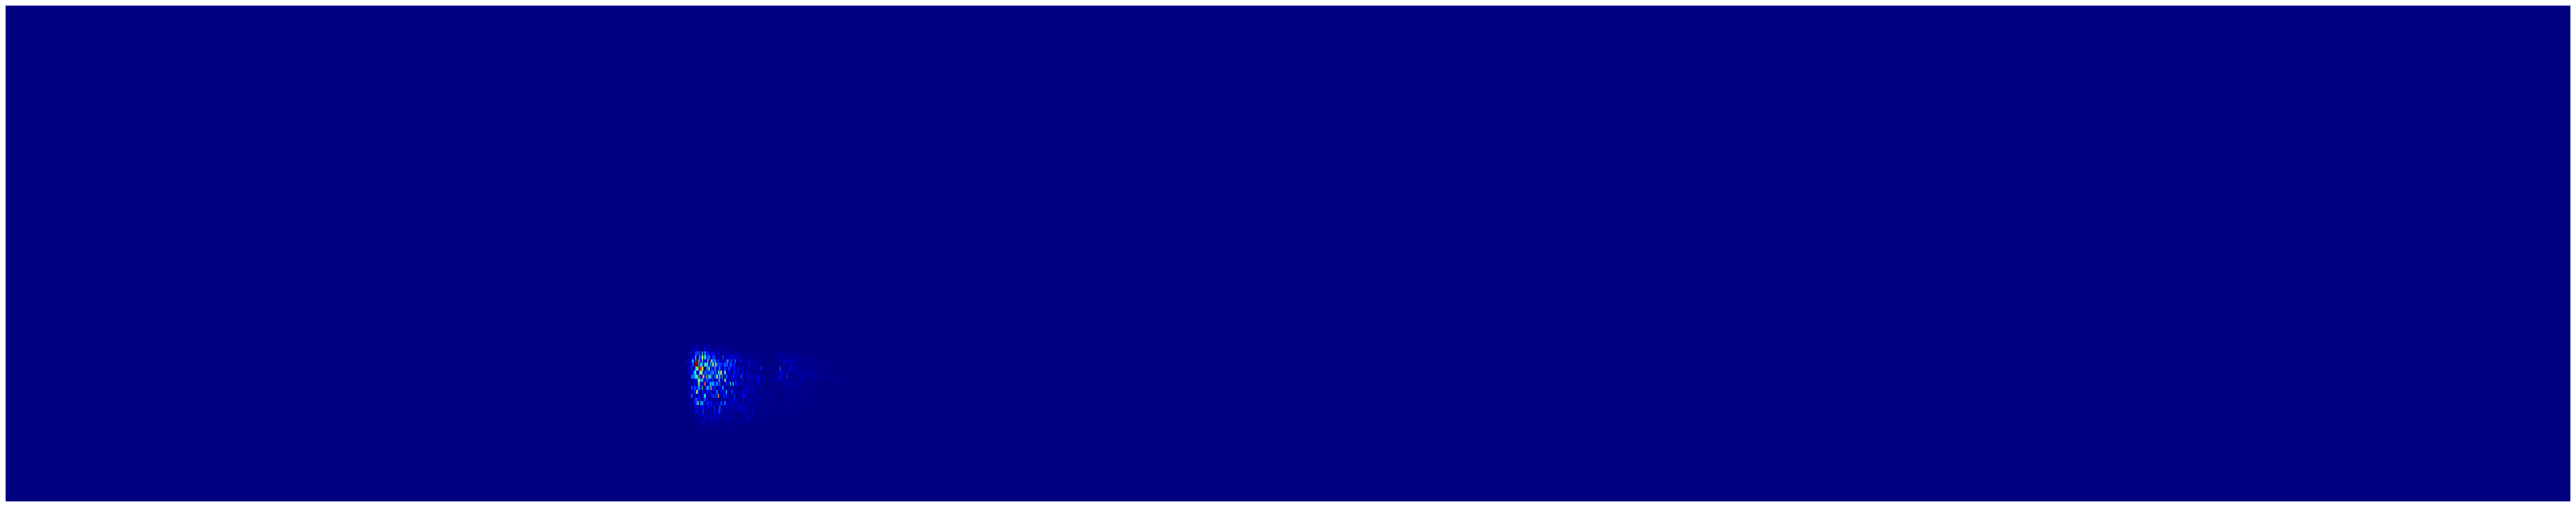

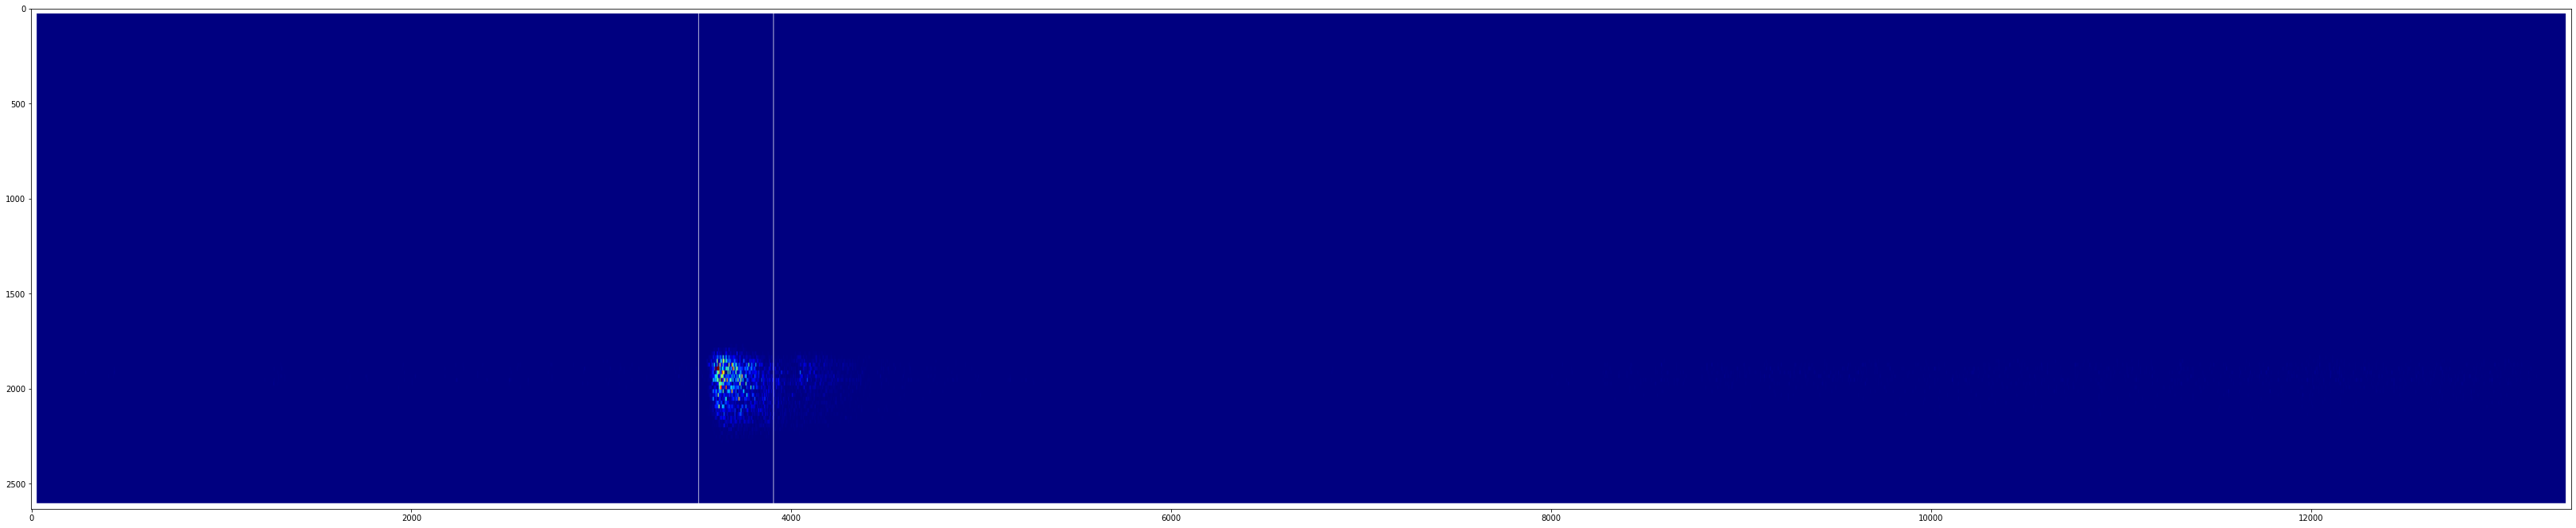

22705.880796720976 22859.646


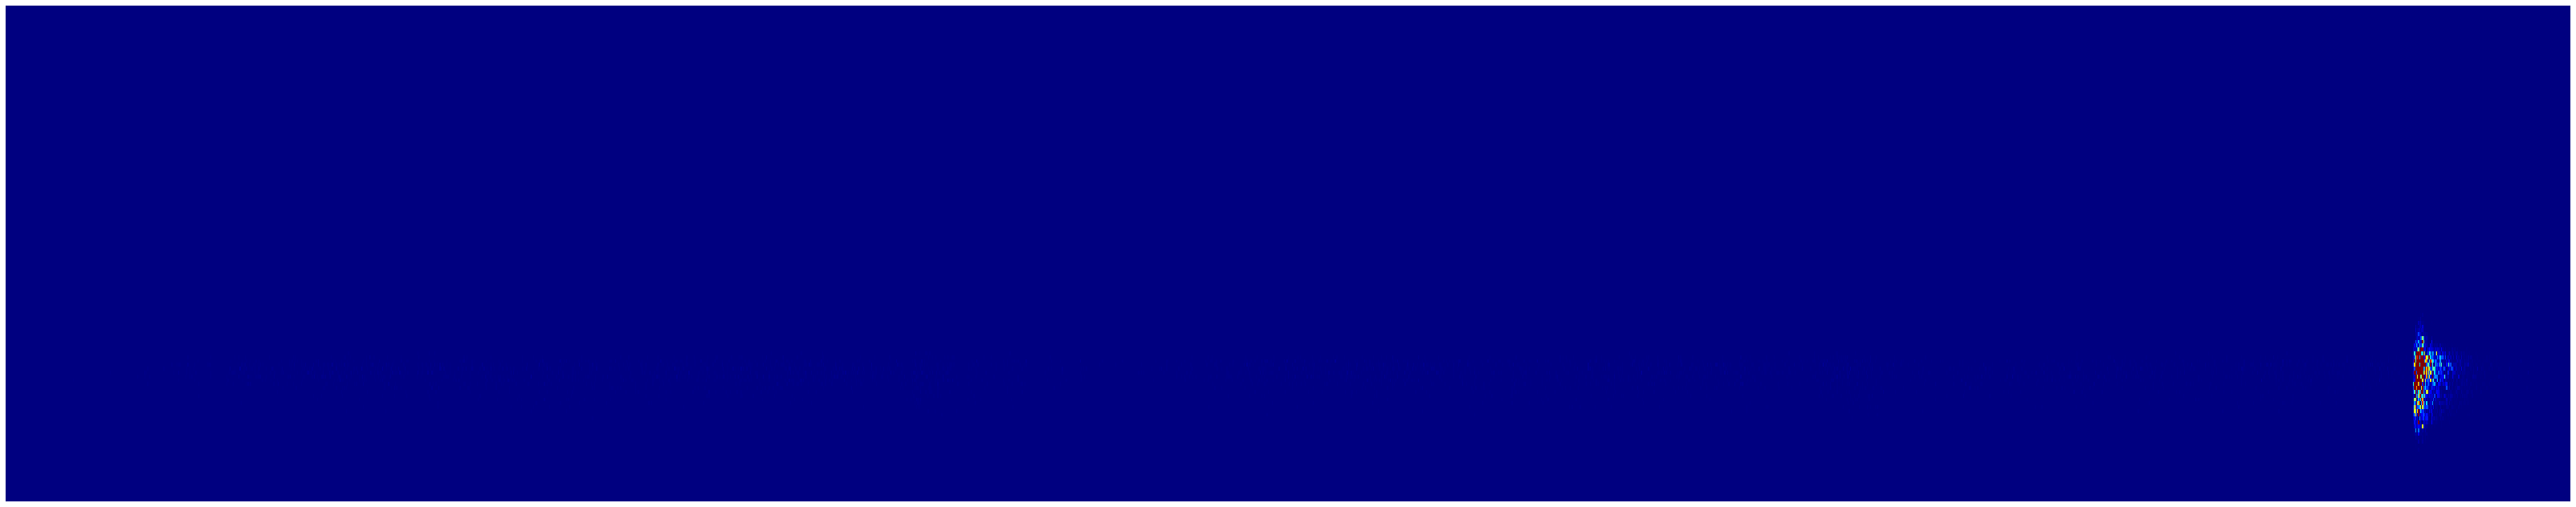

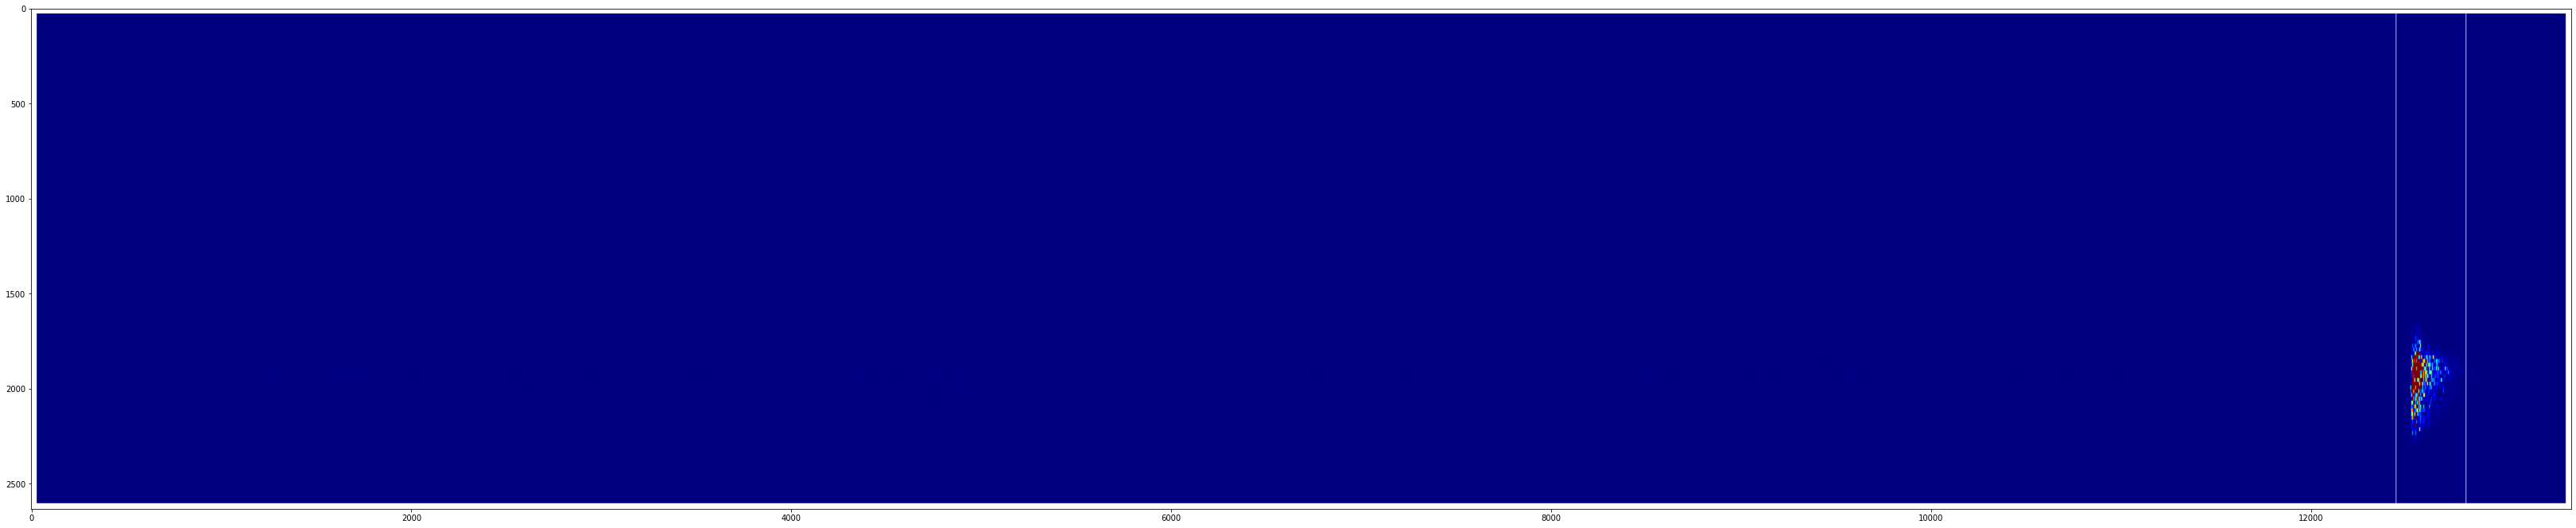

80442.90103090456 80999.6


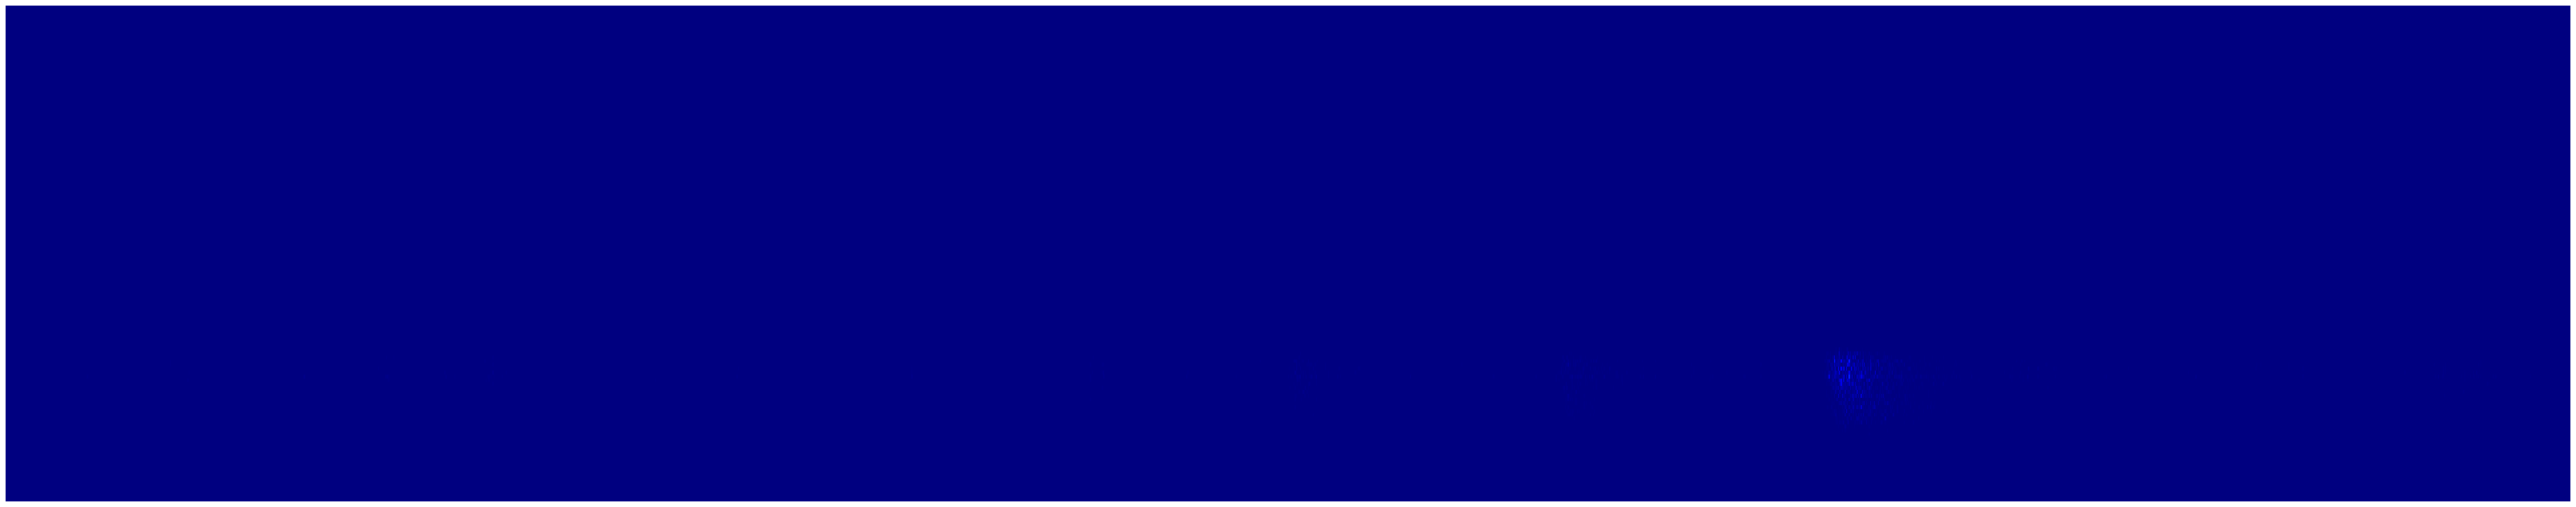

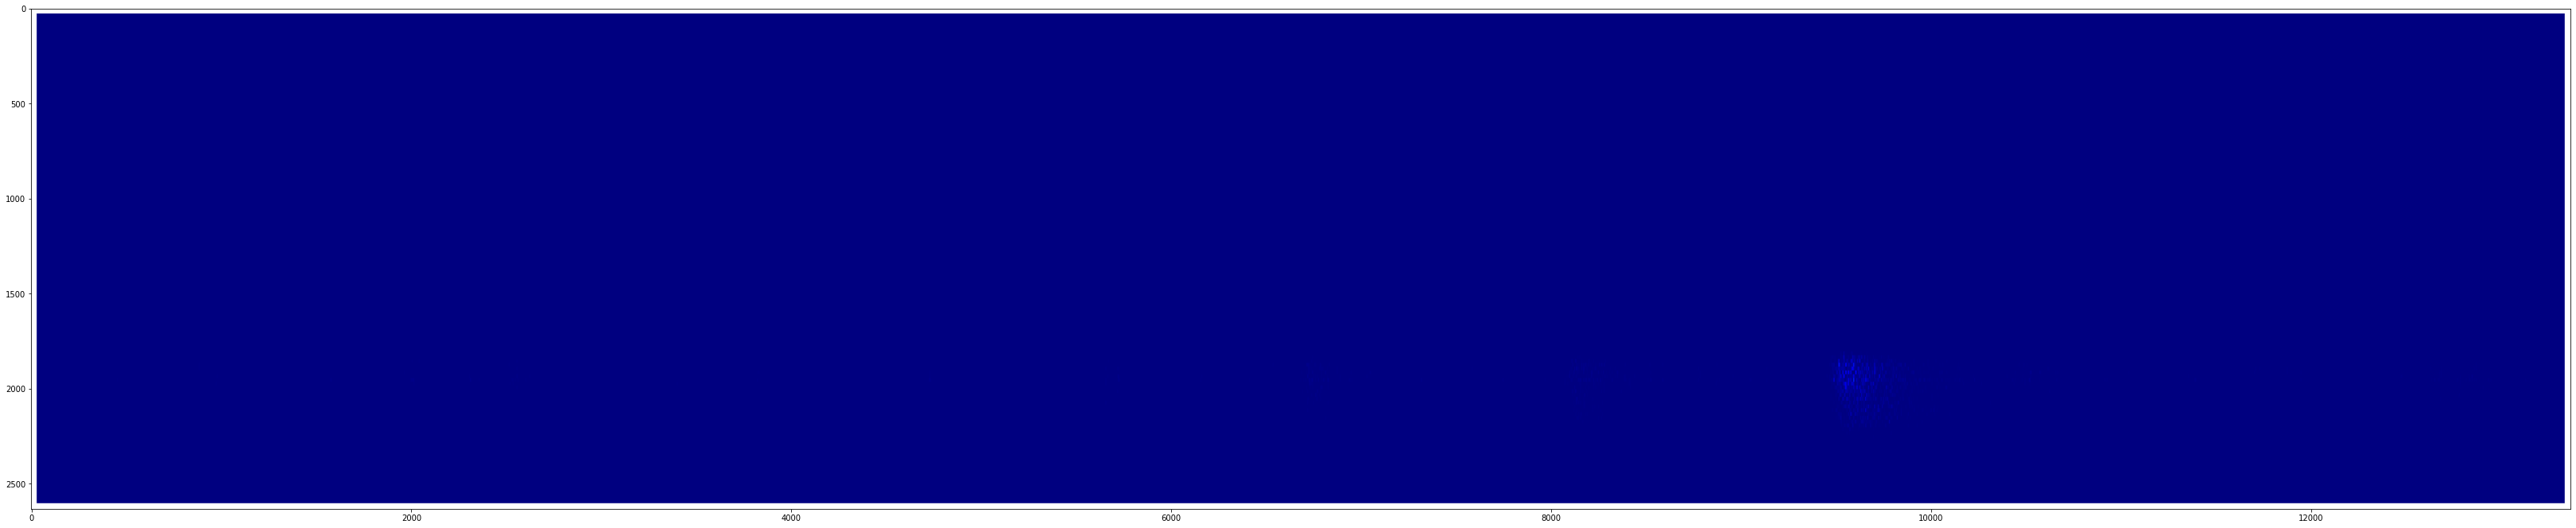

0.0 61079.402


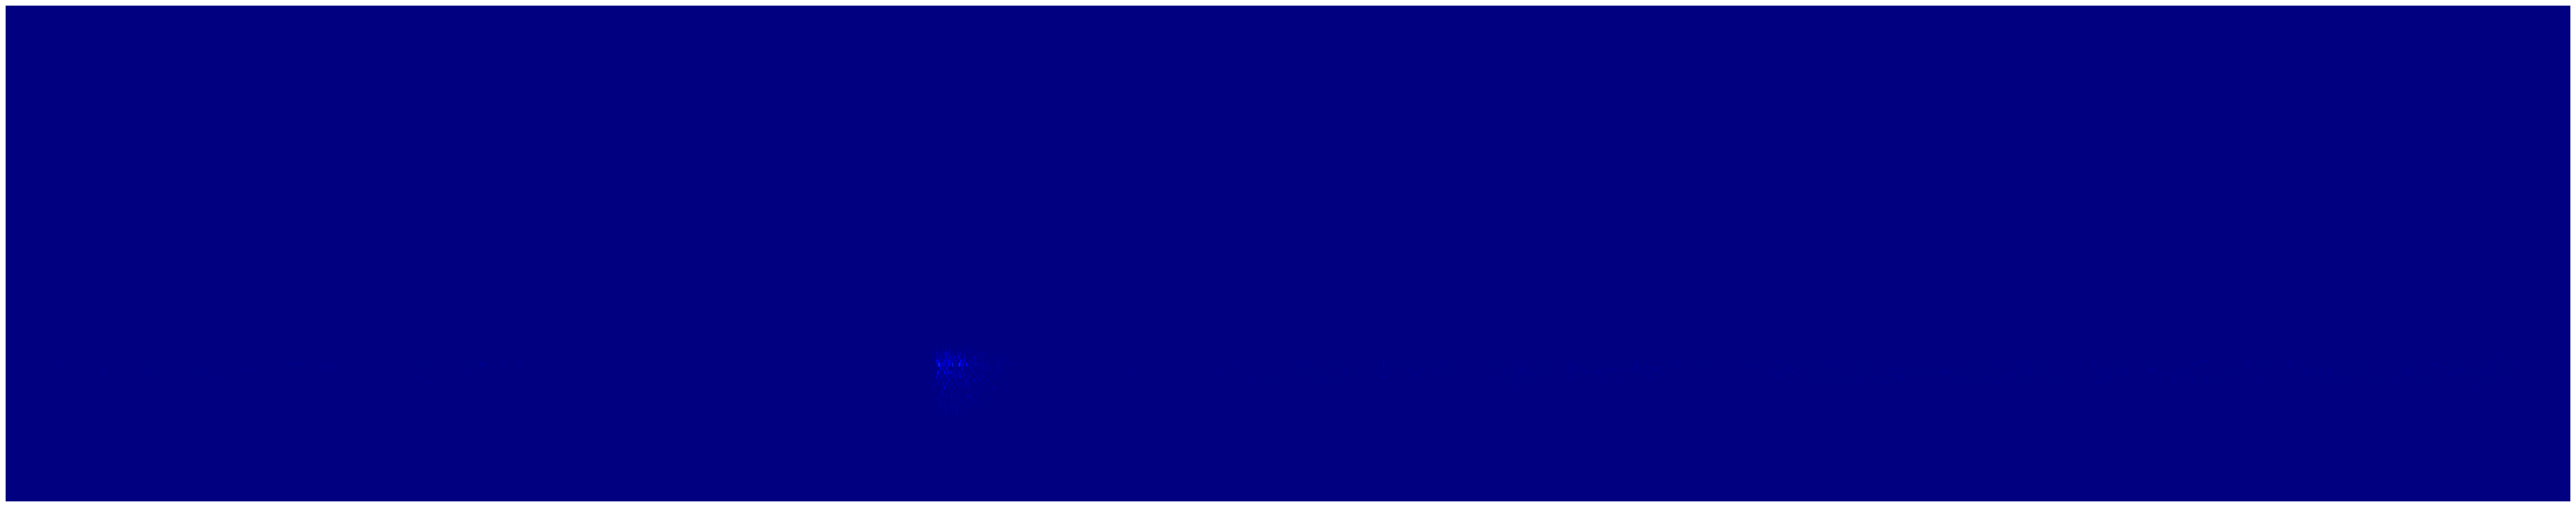

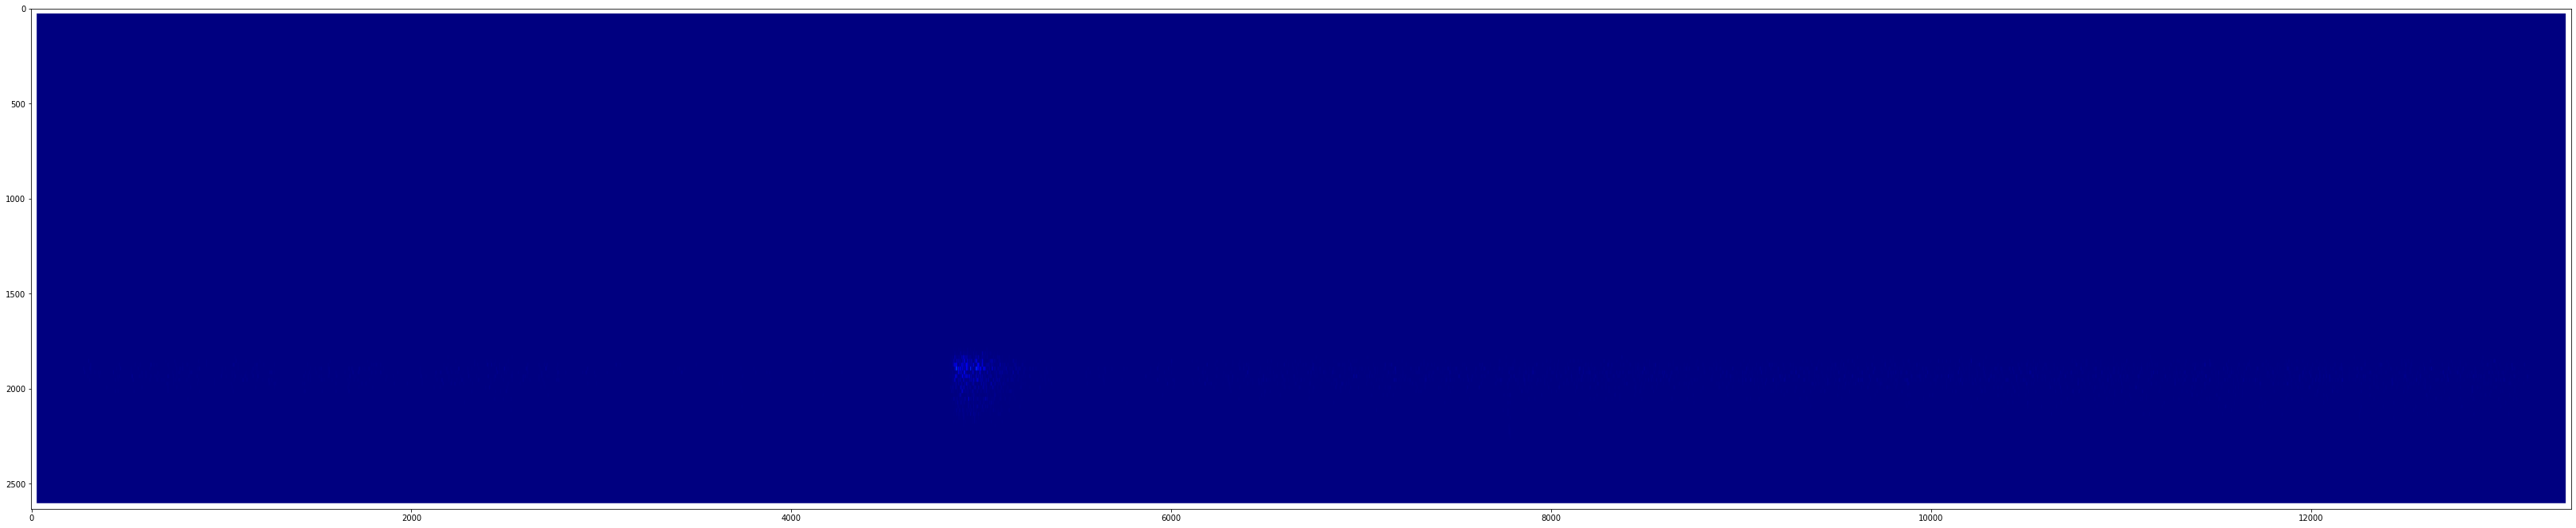

0.0 31199.466


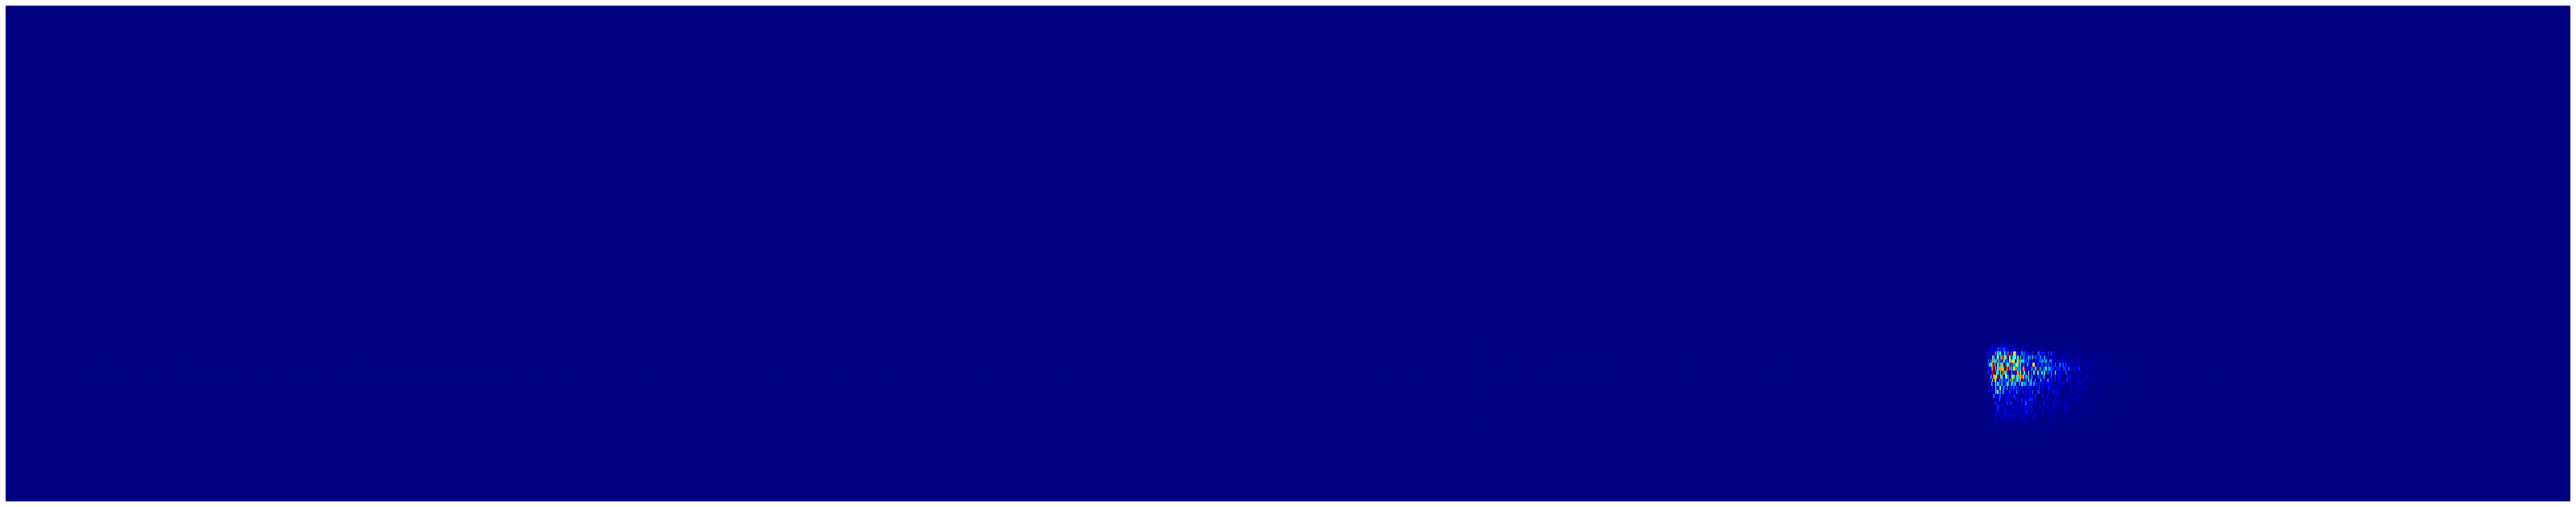

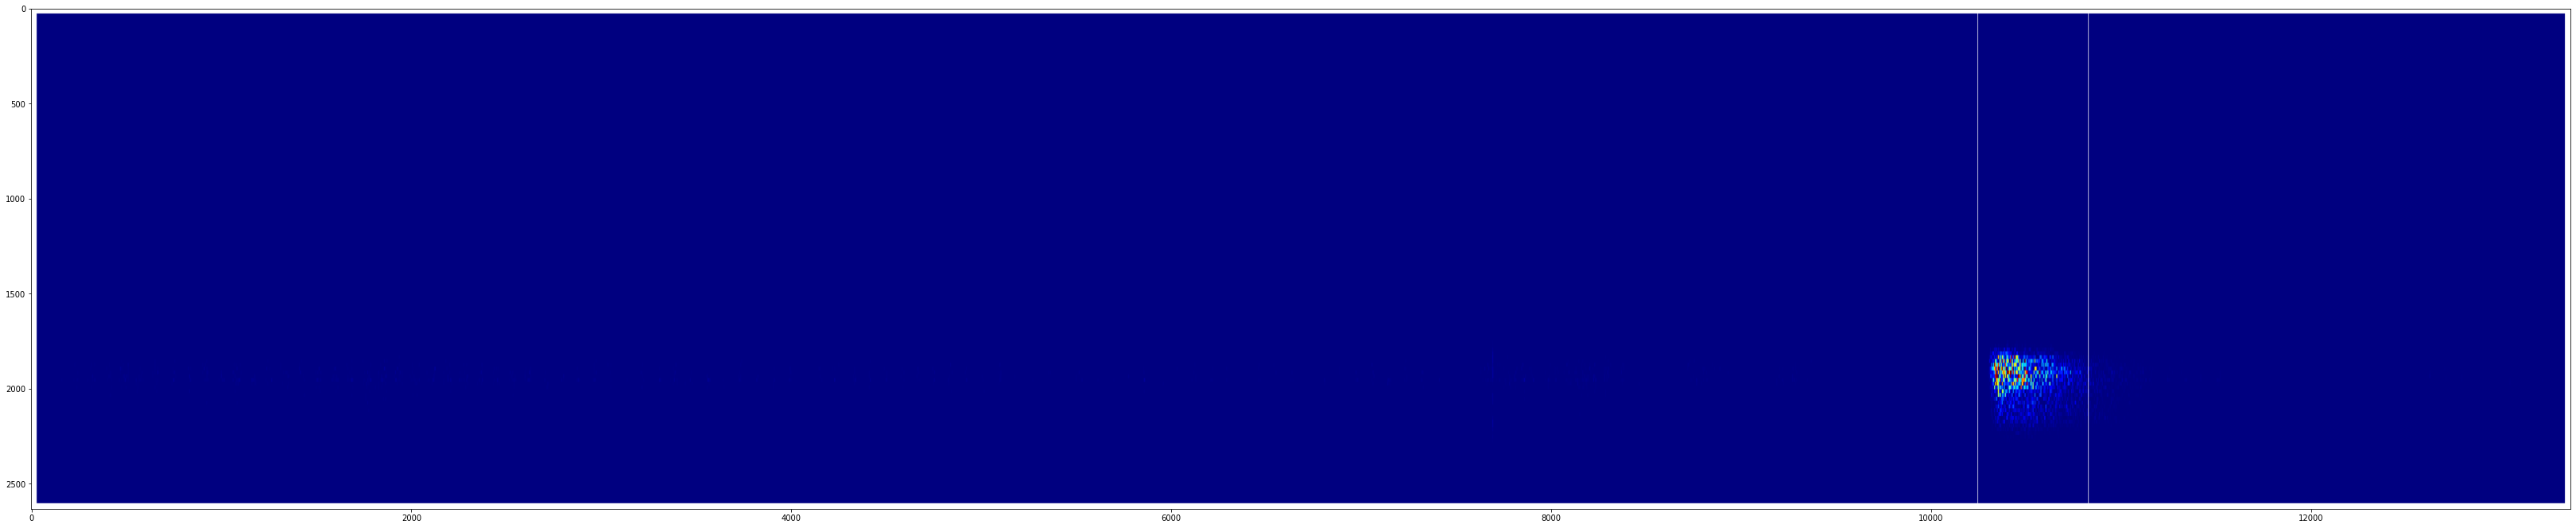

66231.58519078948 66839.432


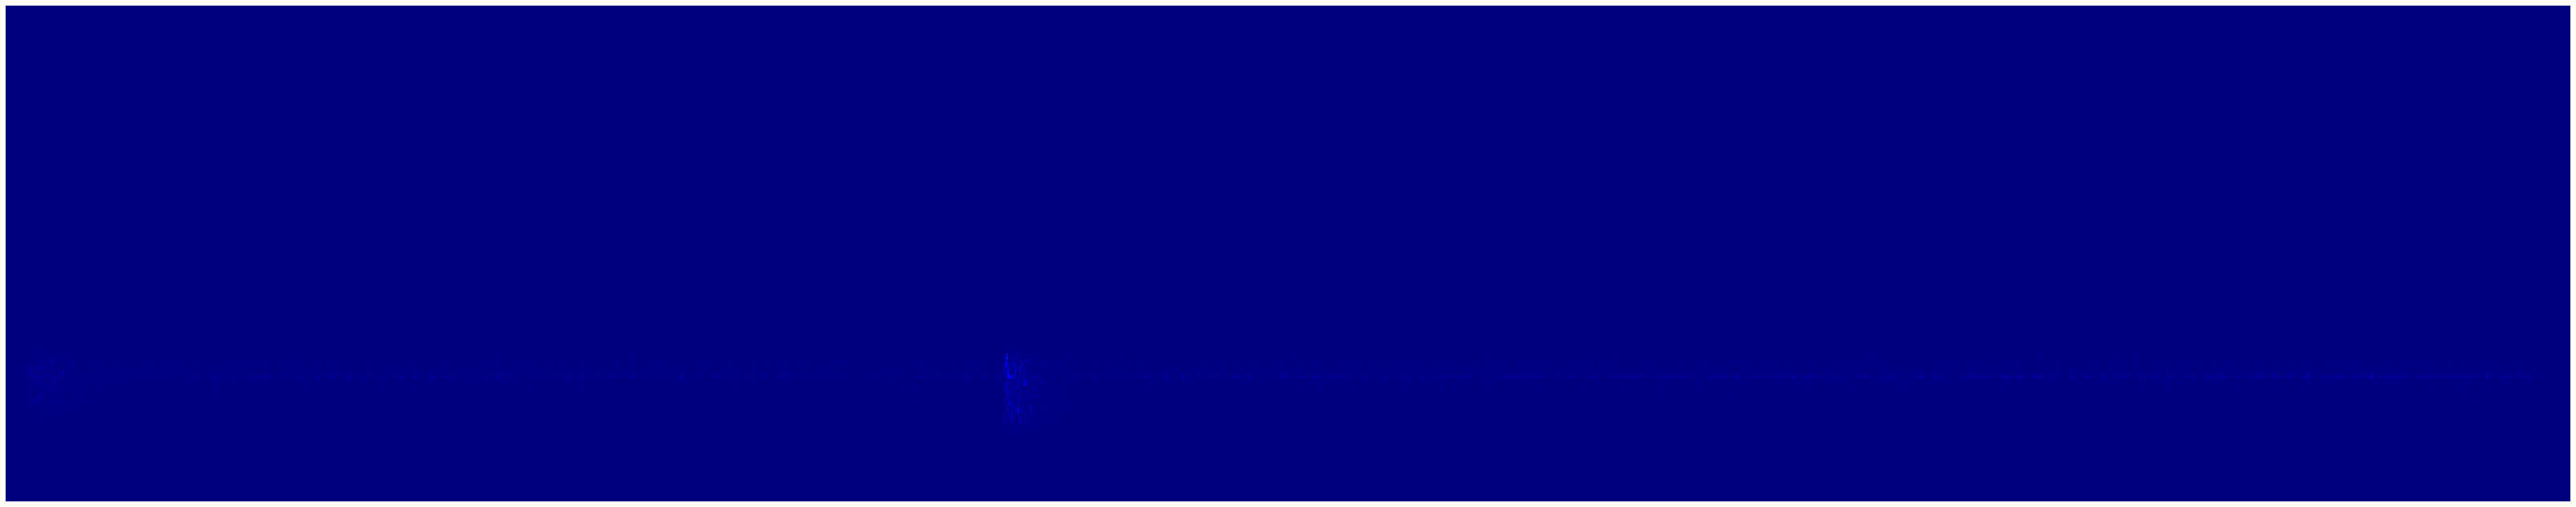

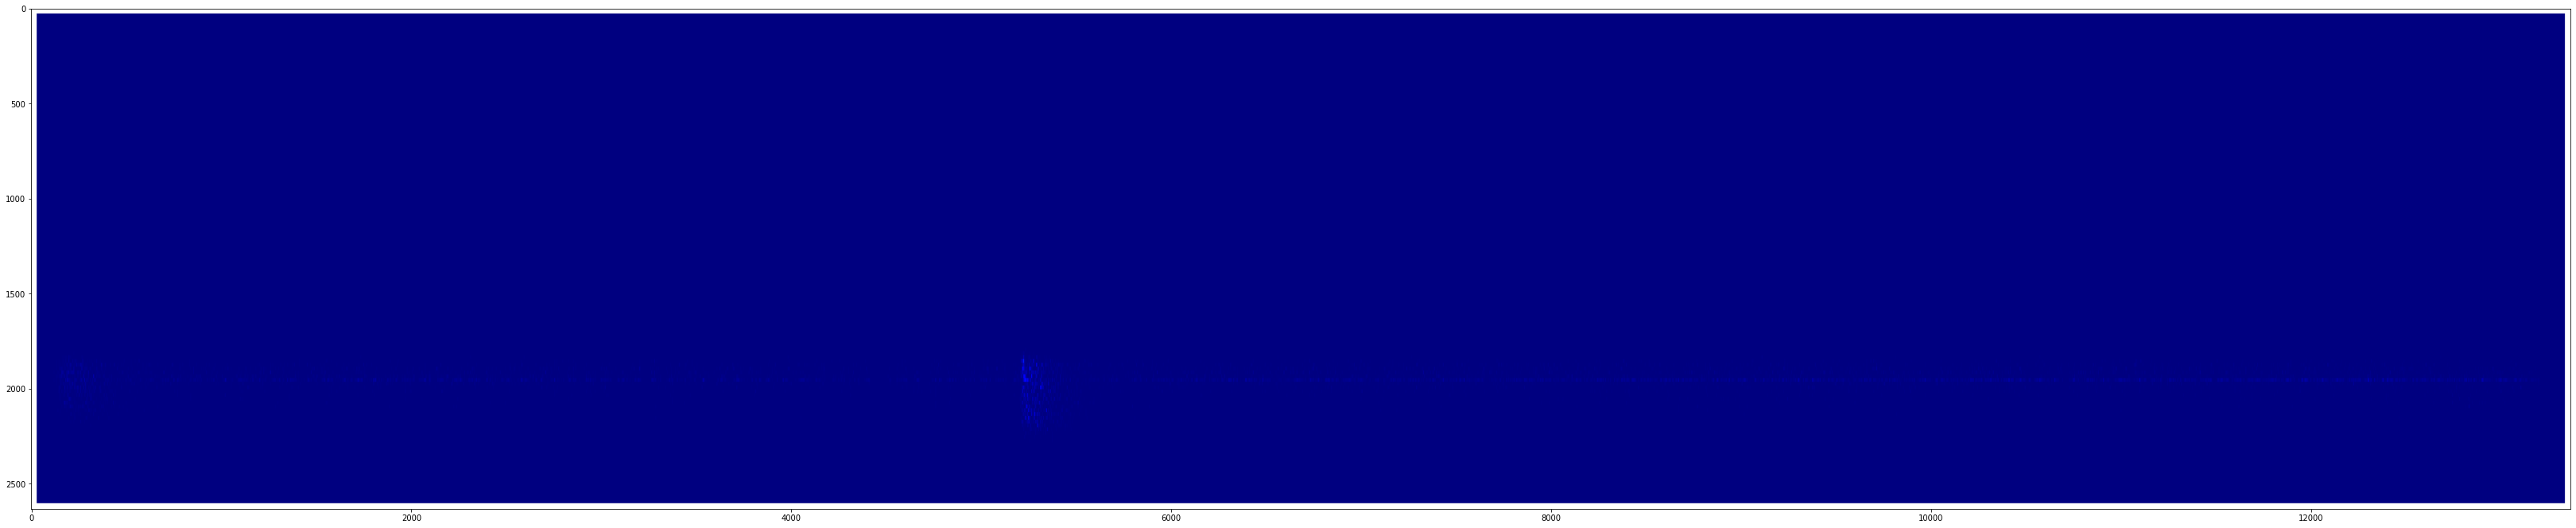

0.0 33479.651


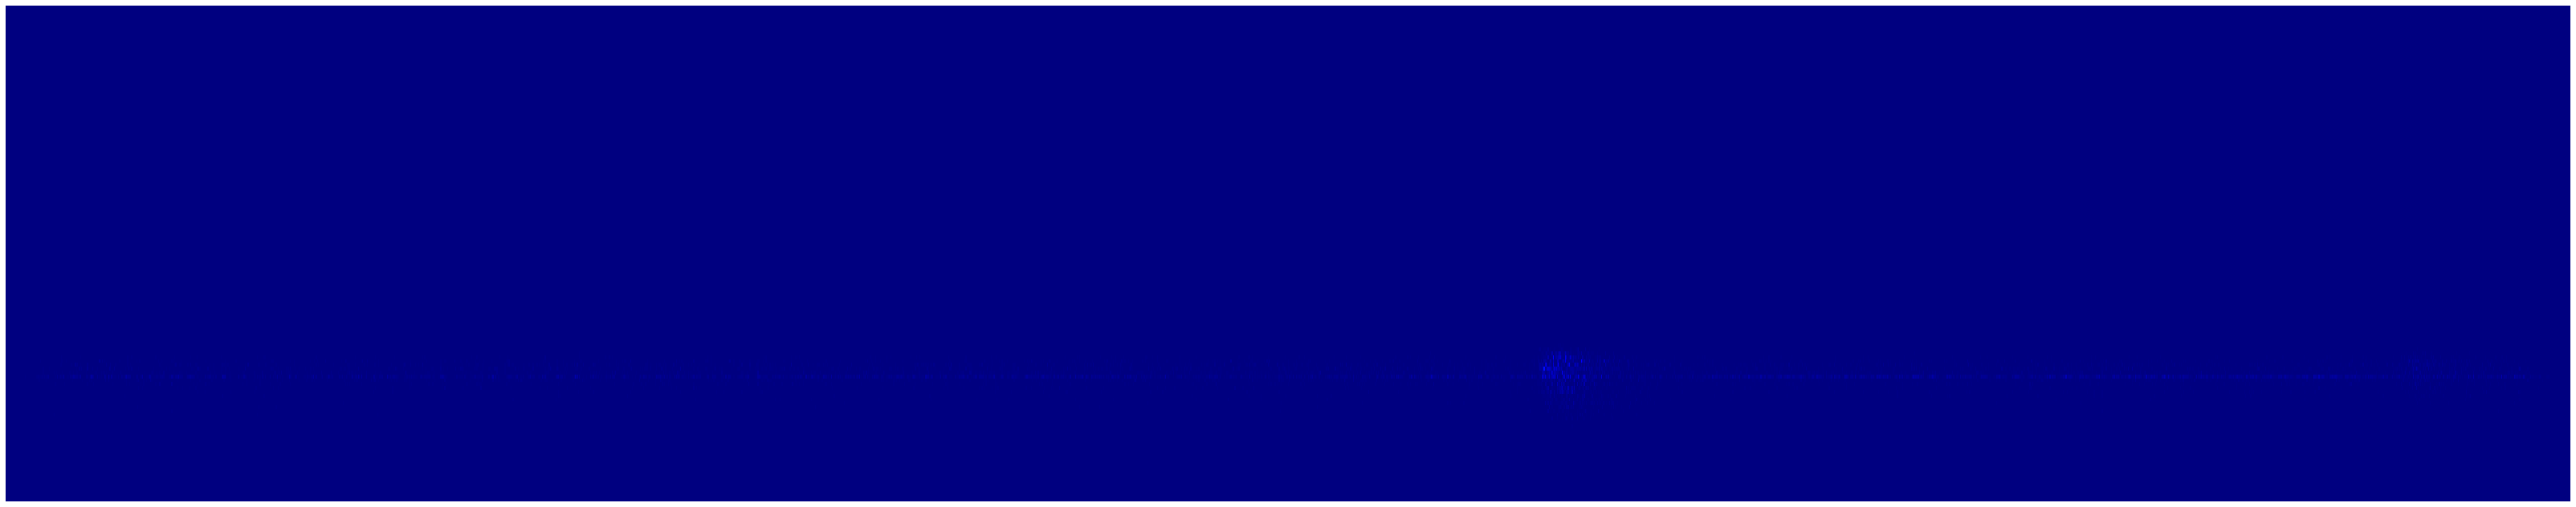

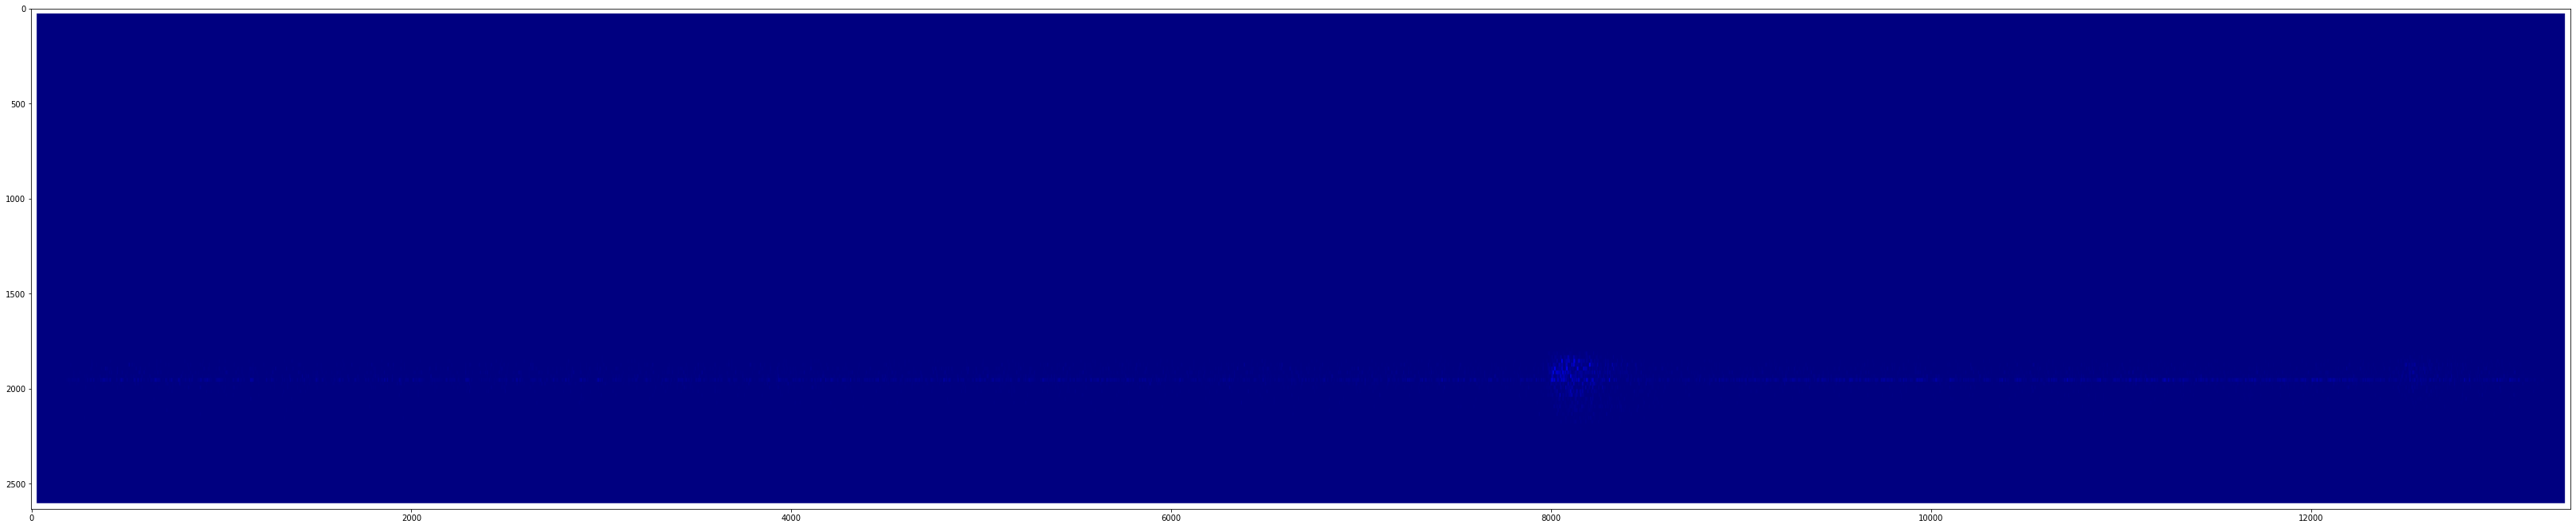

0.0 51479.354


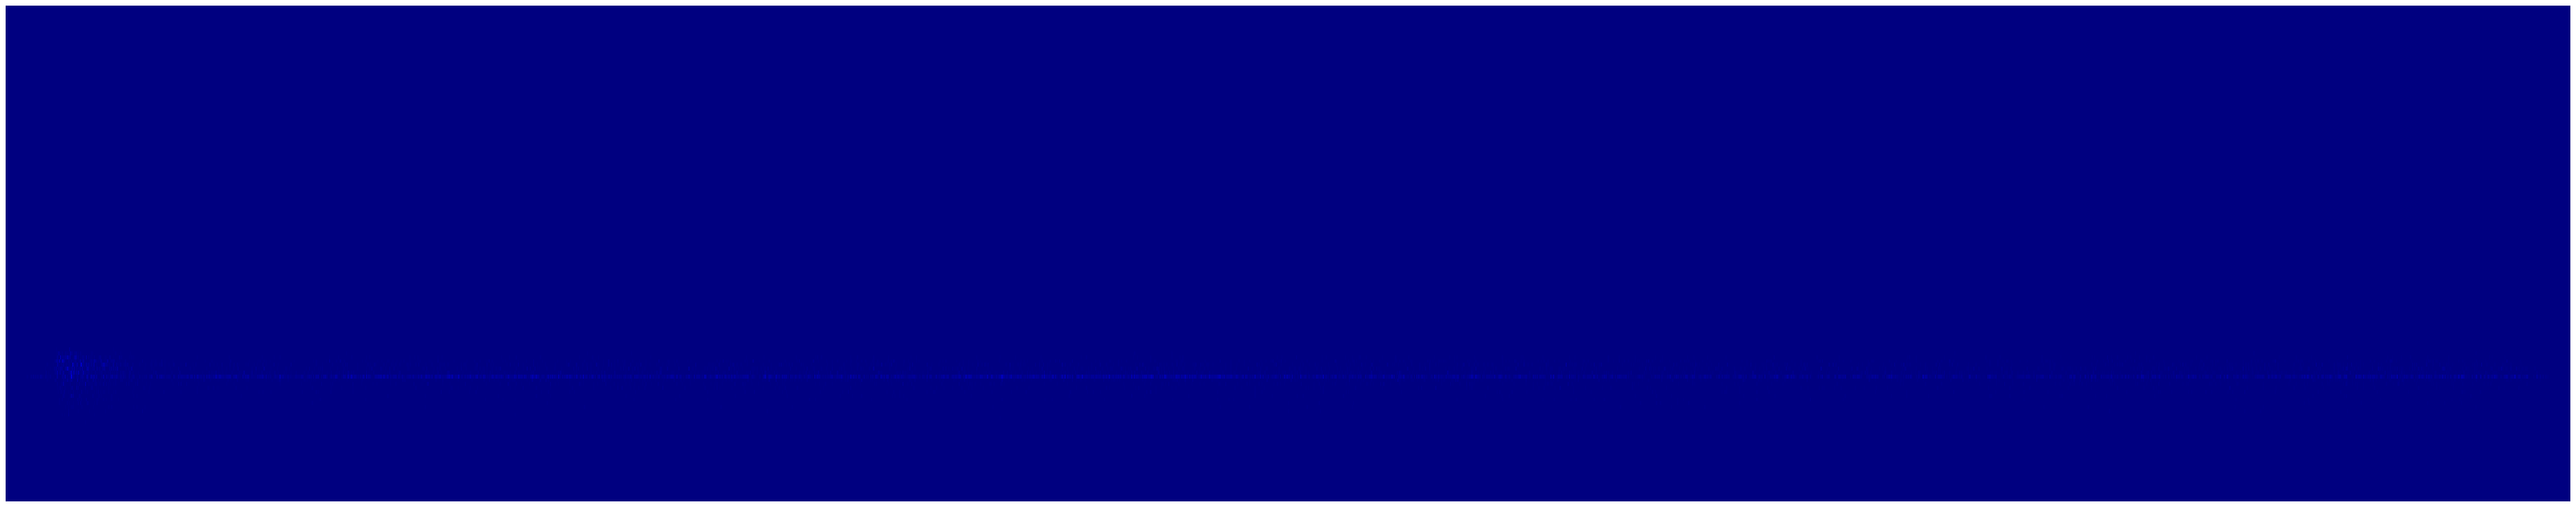

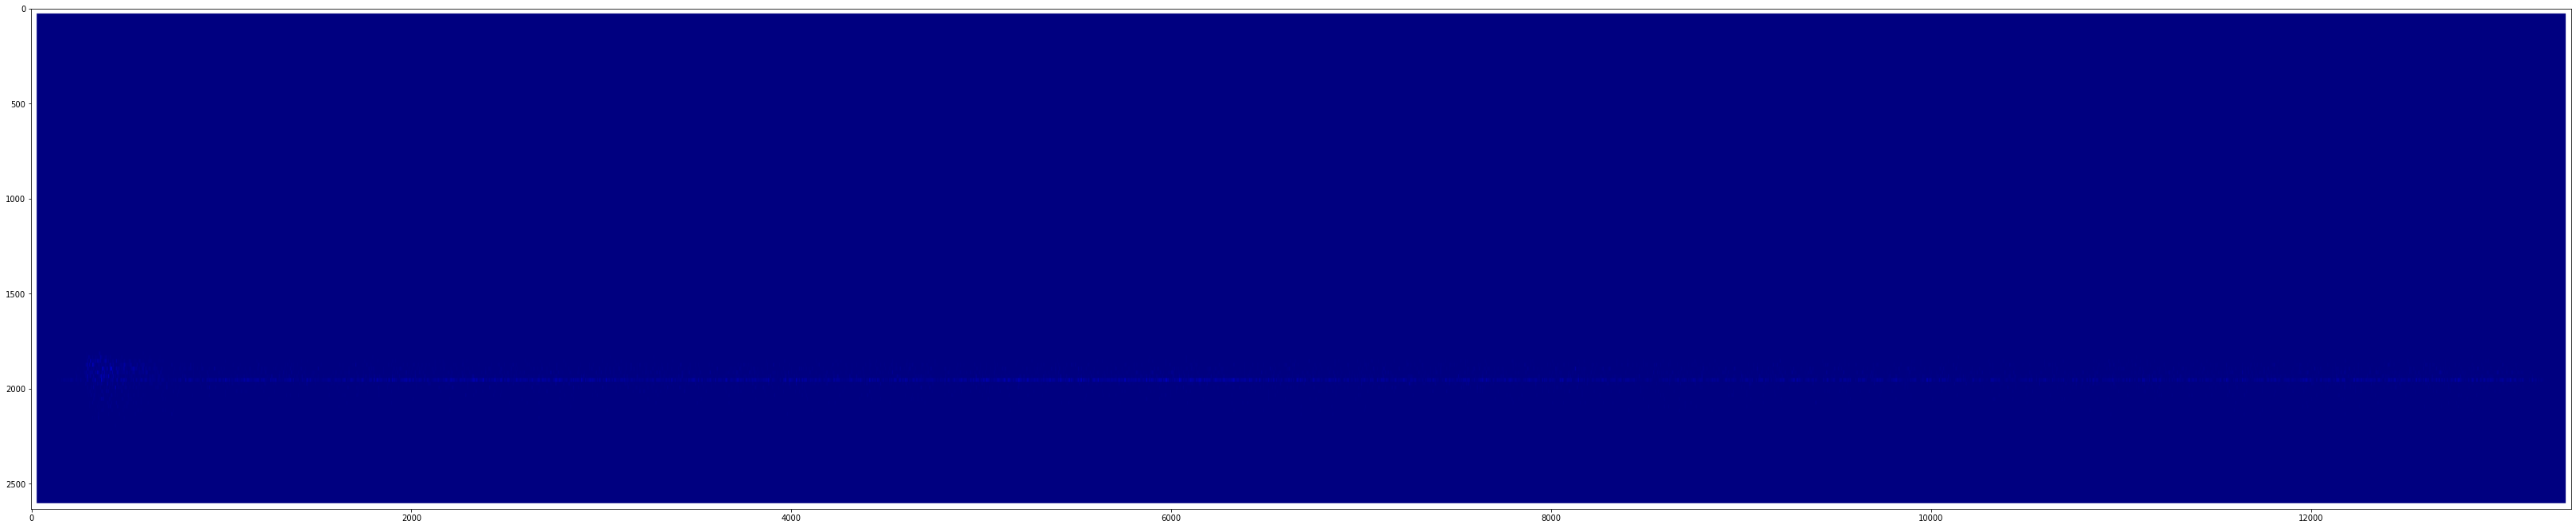

0.0 1379.476


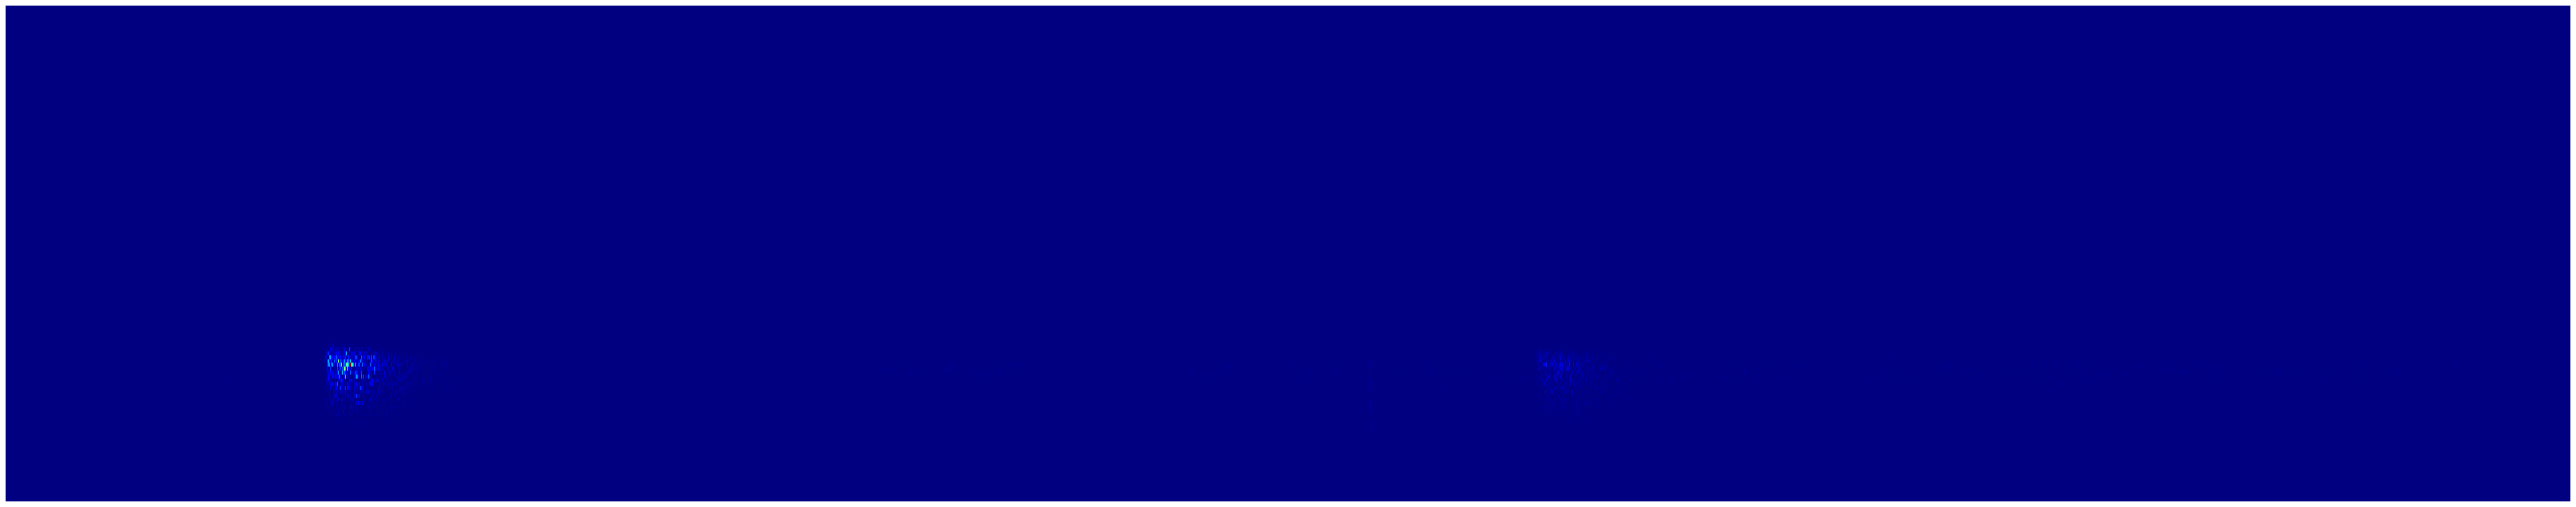

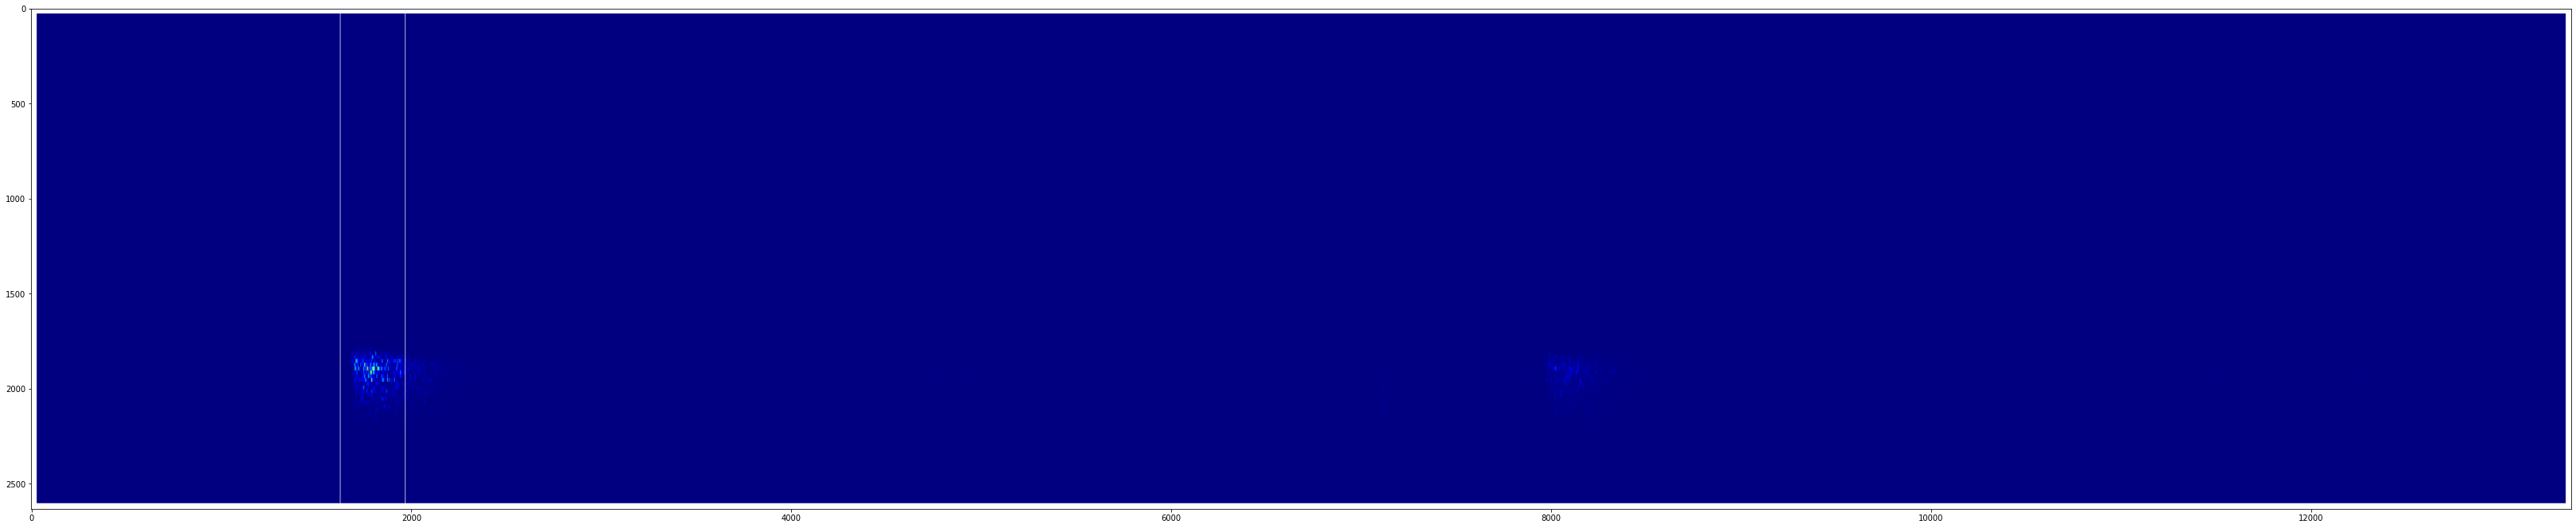

10515.803100617639 10619.807


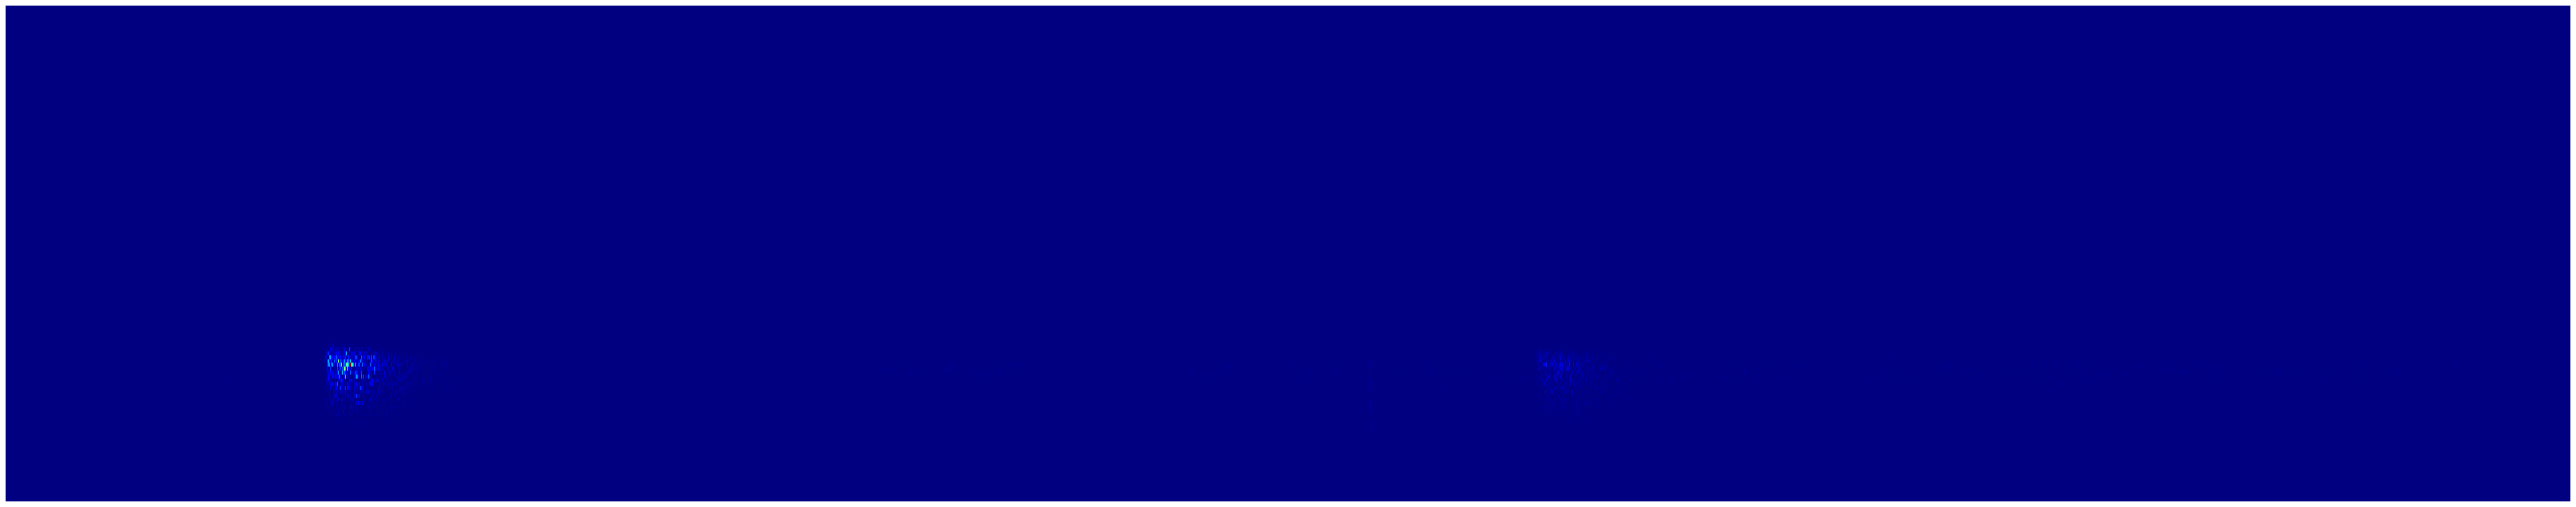

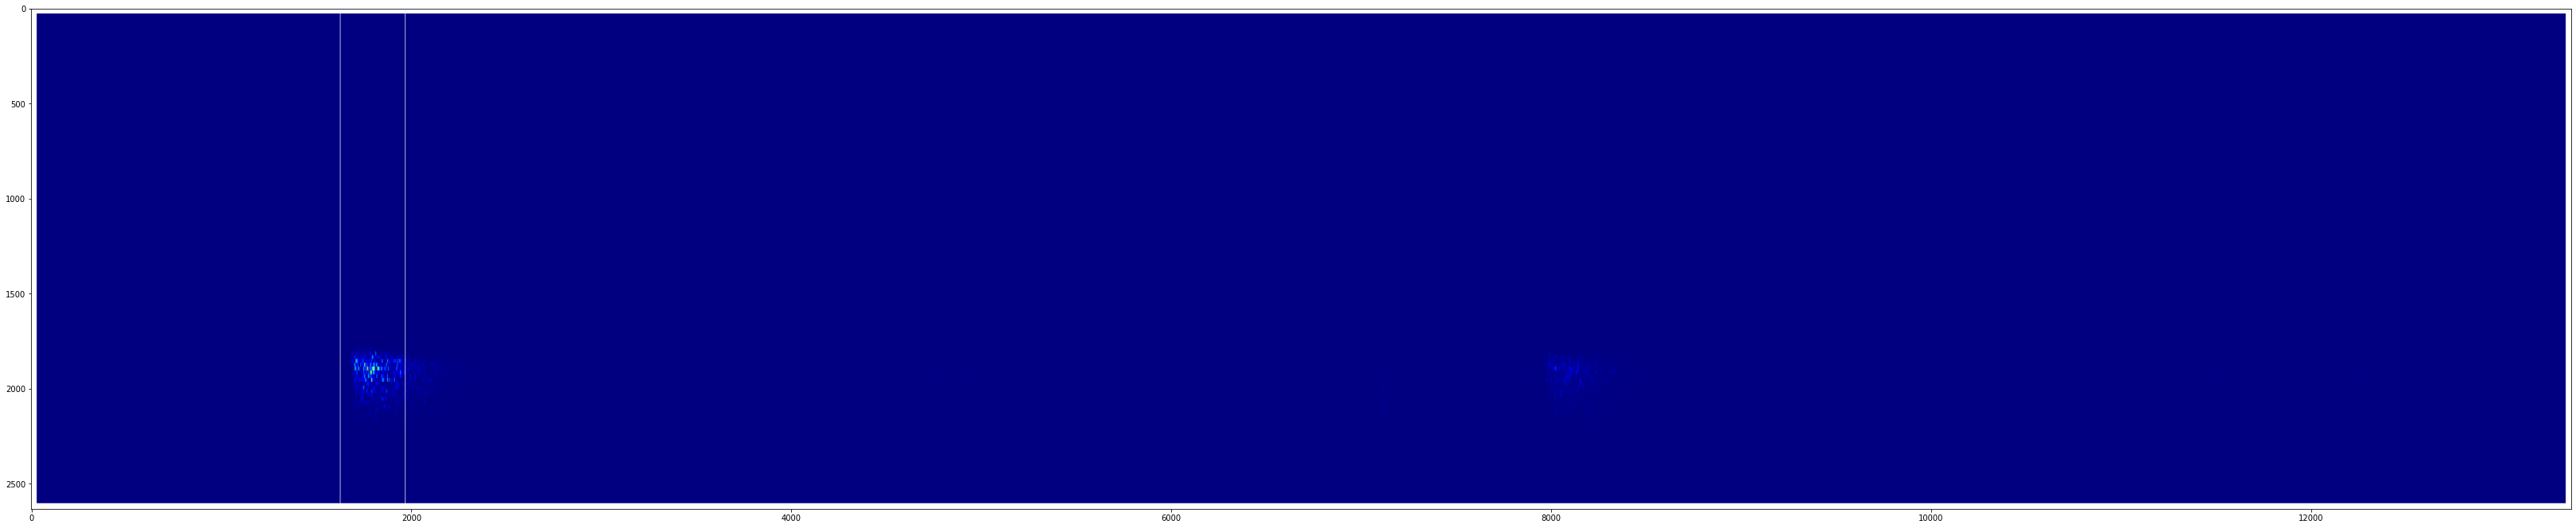

10515.803100617639 51239.807


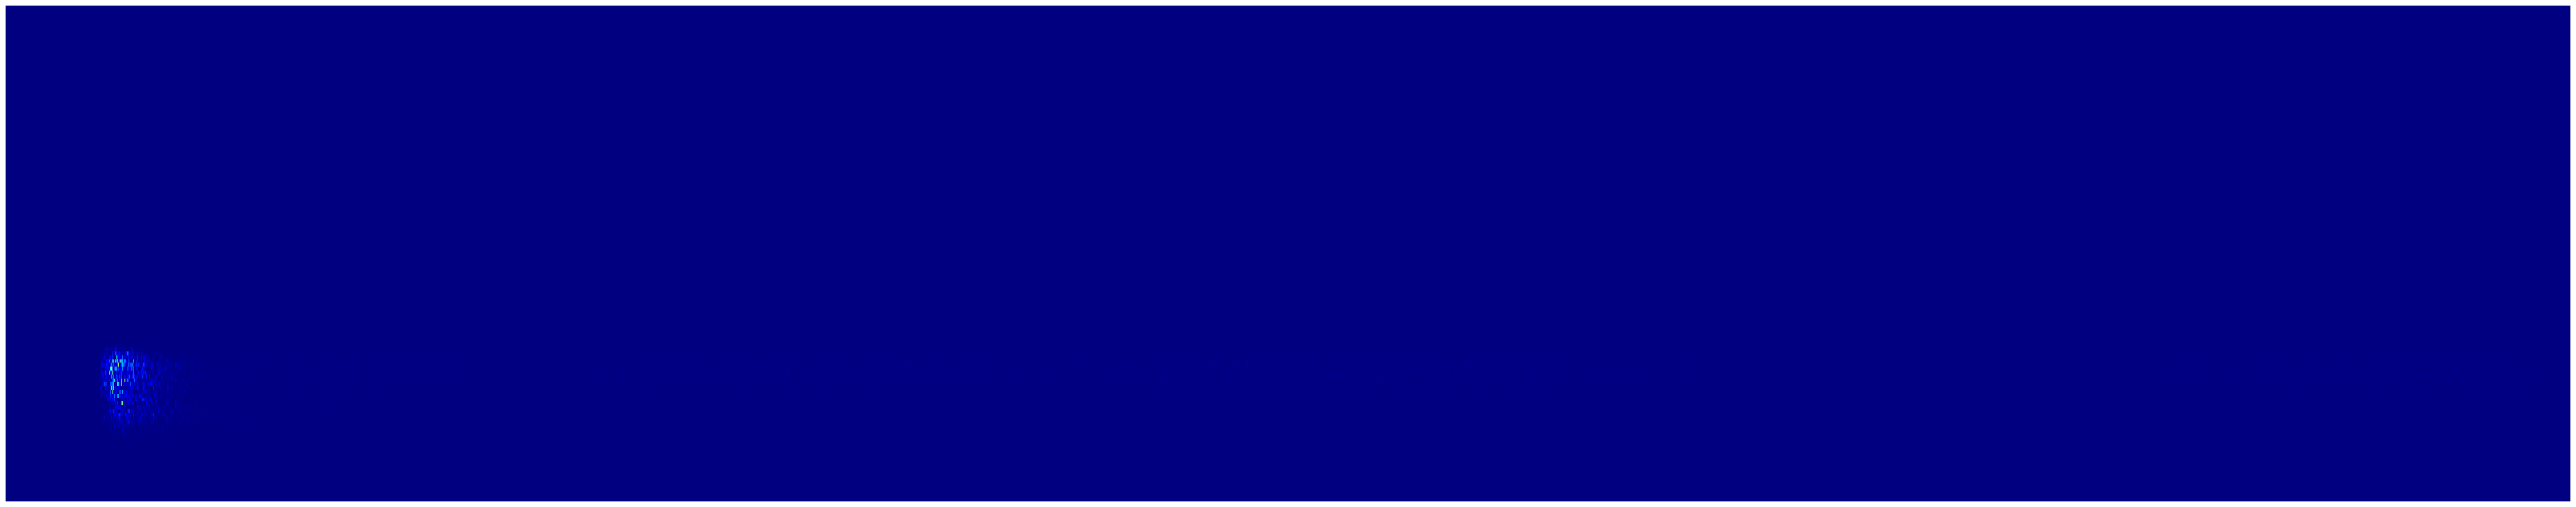

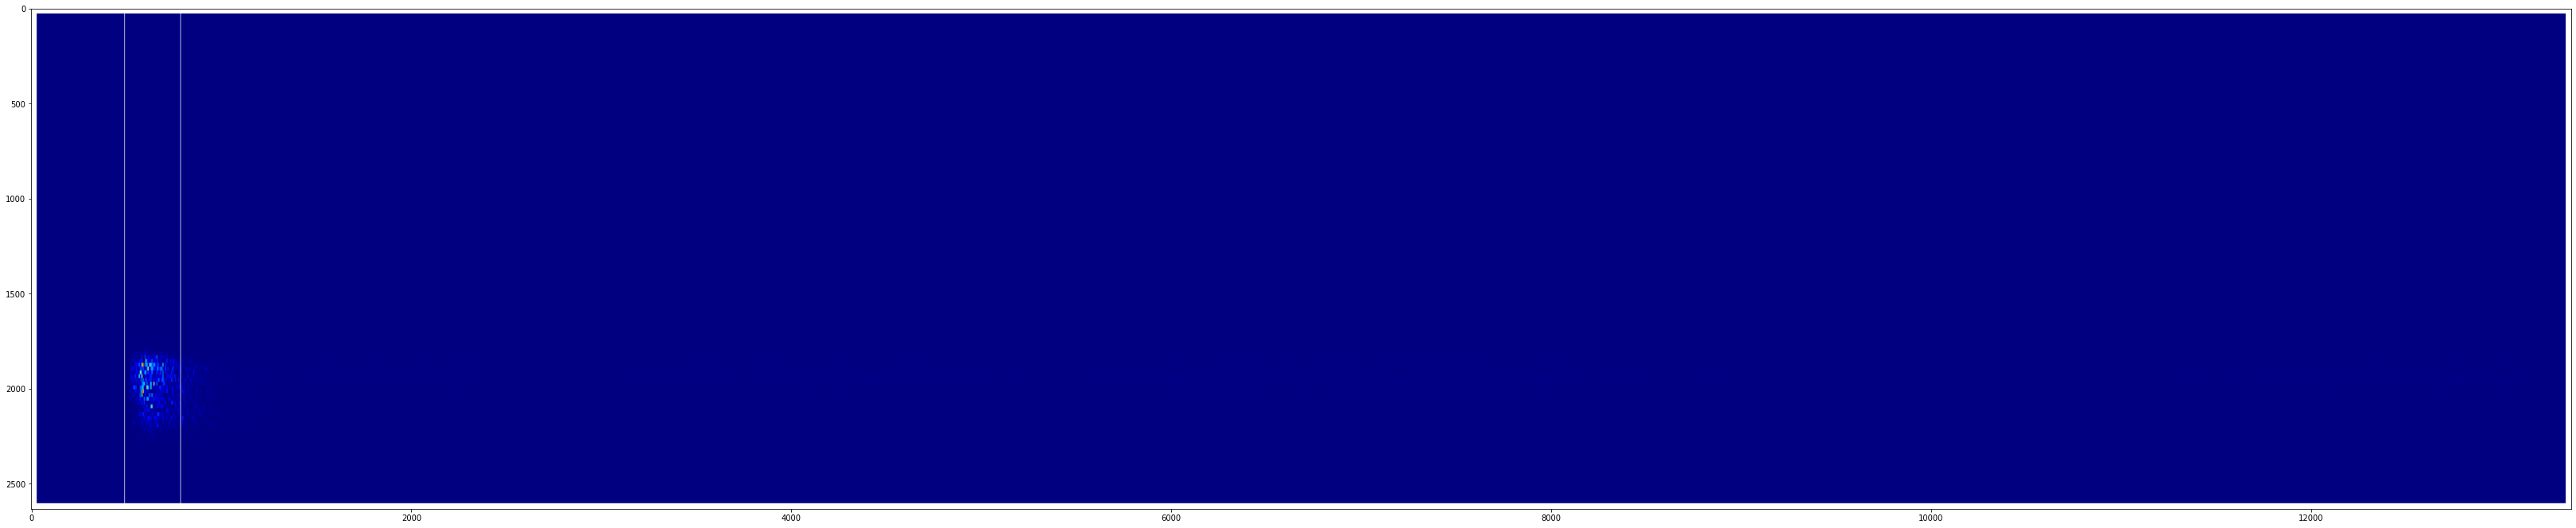

3179.9700552149316 3119.641


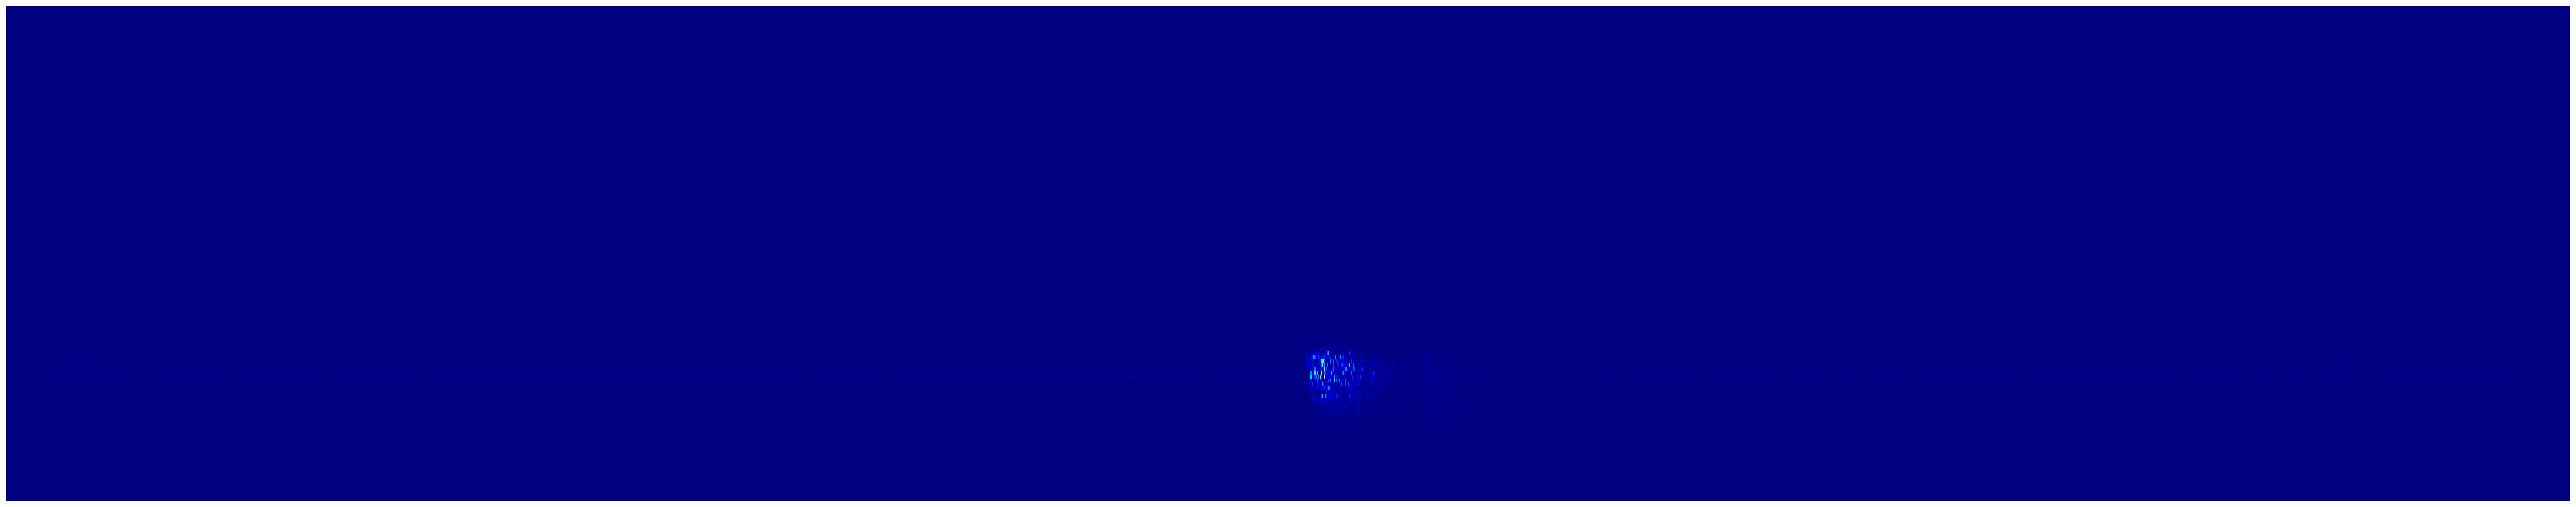

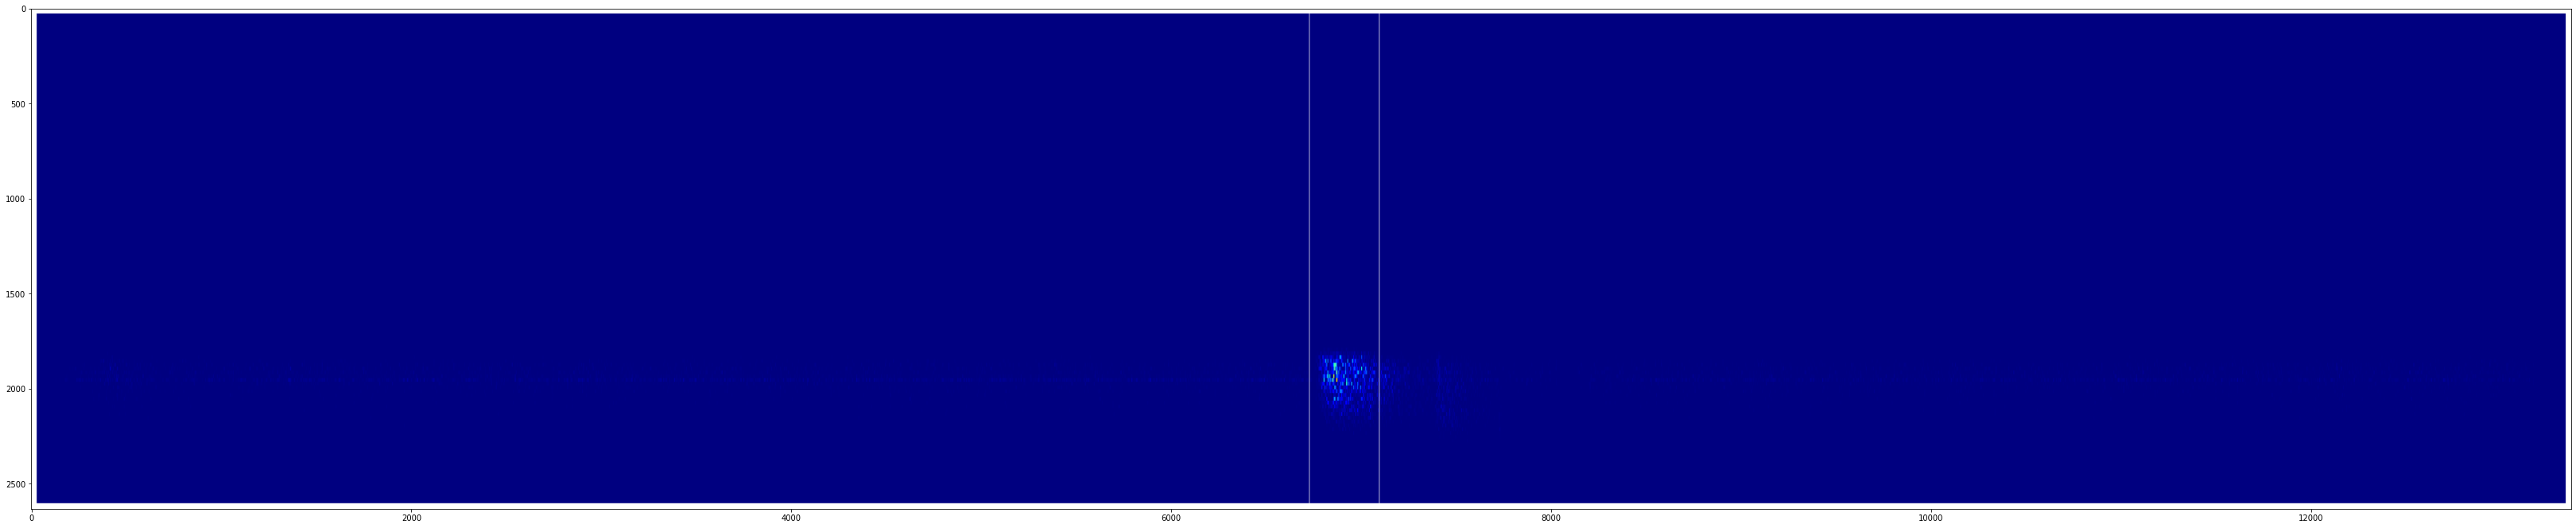

43479.58847374186 43499.774


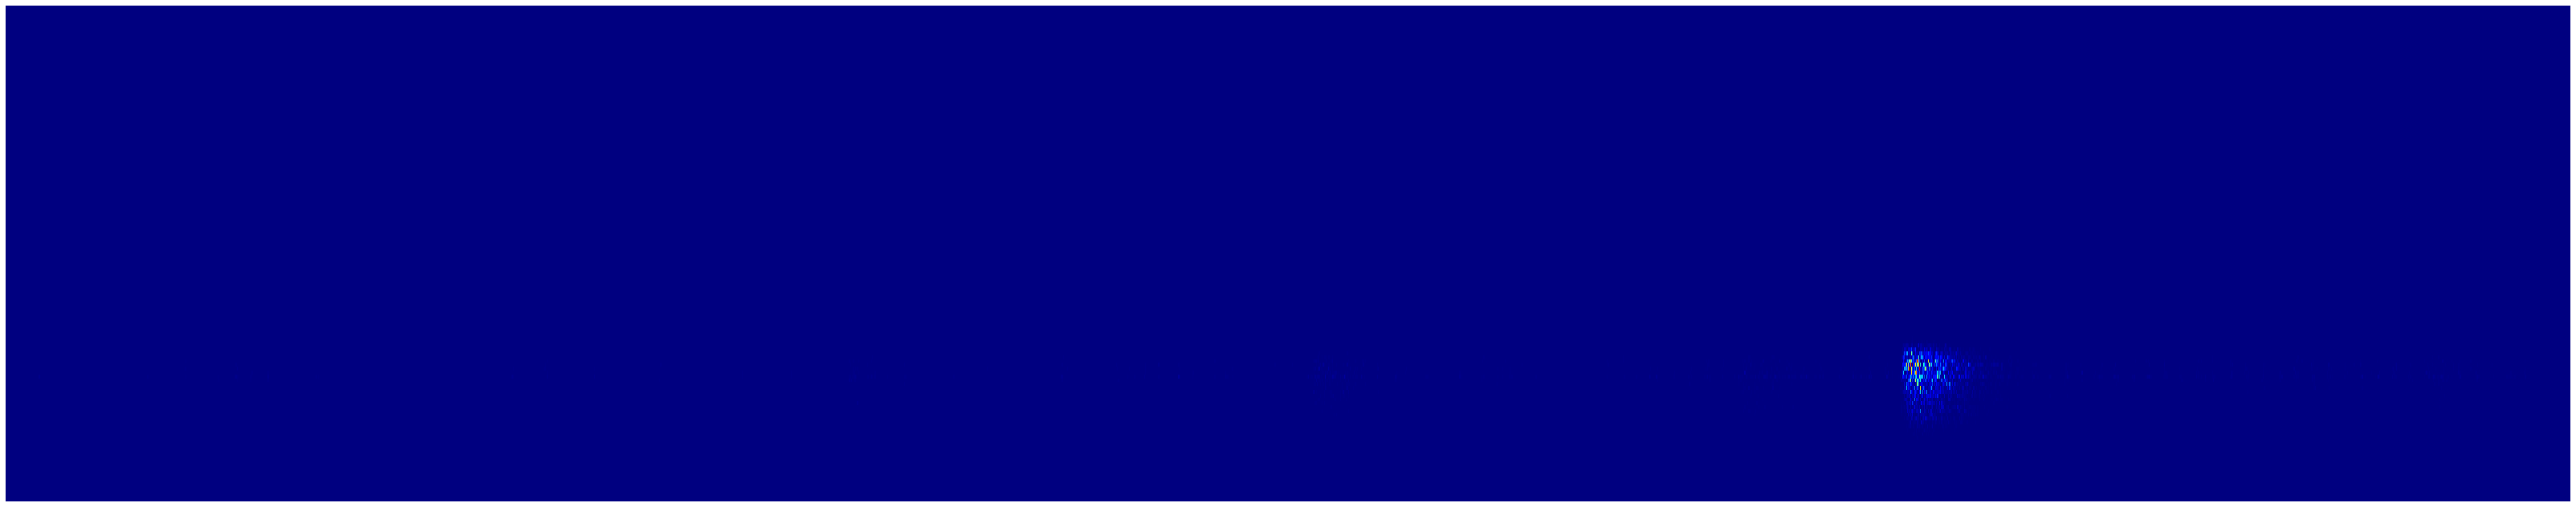

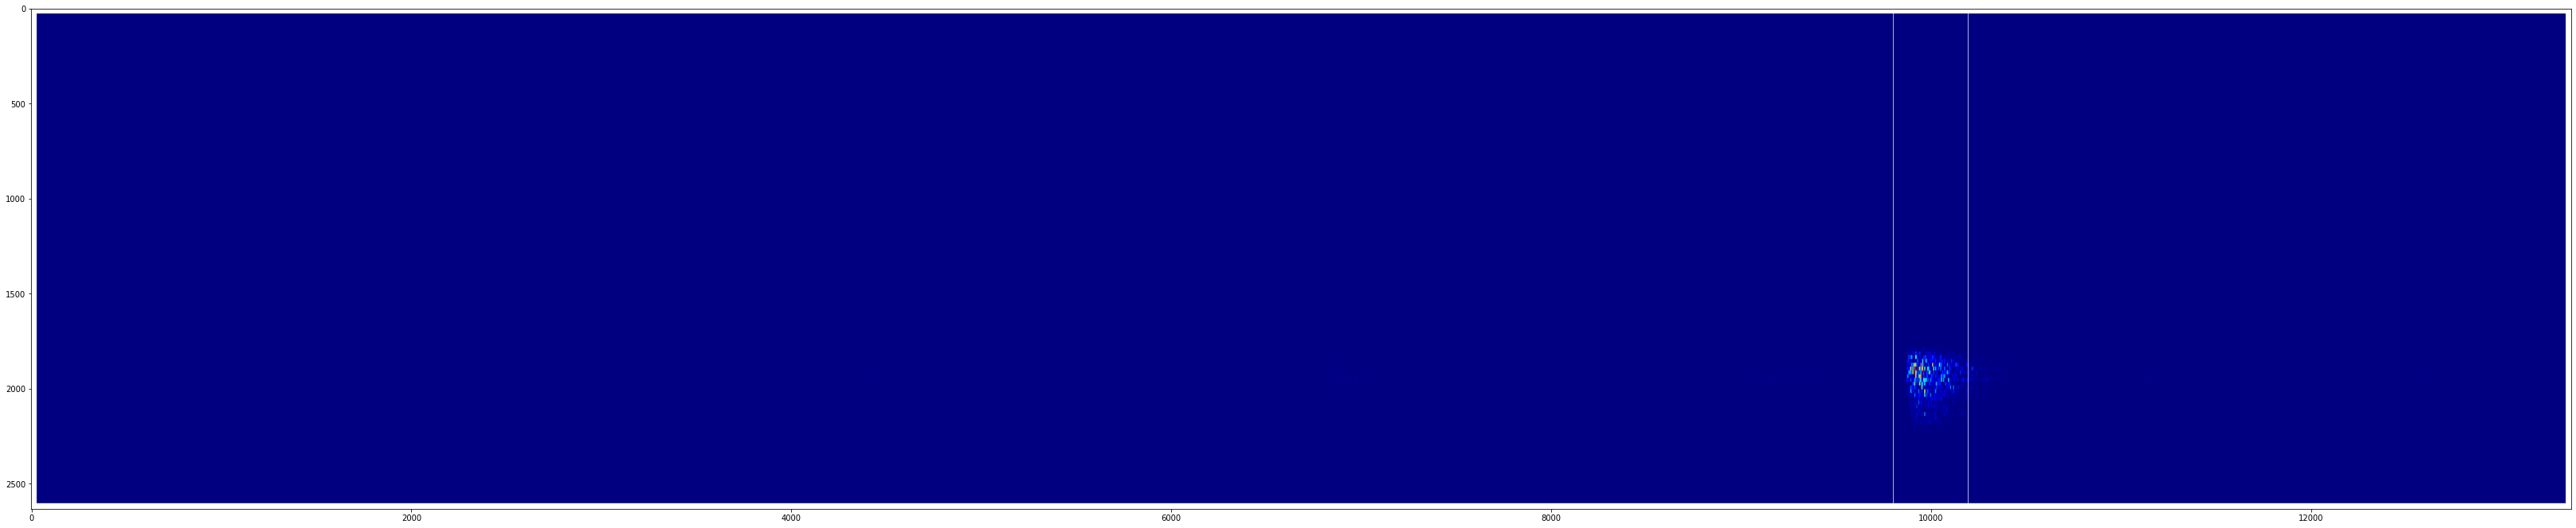

63341.19892054244 63779.004


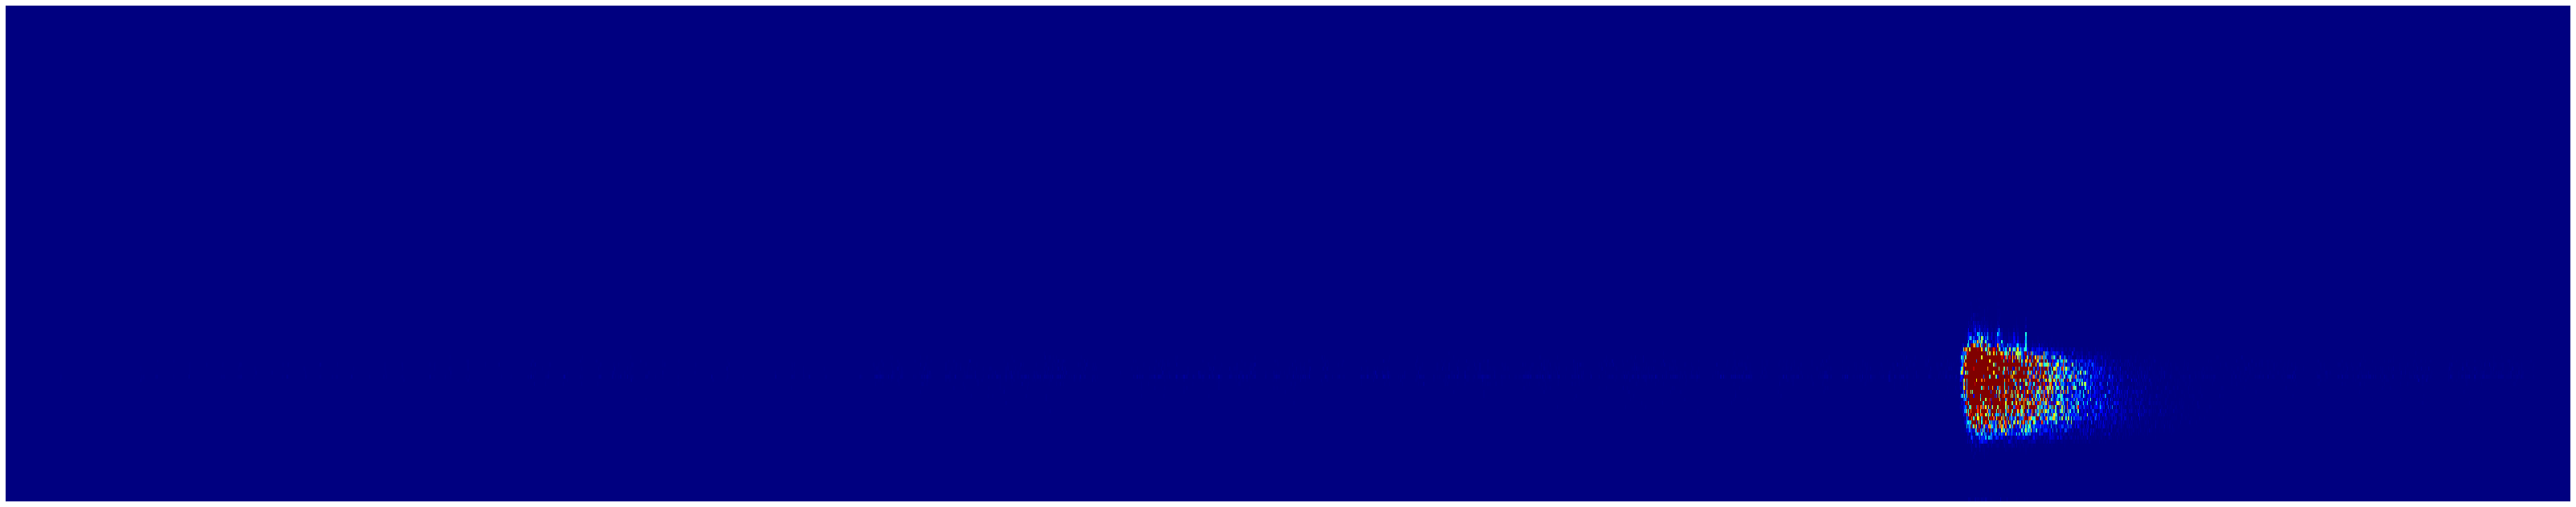

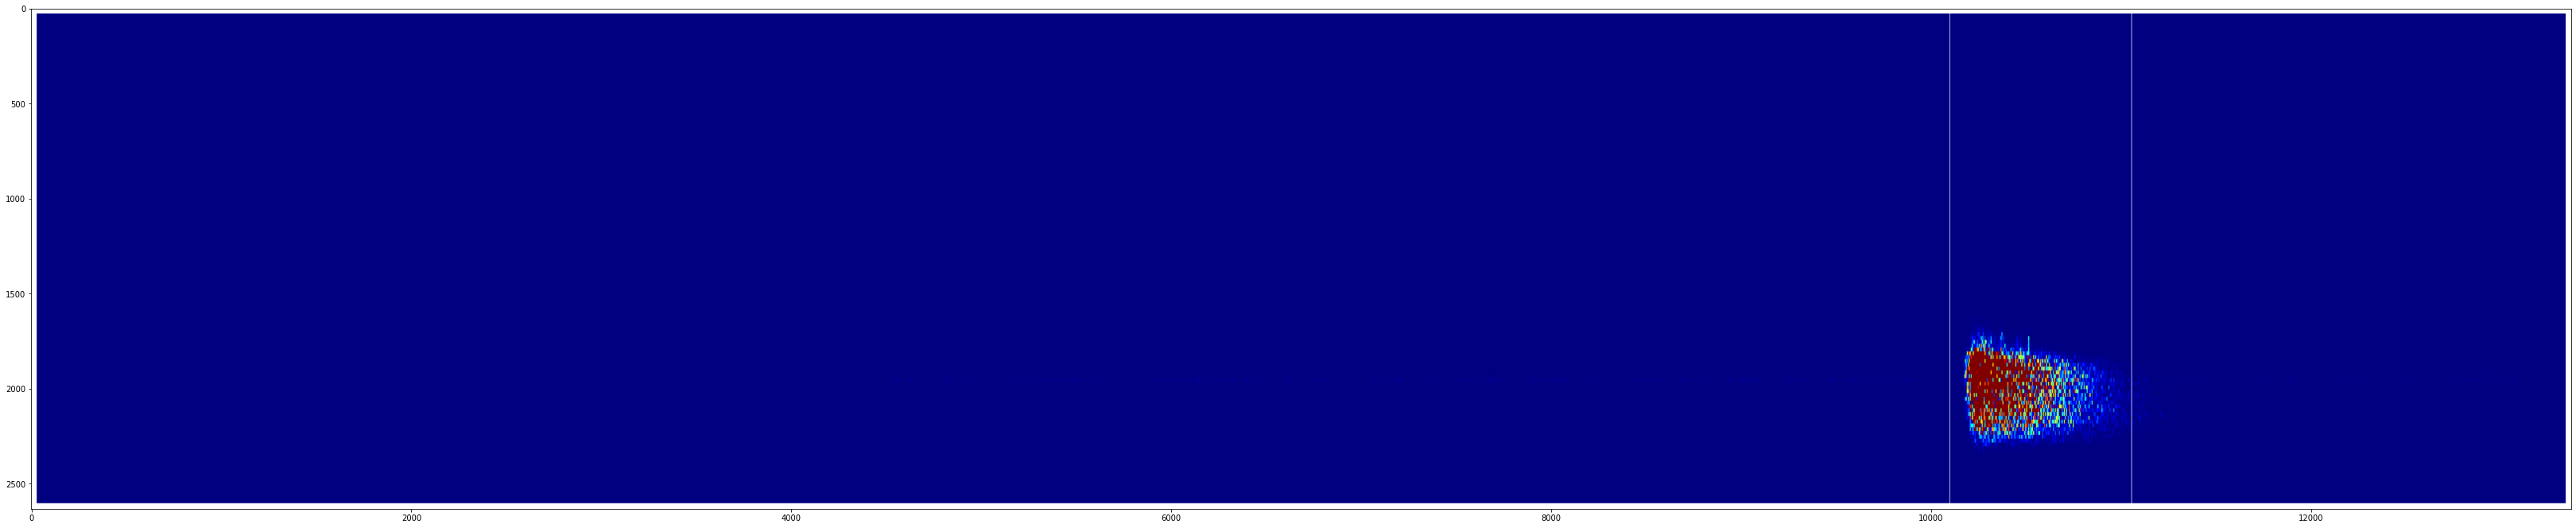

65261.39509727539 65699.813


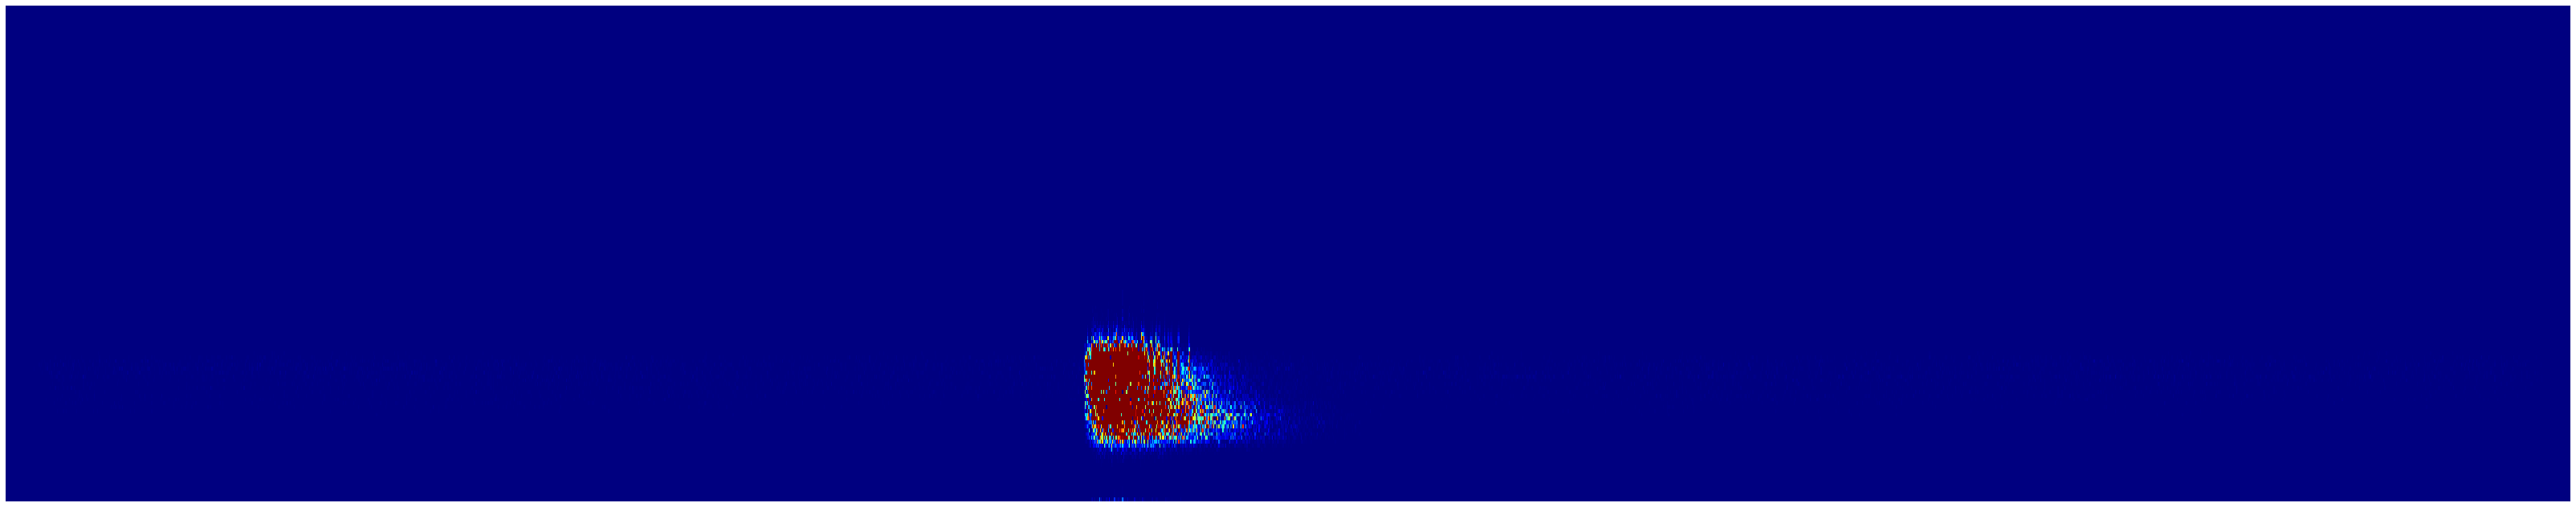

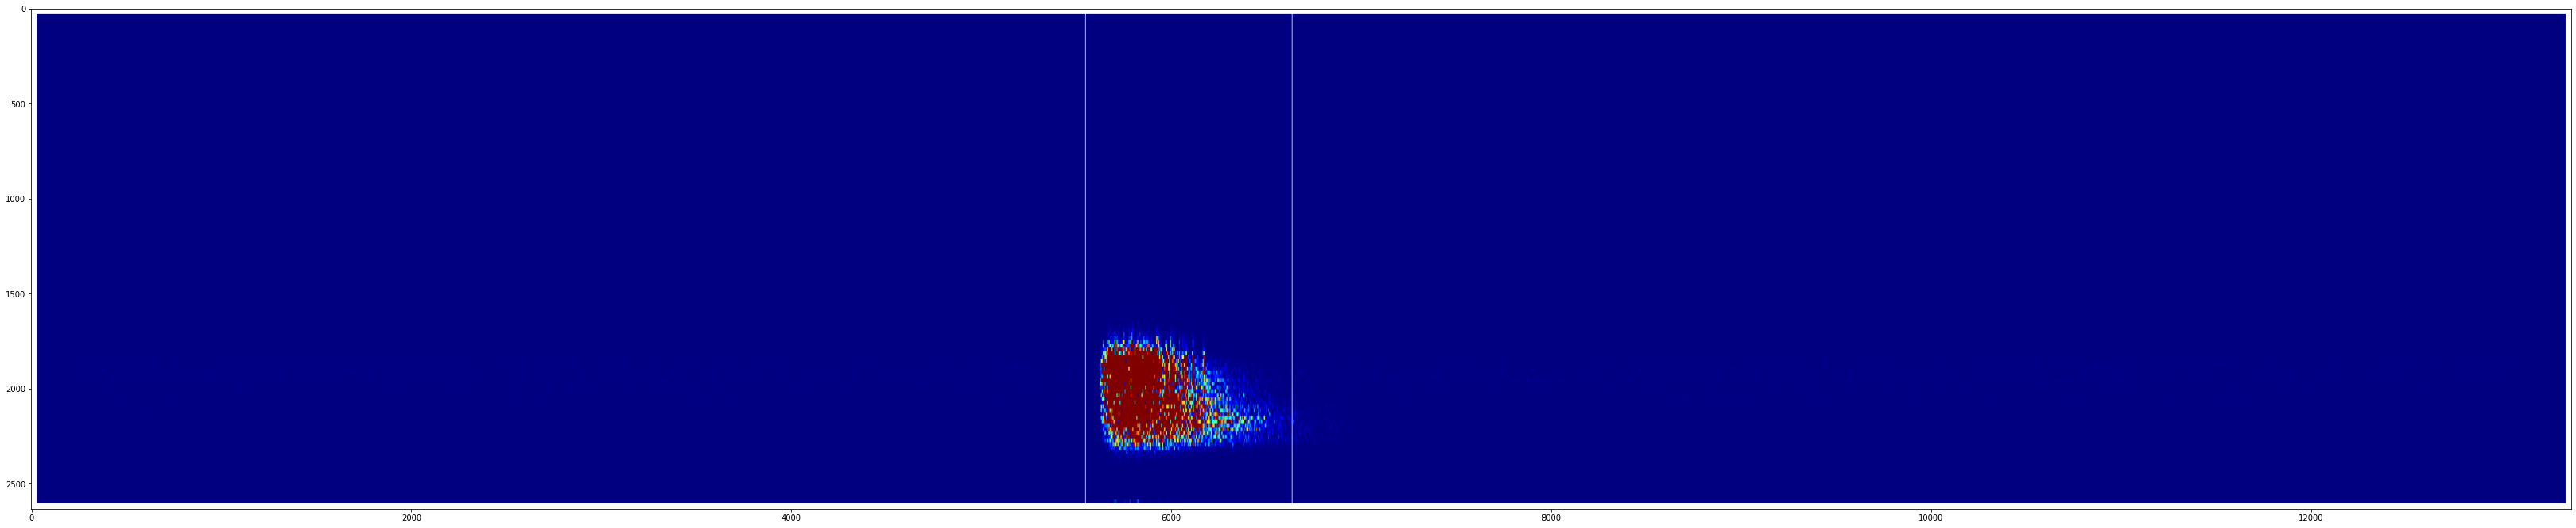

35865.33804184591 36299.543


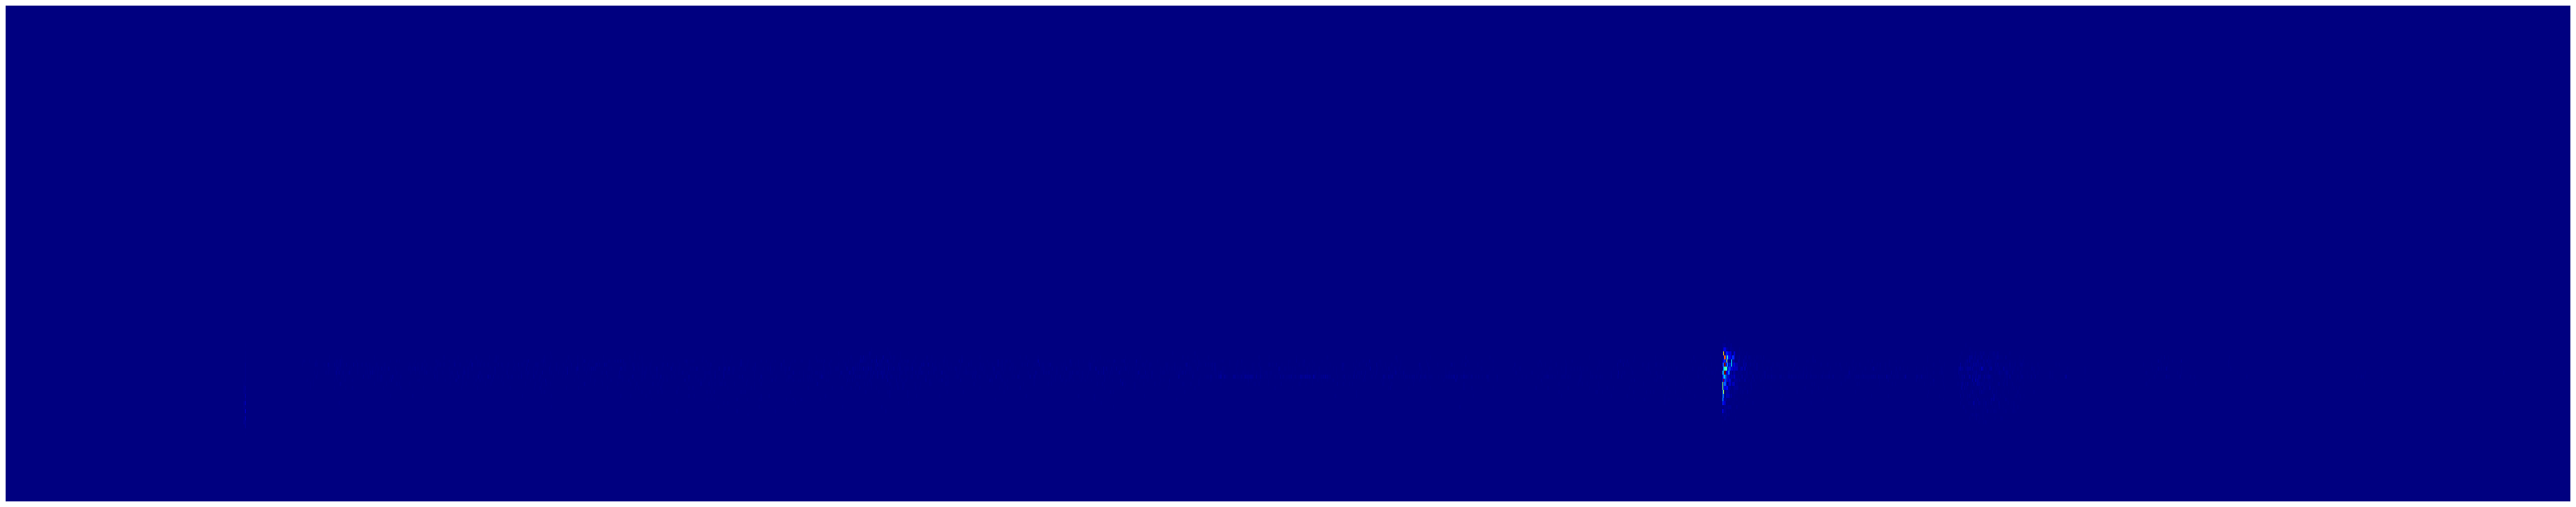

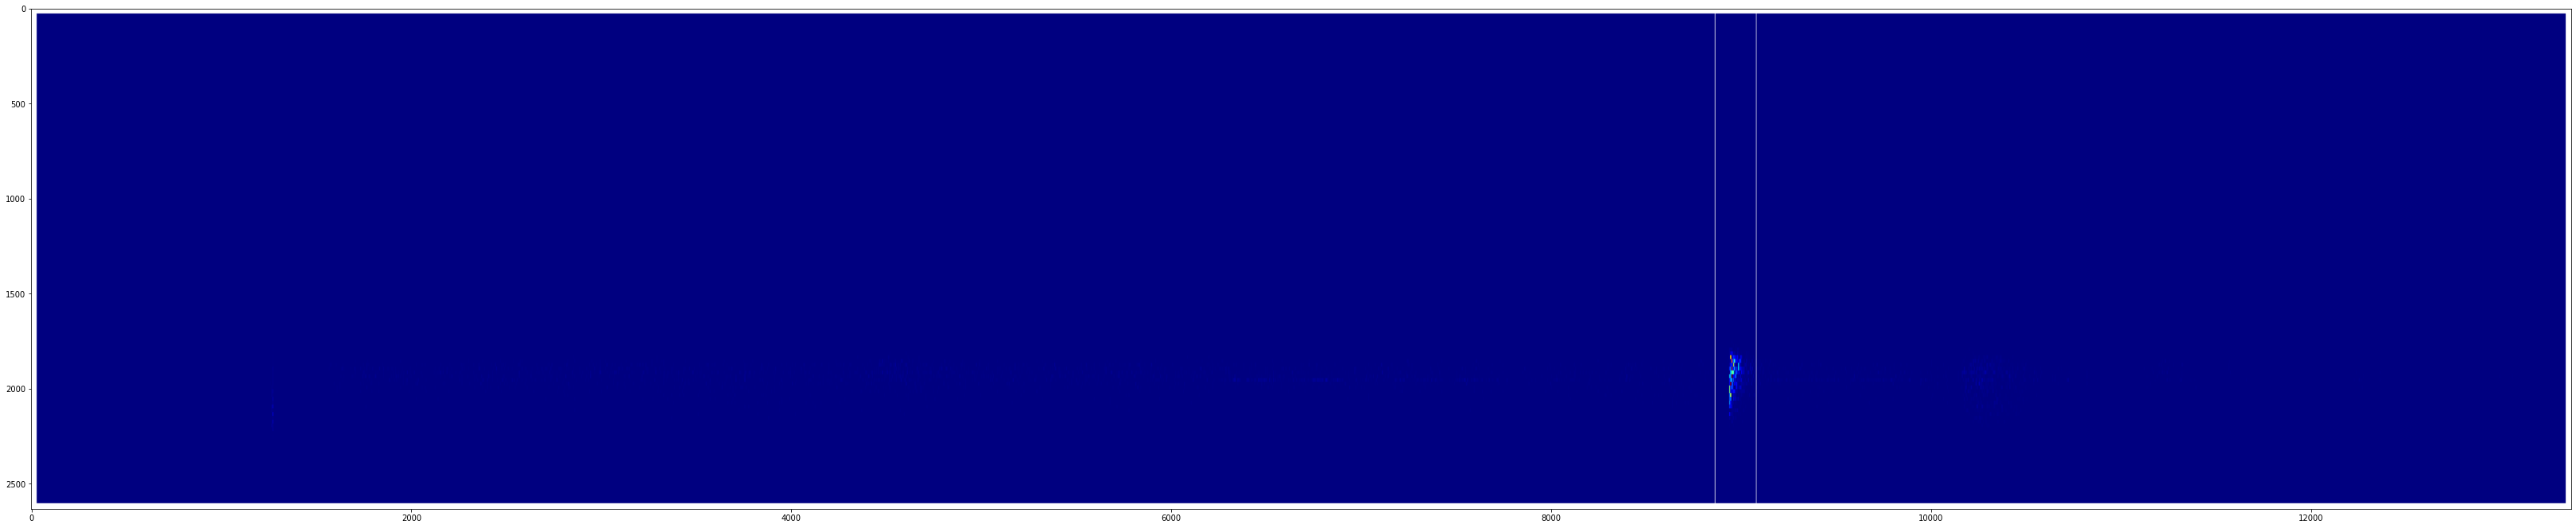

57277.84085904949 57779.761


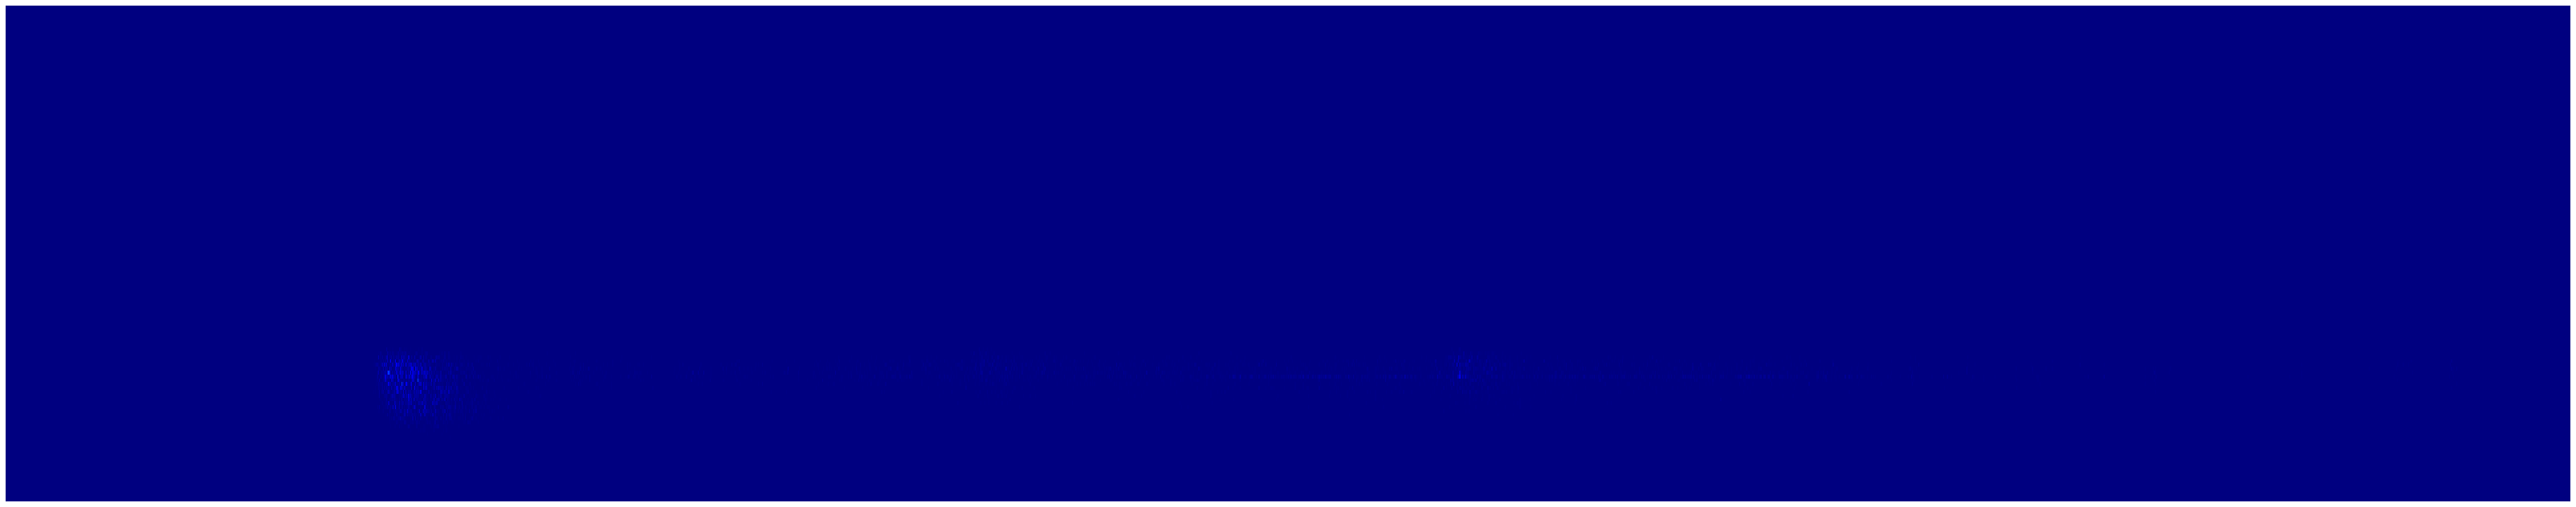

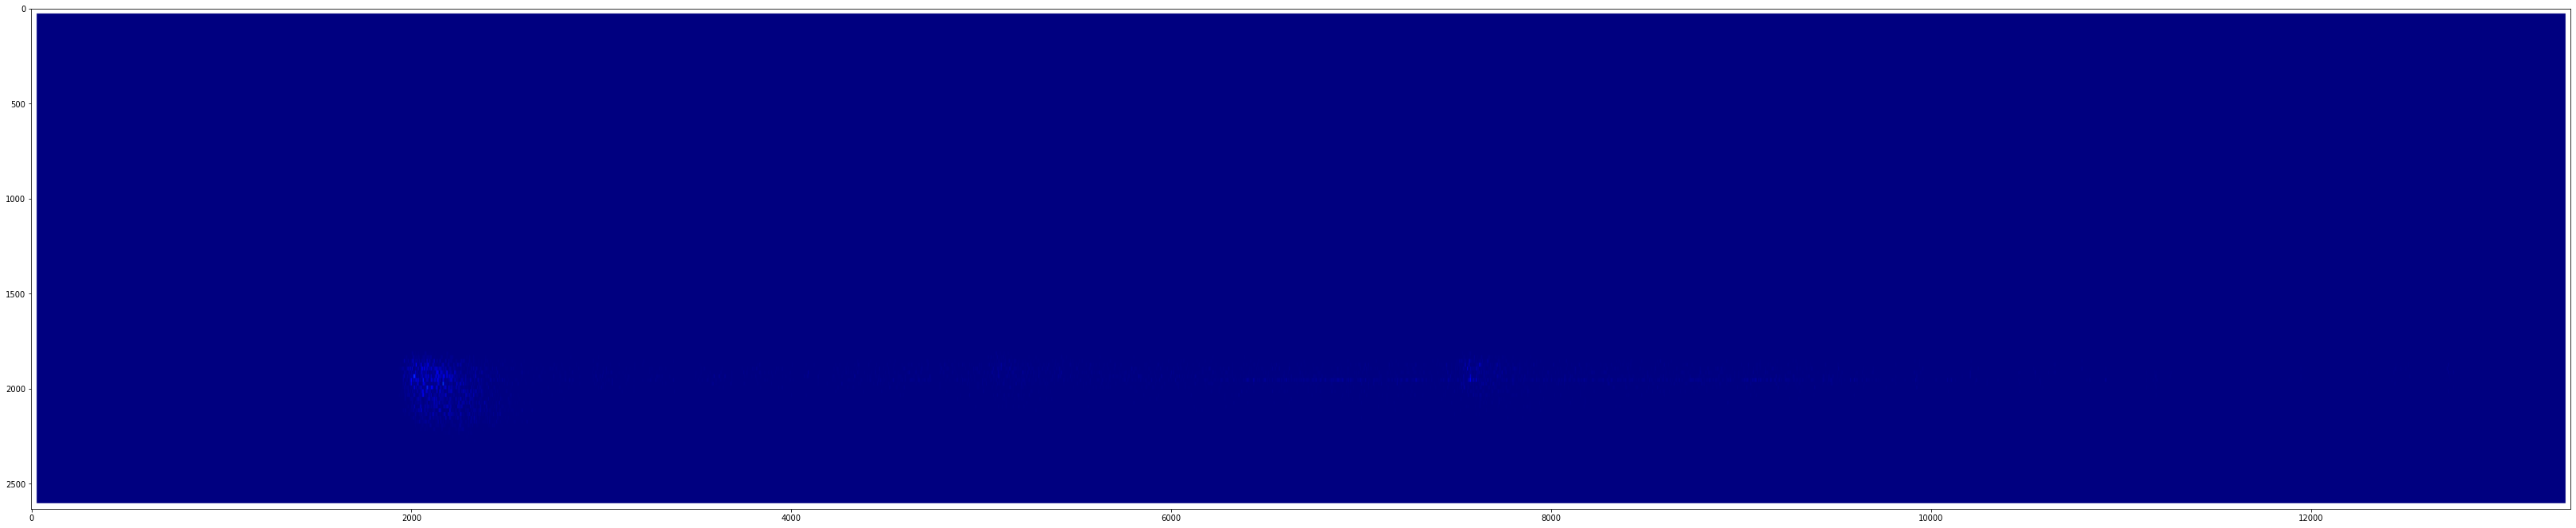

0.0 12239.458


In [3]:
iterator = 0

read_err = []

for i in range(0, cat.shape[0]):
    
    row = cat.iloc[i]
    
    arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
    arrival_time_rel = row['time_rel(sec)']

    test_filename = row.filename
    data_directory = './data/lunar/training/data/S12_GradeA/'
    mseed_file = f'{data_directory}{test_filename}.mseed'
    
    try:
        st = read(mseed_file)
    except FileNotFoundError:
        print(f'file {mseed_file} not found')
        iterator += 1
        pass
    
    # This is how you get the data and the time, which is in seconds
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data

    # Start time of trace (another way to get the relative arrival time using datetime)
    starttime = tr.stats.starttime.datetime
    arrival = (arrival_time - starttime).total_seconds()
    
    # Set the minimum frequency
    minfreq = 0.5
    maxfreq = 1.0

    # Going to create a separate trace for the filter data
    st_filt = st.copy()
    st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
    tr_filt = st_filt.traces[0].copy()
    tr_times_filt = tr_filt.times()
    tr_data_filt = tr_filt.data
    
    f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)
    
    width = st[0].stats['npts']/10000

    fig = plt.figure(figsize=(width, 25), frameon = False)


    ax2 = plt.subplot(2, 1, 2)
    ax2.set_axis_off()
    vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
 
    # Set the output file name and path
    filename = 'my_plot.png'

    # Save the plot to the file
    plt.axis('off')
    ax2 = plt.savefig(filename, dpi = 300, bbox_inches='tight')
    
    img_color = cv.imread('my_plot.png')
    img = cv.cvtColor(img_color, cv.COLOR_RGB2GRAY)

    kernel = np.ones((12,12), np.uint8)
    dilation = cv.dilate(img, kernel, iterations = 15)
    
    # Threshold it so it becomes binary
    ret, thresh = cv.threshold(dilation,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

    # Use connectedComponents() (returns a labeled image and the number of labels)
    num_labels, labels = cv.connectedComponents(thresh)

    # Use connectedComponentsWithStats() (returns a labeled image, the number of labels, and statistics for each component)
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(thresh)
    
    nb_components, output, stats, centroids = cv.connectedComponentsWithStats(thresh, connectivity=4)
    sizes = stats[:, -1]
    
    max_label = 2
    max_size = sizes[-1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(thresh.shape)
    
    img2[output == max_label] = 255
    
    if max_label >= nb_components:
        max_label = 1
    
    x = stats[max_label, cv.CC_STAT_LEFT]
    y = stats[max_label, cv.CC_STAT_TOP]
    w = stats[max_label, cv.CC_STAT_WIDTH]
    h = stats[max_label, cv.CC_STAT_HEIGHT]
    
    i = 0
    j = x

    while i < img2.shape[0] and j + w < img2.shape[1]:
        img_color[i][j] = np.uint8(255)
        img_color[i][j-1] = np.uint8(255)
        img_color[i][j+1] = np.uint8(255)
        img_color[i][j+w] = np.uint8(255)
        img_color[i][j+w-1] = np.uint8(255)
        img_color[i][j+w+1] = np.uint8(255)
        i += 1
    
    fig = plt.figure(figsize=(width, 25))
    
    img_color = cv.cvtColor(img_color, cv.COLOR_BGR2RGB)
    
    plt.imshow(img_color)

    # Show the plot
    plt.show()
    
    print((j / img.shape[1]) * max(tr_times_filt), arrival)
    
    iterator += 1